# ResNet for Decoding EEG

In this notebook, we will explore how a Resnet performs on EEG data, which has both spatial and temporal components.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch import Tensor
from typing import Type
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import random
from scipy.signal import butter, filtfilt

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/C147_Final_Project/resnet.py .
from resnet import *

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda


Please load in data before each part

In [ ]:
# Load training data
#/content/drive/MyDrive/C147_Final_Project/project_data/project/X_test.npy
X_train_valid = np.load("/content/drive/MyDrive/C147_Final_Project/project_data/project/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/C147_Final_Project/project_data/project/y_train_valid.npy")
y_train_valid = y_train_valid - 769
person_train_valid = np.load("/content/drive/MyDrive/C147_Final_Project/project_data/project/person_train_valid.npy")

# Load test data
x_test = np.load("/content/drive/MyDrive/C147_Final_Project/project_data/project/X_test.npy")
y_test = np.load("/content/drive/MyDrive/C147_Final_Project/project_data/project/y_test.npy")
y_test = y_test - 769
person_test = np.load("/content/drive/MyDrive/C147_Final_Project/project_data/project/person_test.npy")

# Print shapes
print('X train: ', X_train_valid.shape)
print('y train: ', y_train_valid.shape)
print('Person train+valid: ', person_train_valid.shape)
print('X test: ', x_test.shape)
print('y test: ', y_test.shape)
print('Person test: ', person_test.shape)

X train:  (2115, 22, 1000)
y train:  (2115,)
Person train+valid:  (2115, 1)
X test:  (443, 22, 1000)
y test:  (443,)
Person test:  (443, 1)


## Part 1 Training and validating on raw EEG data

In [ ]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

#Convert to tensors
x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of training set: torch.Size([1692, 22, 1000])
Shape of validation set: torch.Size([423, 22, 1000])
Shape of training labels: (1692,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([1692, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torch.Size([1692, 22, 1000, 1])
Shape of validation set after adding width info: torch.Size([423, 22, 1000, 1])
Shape of test set after adding width info: (443, 22, 1000, 1)
Shape of training set after dimension reshaping: torch.Size([1692, 1, 22, 1000])
Shape of validation set after dimension reshaping: torch.Size([423, 1, 22, 1000])
Shape of test set after dimension reshaping: torch.Size([443, 1, 22, 1000])


In [ ]:
#Test random sample function
bsz = 10
x_train_sample, y_train_sample = sample(x_train, y_train, bsz)
print(len(x_train_sample), len(y_train_sample))

10 10


In [ ]:
#Build model
model1 = ResNet(img_channels=1, block=BasicBlock, num_classes=4, time_dim=1000, dropout=0.6).to(device)
print(model1)
total_params = sum(p.numel() for p in model1.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNet(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1): Con

In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Training Time!

train_history_1, val_history_1 = np.array([]), np.array([])
train_loss_hist_1, val_loss_hist_1 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    savefolder = '/content/drive/MyDrive/C147_Final_Project/best_model_params_CNN'
    best_model_params_path = os.path.join(savefolder, 'best_model1_params.pt')

    torch.save(model1.state_dict(), best_model_params_path)
    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        model1.train()
        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            logits = model1(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        model1.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            logits = model1(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        train_history_1 = np.append(train_history_1, train_acc.item())
        val_history_1 = np.append(val_history_1, val_acc.item())
        train_loss_hist_1 = np.append(train_loss_hist_1, loss.item())
        val_loss_hist_1 = np.append(val_loss_hist_1, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model1.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-12-bf5c1bdabb3c>:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:10<1:27:06, 10.47s/it]

Epoch 1 Finished!!!
Train acc: 0.220, Val acc: 0.286
Train loss: 1.395, Val loss: 1.379
Epoch 2 Finished!!!
Train acc: 0.350, Val acc: 0.352
Train loss: 1.345, Val loss: 1.337


  0%|          | 2/500 [00:12<44:24,  5.35s/it]  

Epoch 3 Finished!!!
Train acc: 0.390, Val acc: 0.390
Train loss: 1.324, Val loss: 1.321


  1%|          | 4/500 [00:15<24:14,  2.93s/it]

Epoch 4 Finished!!!
Train acc: 0.500, Val acc: 0.381
Train loss: 1.261, Val loss: 1.321


  1%|          | 5/500 [00:17<20:42,  2.51s/it]

Epoch 5 Finished!!!
Train acc: 0.480, Val acc: 0.362
Train loss: 1.272, Val loss: 1.347
Epoch 6 Finished!!!
Train acc: 0.450, Val acc: 0.388


  1%|          | 6/500 [00:19<18:33,  2.25s/it]

Train loss: 1.282, Val loss: 1.337
Epoch 7 Finished!!!


  1%|▏         | 7/500 [00:21<17:16,  2.10s/it]

Train acc: 0.430, Val acc: 0.397
Train loss: 1.271, Val loss: 1.311
Epoch 8 Finished!!!
Train acc: 0.420, Val acc: 0.414


  2%|▏         | 8/500 [00:22<16:22,  2.00s/it]

Train loss: 1.308, Val loss: 1.310


  2%|▏         | 9/500 [00:24<15:43,  1.92s/it]

Epoch 9 Finished!!!
Train acc: 0.480, Val acc: 0.395
Train loss: 1.230, Val loss: 1.322
Epoch 10 Finished!!!
Train acc: 0.400, Val acc: 0.385
Train loss: 1.301, Val loss: 1.326

  2%|▏         | 10/500 [00:26<15:19,  1.88s/it]


Epoch 11 Finished!!!


  2%|▏         | 11/500 [00:28<15:03,  1.85s/it]

Train acc: 0.460, Val acc: 0.442
Train loss: 1.267, Val loss: 1.289


  2%|▏         | 12/500 [00:29<14:49,  1.82s/it]

Epoch 12 Finished!!!
Train acc: 0.440, Val acc: 0.414
Train loss: 1.271, Val loss: 1.308


  3%|▎         | 13/500 [00:31<14:40,  1.81s/it]

Epoch 13 Finished!!!
Train acc: 0.580, Val acc: 0.426
Train loss: 1.154, Val loss: 1.301
Epoch 14 Finished!!!


  3%|▎         | 14/500 [00:33<14:34,  1.80s/it]

Train acc: 0.510, Val acc: 0.395
Train loss: 1.217, Val loss: 1.315
Epoch 15 Finished!!!


  3%|▎         | 15/500 [00:35<14:30,  1.79s/it]

Train acc: 0.450, Val acc: 0.404
Train loss: 1.259, Val loss: 1.318
Epoch 16 Finished!!!


  3%|▎         | 16/500 [00:37<14:29,  1.80s/it]

Train acc: 0.580, Val acc: 0.435
Train loss: 1.162, Val loss: 1.289
Epoch 17 Finished!!!


  3%|▎         | 17/500 [00:38<14:30,  1.80s/it]

Train acc: 0.500, Val acc: 0.452
Train loss: 1.218, Val loss: 1.281
Epoch 18 Finished!!!


  4%|▎         | 18/500 [00:40<14:26,  1.80s/it]

Train acc: 0.580, Val acc: 0.442
Train loss: 1.168, Val loss: 1.284
Epoch 19 Finished!!!


  4%|▍         | 19/500 [00:42<14:24,  1.80s/it]

Train acc: 0.490, Val acc: 0.437
Train loss: 1.225, Val loss: 1.289


  4%|▍         | 20/500 [00:44<14:22,  1.80s/it]

Epoch 20 Finished!!!
Train acc: 0.530, Val acc: 0.414
Train loss: 1.176, Val loss: 1.308
Epoch 21 Finished!!!


  4%|▍         | 21/500 [00:46<14:21,  1.80s/it]

Train acc: 0.500, Val acc: 0.404
Train loss: 1.213, Val loss: 1.322
Epoch 22 Finished!!!


  4%|▍         | 22/500 [00:47<14:19,  1.80s/it]

Train acc: 0.460, Val acc: 0.411
Train loss: 1.234, Val loss: 1.305
Epoch 23 Finished!!!


  5%|▍         | 23/500 [00:49<14:18,  1.80s/it]

Train acc: 0.580, Val acc: 0.440
Train loss: 1.169, Val loss: 1.292
Epoch 24 Finished!!!


  5%|▍         | 24/500 [00:51<14:17,  1.80s/it]

Train acc: 0.480, Val acc: 0.449
Train loss: 1.221, Val loss: 1.281
Epoch 25 Finished!!!


  5%|▌         | 25/500 [00:53<14:17,  1.80s/it]

Train acc: 0.600, Val acc: 0.440
Train loss: 1.124, Val loss: 1.285
Epoch 26 Finished!!!
Train acc: 0.550, Val acc: 0.442
Train loss: 1.159, Val loss: 1.278


  5%|▌         | 26/500 [00:55<14:16,  1.81s/it]

Epoch 27 Finished!!!
Train acc: 0.530, Val acc: 0.433

  5%|▌         | 27/500 [00:56<14:16,  1.81s/it]


Train loss: 1.204, Val loss: 1.287
Epoch 28 Finished!!!


  6%|▌         | 28/500 [00:58<14:15,  1.81s/it]

Train acc: 0.520, Val acc: 0.433
Train loss: 1.211, Val loss: 1.293
Epoch 29 Finished!!!


  6%|▌         | 29/500 [01:00<14:14,  1.82s/it]

Train acc: 0.500, Val acc: 0.426
Train loss: 1.205, Val loss: 1.293
Epoch 30 Finished!!!


  6%|▌         | 30/500 [01:02<14:14,  1.82s/it]

Train acc: 0.580, Val acc: 0.437
Train loss: 1.152, Val loss: 1.287
Epoch 31 Finished!!!


  6%|▌         | 31/500 [01:04<14:13,  1.82s/it]

Train acc: 0.560, Val acc: 0.449
Train loss: 1.168, Val loss: 1.282
Epoch 32 Finished!!!


  6%|▋         | 32/500 [01:06<14:17,  1.83s/it]

Train acc: 0.490, Val acc: 0.468
Train loss: 1.243, Val loss: 1.258
Epoch 33 Finished!!!


  7%|▋         | 33/500 [01:07<14:15,  1.83s/it]

Train acc: 0.610, Val acc: 0.447
Train loss: 1.118, Val loss: 1.272
Epoch 34 Finished!!!


  7%|▋         | 34/500 [01:09<14:15,  1.84s/it]

Train acc: 0.620, Val acc: 0.459
Train loss: 1.128, Val loss: 1.267
Epoch 35 Finished!!!


  7%|▋         | 35/500 [01:11<14:13,  1.84s/it]

Train acc: 0.600, Val acc: 0.461
Train loss: 1.155, Val loss: 1.272
Epoch 36 Finished!!!


  7%|▋         | 36/500 [01:13<14:12,  1.84s/it]

Train acc: 0.500, Val acc: 0.461
Train loss: 1.232, Val loss: 1.264
Epoch 37 Finished!!!


  7%|▋         | 37/500 [01:15<14:14,  1.85s/it]

Train acc: 0.550, Val acc: 0.482
Train loss: 1.192, Val loss: 1.256
Epoch 38 Finished!!!


  8%|▊         | 38/500 [01:17<14:12,  1.84s/it]

Train acc: 0.590, Val acc: 0.475
Train loss: 1.150, Val loss: 1.261
Epoch 39 Finished!!!


  8%|▊         | 39/500 [01:18<14:11,  1.85s/it]

Train acc: 0.560, Val acc: 0.459
Train loss: 1.163, Val loss: 1.275
Epoch 40 Finished!!!


  8%|▊         | 40/500 [01:20<14:16,  1.86s/it]

Train acc: 0.630, Val acc: 0.489
Train loss: 1.124, Val loss: 1.239
Epoch 41 Finished!!!


  8%|▊         | 41/500 [01:22<14:14,  1.86s/it]

Train acc: 0.530, Val acc: 0.478
Train loss: 1.193, Val loss: 1.254
Epoch 42 Finished!!!


  8%|▊         | 42/500 [01:24<14:14,  1.87s/it]

Train acc: 0.570, Val acc: 0.501
Train loss: 1.175, Val loss: 1.238
Epoch 43 Finished!!!


  9%|▊         | 43/500 [01:26<14:10,  1.86s/it]

Train acc: 0.600, Val acc: 0.475
Train loss: 1.142, Val loss: 1.249
Epoch 44 Finished!!!


  9%|▉         | 44/500 [01:28<14:08,  1.86s/it]

Train acc: 0.580, Val acc: 0.485
Train loss: 1.177, Val loss: 1.253
Epoch 45 Finished!!!


  9%|▉         | 45/500 [01:30<14:07,  1.86s/it]

Train acc: 0.530, Val acc: 0.496
Train loss: 1.184, Val loss: 1.240
Epoch 46 Finished!!!


  9%|▉         | 46/500 [01:32<14:06,  1.86s/it]

Train acc: 0.600, Val acc: 0.449
Train loss: 1.133, Val loss: 1.275
Epoch 47 Finished!!!


  9%|▉         | 47/500 [01:33<14:04,  1.86s/it]

Train acc: 0.610, Val acc: 0.473
Train loss: 1.128, Val loss: 1.256
Epoch 48 Finished!!!


 10%|▉         | 48/500 [01:35<14:04,  1.87s/it]

Train acc: 0.640, Val acc: 0.482
Train loss: 1.119, Val loss: 1.246
Epoch 49 Finished!!!


 10%|▉         | 49/500 [01:37<14:03,  1.87s/it]

Train acc: 0.600, Val acc: 0.454
Train loss: 1.121, Val loss: 1.275
Epoch 50 Finished!!!


 10%|█         | 50/500 [01:39<14:00,  1.87s/it]

Train acc: 0.590, Val acc: 0.459
Train loss: 1.143, Val loss: 1.265
Epoch 51 Finished!!!


 10%|█         | 51/500 [01:41<13:57,  1.87s/it]

Train acc: 0.540, Val acc: 0.485
Train loss: 1.223, Val loss: 1.259
Epoch 52 Finished!!!


 10%|█         | 52/500 [01:43<13:53,  1.86s/it]

Train acc: 0.550, Val acc: 0.482
Train loss: 1.186, Val loss: 1.249
Epoch 53 Finished!!!


 11%|█         | 53/500 [01:45<13:51,  1.86s/it]

Train acc: 0.670, Val acc: 0.466
Train loss: 1.085, Val loss: 1.258
Epoch 54 Finished!!!


 11%|█         | 54/500 [01:46<13:48,  1.86s/it]

Train acc: 0.660, Val acc: 0.494
Train loss: 1.069, Val loss: 1.243
Epoch 55 Finished!!!


 11%|█         | 55/500 [01:48<13:46,  1.86s/it]

Train acc: 0.580, Val acc: 0.470
Train loss: 1.166, Val loss: 1.260
Epoch 56 Finished!!!


 11%|█         | 56/500 [01:50<13:42,  1.85s/it]

Train acc: 0.550, Val acc: 0.459
Train loss: 1.172, Val loss: 1.258
Epoch 57 Finished!!!


 11%|█▏        | 57/500 [01:52<13:39,  1.85s/it]

Train acc: 0.670, Val acc: 0.456
Train loss: 1.084, Val loss: 1.271
Epoch 58 Finished!!!
Train acc: 0.670, Val acc: 0.461


 12%|█▏        | 58/500 [01:54<13:36,  1.85s/it]

Train loss: 1.073, Val loss: 1.276
Epoch 59 Finished!!!


 12%|█▏        | 59/500 [01:56<13:34,  1.85s/it]

Train acc: 0.670, Val acc: 0.489
Train loss: 1.077, Val loss: 1.242
Epoch 60 Finished!!!


 12%|█▏        | 60/500 [01:57<13:31,  1.84s/it]

Train acc: 0.680, Val acc: 0.480
Train loss: 1.058, Val loss: 1.250
Epoch 61 Finished!!!


 12%|█▏        | 61/500 [01:59<13:28,  1.84s/it]

Train acc: 0.590, Val acc: 0.492
Train loss: 1.148, Val loss: 1.246
Epoch 62 Finished!!!
Train acc: 0.640, Val acc: 0.482


 12%|█▏        | 62/500 [02:01<13:26,  1.84s/it]

Train loss: 1.088, Val loss: 1.254
Epoch 63 Finished!!!


 13%|█▎        | 63/500 [02:03<13:26,  1.85s/it]

Train acc: 0.610, Val acc: 0.504
Train loss: 1.122, Val loss: 1.231
Epoch 64 Finished!!!


 13%|█▎        | 64/500 [02:05<13:22,  1.84s/it]

Train acc: 0.590, Val acc: 0.463
Train loss: 1.138, Val loss: 1.266
Epoch 65 Finished!!!


 13%|█▎        | 65/500 [02:07<13:19,  1.84s/it]

Train acc: 0.670, Val acc: 0.489
Train loss: 1.064, Val loss: 1.246
Epoch 66 Finished!!!


 13%|█▎        | 66/500 [02:09<13:18,  1.84s/it]

Train acc: 0.660, Val acc: 0.478
Train loss: 1.086, Val loss: 1.257
Epoch 67 Finished!!!


 13%|█▎        | 67/500 [02:10<13:18,  1.85s/it]

Train acc: 0.710, Val acc: 0.513
Train loss: 1.037, Val loss: 1.227
Epoch 68 Finished!!!


 14%|█▎        | 68/500 [02:12<13:15,  1.84s/it]

Train acc: 0.710, Val acc: 0.492
Train loss: 1.048, Val loss: 1.239
Epoch 69 Finished!!!


 14%|█▍        | 69/500 [02:14<13:12,  1.84s/it]

Train acc: 0.660, Val acc: 0.504
Train loss: 1.099, Val loss: 1.230
Epoch 70 Finished!!!


 14%|█▍        | 70/500 [02:16<13:13,  1.84s/it]

Train acc: 0.600, Val acc: 0.485
Train loss: 1.137, Val loss: 1.247
Epoch 71 Finished!!!


 14%|█▍        | 71/500 [02:18<13:10,  1.84s/it]

Train acc: 0.570, Val acc: 0.504
Train loss: 1.160, Val loss: 1.230
Epoch 72 Finished!!!


 14%|█▍        | 72/500 [02:20<13:07,  1.84s/it]

Train acc: 0.630, Val acc: 0.473
Train loss: 1.099, Val loss: 1.258
Epoch 73 Finished!!!


 15%|█▍        | 73/500 [02:21<13:05,  1.84s/it]

Train acc: 0.580, Val acc: 0.496
Train loss: 1.140, Val loss: 1.238
Epoch 74 Finished!!!


 15%|█▍        | 74/500 [02:23<13:04,  1.84s/it]

Train acc: 0.640, Val acc: 0.508
Train loss: 1.102, Val loss: 1.222
Epoch 75 Finished!!!


 15%|█▌        | 75/500 [02:25<13:07,  1.85s/it]

Train acc: 0.620, Val acc: 0.520
Train loss: 1.112, Val loss: 1.223
Epoch 76 Finished!!!


 15%|█▌        | 76/500 [02:27<13:04,  1.85s/it]

Train acc: 0.660, Val acc: 0.499
Train loss: 1.092, Val loss: 1.237
Epoch 77 Finished!!!


 15%|█▌        | 77/500 [02:29<13:05,  1.86s/it]

Train acc: 0.580, Val acc: 0.522
Train loss: 1.145, Val loss: 1.212
Epoch 78 Finished!!!


 16%|█▌        | 78/500 [02:31<13:01,  1.85s/it]

Train acc: 0.640, Val acc: 0.511
Train loss: 1.092, Val loss: 1.231
Epoch 79 Finished!!!


 16%|█▌        | 79/500 [02:33<13:02,  1.86s/it]

Train acc: 0.570, Val acc: 0.525
Train loss: 1.145, Val loss: 1.219
Epoch 80 Finished!!!


 16%|█▌        | 80/500 [02:34<12:59,  1.86s/it]

Train acc: 0.600, Val acc: 0.508
Train loss: 1.123, Val loss: 1.220
Epoch 81 Finished!!!


 16%|█▌        | 81/500 [02:36<12:57,  1.85s/it]

Train acc: 0.740, Val acc: 0.518
Train loss: 1.016, Val loss: 1.219
Epoch 82 Finished!!!


 16%|█▋        | 82/500 [02:38<12:54,  1.85s/it]

Train acc: 0.690, Val acc: 0.513
Train loss: 1.046, Val loss: 1.223
Epoch 83 Finished!!!


 17%|█▋        | 83/500 [02:40<12:52,  1.85s/it]

Train acc: 0.650, Val acc: 0.508
Train loss: 1.083, Val loss: 1.224
Epoch 84 Finished!!!


 17%|█▋        | 84/500 [02:42<12:50,  1.85s/it]

Train acc: 0.600, Val acc: 0.511
Train loss: 1.121, Val loss: 1.225
Epoch 85 Finished!!!


 17%|█▋        | 85/500 [02:44<12:49,  1.85s/it]

Train acc: 0.670, Val acc: 0.515
Train loss: 1.069, Val loss: 1.219
Epoch 86 Finished!!!


 17%|█▋        | 86/500 [02:46<12:47,  1.85s/it]

Train acc: 0.710, Val acc: 0.504
Train loss: 1.028, Val loss: 1.230
Epoch 87 Finished!!!


 17%|█▋        | 87/500 [02:47<12:45,  1.85s/it]

Train acc: 0.610, Val acc: 0.515
Train loss: 1.135, Val loss: 1.227
Epoch 88 Finished!!!


 18%|█▊        | 88/500 [02:49<12:43,  1.85s/it]

Train acc: 0.710, Val acc: 0.508
Train loss: 1.037, Val loss: 1.227
Epoch 89 Finished!!!


 18%|█▊        | 89/500 [02:51<12:41,  1.85s/it]

Train acc: 0.650, Val acc: 0.506
Train loss: 1.091, Val loss: 1.224
Epoch 90 Finished!!!


 18%|█▊        | 90/500 [02:53<12:39,  1.85s/it]

Train acc: 0.560, Val acc: 0.487
Train loss: 1.175, Val loss: 1.243
Epoch 91 Finished!!!


 18%|█▊        | 91/500 [02:55<12:37,  1.85s/it]

Train acc: 0.640, Val acc: 0.525
Train loss: 1.098, Val loss: 1.211
Epoch 92 Finished!!!


 18%|█▊        | 92/500 [02:57<12:35,  1.85s/it]

Train acc: 0.730, Val acc: 0.496
Train loss: 1.015, Val loss: 1.227
Epoch 93 Finished!!!


 19%|█▊        | 93/500 [02:58<12:32,  1.85s/it]

Train acc: 0.720, Val acc: 0.518
Train loss: 1.025, Val loss: 1.218
Epoch 94 Finished!!!


 19%|█▉        | 94/500 [03:00<12:30,  1.85s/it]

Train acc: 0.730, Val acc: 0.513
Train loss: 1.013, Val loss: 1.216
Epoch 95 Finished!!!


 19%|█▉        | 95/500 [03:02<12:29,  1.85s/it]

Train acc: 0.660, Val acc: 0.499
Train loss: 1.080, Val loss: 1.228
Epoch 96 Finished!!!


 19%|█▉        | 96/500 [03:04<12:26,  1.85s/it]

Train acc: 0.740, Val acc: 0.478
Train loss: 1.002, Val loss: 1.251
Epoch 97 Finished!!!


 19%|█▉        | 97/500 [03:06<12:25,  1.85s/it]

Train acc: 0.650, Val acc: 0.522
Train loss: 1.087, Val loss: 1.214
Epoch 98 Finished!!!


 20%|█▉        | 98/500 [03:08<12:23,  1.85s/it]

Train acc: 0.680, Val acc: 0.515
Train loss: 1.058, Val loss: 1.219
Epoch 99 Finished!!!


 20%|█▉        | 99/500 [03:10<12:21,  1.85s/it]

Train acc: 0.600, Val acc: 0.496
Train loss: 1.132, Val loss: 1.230
Epoch 100 Finished!!!


 20%|██        | 100/500 [03:11<12:18,  1.85s/it]

Train acc: 0.730, Val acc: 0.520
Train loss: 1.014, Val loss: 1.214
Epoch 101 Finished!!!


 20%|██        | 101/500 [03:13<12:17,  1.85s/it]

Train acc: 0.720, Val acc: 0.525
Train loss: 1.028, Val loss: 1.209
Epoch 102 Finished!!!


 20%|██        | 102/500 [03:15<12:15,  1.85s/it]

Train acc: 0.730, Val acc: 0.518
Train loss: 1.010, Val loss: 1.214
Epoch 103 Finished!!!


 21%|██        | 103/500 [03:17<12:13,  1.85s/it]

Train acc: 0.670, Val acc: 0.520
Train loss: 1.070, Val loss: 1.218
Epoch 104 Finished!!!


 21%|██        | 104/500 [03:19<12:15,  1.86s/it]

Train acc: 0.620, Val acc: 0.527
Train loss: 1.101, Val loss: 1.214
Epoch 105 Finished!!!


 21%|██        | 105/500 [03:21<12:12,  1.85s/it]

Train acc: 0.700, Val acc: 0.506
Train loss: 1.061, Val loss: 1.232
Epoch 106 Finished!!!


 21%|██        | 106/500 [03:23<12:09,  1.85s/it]

Train acc: 0.690, Val acc: 0.499
Train loss: 1.039, Val loss: 1.236
Epoch 107 Finished!!!


 21%|██▏       | 107/500 [03:24<12:07,  1.85s/it]

Train acc: 0.750, Val acc: 0.499
Train loss: 0.984, Val loss: 1.240
Epoch 108 Finished!!!


 22%|██▏       | 108/500 [03:26<12:05,  1.85s/it]

Train acc: 0.760, Val acc: 0.473
Train loss: 0.996, Val loss: 1.257
Epoch 109 Finished!!!


 22%|██▏       | 109/500 [03:28<12:02,  1.85s/it]

Train acc: 0.690, Val acc: 0.482
Train loss: 1.055, Val loss: 1.245
Epoch 110 Finished!!!


 22%|██▏       | 110/500 [03:30<12:00,  1.85s/it]

Train acc: 0.670, Val acc: 0.499
Train loss: 1.081, Val loss: 1.231
Epoch 111 Finished!!!


 22%|██▏       | 111/500 [03:32<11:59,  1.85s/it]

Train acc: 0.680, Val acc: 0.504
Train loss: 1.045, Val loss: 1.230
Epoch 112 Finished!!!


 22%|██▏       | 112/500 [03:34<11:56,  1.85s/it]

Train acc: 0.670, Val acc: 0.496
Train loss: 1.078, Val loss: 1.234
Epoch 113 Finished!!!


 23%|██▎       | 113/500 [03:35<11:54,  1.85s/it]

Train acc: 0.770, Val acc: 0.463
Train loss: 0.989, Val loss: 1.271
Epoch 114 Finished!!!


 23%|██▎       | 114/500 [03:37<11:53,  1.85s/it]

Train acc: 0.750, Val acc: 0.501
Train loss: 0.994, Val loss: 1.242
Epoch 115 Finished!!!


 23%|██▎       | 115/500 [03:39<11:51,  1.85s/it]

Train acc: 0.680, Val acc: 0.506
Train loss: 1.056, Val loss: 1.229
Epoch 116 Finished!!!


 23%|██▎       | 116/500 [03:41<11:49,  1.85s/it]

Train acc: 0.810, Val acc: 0.527
Train loss: 0.935, Val loss: 1.216
Epoch 117 Finished!!!


 23%|██▎       | 117/500 [03:43<11:47,  1.85s/it]

Train acc: 0.750, Val acc: 0.527
Train loss: 0.989, Val loss: 1.205
Epoch 118 Finished!!!


 24%|██▎       | 118/500 [03:45<11:46,  1.85s/it]

Train acc: 0.650, Val acc: 0.515
Train loss: 1.086, Val loss: 1.221
Epoch 119 Finished!!!


 24%|██▍       | 119/500 [03:47<11:44,  1.85s/it]

Train acc: 0.720, Val acc: 0.501
Train loss: 1.030, Val loss: 1.236
Epoch 120 Finished!!!


 24%|██▍       | 120/500 [03:48<11:44,  1.86s/it]

Train acc: 0.640, Val acc: 0.537
Train loss: 1.093, Val loss: 1.204
Epoch 121 Finished!!!


 24%|██▍       | 121/500 [03:50<11:41,  1.85s/it]

Train acc: 0.720, Val acc: 0.513
Train loss: 1.033, Val loss: 1.225
Epoch 122 Finished!!!


 24%|██▍       | 122/500 [03:52<11:39,  1.85s/it]

Train acc: 0.700, Val acc: 0.527
Train loss: 1.038, Val loss: 1.206
Epoch 123 Finished!!!


 25%|██▍       | 123/500 [03:54<11:36,  1.85s/it]

Train acc: 0.780, Val acc: 0.513
Train loss: 0.968, Val loss: 1.224
Epoch 124 Finished!!!


 25%|██▍       | 124/500 [03:56<11:35,  1.85s/it]

Train acc: 0.690, Val acc: 0.518
Train loss: 1.056, Val loss: 1.216
Epoch 125 Finished!!!


 25%|██▌       | 125/500 [03:58<11:33,  1.85s/it]

Train acc: 0.760, Val acc: 0.506
Train loss: 0.986, Val loss: 1.226
Epoch 126 Finished!!!


 25%|██▌       | 126/500 [04:00<11:31,  1.85s/it]

Train acc: 0.760, Val acc: 0.522
Train loss: 0.975, Val loss: 1.207
Epoch 127 Finished!!!


 25%|██▌       | 127/500 [04:01<11:30,  1.85s/it]

Train acc: 0.690, Val acc: 0.518
Train loss: 1.064, Val loss: 1.215
Epoch 128 Finished!!!


 26%|██▌       | 128/500 [04:03<11:28,  1.85s/it]

Train acc: 0.770, Val acc: 0.504
Train loss: 0.958, Val loss: 1.227
Epoch 129 Finished!!!


 26%|██▌       | 129/500 [04:05<11:25,  1.85s/it]

Train acc: 0.750, Val acc: 0.501
Train loss: 0.992, Val loss: 1.233
Epoch 130 Finished!!!


 26%|██▌       | 130/500 [04:07<11:23,  1.85s/it]

Train acc: 0.780, Val acc: 0.518
Train loss: 0.962, Val loss: 1.219
Epoch 131 Finished!!!


 26%|██▌       | 131/500 [04:09<11:22,  1.85s/it]

Train acc: 0.740, Val acc: 0.527
Train loss: 0.993, Val loss: 1.211
Epoch 132 Finished!!!
Train acc: 0.770, Val acc: 0.515
Train loss: 0.973, Val loss: 1.219


 26%|██▋       | 132/500 [04:11<11:20,  1.85s/it]

Epoch 133 Finished!!!


 27%|██▋       | 133/500 [04:12<11:18,  1.85s/it]

Train acc: 0.700, Val acc: 0.515
Train loss: 1.034, Val loss: 1.209
Epoch 134 Finished!!!


 27%|██▋       | 134/500 [04:14<11:17,  1.85s/it]

Train acc: 0.680, Val acc: 0.513
Train loss: 1.060, Val loss: 1.225
Epoch 135 Finished!!!


 27%|██▋       | 135/500 [04:16<11:15,  1.85s/it]

Train acc: 0.760, Val acc: 0.527
Train loss: 0.996, Val loss: 1.209
Epoch 136 Finished!!!


 27%|██▋       | 136/500 [04:18<11:13,  1.85s/it]

Train acc: 0.820, Val acc: 0.518
Train loss: 0.928, Val loss: 1.220
Epoch 137 Finished!!!


 27%|██▋       | 137/500 [04:20<11:11,  1.85s/it]

Train acc: 0.680, Val acc: 0.511
Train loss: 1.062, Val loss: 1.226
Epoch 138 Finished!!!


 28%|██▊       | 138/500 [04:22<11:13,  1.86s/it]

Train acc: 0.660, Val acc: 0.544
Train loss: 1.071, Val loss: 1.199
Epoch 139 Finished!!!


 28%|██▊       | 139/500 [04:24<11:10,  1.86s/it]

Train acc: 0.660, Val acc: 0.515
Train loss: 1.076, Val loss: 1.222
Epoch 140 Finished!!!


 28%|██▊       | 140/500 [04:25<11:07,  1.86s/it]

Train acc: 0.740, Val acc: 0.508
Train loss: 0.997, Val loss: 1.224
Epoch 141 Finished!!!


 28%|██▊       | 141/500 [04:27<11:05,  1.85s/it]

Train acc: 0.790, Val acc: 0.530
Train loss: 0.970, Val loss: 1.211
Epoch 142 Finished!!!


 28%|██▊       | 142/500 [04:29<11:02,  1.85s/it]

Train acc: 0.740, Val acc: 0.532
Train loss: 1.008, Val loss: 1.209
Epoch 143 Finished!!!


 29%|██▊       | 143/500 [04:31<11:00,  1.85s/it]

Train acc: 0.740, Val acc: 0.520
Train loss: 0.994, Val loss: 1.218
Epoch 144 Finished!!!


 29%|██▉       | 144/500 [04:33<10:58,  1.85s/it]

Train acc: 0.770, Val acc: 0.489
Train loss: 0.986, Val loss: 1.233
Epoch 145 Finished!!!


 29%|██▉       | 145/500 [04:35<10:57,  1.85s/it]

Train acc: 0.680, Val acc: 0.504
Train loss: 1.052, Val loss: 1.219
Epoch 146 Finished!!!


 29%|██▉       | 146/500 [04:37<10:55,  1.85s/it]

Train acc: 0.760, Val acc: 0.530
Train loss: 0.977, Val loss: 1.206
Epoch 147 Finished!!!


 29%|██▉       | 147/500 [04:38<10:53,  1.85s/it]

Train acc: 0.770, Val acc: 0.534
Train loss: 0.973, Val loss: 1.203
Epoch 148 Finished!!!


 30%|██▉       | 148/500 [04:40<10:51,  1.85s/it]

Train acc: 0.710, Val acc: 0.504
Train loss: 1.029, Val loss: 1.227
Epoch 149 Finished!!!


 30%|██▉       | 149/500 [04:42<10:48,  1.85s/it]

Train acc: 0.700, Val acc: 0.508
Train loss: 1.022, Val loss: 1.228
Epoch 150 Finished!!!


 30%|███       | 150/500 [04:44<10:47,  1.85s/it]

Train acc: 0.770, Val acc: 0.508
Train loss: 0.972, Val loss: 1.218
Epoch 151 Finished!!!


 30%|███       | 151/500 [04:46<10:45,  1.85s/it]

Train acc: 0.720, Val acc: 0.539
Train loss: 1.005, Val loss: 1.202
Epoch 152 Finished!!!


 30%|███       | 152/500 [04:48<10:44,  1.85s/it]

Train acc: 0.810, Val acc: 0.525
Train loss: 0.952, Val loss: 1.208
Epoch 153 Finished!!!


 31%|███       | 153/500 [04:50<10:41,  1.85s/it]

Train acc: 0.760, Val acc: 0.506
Train loss: 0.988, Val loss: 1.218
Epoch 154 Finished!!!


 31%|███       | 154/500 [04:51<10:42,  1.86s/it]

Train acc: 0.720, Val acc: 0.553
Train loss: 1.023, Val loss: 1.192
Epoch 155 Finished!!!


 31%|███       | 155/500 [04:53<10:39,  1.85s/it]

Train acc: 0.780, Val acc: 0.513
Train loss: 0.947, Val loss: 1.221
Epoch 156 Finished!!!


 31%|███       | 156/500 [04:55<10:37,  1.85s/it]

Train acc: 0.750, Val acc: 0.508
Train loss: 0.993, Val loss: 1.219
Epoch 157 Finished!!!


 31%|███▏      | 157/500 [04:57<10:35,  1.85s/it]

Train acc: 0.730, Val acc: 0.518
Train loss: 1.019, Val loss: 1.220
Epoch 158 Finished!!!


 32%|███▏      | 158/500 [04:59<10:32,  1.85s/it]

Train acc: 0.720, Val acc: 0.508
Train loss: 1.012, Val loss: 1.221
Epoch 159 Finished!!!


 32%|███▏      | 159/500 [05:01<10:31,  1.85s/it]

Train acc: 0.780, Val acc: 0.511
Train loss: 0.982, Val loss: 1.223
Epoch 160 Finished!!!


 32%|███▏      | 160/500 [05:02<10:29,  1.85s/it]

Train acc: 0.810, Val acc: 0.511
Train loss: 0.939, Val loss: 1.216
Epoch 161 Finished!!!


 32%|███▏      | 161/500 [05:04<10:27,  1.85s/it]

Train acc: 0.780, Val acc: 0.522
Train loss: 0.960, Val loss: 1.212
Epoch 162 Finished!!!


 32%|███▏      | 162/500 [05:06<10:25,  1.85s/it]

Train acc: 0.800, Val acc: 0.525
Train loss: 0.946, Val loss: 1.213
Epoch 163 Finished!!!


 33%|███▎      | 163/500 [05:08<10:24,  1.85s/it]

Train acc: 0.750, Val acc: 0.525
Train loss: 0.986, Val loss: 1.219
Epoch 164 Finished!!!


 33%|███▎      | 164/500 [05:10<10:21,  1.85s/it]

Train acc: 0.710, Val acc: 0.518
Train loss: 1.015, Val loss: 1.216
Epoch 165 Finished!!!


 33%|███▎      | 165/500 [05:12<10:20,  1.85s/it]

Train acc: 0.830, Val acc: 0.527
Train loss: 0.914, Val loss: 1.203
Epoch 166 Finished!!!


 33%|███▎      | 166/500 [05:14<10:18,  1.85s/it]

Train acc: 0.780, Val acc: 0.520
Train loss: 0.958, Val loss: 1.209
Epoch 167 Finished!!!


 33%|███▎      | 167/500 [05:15<10:16,  1.85s/it]

Train acc: 0.810, Val acc: 0.508
Train loss: 0.950, Val loss: 1.221
Epoch 168 Finished!!!


 34%|███▎      | 168/500 [05:17<10:14,  1.85s/it]

Train acc: 0.850, Val acc: 0.520
Train loss: 0.902, Val loss: 1.220
Epoch 169 Finished!!!


 34%|███▍      | 169/500 [05:19<10:12,  1.85s/it]

Train acc: 0.790, Val acc: 0.534
Train loss: 0.948, Val loss: 1.200
Epoch 170 Finished!!!


 34%|███▍      | 170/500 [05:21<10:10,  1.85s/it]

Train acc: 0.790, Val acc: 0.499
Train loss: 0.948, Val loss: 1.231
Epoch 171 Finished!!!


 34%|███▍      | 171/500 [05:23<10:08,  1.85s/it]

Train acc: 0.810, Val acc: 0.511
Train loss: 0.932, Val loss: 1.224
Epoch 172 Finished!!!


 34%|███▍      | 172/500 [05:25<10:06,  1.85s/it]

Train acc: 0.770, Val acc: 0.515
Train loss: 0.964, Val loss: 1.219
Epoch 173 Finished!!!


 35%|███▍      | 173/500 [05:27<10:05,  1.85s/it]

Train acc: 0.780, Val acc: 0.499
Train loss: 0.969, Val loss: 1.234
Epoch 174 Finished!!!


 35%|███▍      | 174/500 [05:28<10:03,  1.85s/it]

Train acc: 0.790, Val acc: 0.487
Train loss: 0.956, Val loss: 1.241
Epoch 175 Finished!!!


 35%|███▌      | 175/500 [05:30<10:00,  1.85s/it]

Train acc: 0.790, Val acc: 0.515
Train loss: 0.953, Val loss: 1.220
Epoch 176 Finished!!!


 35%|███▌      | 176/500 [05:32<09:59,  1.85s/it]

Train acc: 0.820, Val acc: 0.525
Train loss: 0.924, Val loss: 1.213
Epoch 177 Finished!!!


 35%|███▌      | 177/500 [05:34<09:57,  1.85s/it]

Train acc: 0.820, Val acc: 0.506
Train loss: 0.942, Val loss: 1.228
Epoch 178 Finished!!!


 36%|███▌      | 178/500 [05:36<09:55,  1.85s/it]

Train acc: 0.790, Val acc: 0.511
Train loss: 0.959, Val loss: 1.219
Epoch 179 Finished!!!


 36%|███▌      | 179/500 [05:38<09:53,  1.85s/it]

Train acc: 0.740, Val acc: 0.537
Train loss: 1.009, Val loss: 1.201
Epoch 180 Finished!!!


 36%|███▌      | 180/500 [05:39<09:51,  1.85s/it]

Train acc: 0.790, Val acc: 0.518
Train loss: 0.959, Val loss: 1.216
Epoch 181 Finished!!!


 36%|███▌      | 181/500 [05:41<09:50,  1.85s/it]

Train acc: 0.710, Val acc: 0.530
Train loss: 1.022, Val loss: 1.212
Epoch 182 Finished!!!


 36%|███▋      | 182/500 [05:43<09:48,  1.85s/it]

Train acc: 0.870, Val acc: 0.520
Train loss: 0.887, Val loss: 1.213
Epoch 183 Finished!!!


 37%|███▋      | 183/500 [05:45<09:46,  1.85s/it]

Train acc: 0.820, Val acc: 0.513
Train loss: 0.944, Val loss: 1.220
Epoch 184 Finished!!!


 37%|███▋      | 184/500 [05:47<09:44,  1.85s/it]

Train acc: 0.730, Val acc: 0.537
Train loss: 1.004, Val loss: 1.204
Epoch 185 Finished!!!


 37%|███▋      | 185/500 [05:49<09:42,  1.85s/it]

Train acc: 0.830, Val acc: 0.530
Train loss: 0.912, Val loss: 1.211
Epoch 186 Finished!!!


 37%|███▋      | 186/500 [05:51<09:40,  1.85s/it]

Train acc: 0.780, Val acc: 0.537
Train loss: 0.967, Val loss: 1.201
Epoch 187 Finished!!!


 37%|███▋      | 187/500 [05:52<09:39,  1.85s/it]

Train acc: 0.770, Val acc: 0.525
Train loss: 0.973, Val loss: 1.212
Epoch 188 Finished!!!


 38%|███▊      | 188/500 [05:54<09:37,  1.85s/it]

Train acc: 0.760, Val acc: 0.546
Train loss: 0.983, Val loss: 1.196
Epoch 189 Finished!!!


 38%|███▊      | 189/500 [05:56<09:35,  1.85s/it]

Train acc: 0.800, Val acc: 0.520
Train loss: 0.946, Val loss: 1.219
Epoch 190 Finished!!!


 38%|███▊      | 190/500 [05:58<09:33,  1.85s/it]

Train acc: 0.800, Val acc: 0.534
Train loss: 0.941, Val loss: 1.207
Epoch 191 Finished!!!


 38%|███▊      | 191/500 [06:00<09:31,  1.85s/it]

Train acc: 0.820, Val acc: 0.530
Train loss: 0.925, Val loss: 1.204
Epoch 192 Finished!!!


 38%|███▊      | 192/500 [06:02<09:29,  1.85s/it]

Train acc: 0.800, Val acc: 0.522
Train loss: 0.943, Val loss: 1.210
Epoch 193 Finished!!!


 39%|███▊      | 193/500 [06:04<09:27,  1.85s/it]

Train acc: 0.770, Val acc: 0.520
Train loss: 0.976, Val loss: 1.210
Epoch 194 Finished!!!


 39%|███▉      | 194/500 [06:05<09:25,  1.85s/it]

Train acc: 0.810, Val acc: 0.522
Train loss: 0.940, Val loss: 1.209
Epoch 195 Finished!!!


 39%|███▉      | 195/500 [06:07<09:23,  1.85s/it]

Train acc: 0.850, Val acc: 0.518
Train loss: 0.900, Val loss: 1.218
Epoch 196 Finished!!!


 39%|███▉      | 196/500 [06:09<09:21,  1.85s/it]

Train acc: 0.740, Val acc: 0.527
Train loss: 1.001, Val loss: 1.207
Epoch 197 Finished!!!


 39%|███▉      | 197/500 [06:11<09:19,  1.85s/it]

Train acc: 0.790, Val acc: 0.527
Train loss: 0.961, Val loss: 1.212
Epoch 198 Finished!!!


 40%|███▉      | 198/500 [06:13<09:18,  1.85s/it]

Train acc: 0.770, Val acc: 0.525
Train loss: 0.977, Val loss: 1.218
Epoch 199 Finished!!!


 40%|███▉      | 199/500 [06:15<09:16,  1.85s/it]

Train acc: 0.830, Val acc: 0.525
Train loss: 0.910, Val loss: 1.213
Epoch 200 Finished!!!


 40%|████      | 200/500 [06:16<09:14,  1.85s/it]

Train acc: 0.860, Val acc: 0.508
Train loss: 0.893, Val loss: 1.222
Epoch 201 Finished!!!


 40%|████      | 201/500 [06:18<09:12,  1.85s/it]

Train acc: 0.810, Val acc: 0.489
Train loss: 0.938, Val loss: 1.240
Epoch 202 Finished!!!


 40%|████      | 202/500 [06:20<09:10,  1.85s/it]

Train acc: 0.730, Val acc: 0.532
Train loss: 1.011, Val loss: 1.209
Epoch 203 Finished!!!


 41%|████      | 203/500 [06:22<09:08,  1.85s/it]

Train acc: 0.780, Val acc: 0.534
Train loss: 0.967, Val loss: 1.209
Epoch 204 Finished!!!


 41%|████      | 204/500 [06:24<09:06,  1.85s/it]

Train acc: 0.750, Val acc: 0.511
Train loss: 0.988, Val loss: 1.228
Epoch 205 Finished!!!


 41%|████      | 205/500 [06:26<09:05,  1.85s/it]

Train acc: 0.800, Val acc: 0.515
Train loss: 0.949, Val loss: 1.221
Epoch 206 Finished!!!


 41%|████      | 206/500 [06:28<09:03,  1.85s/it]

Train acc: 0.810, Val acc: 0.527
Train loss: 0.937, Val loss: 1.213
Epoch 207 Finished!!!


 41%|████▏     | 207/500 [06:29<09:01,  1.85s/it]

Train acc: 0.840, Val acc: 0.525
Train loss: 0.904, Val loss: 1.211
Epoch 208 Finished!!!


 42%|████▏     | 208/500 [06:31<09:00,  1.85s/it]

Train acc: 0.760, Val acc: 0.532
Train loss: 0.976, Val loss: 1.203
Epoch 209 Finished!!!


 42%|████▏     | 209/500 [06:33<08:57,  1.85s/it]

Train acc: 0.740, Val acc: 0.518
Train loss: 0.990, Val loss: 1.207
Epoch 210 Finished!!!


 42%|████▏     | 210/500 [06:35<08:56,  1.85s/it]

Train acc: 0.810, Val acc: 0.534
Train loss: 0.928, Val loss: 1.207
Epoch 211 Finished!!!


 42%|████▏     | 211/500 [06:37<08:53,  1.85s/it]

Train acc: 0.790, Val acc: 0.527
Train loss: 0.961, Val loss: 1.210
Epoch 212 Finished!!!


 42%|████▏     | 212/500 [06:39<08:51,  1.85s/it]

Train acc: 0.830, Val acc: 0.530
Train loss: 0.918, Val loss: 1.208
Epoch 213 Finished!!!


 43%|████▎     | 213/500 [06:40<08:50,  1.85s/it]

Train acc: 0.830, Val acc: 0.527
Train loss: 0.923, Val loss: 1.210
Epoch 214 Finished!!!


 43%|████▎     | 214/500 [06:42<08:48,  1.85s/it]

Train acc: 0.800, Val acc: 0.518
Train loss: 0.945, Val loss: 1.219
Epoch 215 Finished!!!


 43%|████▎     | 215/500 [06:44<08:46,  1.85s/it]

Train acc: 0.800, Val acc: 0.513
Train loss: 0.929, Val loss: 1.220
Epoch 216 Finished!!!


 43%|████▎     | 216/500 [06:46<08:44,  1.85s/it]

Train acc: 0.810, Val acc: 0.532
Train loss: 0.933, Val loss: 1.205
Epoch 217 Finished!!!


 43%|████▎     | 217/500 [06:48<08:42,  1.85s/it]

Train acc: 0.840, Val acc: 0.537
Train loss: 0.901, Val loss: 1.201
Epoch 218 Finished!!!


 44%|████▎     | 218/500 [06:50<08:40,  1.85s/it]

Train acc: 0.840, Val acc: 0.527
Train loss: 0.906, Val loss: 1.210
Epoch 219 Finished!!!


 44%|████▍     | 219/500 [06:52<08:39,  1.85s/it]

Train acc: 0.780, Val acc: 0.506
Train loss: 0.954, Val loss: 1.230
Epoch 220 Finished!!!


 44%|████▍     | 220/500 [06:53<08:37,  1.85s/it]

Train acc: 0.770, Val acc: 0.508
Train loss: 0.963, Val loss: 1.229
Epoch 221 Finished!!!


 44%|████▍     | 221/500 [06:55<08:35,  1.85s/it]

Train acc: 0.790, Val acc: 0.534
Train loss: 0.946, Val loss: 1.206
Epoch 222 Finished!!!


 44%|████▍     | 222/500 [06:57<08:33,  1.85s/it]

Train acc: 0.800, Val acc: 0.511
Train loss: 0.948, Val loss: 1.220
Epoch 223 Finished!!!


 45%|████▍     | 223/500 [06:59<08:31,  1.85s/it]

Train acc: 0.850, Val acc: 0.522
Train loss: 0.907, Val loss: 1.213
Epoch 224 Finished!!!


 45%|████▍     | 224/500 [07:01<08:29,  1.85s/it]

Train acc: 0.760, Val acc: 0.513
Train loss: 0.979, Val loss: 1.218
Epoch 225 Finished!!!


 45%|████▌     | 225/500 [07:03<08:28,  1.85s/it]

Train acc: 0.800, Val acc: 0.522
Train loss: 0.937, Val loss: 1.214
Epoch 226 Finished!!!


 45%|████▌     | 226/500 [07:04<08:26,  1.85s/it]

Train acc: 0.790, Val acc: 0.527
Train loss: 0.954, Val loss: 1.209
Epoch 227 Finished!!!


 45%|████▌     | 227/500 [07:06<08:24,  1.85s/it]

Train acc: 0.830, Val acc: 0.513
Train loss: 0.916, Val loss: 1.214
Epoch 228 Finished!!!


 46%|████▌     | 228/500 [07:08<08:22,  1.85s/it]

Train acc: 0.820, Val acc: 0.532
Train loss: 0.924, Val loss: 1.205
Epoch 229 Finished!!!


 46%|████▌     | 229/500 [07:10<08:20,  1.85s/it]

Train acc: 0.890, Val acc: 0.539
Train loss: 0.856, Val loss: 1.205
Epoch 230 Finished!!!


 46%|████▌     | 230/500 [07:12<08:19,  1.85s/it]

Train acc: 0.830, Val acc: 0.527
Train loss: 0.923, Val loss: 1.215
Epoch 231 Finished!!!


 46%|████▌     | 231/500 [07:14<08:17,  1.85s/it]

Train acc: 0.840, Val acc: 0.508
Train loss: 0.914, Val loss: 1.226
Epoch 232 Finished!!!


 46%|████▋     | 232/500 [07:16<08:15,  1.85s/it]

Train acc: 0.830, Val acc: 0.527
Train loss: 0.916, Val loss: 1.214
Epoch 233 Finished!!!


 47%|████▋     | 233/500 [07:17<08:13,  1.85s/it]

Train acc: 0.770, Val acc: 0.525
Train loss: 0.961, Val loss: 1.220
Epoch 234 Finished!!!


 47%|████▋     | 234/500 [07:19<08:11,  1.85s/it]

Train acc: 0.820, Val acc: 0.508
Train loss: 0.933, Val loss: 1.219
Epoch 235 Finished!!!


 47%|████▋     | 235/500 [07:21<08:09,  1.85s/it]

Train acc: 0.920, Val acc: 0.511
Train loss: 0.832, Val loss: 1.224
Epoch 236 Finished!!!


 47%|████▋     | 236/500 [07:23<08:07,  1.85s/it]

Train acc: 0.850, Val acc: 0.513
Train loss: 0.897, Val loss: 1.224
Epoch 237 Finished!!!


 47%|████▋     | 237/500 [07:25<08:05,  1.85s/it]

Train acc: 0.880, Val acc: 0.511
Train loss: 0.851, Val loss: 1.224
Epoch 238 Finished!!!


 48%|████▊     | 238/500 [07:27<08:04,  1.85s/it]

Train acc: 0.820, Val acc: 0.525
Train loss: 0.935, Val loss: 1.208
Epoch 239 Finished!!!


 48%|████▊     | 239/500 [07:29<08:02,  1.85s/it]

Train acc: 0.890, Val acc: 0.520
Train loss: 0.863, Val loss: 1.213
Epoch 240 Finished!!!


 48%|████▊     | 240/500 [07:30<08:00,  1.85s/it]

Train acc: 0.780, Val acc: 0.544
Train loss: 0.964, Val loss: 1.196
Epoch 241 Finished!!!


 48%|████▊     | 241/500 [07:32<07:57,  1.84s/it]

Train acc: 0.820, Val acc: 0.530
Train loss: 0.928, Val loss: 1.201
Epoch 242 Finished!!!


 48%|████▊     | 242/500 [07:34<07:56,  1.85s/it]

Train acc: 0.800, Val acc: 0.525
Train loss: 0.943, Val loss: 1.213
Epoch 243 Finished!!!


 49%|████▊     | 243/500 [07:36<07:54,  1.85s/it]

Train acc: 0.860, Val acc: 0.522
Train loss: 0.891, Val loss: 1.211
Epoch 244 Finished!!!


 49%|████▉     | 244/500 [07:38<07:53,  1.85s/it]

Train acc: 0.800, Val acc: 0.527
Train loss: 0.932, Val loss: 1.215
Epoch 245 Finished!!!


 49%|████▉     | 245/500 [07:40<07:51,  1.85s/it]

Train acc: 0.860, Val acc: 0.515
Train loss: 0.890, Val loss: 1.222
Epoch 246 Finished!!!


 49%|████▉     | 246/500 [07:41<07:48,  1.85s/it]

Train acc: 0.760, Val acc: 0.520
Train loss: 0.975, Val loss: 1.216
Epoch 247 Finished!!!


 49%|████▉     | 247/500 [07:43<07:47,  1.85s/it]

Train acc: 0.820, Val acc: 0.520
Train loss: 0.926, Val loss: 1.213
Epoch 248 Finished!!!


 50%|████▉     | 248/500 [07:45<07:45,  1.85s/it]

Train acc: 0.850, Val acc: 0.506
Train loss: 0.891, Val loss: 1.224
Epoch 249 Finished!!!


 50%|████▉     | 249/500 [07:47<07:43,  1.85s/it]

Train acc: 0.800, Val acc: 0.515
Train loss: 0.948, Val loss: 1.222
Epoch 250 Finished!!!


 50%|█████     | 250/500 [07:49<07:41,  1.85s/it]

Train acc: 0.860, Val acc: 0.518
Train loss: 0.898, Val loss: 1.217
Epoch 251 Finished!!!


 50%|█████     | 251/500 [07:51<07:39,  1.85s/it]

Train acc: 0.830, Val acc: 0.504
Train loss: 0.926, Val loss: 1.231
Epoch 252 Finished!!!


 50%|█████     | 252/500 [07:53<07:38,  1.85s/it]

Train acc: 0.810, Val acc: 0.518
Train loss: 0.946, Val loss: 1.218
Epoch 253 Finished!!!


 51%|█████     | 253/500 [07:54<07:36,  1.85s/it]

Train acc: 0.880, Val acc: 0.527
Train loss: 0.861, Val loss: 1.212
Epoch 254 Finished!!!


 51%|█████     | 254/500 [07:56<07:34,  1.85s/it]

Train acc: 0.810, Val acc: 0.518
Train loss: 0.935, Val loss: 1.221
Epoch 255 Finished!!!


 51%|█████     | 255/500 [07:58<07:32,  1.85s/it]

Train acc: 0.890, Val acc: 0.492
Train loss: 0.864, Val loss: 1.240
Epoch 256 Finished!!!


 51%|█████     | 256/500 [08:00<07:30,  1.85s/it]

Train acc: 0.800, Val acc: 0.508
Train loss: 0.935, Val loss: 1.227
Epoch 257 Finished!!!


 51%|█████▏    | 257/500 [08:02<07:29,  1.85s/it]

Train acc: 0.790, Val acc: 0.527
Train loss: 0.952, Val loss: 1.209
Epoch 258 Finished!!!


 52%|█████▏    | 258/500 [08:04<07:26,  1.85s/it]

Train acc: 0.900, Val acc: 0.525
Train loss: 0.840, Val loss: 1.212
Epoch 259 Finished!!!


 52%|█████▏    | 259/500 [08:05<07:25,  1.85s/it]

Train acc: 0.780, Val acc: 0.520
Train loss: 0.960, Val loss: 1.213
Epoch 260 Finished!!!


 52%|█████▏    | 260/500 [08:07<07:23,  1.85s/it]

Train acc: 0.820, Val acc: 0.527
Train loss: 0.925, Val loss: 1.208
Epoch 261 Finished!!!


 52%|█████▏    | 261/500 [08:09<07:21,  1.85s/it]

Train acc: 0.820, Val acc: 0.522
Train loss: 0.923, Val loss: 1.211
Epoch 262 Finished!!!


 52%|█████▏    | 262/500 [08:11<07:19,  1.85s/it]

Train acc: 0.760, Val acc: 0.527
Train loss: 0.969, Val loss: 1.211
Epoch 263 Finished!!!


 53%|█████▎    | 263/500 [08:13<07:17,  1.85s/it]

Train acc: 0.820, Val acc: 0.522
Train loss: 0.918, Val loss: 1.216
Epoch 264 Finished!!!


 53%|█████▎    | 264/500 [08:15<07:15,  1.85s/it]

Train acc: 0.840, Val acc: 0.511
Train loss: 0.909, Val loss: 1.218
Epoch 265 Finished!!!


 53%|█████▎    | 265/500 [08:17<07:14,  1.85s/it]

Train acc: 0.870, Val acc: 0.527
Train loss: 0.870, Val loss: 1.211
Epoch 266 Finished!!!


 53%|█████▎    | 266/500 [08:18<07:12,  1.85s/it]

Train acc: 0.850, Val acc: 0.520
Train loss: 0.896, Val loss: 1.213
Epoch 267 Finished!!!


 53%|█████▎    | 267/500 [08:20<07:10,  1.85s/it]

Train acc: 0.790, Val acc: 0.541
Train loss: 0.948, Val loss: 1.194
Epoch 268 Finished!!!


 54%|█████▎    | 268/500 [08:22<07:08,  1.85s/it]

Train acc: 0.890, Val acc: 0.515
Train loss: 0.853, Val loss: 1.225
Epoch 269 Finished!!!


 54%|█████▍    | 269/500 [08:24<07:07,  1.85s/it]

Train acc: 0.840, Val acc: 0.513
Train loss: 0.919, Val loss: 1.220
Epoch 270 Finished!!!


 54%|█████▍    | 270/500 [08:26<07:05,  1.85s/it]

Train acc: 0.830, Val acc: 0.541
Train loss: 0.918, Val loss: 1.198
Epoch 271 Finished!!!


 54%|█████▍    | 271/500 [08:28<07:03,  1.85s/it]

Train acc: 0.830, Val acc: 0.530
Train loss: 0.909, Val loss: 1.205
Epoch 272 Finished!!!


 54%|█████▍    | 272/500 [08:29<07:01,  1.85s/it]

Train acc: 0.860, Val acc: 0.532
Train loss: 0.881, Val loss: 1.205
Epoch 273 Finished!!!


 55%|█████▍    | 273/500 [08:31<06:59,  1.85s/it]

Train acc: 0.760, Val acc: 0.518
Train loss: 0.969, Val loss: 1.219
Epoch 274 Finished!!!


 55%|█████▍    | 274/500 [08:33<06:57,  1.85s/it]

Train acc: 0.840, Val acc: 0.522
Train loss: 0.902, Val loss: 1.211
Epoch 275 Finished!!!


 55%|█████▌    | 275/500 [08:35<06:55,  1.85s/it]

Train acc: 0.920, Val acc: 0.544
Train loss: 0.828, Val loss: 1.201
Epoch 276 Finished!!!


 55%|█████▌    | 276/500 [08:37<06:53,  1.85s/it]

Train acc: 0.790, Val acc: 0.518
Train loss: 0.949, Val loss: 1.216
Epoch 277 Finished!!!


 55%|█████▌    | 277/500 [08:39<06:51,  1.85s/it]

Train acc: 0.850, Val acc: 0.520
Train loss: 0.904, Val loss: 1.213
Epoch 278 Finished!!!


 56%|█████▌    | 278/500 [08:41<06:50,  1.85s/it]

Train acc: 0.840, Val acc: 0.525
Train loss: 0.902, Val loss: 1.208
Epoch 279 Finished!!!


 56%|█████▌    | 279/500 [08:42<06:48,  1.85s/it]

Train acc: 0.850, Val acc: 0.527
Train loss: 0.899, Val loss: 1.207
Epoch 280 Finished!!!


 56%|█████▌    | 280/500 [08:44<06:46,  1.85s/it]

Train acc: 0.760, Val acc: 0.527
Train loss: 0.978, Val loss: 1.206
Epoch 281 Finished!!!


 56%|█████▌    | 281/500 [08:46<06:44,  1.85s/it]

Train acc: 0.840, Val acc: 0.518
Train loss: 0.902, Val loss: 1.216
Epoch 282 Finished!!!


 56%|█████▋    | 282/500 [08:48<06:43,  1.85s/it]

Train acc: 0.860, Val acc: 0.522
Train loss: 0.886, Val loss: 1.209
Epoch 283 Finished!!!


 57%|█████▋    | 283/500 [08:50<06:40,  1.85s/it]

Train acc: 0.870, Val acc: 0.518
Train loss: 0.876, Val loss: 1.213
Epoch 284 Finished!!!


 57%|█████▋    | 284/500 [08:52<06:39,  1.85s/it]

Train acc: 0.860, Val acc: 0.525
Train loss: 0.886, Val loss: 1.214
Epoch 285 Finished!!!


 57%|█████▋    | 285/500 [08:54<06:37,  1.85s/it]

Train acc: 0.810, Val acc: 0.530
Train loss: 0.938, Val loss: 1.206
Epoch 286 Finished!!!


 57%|█████▋    | 286/500 [08:55<06:35,  1.85s/it]

Train acc: 0.840, Val acc: 0.530
Train loss: 0.898, Val loss: 1.206
Epoch 287 Finished!!!


 57%|█████▋    | 287/500 [08:57<06:34,  1.85s/it]

Train acc: 0.830, Val acc: 0.556
Train loss: 0.914, Val loss: 1.191
Epoch 288 Finished!!!


 58%|█████▊    | 288/500 [08:59<06:32,  1.85s/it]

Train acc: 0.800, Val acc: 0.539
Train loss: 0.945, Val loss: 1.196
Epoch 289 Finished!!!


 58%|█████▊    | 289/500 [09:01<06:30,  1.85s/it]

Train acc: 0.840, Val acc: 0.520
Train loss: 0.909, Val loss: 1.212
Epoch 290 Finished!!!


 58%|█████▊    | 290/500 [09:03<06:28,  1.85s/it]

Train acc: 0.880, Val acc: 0.537
Train loss: 0.859, Val loss: 1.205
Epoch 291 Finished!!!


 58%|█████▊    | 291/500 [09:05<06:26,  1.85s/it]

Train acc: 0.860, Val acc: 0.515
Train loss: 0.888, Val loss: 1.220
Epoch 292 Finished!!!


 58%|█████▊    | 292/500 [09:06<06:24,  1.85s/it]

Train acc: 0.900, Val acc: 0.530
Train loss: 0.849, Val loss: 1.205
Epoch 293 Finished!!!


 59%|█████▊    | 293/500 [09:08<06:23,  1.85s/it]

Train acc: 0.890, Val acc: 0.532
Train loss: 0.855, Val loss: 1.207
Epoch 294 Finished!!!


 59%|█████▉    | 294/500 [09:10<06:21,  1.85s/it]

Train acc: 0.900, Val acc: 0.522
Train loss: 0.846, Val loss: 1.216
Epoch 295 Finished!!!


 59%|█████▉    | 295/500 [09:12<06:19,  1.85s/it]

Train acc: 0.860, Val acc: 0.522
Train loss: 0.884, Val loss: 1.212
Epoch 296 Finished!!!


 59%|█████▉    | 296/500 [09:14<06:17,  1.85s/it]

Train acc: 0.800, Val acc: 0.527
Train loss: 0.946, Val loss: 1.209
Epoch 297 Finished!!!


 59%|█████▉    | 297/500 [09:16<06:15,  1.85s/it]

Train acc: 0.900, Val acc: 0.530
Train loss: 0.841, Val loss: 1.207
Epoch 298 Finished!!!


 60%|█████▉    | 298/500 [09:18<06:13,  1.85s/it]

Train acc: 0.840, Val acc: 0.534
Train loss: 0.892, Val loss: 1.204
Epoch 299 Finished!!!


 60%|█████▉    | 299/500 [09:19<06:11,  1.85s/it]

Train acc: 0.880, Val acc: 0.522
Train loss: 0.867, Val loss: 1.213
Epoch 300 Finished!!!


 60%|██████    | 300/500 [09:21<06:10,  1.85s/it]

Train acc: 0.890, Val acc: 0.527
Train loss: 0.860, Val loss: 1.212
Epoch 301 Finished!!!


 60%|██████    | 301/500 [09:23<06:08,  1.85s/it]

Train acc: 0.890, Val acc: 0.525
Train loss: 0.858, Val loss: 1.218
Epoch 302 Finished!!!


 60%|██████    | 302/500 [09:25<06:06,  1.85s/it]

Train acc: 0.810, Val acc: 0.520
Train loss: 0.937, Val loss: 1.216
Epoch 303 Finished!!!


 61%|██████    | 303/500 [09:27<06:04,  1.85s/it]

Train acc: 0.870, Val acc: 0.530
Train loss: 0.875, Val loss: 1.205
Epoch 304 Finished!!!


 61%|██████    | 304/500 [09:29<06:02,  1.85s/it]

Train acc: 0.830, Val acc: 0.530
Train loss: 0.917, Val loss: 1.208
Epoch 305 Finished!!!


 61%|██████    | 305/500 [09:31<06:00,  1.85s/it]

Train acc: 0.860, Val acc: 0.525
Train loss: 0.879, Val loss: 1.210
Epoch 306 Finished!!!


 61%|██████    | 306/500 [09:32<05:58,  1.85s/it]

Train acc: 0.870, Val acc: 0.541
Train loss: 0.865, Val loss: 1.199
Epoch 307 Finished!!!


 61%|██████▏   | 307/500 [09:34<05:57,  1.85s/it]

Train acc: 0.850, Val acc: 0.534
Train loss: 0.894, Val loss: 1.203
Epoch 308 Finished!!!


 62%|██████▏   | 308/500 [09:36<05:55,  1.85s/it]

Train acc: 0.780, Val acc: 0.527
Train loss: 0.957, Val loss: 1.211
Epoch 309 Finished!!!


 62%|██████▏   | 309/500 [09:38<05:52,  1.85s/it]

Train acc: 0.890, Val acc: 0.537
Train loss: 0.854, Val loss: 1.206
Epoch 310 Finished!!!


 62%|██████▏   | 310/500 [09:40<05:51,  1.85s/it]

Train acc: 0.910, Val acc: 0.530
Train loss: 0.842, Val loss: 1.209
Epoch 311 Finished!!!


 62%|██████▏   | 311/500 [09:42<05:49,  1.85s/it]

Train acc: 0.840, Val acc: 0.520
Train loss: 0.902, Val loss: 1.211
Epoch 312 Finished!!!


 62%|██████▏   | 312/500 [09:43<05:47,  1.85s/it]

Train acc: 0.840, Val acc: 0.530
Train loss: 0.904, Val loss: 1.207
Epoch 313 Finished!!!


 63%|██████▎   | 313/500 [09:45<05:45,  1.85s/it]

Train acc: 0.830, Val acc: 0.520
Train loss: 0.916, Val loss: 1.217
Epoch 314 Finished!!!


 63%|██████▎   | 314/500 [09:47<05:43,  1.85s/it]

Train acc: 0.900, Val acc: 0.527
Train loss: 0.844, Val loss: 1.207
Epoch 315 Finished!!!


 63%|██████▎   | 315/500 [09:49<05:41,  1.85s/it]

Train acc: 0.820, Val acc: 0.513
Train loss: 0.925, Val loss: 1.220
Epoch 316 Finished!!!


 63%|██████▎   | 316/500 [09:51<05:40,  1.85s/it]

Train acc: 0.870, Val acc: 0.527
Train loss: 0.873, Val loss: 1.213
Epoch 317 Finished!!!


 63%|██████▎   | 317/500 [09:53<05:38,  1.85s/it]

Train acc: 0.900, Val acc: 0.518
Train loss: 0.843, Val loss: 1.219
Epoch 318 Finished!!!


 64%|██████▎   | 318/500 [09:55<05:36,  1.85s/it]

Train acc: 0.840, Val acc: 0.520
Train loss: 0.908, Val loss: 1.217
Epoch 319 Finished!!!


 64%|██████▍   | 319/500 [09:56<05:34,  1.85s/it]

Train acc: 0.860, Val acc: 0.534
Train loss: 0.895, Val loss: 1.205
Epoch 320 Finished!!!
Train acc: 0.960, Val acc: 0.532

 64%|██████▍   | 320/500 [09:58<05:33,  1.85s/it]


Train loss: 0.787, Val loss: 1.209
Epoch 321 Finished!!!


 64%|██████▍   | 321/500 [10:00<05:31,  1.85s/it]

Train acc: 0.860, Val acc: 0.513
Train loss: 0.886, Val loss: 1.216
Epoch 322 Finished!!!


 64%|██████▍   | 322/500 [10:02<05:29,  1.85s/it]

Train acc: 0.830, Val acc: 0.520
Train loss: 0.911, Val loss: 1.209
Epoch 323 Finished!!!


 65%|██████▍   | 323/500 [10:04<05:27,  1.85s/it]

Train acc: 0.900, Val acc: 0.522
Train loss: 0.844, Val loss: 1.212
Epoch 324 Finished!!!


 65%|██████▍   | 324/500 [10:06<05:25,  1.85s/it]

Train acc: 0.780, Val acc: 0.518
Train loss: 0.964, Val loss: 1.218
Epoch 325 Finished!!!


 65%|██████▌   | 325/500 [10:08<05:23,  1.85s/it]

Train acc: 0.740, Val acc: 0.525
Train loss: 1.005, Val loss: 1.212
Epoch 326 Finished!!!
Train acc: 0.840, Val acc: 0.522
Train loss: 0.906, Val loss: 1.218


 65%|██████▌   | 326/500 [10:09<05:21,  1.85s/it]

Epoch 327 Finished!!!


 65%|██████▌   | 327/500 [10:11<05:20,  1.85s/it]

Train acc: 0.880, Val acc: 0.530
Train loss: 0.867, Val loss: 1.205
Epoch 328 Finished!!!


 66%|██████▌   | 328/500 [10:13<05:18,  1.85s/it]

Train acc: 0.800, Val acc: 0.534
Train loss: 0.948, Val loss: 1.204
Epoch 329 Finished!!!


 66%|██████▌   | 329/500 [10:15<05:16,  1.85s/it]

Train acc: 0.820, Val acc: 0.532
Train loss: 0.928, Val loss: 1.204
Epoch 330 Finished!!!


 66%|██████▌   | 330/500 [10:17<05:14,  1.85s/it]

Train acc: 0.860, Val acc: 0.537
Train loss: 0.887, Val loss: 1.207
Epoch 331 Finished!!!


 66%|██████▌   | 331/500 [10:19<05:12,  1.85s/it]

Train acc: 0.810, Val acc: 0.515
Train loss: 0.933, Val loss: 1.214
Epoch 332 Finished!!!


 66%|██████▋   | 332/500 [10:20<05:10,  1.85s/it]

Train acc: 0.840, Val acc: 0.527
Train loss: 0.906, Val loss: 1.216
Epoch 333 Finished!!!


 67%|██████▋   | 333/500 [10:22<05:08,  1.85s/it]

Train acc: 0.880, Val acc: 0.515
Train loss: 0.863, Val loss: 1.216
Epoch 334 Finished!!!


 67%|██████▋   | 334/500 [10:24<05:06,  1.85s/it]

Train acc: 0.830, Val acc: 0.527
Train loss: 0.903, Val loss: 1.210
Epoch 335 Finished!!!


 67%|██████▋   | 335/500 [10:26<05:05,  1.85s/it]

Train acc: 0.920, Val acc: 0.520
Train loss: 0.825, Val loss: 1.216
Epoch 336 Finished!!!


 67%|██████▋   | 336/500 [10:28<05:03,  1.85s/it]

Train acc: 0.880, Val acc: 0.518
Train loss: 0.865, Val loss: 1.219
Epoch 337 Finished!!!


 67%|██████▋   | 337/500 [10:30<05:01,  1.85s/it]

Train acc: 0.900, Val acc: 0.520
Train loss: 0.846, Val loss: 1.211
Epoch 338 Finished!!!


 68%|██████▊   | 338/500 [10:32<04:59,  1.85s/it]

Train acc: 0.830, Val acc: 0.527
Train loss: 0.912, Val loss: 1.204
Epoch 339 Finished!!!


 68%|██████▊   | 339/500 [10:33<04:57,  1.85s/it]

Train acc: 0.860, Val acc: 0.518
Train loss: 0.882, Val loss: 1.217
Epoch 340 Finished!!!


 68%|██████▊   | 340/500 [10:35<04:55,  1.85s/it]

Train acc: 0.820, Val acc: 0.530
Train loss: 0.917, Val loss: 1.212
Epoch 341 Finished!!!


 68%|██████▊   | 341/500 [10:37<04:54,  1.85s/it]

Train acc: 0.810, Val acc: 0.515
Train loss: 0.934, Val loss: 1.225
Epoch 342 Finished!!!


 68%|██████▊   | 342/500 [10:39<04:52,  1.85s/it]

Train acc: 0.820, Val acc: 0.513
Train loss: 0.930, Val loss: 1.222
Epoch 343 Finished!!!


 69%|██████▊   | 343/500 [10:41<04:50,  1.85s/it]

Train acc: 0.860, Val acc: 0.520
Train loss: 0.886, Val loss: 1.218
Epoch 344 Finished!!!


 69%|██████▉   | 344/500 [10:43<04:48,  1.85s/it]

Train acc: 0.830, Val acc: 0.513
Train loss: 0.911, Val loss: 1.220
Epoch 345 Finished!!!


 69%|██████▉   | 345/500 [10:45<04:46,  1.85s/it]

Train acc: 0.820, Val acc: 0.518
Train loss: 0.927, Val loss: 1.216
Epoch 346 Finished!!!


 69%|██████▉   | 346/500 [10:46<04:44,  1.85s/it]

Train acc: 0.910, Val acc: 0.511
Train loss: 0.837, Val loss: 1.216
Epoch 347 Finished!!!


 69%|██████▉   | 347/500 [10:48<04:43,  1.85s/it]

Train acc: 0.870, Val acc: 0.527
Train loss: 0.874, Val loss: 1.205
Epoch 348 Finished!!!


 70%|██████▉   | 348/500 [10:50<04:41,  1.85s/it]

Train acc: 0.820, Val acc: 0.511
Train loss: 0.927, Val loss: 1.225
Epoch 349 Finished!!!


 70%|██████▉   | 349/500 [10:52<04:39,  1.85s/it]

Train acc: 0.850, Val acc: 0.520
Train loss: 0.891, Val loss: 1.218
Epoch 350 Finished!!!


 70%|███████   | 350/500 [10:54<04:37,  1.85s/it]

Train acc: 0.870, Val acc: 0.532
Train loss: 0.875, Val loss: 1.204
Epoch 351 Finished!!!


 70%|███████   | 351/500 [10:56<04:35,  1.85s/it]

Train acc: 0.870, Val acc: 0.527
Train loss: 0.877, Val loss: 1.211
Epoch 352 Finished!!!


 70%|███████   | 352/500 [10:57<04:33,  1.85s/it]

Train acc: 0.900, Val acc: 0.513
Train loss: 0.844, Val loss: 1.218
Epoch 353 Finished!!!


 71%|███████   | 353/500 [10:59<04:31,  1.85s/it]

Train acc: 0.880, Val acc: 0.522
Train loss: 0.869, Val loss: 1.210
Epoch 354 Finished!!!


 71%|███████   | 354/500 [11:01<04:29,  1.85s/it]

Train acc: 0.870, Val acc: 0.532
Train loss: 0.870, Val loss: 1.210
Epoch 355 Finished!!!


 71%|███████   | 355/500 [11:03<04:28,  1.85s/it]

Train acc: 0.860, Val acc: 0.522
Train loss: 0.882, Val loss: 1.213
Epoch 356 Finished!!!


 71%|███████   | 356/500 [11:05<04:26,  1.85s/it]

Train acc: 0.880, Val acc: 0.537
Train loss: 0.867, Val loss: 1.206
Epoch 357 Finished!!!


 71%|███████▏  | 357/500 [11:07<04:24,  1.85s/it]

Train acc: 0.830, Val acc: 0.520
Train loss: 0.911, Val loss: 1.216
Epoch 358 Finished!!!


 72%|███████▏  | 358/500 [11:09<04:22,  1.85s/it]

Train acc: 0.850, Val acc: 0.511
Train loss: 0.890, Val loss: 1.223
Epoch 359 Finished!!!


 72%|███████▏  | 359/500 [11:10<04:21,  1.85s/it]

Train acc: 0.870, Val acc: 0.534
Train loss: 0.879, Val loss: 1.206
Epoch 360 Finished!!!


 72%|███████▏  | 360/500 [11:12<04:19,  1.85s/it]

Train acc: 0.860, Val acc: 0.532
Train loss: 0.890, Val loss: 1.203
Epoch 361 Finished!!!


 72%|███████▏  | 361/500 [11:14<04:17,  1.85s/it]

Train acc: 0.870, Val acc: 0.520
Train loss: 0.876, Val loss: 1.210
Epoch 362 Finished!!!


 72%|███████▏  | 362/500 [11:16<04:15,  1.85s/it]

Train acc: 0.840, Val acc: 0.520
Train loss: 0.904, Val loss: 1.221
Epoch 363 Finished!!!


 73%|███████▎  | 363/500 [11:18<04:13,  1.85s/it]

Train acc: 0.850, Val acc: 0.532
Train loss: 0.893, Val loss: 1.211
Epoch 364 Finished!!!


 73%|███████▎  | 364/500 [11:20<04:11,  1.85s/it]

Train acc: 0.830, Val acc: 0.534
Train loss: 0.912, Val loss: 1.205
Epoch 365 Finished!!!


 73%|███████▎  | 365/500 [11:22<04:09,  1.85s/it]

Train acc: 0.860, Val acc: 0.522
Train loss: 0.877, Val loss: 1.211
Epoch 366 Finished!!!


 73%|███████▎  | 366/500 [11:23<04:08,  1.85s/it]

Train acc: 0.850, Val acc: 0.530
Train loss: 0.893, Val loss: 1.209
Epoch 367 Finished!!!


 73%|███████▎  | 367/500 [11:25<04:06,  1.85s/it]

Train acc: 0.870, Val acc: 0.544
Train loss: 0.868, Val loss: 1.199
Epoch 368 Finished!!!


 74%|███████▎  | 368/500 [11:27<04:04,  1.85s/it]

Train acc: 0.880, Val acc: 0.551
Train loss: 0.869, Val loss: 1.190
Epoch 369 Finished!!!


 74%|███████▍  | 369/500 [11:29<04:03,  1.86s/it]

Train acc: 0.810, Val acc: 0.558
Train loss: 0.933, Val loss: 1.184
Epoch 370 Finished!!!


 74%|███████▍  | 370/500 [11:31<04:01,  1.86s/it]

Train acc: 0.900, Val acc: 0.546
Train loss: 0.845, Val loss: 1.198
Epoch 371 Finished!!!


 74%|███████▍  | 371/500 [11:33<03:59,  1.85s/it]

Train acc: 0.850, Val acc: 0.537
Train loss: 0.891, Val loss: 1.200
Epoch 372 Finished!!!


 74%|███████▍  | 372/500 [11:35<03:57,  1.85s/it]

Train acc: 0.850, Val acc: 0.537
Train loss: 0.893, Val loss: 1.193
Epoch 373 Finished!!!


 75%|███████▍  | 373/500 [11:36<03:55,  1.85s/it]

Train acc: 0.840, Val acc: 0.527
Train loss: 0.912, Val loss: 1.206
Epoch 374 Finished!!!


 75%|███████▍  | 374/500 [11:38<03:53,  1.85s/it]

Train acc: 0.870, Val acc: 0.520
Train loss: 0.884, Val loss: 1.213
Epoch 375 Finished!!!


 75%|███████▌  | 375/500 [11:40<03:51,  1.85s/it]

Train acc: 0.880, Val acc: 0.530
Train loss: 0.872, Val loss: 1.207
Epoch 376 Finished!!!


 75%|███████▌  | 376/500 [11:42<03:49,  1.85s/it]

Train acc: 0.880, Val acc: 0.520
Train loss: 0.856, Val loss: 1.209
Epoch 377 Finished!!!


 75%|███████▌  | 377/500 [11:44<03:47,  1.85s/it]

Train acc: 0.840, Val acc: 0.520
Train loss: 0.910, Val loss: 1.220
Epoch 378 Finished!!!


 76%|███████▌  | 378/500 [11:46<03:45,  1.85s/it]

Train acc: 0.840, Val acc: 0.534
Train loss: 0.908, Val loss: 1.203
Epoch 379 Finished!!!


 76%|███████▌  | 379/500 [11:47<03:43,  1.85s/it]

Train acc: 0.910, Val acc: 0.532
Train loss: 0.836, Val loss: 1.203
Epoch 380 Finished!!!


 76%|███████▌  | 380/500 [11:49<03:41,  1.85s/it]

Train acc: 0.780, Val acc: 0.532
Train loss: 0.958, Val loss: 1.201
Epoch 381 Finished!!!


 76%|███████▌  | 381/500 [11:51<03:39,  1.85s/it]

Train acc: 0.900, Val acc: 0.532
Train loss: 0.842, Val loss: 1.206
Epoch 382 Finished!!!


 76%|███████▋  | 382/500 [11:53<03:37,  1.85s/it]

Train acc: 0.800, Val acc: 0.530
Train loss: 0.947, Val loss: 1.211
Epoch 383 Finished!!!


 77%|███████▋  | 383/500 [11:55<03:36,  1.85s/it]

Train acc: 0.810, Val acc: 0.530
Train loss: 0.929, Val loss: 1.202
Epoch 384 Finished!!!


 77%|███████▋  | 384/500 [11:57<03:34,  1.85s/it]

Train acc: 0.880, Val acc: 0.532
Train loss: 0.865, Val loss: 1.199
Epoch 385 Finished!!!


 77%|███████▋  | 385/500 [11:59<03:32,  1.85s/it]

Train acc: 0.860, Val acc: 0.546
Train loss: 0.895, Val loss: 1.197
Epoch 386 Finished!!!


 77%|███████▋  | 386/500 [12:00<03:30,  1.85s/it]

Train acc: 0.880, Val acc: 0.534
Train loss: 0.867, Val loss: 1.210
Epoch 387 Finished!!!


 77%|███████▋  | 387/500 [12:02<03:29,  1.85s/it]

Train acc: 0.860, Val acc: 0.515
Train loss: 0.882, Val loss: 1.220
Epoch 388 Finished!!!


 78%|███████▊  | 388/500 [12:04<03:27,  1.85s/it]

Train acc: 0.800, Val acc: 0.544
Train loss: 0.944, Val loss: 1.193
Epoch 389 Finished!!!


 78%|███████▊  | 389/500 [12:06<03:25,  1.85s/it]

Train acc: 0.840, Val acc: 0.553
Train loss: 0.913, Val loss: 1.189
Epoch 390 Finished!!!


 78%|███████▊  | 390/500 [12:08<03:23,  1.85s/it]

Train acc: 0.860, Val acc: 0.520
Train loss: 0.885, Val loss: 1.212
Epoch 391 Finished!!!


 78%|███████▊  | 391/500 [12:10<03:21,  1.85s/it]

Train acc: 0.860, Val acc: 0.534
Train loss: 0.886, Val loss: 1.196
Epoch 392 Finished!!!


 78%|███████▊  | 392/500 [12:11<03:19,  1.85s/it]

Train acc: 0.870, Val acc: 0.534
Train loss: 0.874, Val loss: 1.205
Epoch 393 Finished!!!


 79%|███████▊  | 393/500 [12:13<03:17,  1.85s/it]

Train acc: 0.880, Val acc: 0.537
Train loss: 0.866, Val loss: 1.201
Epoch 394 Finished!!!


 79%|███████▉  | 394/500 [12:15<03:15,  1.85s/it]

Train acc: 0.870, Val acc: 0.518
Train loss: 0.878, Val loss: 1.218
Epoch 395 Finished!!!


 79%|███████▉  | 395/500 [12:17<03:14,  1.85s/it]

Train acc: 0.850, Val acc: 0.532
Train loss: 0.887, Val loss: 1.208
Epoch 396 Finished!!!


 79%|███████▉  | 396/500 [12:19<03:12,  1.85s/it]

Train acc: 0.810, Val acc: 0.520
Train loss: 0.935, Val loss: 1.207
Epoch 397 Finished!!!


 79%|███████▉  | 397/500 [12:21<03:10,  1.85s/it]

Train acc: 0.880, Val acc: 0.522
Train loss: 0.858, Val loss: 1.213
Epoch 398 Finished!!!


 80%|███████▉  | 398/500 [12:23<03:08,  1.85s/it]

Train acc: 0.870, Val acc: 0.518
Train loss: 0.869, Val loss: 1.219
Epoch 399 Finished!!!


 80%|███████▉  | 399/500 [12:24<03:06,  1.85s/it]

Train acc: 0.880, Val acc: 0.548
Train loss: 0.861, Val loss: 1.189
Epoch 400 Finished!!!


 80%|████████  | 400/500 [12:26<03:05,  1.85s/it]

Train acc: 0.940, Val acc: 0.539
Train loss: 0.805, Val loss: 1.199
Epoch 401 Finished!!!


 80%|████████  | 401/500 [12:28<03:02,  1.85s/it]

Train acc: 0.870, Val acc: 0.546
Train loss: 0.872, Val loss: 1.193
Epoch 402 Finished!!!


 80%|████████  | 402/500 [12:30<03:01,  1.85s/it]

Train acc: 0.910, Val acc: 0.532
Train loss: 0.832, Val loss: 1.208
Epoch 403 Finished!!!


 81%|████████  | 403/500 [12:32<02:59,  1.85s/it]

Train acc: 0.860, Val acc: 0.551
Train loss: 0.884, Val loss: 1.189
Epoch 404 Finished!!!


 81%|████████  | 404/500 [12:34<02:57,  1.85s/it]

Train acc: 0.910, Val acc: 0.539
Train loss: 0.835, Val loss: 1.197
Epoch 405 Finished!!!


 81%|████████  | 405/500 [12:36<02:55,  1.85s/it]

Train acc: 0.880, Val acc: 0.541
Train loss: 0.868, Val loss: 1.200
Epoch 406 Finished!!!


 81%|████████  | 406/500 [12:37<02:53,  1.85s/it]

Train acc: 0.850, Val acc: 0.534
Train loss: 0.887, Val loss: 1.198
Epoch 407 Finished!!!


 81%|████████▏ | 407/500 [12:39<02:51,  1.85s/it]

Train acc: 0.790, Val acc: 0.534
Train loss: 0.952, Val loss: 1.201
Epoch 408 Finished!!!


 82%|████████▏ | 408/500 [12:41<02:50,  1.85s/it]

Train acc: 0.890, Val acc: 0.544
Train loss: 0.850, Val loss: 1.198
Epoch 409 Finished!!!


 82%|████████▏ | 409/500 [12:43<02:48,  1.85s/it]

Train acc: 0.840, Val acc: 0.537
Train loss: 0.905, Val loss: 1.202
Epoch 410 Finished!!!


 82%|████████▏ | 410/500 [12:45<02:46,  1.85s/it]

Train acc: 0.880, Val acc: 0.530
Train loss: 0.863, Val loss: 1.202
Epoch 411 Finished!!!


 82%|████████▏ | 411/500 [12:47<02:44,  1.85s/it]

Train acc: 0.810, Val acc: 0.534
Train loss: 0.929, Val loss: 1.206
Epoch 412 Finished!!!


 82%|████████▏ | 412/500 [12:48<02:42,  1.85s/it]

Train acc: 0.910, Val acc: 0.532
Train loss: 0.836, Val loss: 1.202
Epoch 413 Finished!!!


 83%|████████▎ | 413/500 [12:50<02:40,  1.85s/it]

Train acc: 0.870, Val acc: 0.539
Train loss: 0.874, Val loss: 1.198
Epoch 414 Finished!!!


 83%|████████▎ | 414/500 [12:52<02:38,  1.85s/it]

Train acc: 0.900, Val acc: 0.537
Train loss: 0.846, Val loss: 1.205
Epoch 415 Finished!!!


 83%|████████▎ | 415/500 [12:54<02:37,  1.85s/it]

Train acc: 0.870, Val acc: 0.527
Train loss: 0.877, Val loss: 1.209
Epoch 416 Finished!!!


 83%|████████▎ | 416/500 [12:56<02:35,  1.85s/it]

Train acc: 0.810, Val acc: 0.534
Train loss: 0.925, Val loss: 1.206
Epoch 417 Finished!!!


 83%|████████▎ | 417/500 [12:58<02:33,  1.85s/it]

Train acc: 0.820, Val acc: 0.537
Train loss: 0.918, Val loss: 1.198
Epoch 418 Finished!!!


 84%|████████▎ | 418/500 [13:00<02:31,  1.85s/it]

Train acc: 0.820, Val acc: 0.530
Train loss: 0.919, Val loss: 1.203
Epoch 419 Finished!!!


 84%|████████▍ | 419/500 [13:01<02:29,  1.85s/it]

Train acc: 0.870, Val acc: 0.522
Train loss: 0.873, Val loss: 1.214
Epoch 420 Finished!!!


 84%|████████▍ | 420/500 [13:03<02:27,  1.85s/it]

Train acc: 0.860, Val acc: 0.532
Train loss: 0.887, Val loss: 1.207
Epoch 421 Finished!!!


 84%|████████▍ | 421/500 [13:05<02:25,  1.85s/it]

Train acc: 0.810, Val acc: 0.527
Train loss: 0.934, Val loss: 1.208
Epoch 422 Finished!!!


 84%|████████▍ | 422/500 [13:07<02:24,  1.85s/it]

Train acc: 0.840, Val acc: 0.522
Train loss: 0.904, Val loss: 1.211
Epoch 423 Finished!!!


 85%|████████▍ | 423/500 [13:09<02:22,  1.85s/it]

Train acc: 0.830, Val acc: 0.532
Train loss: 0.916, Val loss: 1.211
Epoch 424 Finished!!!


 85%|████████▍ | 424/500 [13:11<02:20,  1.85s/it]

Train acc: 0.840, Val acc: 0.537
Train loss: 0.904, Val loss: 1.205
Epoch 425 Finished!!!


 85%|████████▌ | 425/500 [13:13<02:18,  1.85s/it]

Train acc: 0.860, Val acc: 0.520
Train loss: 0.887, Val loss: 1.212
Epoch 426 Finished!!!


 85%|████████▌ | 426/500 [13:14<02:16,  1.85s/it]

Train acc: 0.820, Val acc: 0.511
Train loss: 0.922, Val loss: 1.226
Epoch 427 Finished!!!


 85%|████████▌ | 427/500 [13:16<02:15,  1.85s/it]

Train acc: 0.940, Val acc: 0.522
Train loss: 0.795, Val loss: 1.214
Epoch 428 Finished!!!


 86%|████████▌ | 428/500 [13:18<02:13,  1.85s/it]

Train acc: 0.910, Val acc: 0.534
Train loss: 0.827, Val loss: 1.205
Epoch 429 Finished!!!


 86%|████████▌ | 429/500 [13:20<02:11,  1.85s/it]

Train acc: 0.870, Val acc: 0.537
Train loss: 0.876, Val loss: 1.206
Epoch 430 Finished!!!


 86%|████████▌ | 430/500 [13:22<02:09,  1.85s/it]

Train acc: 0.830, Val acc: 0.496
Train loss: 0.913, Val loss: 1.234
Epoch 431 Finished!!!


 86%|████████▌ | 431/500 [13:24<02:07,  1.85s/it]

Train acc: 0.860, Val acc: 0.518
Train loss: 0.881, Val loss: 1.212
Epoch 432 Finished!!!


 86%|████████▋ | 432/500 [13:25<02:05,  1.85s/it]

Train acc: 0.810, Val acc: 0.522
Train loss: 0.932, Val loss: 1.211
Epoch 433 Finished!!!


 87%|████████▋ | 433/500 [13:27<02:03,  1.85s/it]

Train acc: 0.900, Val acc: 0.522
Train loss: 0.846, Val loss: 1.212
Epoch 434 Finished!!!


 87%|████████▋ | 434/500 [13:29<02:01,  1.85s/it]

Train acc: 0.880, Val acc: 0.541
Train loss: 0.866, Val loss: 1.199
Epoch 435 Finished!!!


 87%|████████▋ | 435/500 [13:31<02:00,  1.85s/it]

Train acc: 0.890, Val acc: 0.525
Train loss: 0.857, Val loss: 1.212
Epoch 436 Finished!!!


 87%|████████▋ | 436/500 [13:33<01:58,  1.85s/it]

Train acc: 0.880, Val acc: 0.527
Train loss: 0.862, Val loss: 1.211
Epoch 437 Finished!!!


 87%|████████▋ | 437/500 [13:35<01:56,  1.85s/it]

Train acc: 0.870, Val acc: 0.525
Train loss: 0.881, Val loss: 1.214
Epoch 438 Finished!!!


 88%|████████▊ | 438/500 [13:37<01:54,  1.85s/it]

Train acc: 0.840, Val acc: 0.534
Train loss: 0.900, Val loss: 1.202
Epoch 439 Finished!!!


 88%|████████▊ | 439/500 [13:38<01:52,  1.85s/it]

Train acc: 0.870, Val acc: 0.527
Train loss: 0.864, Val loss: 1.212
Epoch 440 Finished!!!


 88%|████████▊ | 440/500 [13:40<01:50,  1.85s/it]

Train acc: 0.870, Val acc: 0.515
Train loss: 0.875, Val loss: 1.209
Epoch 441 Finished!!!


 88%|████████▊ | 441/500 [13:42<01:48,  1.85s/it]

Train acc: 0.890, Val acc: 0.537
Train loss: 0.857, Val loss: 1.201
Epoch 442 Finished!!!


 88%|████████▊ | 442/500 [13:44<01:47,  1.85s/it]

Train acc: 0.870, Val acc: 0.544
Train loss: 0.883, Val loss: 1.202
Epoch 443 Finished!!!


 89%|████████▊ | 443/500 [13:46<01:45,  1.85s/it]

Train acc: 0.870, Val acc: 0.544
Train loss: 0.867, Val loss: 1.192
Epoch 444 Finished!!!


 89%|████████▉ | 444/500 [13:48<01:43,  1.85s/it]

Train acc: 0.840, Val acc: 0.527
Train loss: 0.913, Val loss: 1.204
Epoch 445 Finished!!!


 89%|████████▉ | 445/500 [13:49<01:41,  1.85s/it]

Train acc: 0.870, Val acc: 0.530
Train loss: 0.875, Val loss: 1.211
Epoch 446 Finished!!!


 89%|████████▉ | 446/500 [13:51<01:39,  1.85s/it]

Train acc: 0.900, Val acc: 0.539
Train loss: 0.849, Val loss: 1.198
Epoch 447 Finished!!!


 89%|████████▉ | 447/500 [13:53<01:37,  1.85s/it]

Train acc: 0.890, Val acc: 0.525
Train loss: 0.862, Val loss: 1.213
Epoch 448 Finished!!!


 90%|████████▉ | 448/500 [13:55<01:36,  1.85s/it]

Train acc: 0.890, Val acc: 0.537
Train loss: 0.855, Val loss: 1.203
Epoch 449 Finished!!!


 90%|████████▉ | 449/500 [13:57<01:34,  1.85s/it]

Train acc: 0.890, Val acc: 0.501
Train loss: 0.857, Val loss: 1.231
Epoch 450 Finished!!!


 90%|█████████ | 450/500 [13:59<01:32,  1.85s/it]

Train acc: 0.920, Val acc: 0.541
Train loss: 0.831, Val loss: 1.200
Epoch 451 Finished!!!


 90%|█████████ | 451/500 [14:01<01:30,  1.85s/it]

Train acc: 0.910, Val acc: 0.541
Train loss: 0.836, Val loss: 1.196
Epoch 452 Finished!!!


 90%|█████████ | 452/500 [14:02<01:28,  1.85s/it]

Train acc: 0.900, Val acc: 0.530
Train loss: 0.849, Val loss: 1.206
Epoch 453 Finished!!!


 91%|█████████ | 453/500 [14:04<01:26,  1.85s/it]

Train acc: 0.910, Val acc: 0.530
Train loss: 0.829, Val loss: 1.202
Epoch 454 Finished!!!


 91%|█████████ | 454/500 [14:06<01:25,  1.85s/it]

Train acc: 0.870, Val acc: 0.551
Train loss: 0.865, Val loss: 1.189
Epoch 455 Finished!!!


 91%|█████████ | 455/500 [14:08<01:23,  1.85s/it]

Train acc: 0.860, Val acc: 0.530
Train loss: 0.882, Val loss: 1.201
Epoch 456 Finished!!!


 91%|█████████ | 456/500 [14:10<01:21,  1.85s/it]

Train acc: 0.900, Val acc: 0.537
Train loss: 0.846, Val loss: 1.199
Epoch 457 Finished!!!


 91%|█████████▏| 457/500 [14:12<01:19,  1.85s/it]

Train acc: 0.870, Val acc: 0.541
Train loss: 0.877, Val loss: 1.195
Epoch 458 Finished!!!


 92%|█████████▏| 458/500 [14:13<01:17,  1.85s/it]

Train acc: 0.840, Val acc: 0.537
Train loss: 0.901, Val loss: 1.203
Epoch 459 Finished!!!


 92%|█████████▏| 459/500 [14:15<01:15,  1.85s/it]

Train acc: 0.850, Val acc: 0.534
Train loss: 0.900, Val loss: 1.203
Epoch 460 Finished!!!


 92%|█████████▏| 460/500 [14:17<01:13,  1.85s/it]

Train acc: 0.850, Val acc: 0.544
Train loss: 0.896, Val loss: 1.206
Epoch 461 Finished!!!


 92%|█████████▏| 461/500 [14:19<01:12,  1.85s/it]

Train acc: 0.910, Val acc: 0.518
Train loss: 0.838, Val loss: 1.218
Epoch 462 Finished!!!


 92%|█████████▏| 462/500 [14:21<01:10,  1.85s/it]

Train acc: 0.830, Val acc: 0.511
Train loss: 0.913, Val loss: 1.225
Epoch 463 Finished!!!


 93%|█████████▎| 463/500 [14:23<01:08,  1.85s/it]

Train acc: 0.890, Val acc: 0.511
Train loss: 0.849, Val loss: 1.220
Epoch 464 Finished!!!


 93%|█████████▎| 464/500 [14:25<01:06,  1.85s/it]

Train acc: 0.800, Val acc: 0.513
Train loss: 0.937, Val loss: 1.220
Epoch 465 Finished!!!


 93%|█████████▎| 465/500 [14:26<01:04,  1.85s/it]

Train acc: 0.860, Val acc: 0.527
Train loss: 0.887, Val loss: 1.214
Epoch 466 Finished!!!


 93%|█████████▎| 466/500 [14:28<01:02,  1.85s/it]

Train acc: 0.860, Val acc: 0.532
Train loss: 0.881, Val loss: 1.207
Epoch 467 Finished!!!


 93%|█████████▎| 467/500 [14:30<01:01,  1.85s/it]

Train acc: 0.850, Val acc: 0.532
Train loss: 0.891, Val loss: 1.202
Epoch 468 Finished!!!


 94%|█████████▎| 468/500 [14:32<00:59,  1.85s/it]

Train acc: 0.890, Val acc: 0.520
Train loss: 0.850, Val loss: 1.213
Epoch 469 Finished!!!


 94%|█████████▍| 469/500 [14:34<00:57,  1.85s/it]

Train acc: 0.830, Val acc: 0.532
Train loss: 0.913, Val loss: 1.207
Epoch 470 Finished!!!


 94%|█████████▍| 470/500 [14:36<00:55,  1.85s/it]

Train acc: 0.880, Val acc: 0.534
Train loss: 0.868, Val loss: 1.203
Epoch 471 Finished!!!


 94%|█████████▍| 471/500 [14:38<00:53,  1.85s/it]

Train acc: 0.900, Val acc: 0.537
Train loss: 0.851, Val loss: 1.204
Epoch 472 Finished!!!


 94%|█████████▍| 472/500 [14:39<00:51,  1.85s/it]

Train acc: 0.850, Val acc: 0.530
Train loss: 0.896, Val loss: 1.212
Epoch 473 Finished!!!


 95%|█████████▍| 473/500 [14:41<00:49,  1.85s/it]

Train acc: 0.890, Val acc: 0.530
Train loss: 0.853, Val loss: 1.206
Epoch 474 Finished!!!


 95%|█████████▍| 474/500 [14:43<00:48,  1.85s/it]

Train acc: 0.840, Val acc: 0.532
Train loss: 0.905, Val loss: 1.199
Epoch 475 Finished!!!


 95%|█████████▌| 475/500 [14:45<00:46,  1.85s/it]

Train acc: 0.840, Val acc: 0.530
Train loss: 0.901, Val loss: 1.209
Epoch 476 Finished!!!


 95%|█████████▌| 476/500 [14:47<00:44,  1.85s/it]

Train acc: 0.900, Val acc: 0.506
Train loss: 0.840, Val loss: 1.224
Epoch 477 Finished!!!


 95%|█████████▌| 477/500 [14:49<00:42,  1.85s/it]

Train acc: 0.880, Val acc: 0.541
Train loss: 0.863, Val loss: 1.199
Epoch 478 Finished!!!


 96%|█████████▌| 478/500 [14:50<00:40,  1.85s/it]

Train acc: 0.890, Val acc: 0.525
Train loss: 0.857, Val loss: 1.211
Epoch 479 Finished!!!


 96%|█████████▌| 479/500 [14:52<00:38,  1.85s/it]

Train acc: 0.850, Val acc: 0.513
Train loss: 0.893, Val loss: 1.222
Epoch 480 Finished!!!


 96%|█████████▌| 480/500 [14:54<00:36,  1.85s/it]

Train acc: 0.810, Val acc: 0.534
Train loss: 0.934, Val loss: 1.205
Epoch 481 Finished!!!


 96%|█████████▌| 481/500 [14:56<00:35,  1.85s/it]

Train acc: 0.820, Val acc: 0.546
Train loss: 0.924, Val loss: 1.196
Epoch 482 Finished!!!


 96%|█████████▋| 482/500 [14:58<00:33,  1.85s/it]

Train acc: 0.860, Val acc: 0.546
Train loss: 0.885, Val loss: 1.199
Epoch 483 Finished!!!


 97%|█████████▋| 483/500 [15:00<00:31,  1.85s/it]

Train acc: 0.900, Val acc: 0.551
Train loss: 0.847, Val loss: 1.191
Epoch 484 Finished!!!


 97%|█████████▋| 484/500 [15:02<00:29,  1.85s/it]

Train acc: 0.920, Val acc: 0.556
Train loss: 0.826, Val loss: 1.188
Epoch 485 Finished!!!


 97%|█████████▋| 485/500 [15:03<00:27,  1.85s/it]

Train acc: 0.870, Val acc: 0.530
Train loss: 0.879, Val loss: 1.197
Epoch 486 Finished!!!


 97%|█████████▋| 486/500 [15:05<00:25,  1.85s/it]

Train acc: 0.880, Val acc: 0.534
Train loss: 0.866, Val loss: 1.203
Epoch 487 Finished!!!


 97%|█████████▋| 487/500 [15:07<00:24,  1.85s/it]

Train acc: 0.860, Val acc: 0.537
Train loss: 0.884, Val loss: 1.199
Epoch 488 Finished!!!


 98%|█████████▊| 488/500 [15:09<00:22,  1.85s/it]

Train acc: 0.850, Val acc: 0.532
Train loss: 0.895, Val loss: 1.202
Epoch 489 Finished!!!


 98%|█████████▊| 489/500 [15:11<00:20,  1.85s/it]

Train acc: 0.880, Val acc: 0.548
Train loss: 0.862, Val loss: 1.191
Epoch 490 Finished!!!


 98%|█████████▊| 490/500 [15:13<00:18,  1.85s/it]

Train acc: 0.950, Val acc: 0.525
Train loss: 0.799, Val loss: 1.207
Epoch 491 Finished!!!


 98%|█████████▊| 491/500 [15:14<00:16,  1.85s/it]

Train acc: 0.850, Val acc: 0.532
Train loss: 0.890, Val loss: 1.201
Epoch 492 Finished!!!


 98%|█████████▊| 492/500 [15:16<00:14,  1.85s/it]

Train acc: 0.840, Val acc: 0.522
Train loss: 0.907, Val loss: 1.205
Epoch 493 Finished!!!


 99%|█████████▊| 493/500 [15:18<00:12,  1.85s/it]

Train acc: 0.910, Val acc: 0.522
Train loss: 0.833, Val loss: 1.201
Epoch 494 Finished!!!


 99%|█████████▉| 494/500 [15:20<00:11,  1.85s/it]

Train acc: 0.960, Val acc: 0.556
Train loss: 0.784, Val loss: 1.189
Epoch 495 Finished!!!


 99%|█████████▉| 495/500 [15:22<00:09,  1.85s/it]

Train acc: 0.840, Val acc: 0.541
Train loss: 0.907, Val loss: 1.196
Epoch 496 Finished!!!


 99%|█████████▉| 496/500 [15:24<00:07,  1.85s/it]

Train acc: 0.860, Val acc: 0.527
Train loss: 0.880, Val loss: 1.202
Epoch 497 Finished!!!


 99%|█████████▉| 497/500 [15:26<00:05,  1.85s/it]

Train acc: 0.870, Val acc: 0.525
Train loss: 0.876, Val loss: 1.208
Epoch 498 Finished!!!


100%|█████████▉| 498/500 [15:27<00:03,  1.85s/it]

Train acc: 0.850, Val acc: 0.520
Train loss: 0.895, Val loss: 1.211
Epoch 499 Finished!!!


100%|█████████▉| 499/500 [15:29<00:01,  1.85s/it]

Train acc: 0.890, Val acc: 0.518
Train loss: 0.855, Val loss: 1.215
Epoch 500 Finished!!!


100%|██████████| 500/500 [15:31<00:00,  1.86s/it]

Train acc: 0.840, Val acc: 0.532
Train loss: 0.906, Val loss: 1.209
Best val Acc: 0.557920


In [ ]:
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params_CNN/best_model1_params.pt'
model1.load_state_dict(torch.load(best_model_params_path))

<All keys matched successfully>

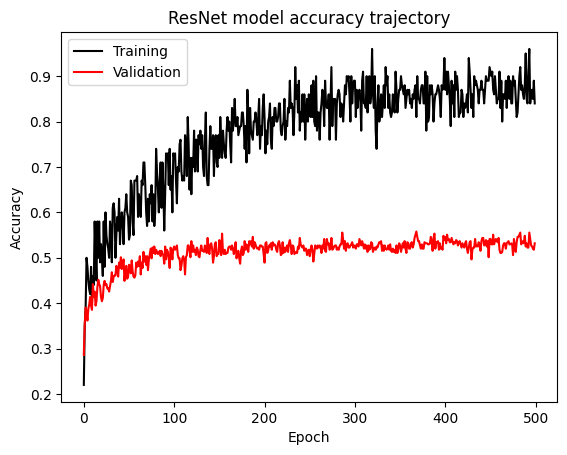

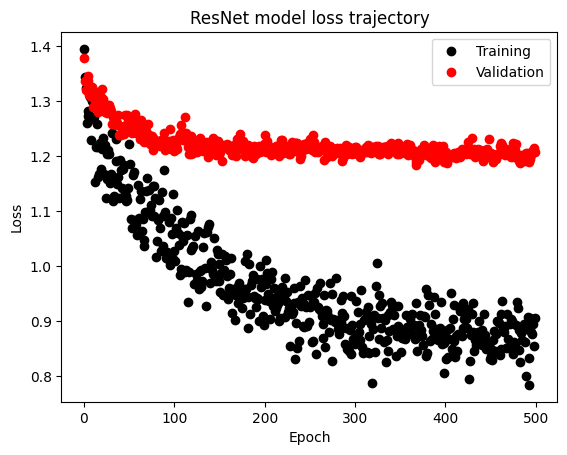

In [ ]:
# Change arrays and titles between models
plt.plot(np.arange(num_epochs),train_history_1,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_1,label='Validation',color='r')
plt.title('ResNet model accuracy trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_1,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_1,'o',label='Validation',color='r')
plt.title('ResNet model loss trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Part 2: Training and validating on Preprocessed Data

In [ ]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

# Preprocessing the dataset, may need to reload data at top
# pass only training data to train prep, val and test data to test prep

x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(x_test), test_data_prep(x_valid)

x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: torch.Size([6768, 22, 400])
Shape of validation set: torch.Size([423, 22, 400])
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([6768, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torc

In [ ]:
#Build the model
model2 = ResNet(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model2)
total_params = sum(p.numel() for p in model2.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNet(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1): Con

In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_2, val_history_2 = np.array([]), np.array([])
train_loss_hist_2, val_loss_hist_2 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = "/content/drive/MyDrive/C147_Final_Project/best_model_params_CNN"

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model2_params.pt')
    torch.save(model2.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model2.train()
        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model2(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        #Rename
        model2.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model2(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_2 = np.append(train_history_2, train_acc.item())
        val_history_2 = np.append(val_history_2, val_acc.item())
        train_loss_hist_2 = np.append(train_loss_hist_2, loss.item())
        val_loss_hist_2 = np.append(val_loss_hist_2, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model2.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-23-2e12e9fcd96c>:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:02<24:50,  2.99s/it]

Epoch 1 Finished!!!
Train acc: 0.260, Val acc: 0.374
Train loss: 1.368, Val loss: 1.344


  0%|          | 2/500 [00:05<24:34,  2.96s/it]

Epoch 2 Finished!!!
Train acc: 0.480, Val acc: 0.407
Train loss: 1.225, Val loss: 1.321


  1%|          | 3/500 [00:08<24:28,  2.96s/it]

Epoch 3 Finished!!!
Train acc: 0.400, Val acc: 0.430
Train loss: 1.327, Val loss: 1.288


  1%|          | 4/500 [00:11<24:20,  2.94s/it]

Epoch 4 Finished!!!
Train acc: 0.550, Val acc: 0.421
Train loss: 1.207, Val loss: 1.296


  1%|          | 5/500 [00:14<24:21,  2.95s/it]

Epoch 5 Finished!!!
Train acc: 0.550, Val acc: 0.447
Train loss: 1.154, Val loss: 1.283


  1%|          | 6/500 [00:17<24:19,  2.95s/it]

Epoch 6 Finished!!!
Train acc: 0.600, Val acc: 0.433
Train loss: 1.162, Val loss: 1.293


  1%|▏         | 7/500 [00:20<24:23,  2.97s/it]

Epoch 7 Finished!!!
Train acc: 0.540, Val acc: 0.452
Train loss: 1.186, Val loss: 1.279


  2%|▏         | 8/500 [00:23<24:23,  2.97s/it]

Epoch 8 Finished!!!
Train acc: 0.600, Val acc: 0.480
Train loss: 1.138, Val loss: 1.256


  2%|▏         | 9/500 [00:26<24:20,  2.97s/it]

Epoch 9 Finished!!!
Train acc: 0.560, Val acc: 0.480
Train loss: 1.173, Val loss: 1.256


  2%|▏         | 10/500 [00:29<24:29,  3.00s/it]

Epoch 10 Finished!!!
Train acc: 0.680, Val acc: 0.466
Train loss: 1.059, Val loss: 1.258


  2%|▏         | 11/500 [00:32<24:27,  3.00s/it]

Epoch 11 Finished!!!
Train acc: 0.640, Val acc: 0.480
Train loss: 1.072, Val loss: 1.246


  2%|▏         | 12/500 [00:35<24:26,  3.01s/it]

Epoch 12 Finished!!!
Train acc: 0.630, Val acc: 0.485
Train loss: 1.124, Val loss: 1.243


  3%|▎         | 13/500 [00:38<24:37,  3.03s/it]

Epoch 13 Finished!!!
Train acc: 0.700, Val acc: 0.499
Train loss: 1.057, Val loss: 1.237


  3%|▎         | 14/500 [00:41<24:37,  3.04s/it]

Epoch 14 Finished!!!
Train acc: 0.650, Val acc: 0.511
Train loss: 1.114, Val loss: 1.220


  3%|▎         | 15/500 [00:44<24:22,  3.02s/it]

Epoch 15 Finished!!!
Train acc: 0.630, Val acc: 0.494
Train loss: 1.089, Val loss: 1.233


  3%|▎         | 16/500 [00:47<24:11,  3.00s/it]

Epoch 16 Finished!!!
Train acc: 0.630, Val acc: 0.485
Train loss: 1.133, Val loss: 1.241


  3%|▎         | 17/500 [00:50<24:04,  2.99s/it]

Epoch 17 Finished!!!
Train acc: 0.640, Val acc: 0.518
Train loss: 1.118, Val loss: 1.221


  4%|▎         | 18/500 [00:53<23:53,  2.97s/it]

Epoch 18 Finished!!!
Train acc: 0.650, Val acc: 0.513
Train loss: 1.087, Val loss: 1.223


  4%|▍         | 19/500 [00:56<23:44,  2.96s/it]

Epoch 19 Finished!!!
Train acc: 0.690, Val acc: 0.496
Train loss: 1.033, Val loss: 1.240


  4%|▍         | 20/500 [00:59<23:41,  2.96s/it]

Epoch 20 Finished!!!
Train acc: 0.580, Val acc: 0.522
Train loss: 1.149, Val loss: 1.215


  4%|▍         | 21/500 [01:02<23:32,  2.95s/it]

Epoch 21 Finished!!!
Train acc: 0.620, Val acc: 0.506
Train loss: 1.110, Val loss: 1.225


  4%|▍         | 22/500 [01:05<23:25,  2.94s/it]

Epoch 22 Finished!!!
Train acc: 0.570, Val acc: 0.501
Train loss: 1.145, Val loss: 1.227


  5%|▍         | 23/500 [01:08<23:20,  2.94s/it]

Epoch 23 Finished!!!
Train acc: 0.620, Val acc: 0.518
Train loss: 1.129, Val loss: 1.223


  5%|▍         | 24/500 [01:11<23:15,  2.93s/it]

Epoch 24 Finished!!!
Train acc: 0.650, Val acc: 0.506
Train loss: 1.095, Val loss: 1.228


  5%|▌         | 25/500 [01:14<23:12,  2.93s/it]

Epoch 25 Finished!!!
Train acc: 0.710, Val acc: 0.513
Train loss: 1.034, Val loss: 1.222


  5%|▌         | 26/500 [01:17<23:08,  2.93s/it]

Epoch 26 Finished!!!
Train acc: 0.660, Val acc: 0.508
Train loss: 1.075, Val loss: 1.227


  5%|▌         | 27/500 [01:20<23:05,  2.93s/it]

Epoch 27 Finished!!!
Train acc: 0.570, Val acc: 0.515
Train loss: 1.169, Val loss: 1.217


  6%|▌         | 28/500 [01:23<23:02,  2.93s/it]

Epoch 28 Finished!!!
Train acc: 0.670, Val acc: 0.515
Train loss: 1.088, Val loss: 1.225


  6%|▌         | 29/500 [01:25<23:01,  2.93s/it]

Epoch 29 Finished!!!
Train acc: 0.720, Val acc: 0.513
Train loss: 1.022, Val loss: 1.214


  6%|▌         | 30/500 [01:28<22:58,  2.93s/it]

Epoch 30 Finished!!!
Train acc: 0.680, Val acc: 0.504
Train loss: 1.074, Val loss: 1.225


  6%|▌         | 31/500 [01:31<22:56,  2.94s/it]

Epoch 31 Finished!!!
Train acc: 0.680, Val acc: 0.513
Train loss: 1.062, Val loss: 1.226


  6%|▋         | 32/500 [01:34<22:54,  2.94s/it]

Epoch 32 Finished!!!
Train acc: 0.700, Val acc: 0.506
Train loss: 1.031, Val loss: 1.227


  7%|▋         | 33/500 [01:37<22:54,  2.94s/it]

Epoch 33 Finished!!!
Train acc: 0.660, Val acc: 0.506
Train loss: 1.082, Val loss: 1.225


  7%|▋         | 34/500 [01:40<22:53,  2.95s/it]

Epoch 34 Finished!!!
Train acc: 0.730, Val acc: 0.511
Train loss: 1.023, Val loss: 1.224


  7%|▋         | 35/500 [01:43<22:50,  2.95s/it]

Epoch 35 Finished!!!
Train acc: 0.600, Val acc: 0.513
Train loss: 1.122, Val loss: 1.219


  7%|▋         | 36/500 [01:46<22:49,  2.95s/it]

Epoch 36 Finished!!!
Train acc: 0.590, Val acc: 0.504
Train loss: 1.138, Val loss: 1.222


  7%|▋         | 37/500 [01:49<22:50,  2.96s/it]

Epoch 37 Finished!!!
Train acc: 0.720, Val acc: 0.525
Train loss: 1.016, Val loss: 1.215


  8%|▊         | 38/500 [01:52<22:46,  2.96s/it]

Epoch 38 Finished!!!
Train acc: 0.690, Val acc: 0.520
Train loss: 1.041, Val loss: 1.205


  8%|▊         | 39/500 [01:55<22:42,  2.96s/it]

Epoch 39 Finished!!!
Train acc: 0.770, Val acc: 0.506
Train loss: 0.967, Val loss: 1.231


  8%|▊         | 40/500 [01:58<22:41,  2.96s/it]

Epoch 40 Finished!!!
Train acc: 0.700, Val acc: 0.537
Train loss: 1.047, Val loss: 1.205


  8%|▊         | 41/500 [02:01<22:36,  2.96s/it]

Epoch 41 Finished!!!
Train acc: 0.730, Val acc: 0.530
Train loss: 1.008, Val loss: 1.207


  8%|▊         | 42/500 [02:04<22:33,  2.96s/it]

Epoch 42 Finished!!!
Train acc: 0.680, Val acc: 0.511
Train loss: 1.062, Val loss: 1.218


  9%|▊         | 43/500 [02:07<22:29,  2.95s/it]

Epoch 43 Finished!!!
Train acc: 0.760, Val acc: 0.506
Train loss: 0.977, Val loss: 1.218


  9%|▉         | 44/500 [02:10<22:25,  2.95s/it]

Epoch 44 Finished!!!
Train acc: 0.670, Val acc: 0.506
Train loss: 1.068, Val loss: 1.221


  9%|▉         | 45/500 [02:13<22:21,  2.95s/it]

Epoch 45 Finished!!!
Train acc: 0.670, Val acc: 0.527
Train loss: 1.055, Val loss: 1.202


  9%|▉         | 46/500 [02:16<22:17,  2.95s/it]

Epoch 46 Finished!!!
Train acc: 0.680, Val acc: 0.520
Train loss: 1.051, Val loss: 1.213


  9%|▉         | 47/500 [02:19<22:13,  2.94s/it]

Epoch 47 Finished!!!
Train acc: 0.700, Val acc: 0.492
Train loss: 1.043, Val loss: 1.239


 10%|▉         | 48/500 [02:22<22:09,  2.94s/it]

Epoch 48 Finished!!!
Train acc: 0.670, Val acc: 0.513
Train loss: 1.065, Val loss: 1.217


 10%|▉         | 49/500 [02:24<22:08,  2.95s/it]

Epoch 49 Finished!!!
Train acc: 0.740, Val acc: 0.541
Train loss: 0.985, Val loss: 1.202


 10%|█         | 50/500 [02:27<22:03,  2.94s/it]

Epoch 50 Finished!!!
Train acc: 0.820, Val acc: 0.508
Train loss: 0.947, Val loss: 1.223


 10%|█         | 51/500 [02:30<22:00,  2.94s/it]

Epoch 51 Finished!!!
Train acc: 0.720, Val acc: 0.532
Train loss: 1.017, Val loss: 1.206


 10%|█         | 52/500 [02:33<21:57,  2.94s/it]

Epoch 52 Finished!!!
Train acc: 0.860, Val acc: 0.532
Train loss: 0.903, Val loss: 1.199


 11%|█         | 53/500 [02:36<21:53,  2.94s/it]

Epoch 53 Finished!!!
Train acc: 0.760, Val acc: 0.520
Train loss: 0.970, Val loss: 1.215


 11%|█         | 54/500 [02:39<21:51,  2.94s/it]

Epoch 54 Finished!!!
Train acc: 0.750, Val acc: 0.504
Train loss: 0.998, Val loss: 1.224


 11%|█         | 55/500 [02:42<21:49,  2.94s/it]

Epoch 55 Finished!!!
Train acc: 0.770, Val acc: 0.537
Train loss: 0.958, Val loss: 1.200


 11%|█         | 56/500 [02:45<21:46,  2.94s/it]

Epoch 56 Finished!!!
Train acc: 0.780, Val acc: 0.513
Train loss: 0.964, Val loss: 1.218


 11%|█▏        | 57/500 [02:48<21:43,  2.94s/it]

Epoch 57 Finished!!!
Train acc: 0.700, Val acc: 0.520
Train loss: 1.030, Val loss: 1.209


 12%|█▏        | 58/500 [02:51<21:40,  2.94s/it]

Epoch 58 Finished!!!
Train acc: 0.780, Val acc: 0.513
Train loss: 0.954, Val loss: 1.213


 12%|█▏        | 59/500 [02:54<21:38,  2.94s/it]

Epoch 59 Finished!!!
Train acc: 0.720, Val acc: 0.520
Train loss: 1.012, Val loss: 1.211


 12%|█▏        | 60/500 [02:57<21:36,  2.95s/it]

Epoch 60 Finished!!!
Train acc: 0.800, Val acc: 0.532
Train loss: 0.948, Val loss: 1.199


 12%|█▏        | 61/500 [03:00<21:33,  2.95s/it]

Epoch 61 Finished!!!
Train acc: 0.830, Val acc: 0.541
Train loss: 0.925, Val loss: 1.187


 12%|█▏        | 62/500 [03:03<21:33,  2.95s/it]

Epoch 62 Finished!!!
Train acc: 0.740, Val acc: 0.544
Train loss: 1.012, Val loss: 1.189


 13%|█▎        | 63/500 [03:06<21:29,  2.95s/it]

Epoch 63 Finished!!!
Train acc: 0.720, Val acc: 0.532
Train loss: 1.020, Val loss: 1.206


 13%|█▎        | 64/500 [03:09<21:27,  2.95s/it]

Epoch 64 Finished!!!
Train acc: 0.810, Val acc: 0.522
Train loss: 0.927, Val loss: 1.205


 13%|█▎        | 65/500 [03:12<21:23,  2.95s/it]

Epoch 65 Finished!!!
Train acc: 0.730, Val acc: 0.534
Train loss: 1.001, Val loss: 1.200


 13%|█▎        | 66/500 [03:15<21:19,  2.95s/it]

Epoch 66 Finished!!!
Train acc: 0.790, Val acc: 0.532
Train loss: 0.952, Val loss: 1.202


 13%|█▎        | 67/500 [03:17<21:16,  2.95s/it]

Epoch 67 Finished!!!
Train acc: 0.800, Val acc: 0.544
Train loss: 0.941, Val loss: 1.192


 14%|█▎        | 68/500 [03:20<21:13,  2.95s/it]

Epoch 68 Finished!!!
Train acc: 0.730, Val acc: 0.534
Train loss: 1.008, Val loss: 1.199


 14%|█▍        | 69/500 [03:23<21:09,  2.95s/it]

Epoch 69 Finished!!!
Train acc: 0.750, Val acc: 0.539
Train loss: 0.991, Val loss: 1.199


 14%|█▍        | 70/500 [03:26<21:06,  2.95s/it]

Epoch 70 Finished!!!
Train acc: 0.760, Val acc: 0.527
Train loss: 0.972, Val loss: 1.195


 14%|█▍        | 71/500 [03:29<21:03,  2.95s/it]

Epoch 71 Finished!!!
Train acc: 0.800, Val acc: 0.527
Train loss: 0.936, Val loss: 1.209


 14%|█▍        | 72/500 [03:32<21:00,  2.94s/it]

Epoch 72 Finished!!!
Train acc: 0.760, Val acc: 0.544
Train loss: 0.980, Val loss: 1.192


 15%|█▍        | 73/500 [03:35<21:01,  2.95s/it]

Epoch 73 Finished!!!
Train acc: 0.780, Val acc: 0.551
Train loss: 0.966, Val loss: 1.192


 15%|█▍        | 74/500 [03:38<20:59,  2.96s/it]

Epoch 74 Finished!!!
Train acc: 0.880, Val acc: 0.556
Train loss: 0.878, Val loss: 1.184


 15%|█▌        | 75/500 [03:41<20:53,  2.95s/it]

Epoch 75 Finished!!!
Train acc: 0.850, Val acc: 0.532
Train loss: 0.900, Val loss: 1.199


 15%|█▌        | 76/500 [03:44<20:49,  2.95s/it]

Epoch 76 Finished!!!
Train acc: 0.770, Val acc: 0.499
Train loss: 0.961, Val loss: 1.227


 15%|█▌        | 77/500 [03:47<20:46,  2.95s/it]

Epoch 77 Finished!!!
Train acc: 0.770, Val acc: 0.520
Train loss: 0.967, Val loss: 1.214


 16%|█▌        | 78/500 [03:50<20:42,  2.94s/it]

Epoch 78 Finished!!!
Train acc: 0.760, Val acc: 0.556
Train loss: 0.986, Val loss: 1.182


 16%|█▌        | 79/500 [03:53<20:38,  2.94s/it]

Epoch 79 Finished!!!
Train acc: 0.770, Val acc: 0.541
Train loss: 0.970, Val loss: 1.194


 16%|█▌        | 80/500 [03:56<20:35,  2.94s/it]

Epoch 80 Finished!!!
Train acc: 0.830, Val acc: 0.551
Train loss: 0.924, Val loss: 1.189


 16%|█▌        | 81/500 [03:59<20:32,  2.94s/it]

Epoch 81 Finished!!!
Train acc: 0.810, Val acc: 0.541
Train loss: 0.954, Val loss: 1.202


 16%|█▋        | 82/500 [04:02<20:29,  2.94s/it]

Epoch 82 Finished!!!
Train acc: 0.830, Val acc: 0.527
Train loss: 0.913, Val loss: 1.209


 17%|█▋        | 83/500 [04:05<20:25,  2.94s/it]

Epoch 83 Finished!!!
Train acc: 0.770, Val acc: 0.539
Train loss: 0.976, Val loss: 1.194


 17%|█▋        | 84/500 [04:08<20:22,  2.94s/it]

Epoch 84 Finished!!!
Train acc: 0.740, Val acc: 0.532
Train loss: 0.990, Val loss: 1.202


 17%|█▋        | 85/500 [04:10<20:20,  2.94s/it]

Epoch 85 Finished!!!
Train acc: 0.870, Val acc: 0.546
Train loss: 0.877, Val loss: 1.194


 17%|█▋        | 86/500 [04:13<20:17,  2.94s/it]

Epoch 86 Finished!!!
Train acc: 0.870, Val acc: 0.520
Train loss: 0.891, Val loss: 1.210


 17%|█▋        | 87/500 [04:16<20:14,  2.94s/it]

Epoch 87 Finished!!!
Train acc: 0.890, Val acc: 0.537
Train loss: 0.857, Val loss: 1.199


 18%|█▊        | 88/500 [04:19<20:11,  2.94s/it]

Epoch 88 Finished!!!
Train acc: 0.830, Val acc: 0.518
Train loss: 0.921, Val loss: 1.207


 18%|█▊        | 89/500 [04:22<20:08,  2.94s/it]

Epoch 89 Finished!!!
Train acc: 0.800, Val acc: 0.548
Train loss: 0.946, Val loss: 1.195


 18%|█▊        | 90/500 [04:25<20:06,  2.94s/it]

Epoch 90 Finished!!!
Train acc: 0.870, Val acc: 0.546
Train loss: 0.887, Val loss: 1.189


 18%|█▊        | 91/500 [04:28<20:05,  2.95s/it]

Epoch 91 Finished!!!
Train acc: 0.900, Val acc: 0.560
Train loss: 0.855, Val loss: 1.178


 18%|█▊        | 92/500 [04:31<20:00,  2.94s/it]

Epoch 92 Finished!!!
Train acc: 0.820, Val acc: 0.534
Train loss: 0.927, Val loss: 1.198


 19%|█▊        | 93/500 [04:34<19:57,  2.94s/it]

Epoch 93 Finished!!!
Train acc: 0.790, Val acc: 0.558
Train loss: 0.942, Val loss: 1.183


 19%|█▉        | 94/500 [04:37<19:55,  2.95s/it]

Epoch 94 Finished!!!
Train acc: 0.790, Val acc: 0.551
Train loss: 0.948, Val loss: 1.193


 19%|█▉        | 95/500 [04:40<19:51,  2.94s/it]

Epoch 95 Finished!!!
Train acc: 0.780, Val acc: 0.532
Train loss: 0.961, Val loss: 1.199


 19%|█▉        | 96/500 [04:43<19:48,  2.94s/it]

Epoch 96 Finished!!!
Train acc: 0.770, Val acc: 0.530
Train loss: 0.956, Val loss: 1.200


 19%|█▉        | 97/500 [04:46<19:45,  2.94s/it]

Epoch 97 Finished!!!
Train acc: 0.890, Val acc: 0.501
Train loss: 0.860, Val loss: 1.219


 20%|█▉        | 98/500 [04:49<19:43,  2.95s/it]

Epoch 98 Finished!!!
Train acc: 0.850, Val acc: 0.532
Train loss: 0.893, Val loss: 1.199


 20%|█▉        | 99/500 [04:52<19:41,  2.95s/it]

Epoch 99 Finished!!!
Train acc: 0.790, Val acc: 0.530
Train loss: 0.946, Val loss: 1.203


 20%|██        | 100/500 [04:55<19:37,  2.94s/it]

Epoch 100 Finished!!!
Train acc: 0.870, Val acc: 0.544
Train loss: 0.881, Val loss: 1.189


 20%|██        | 101/500 [04:58<19:34,  2.94s/it]

Epoch 101 Finished!!!
Train acc: 0.810, Val acc: 0.527
Train loss: 0.936, Val loss: 1.208


 20%|██        | 102/500 [05:01<19:32,  2.95s/it]

Epoch 102 Finished!!!
Train acc: 0.820, Val acc: 0.546
Train loss: 0.942, Val loss: 1.190


 21%|██        | 103/500 [05:03<19:29,  2.95s/it]

Epoch 103 Finished!!!
Train acc: 0.920, Val acc: 0.522
Train loss: 0.826, Val loss: 1.207


 21%|██        | 104/500 [05:06<19:26,  2.95s/it]

Epoch 104 Finished!!!
Train acc: 0.890, Val acc: 0.539
Train loss: 0.848, Val loss: 1.198


 21%|██        | 105/500 [05:09<19:23,  2.94s/it]

Epoch 105 Finished!!!
Train acc: 0.850, Val acc: 0.546
Train loss: 0.896, Val loss: 1.189


 21%|██        | 106/500 [05:12<19:20,  2.94s/it]

Epoch 106 Finished!!!
Train acc: 0.880, Val acc: 0.558
Train loss: 0.875, Val loss: 1.181


 21%|██▏       | 107/500 [05:15<19:18,  2.95s/it]

Epoch 107 Finished!!!
Train acc: 0.900, Val acc: 0.525
Train loss: 0.862, Val loss: 1.209


 22%|██▏       | 108/500 [05:18<19:15,  2.95s/it]

Epoch 108 Finished!!!
Train acc: 0.840, Val acc: 0.525
Train loss: 0.894, Val loss: 1.203


 22%|██▏       | 109/500 [05:21<19:12,  2.95s/it]

Epoch 109 Finished!!!
Train acc: 0.900, Val acc: 0.541
Train loss: 0.852, Val loss: 1.190


 22%|██▏       | 110/500 [05:24<19:09,  2.95s/it]

Epoch 110 Finished!!!
Train acc: 0.820, Val acc: 0.527
Train loss: 0.929, Val loss: 1.206


 22%|██▏       | 111/500 [05:27<19:06,  2.95s/it]

Epoch 111 Finished!!!
Train acc: 0.850, Val acc: 0.525
Train loss: 0.892, Val loss: 1.206


 22%|██▏       | 112/500 [05:30<19:04,  2.95s/it]

Epoch 112 Finished!!!
Train acc: 0.860, Val acc: 0.520
Train loss: 0.885, Val loss: 1.212


 23%|██▎       | 113/500 [05:33<19:03,  2.96s/it]

Epoch 113 Finished!!!
Train acc: 0.870, Val acc: 0.565
Train loss: 0.882, Val loss: 1.173


 23%|██▎       | 114/500 [05:36<18:58,  2.95s/it]

Epoch 114 Finished!!!
Train acc: 0.910, Val acc: 0.539
Train loss: 0.837, Val loss: 1.197


 23%|██▎       | 115/500 [05:39<18:54,  2.95s/it]

Epoch 115 Finished!!!
Train acc: 0.870, Val acc: 0.546
Train loss: 0.866, Val loss: 1.198


 23%|██▎       | 116/500 [05:42<18:52,  2.95s/it]

Epoch 116 Finished!!!
Train acc: 0.880, Val acc: 0.534
Train loss: 0.869, Val loss: 1.205


 23%|██▎       | 117/500 [05:45<18:49,  2.95s/it]

Epoch 117 Finished!!!
Train acc: 0.900, Val acc: 0.539
Train loss: 0.836, Val loss: 1.195


 24%|██▎       | 118/500 [05:48<18:45,  2.95s/it]

Epoch 118 Finished!!!
Train acc: 0.870, Val acc: 0.553
Train loss: 0.878, Val loss: 1.187


 24%|██▍       | 119/500 [05:51<18:42,  2.95s/it]

Epoch 119 Finished!!!
Train acc: 0.890, Val acc: 0.515
Train loss: 0.860, Val loss: 1.217


 24%|██▍       | 120/500 [05:54<18:40,  2.95s/it]

Epoch 120 Finished!!!
Train acc: 0.880, Val acc: 0.532
Train loss: 0.869, Val loss: 1.200


 24%|██▍       | 121/500 [05:57<18:37,  2.95s/it]

Epoch 121 Finished!!!
Train acc: 0.850, Val acc: 0.530
Train loss: 0.891, Val loss: 1.206


 24%|██▍       | 122/500 [05:59<18:33,  2.95s/it]

Epoch 122 Finished!!!
Train acc: 0.870, Val acc: 0.546
Train loss: 0.876, Val loss: 1.196


 25%|██▍       | 123/500 [06:02<18:30,  2.95s/it]

Epoch 123 Finished!!!
Train acc: 0.860, Val acc: 0.532
Train loss: 0.892, Val loss: 1.201


 25%|██▍       | 124/500 [06:05<18:28,  2.95s/it]

Epoch 124 Finished!!!
Train acc: 0.880, Val acc: 0.522
Train loss: 0.868, Val loss: 1.211


 25%|██▌       | 125/500 [06:08<18:25,  2.95s/it]

Epoch 125 Finished!!!
Train acc: 0.910, Val acc: 0.520
Train loss: 0.830, Val loss: 1.215


 25%|██▌       | 126/500 [06:11<18:22,  2.95s/it]

Epoch 126 Finished!!!
Train acc: 0.850, Val acc: 0.520
Train loss: 0.899, Val loss: 1.213


 25%|██▌       | 127/500 [06:14<18:19,  2.95s/it]

Epoch 127 Finished!!!
Train acc: 0.880, Val acc: 0.537
Train loss: 0.868, Val loss: 1.193


 26%|██▌       | 128/500 [06:17<18:16,  2.95s/it]

Epoch 128 Finished!!!
Train acc: 0.880, Val acc: 0.548
Train loss: 0.865, Val loss: 1.193


 26%|██▌       | 129/500 [06:20<18:15,  2.95s/it]

Epoch 129 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.797, Val loss: 1.204


 26%|██▌       | 130/500 [06:23<18:12,  2.95s/it]

Epoch 130 Finished!!!
Train acc: 0.870, Val acc: 0.560
Train loss: 0.871, Val loss: 1.185


 26%|██▌       | 131/500 [06:26<18:09,  2.95s/it]

Epoch 131 Finished!!!
Train acc: 0.840, Val acc: 0.539
Train loss: 0.889, Val loss: 1.197


 26%|██▋       | 132/500 [06:29<18:06,  2.95s/it]

Epoch 132 Finished!!!
Train acc: 0.910, Val acc: 0.527
Train loss: 0.840, Val loss: 1.203


 27%|██▋       | 133/500 [06:32<18:05,  2.96s/it]

Epoch 133 Finished!!!
Train acc: 0.860, Val acc: 0.537
Train loss: 0.888, Val loss: 1.192


 27%|██▋       | 134/500 [06:35<18:03,  2.96s/it]

Epoch 134 Finished!!!
Train acc: 0.880, Val acc: 0.541
Train loss: 0.859, Val loss: 1.193


 27%|██▋       | 135/500 [06:38<17:59,  2.96s/it]

Epoch 135 Finished!!!
Train acc: 0.930, Val acc: 0.539
Train loss: 0.816, Val loss: 1.187


 27%|██▋       | 136/500 [06:41<17:55,  2.95s/it]

Epoch 136 Finished!!!
Train acc: 0.900, Val acc: 0.525
Train loss: 0.842, Val loss: 1.209


 27%|██▋       | 137/500 [06:44<17:51,  2.95s/it]

Epoch 137 Finished!!!
Train acc: 0.900, Val acc: 0.525
Train loss: 0.844, Val loss: 1.208


 28%|██▊       | 138/500 [06:47<17:47,  2.95s/it]

Epoch 138 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.810, Val loss: 1.198


 28%|██▊       | 139/500 [06:50<17:45,  2.95s/it]

Epoch 139 Finished!!!
Train acc: 0.890, Val acc: 0.541
Train loss: 0.855, Val loss: 1.193


 28%|██▊       | 140/500 [06:53<17:41,  2.95s/it]

Epoch 140 Finished!!!
Train acc: 0.900, Val acc: 0.537
Train loss: 0.839, Val loss: 1.202


 28%|██▊       | 141/500 [06:56<17:37,  2.95s/it]

Epoch 141 Finished!!!
Train acc: 0.900, Val acc: 0.560
Train loss: 0.846, Val loss: 1.182


 28%|██▊       | 142/500 [06:59<17:34,  2.95s/it]

Epoch 142 Finished!!!
Train acc: 0.920, Val acc: 0.527
Train loss: 0.819, Val loss: 1.199


 29%|██▊       | 143/500 [07:01<17:33,  2.95s/it]

Epoch 143 Finished!!!
Train acc: 0.890, Val acc: 0.537
Train loss: 0.861, Val loss: 1.205


 29%|██▉       | 144/500 [07:04<17:29,  2.95s/it]

Epoch 144 Finished!!!
Train acc: 0.910, Val acc: 0.520
Train loss: 0.828, Val loss: 1.213


 29%|██▉       | 145/500 [07:07<17:26,  2.95s/it]

Epoch 145 Finished!!!
Train acc: 0.940, Val acc: 0.527
Train loss: 0.810, Val loss: 1.204


 29%|██▉       | 146/500 [07:10<17:23,  2.95s/it]

Epoch 146 Finished!!!
Train acc: 0.910, Val acc: 0.534
Train loss: 0.836, Val loss: 1.202


 29%|██▉       | 147/500 [07:13<17:20,  2.95s/it]

Epoch 147 Finished!!!
Train acc: 0.850, Val acc: 0.532
Train loss: 0.884, Val loss: 1.201


 30%|██▉       | 148/500 [07:16<17:17,  2.95s/it]

Epoch 148 Finished!!!
Train acc: 0.900, Val acc: 0.553
Train loss: 0.842, Val loss: 1.190


 30%|██▉       | 149/500 [07:19<17:14,  2.95s/it]

Epoch 149 Finished!!!
Train acc: 0.920, Val acc: 0.551
Train loss: 0.823, Val loss: 1.188


 30%|███       | 150/500 [07:22<17:10,  2.94s/it]

Epoch 150 Finished!!!
Train acc: 0.910, Val acc: 0.534
Train loss: 0.836, Val loss: 1.197


 30%|███       | 151/500 [07:25<17:07,  2.94s/it]

Epoch 151 Finished!!!
Train acc: 0.870, Val acc: 0.541
Train loss: 0.874, Val loss: 1.197


 30%|███       | 152/500 [07:28<17:05,  2.95s/it]

Epoch 152 Finished!!!
Train acc: 0.930, Val acc: 0.534
Train loss: 0.826, Val loss: 1.195


 31%|███       | 153/500 [07:31<17:02,  2.95s/it]

Epoch 153 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.810, Val loss: 1.200


 31%|███       | 154/500 [07:34<16:59,  2.95s/it]

Epoch 154 Finished!!!
Train acc: 0.900, Val acc: 0.560
Train loss: 0.836, Val loss: 1.180


 31%|███       | 155/500 [07:37<16:55,  2.94s/it]

Epoch 155 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.807, Val loss: 1.187


 31%|███       | 156/500 [07:40<16:53,  2.95s/it]

Epoch 156 Finished!!!
Train acc: 0.940, Val acc: 0.539
Train loss: 0.803, Val loss: 1.199


 31%|███▏      | 157/500 [07:43<16:50,  2.95s/it]

Epoch 157 Finished!!!
Train acc: 0.840, Val acc: 0.544
Train loss: 0.907, Val loss: 1.195


 32%|███▏      | 158/500 [07:46<16:47,  2.95s/it]

Epoch 158 Finished!!!
Train acc: 0.930, Val acc: 0.520
Train loss: 0.810, Val loss: 1.219


 32%|███▏      | 159/500 [07:49<16:44,  2.95s/it]

Epoch 159 Finished!!!
Train acc: 0.970, Val acc: 0.544
Train loss: 0.774, Val loss: 1.194


 32%|███▏      | 160/500 [07:52<16:41,  2.94s/it]

Epoch 160 Finished!!!
Train acc: 0.920, Val acc: 0.539
Train loss: 0.826, Val loss: 1.190


 32%|███▏      | 161/500 [07:54<16:38,  2.95s/it]

Epoch 161 Finished!!!
Train acc: 0.950, Val acc: 0.541
Train loss: 0.798, Val loss: 1.193


 32%|███▏      | 162/500 [07:57<16:35,  2.95s/it]

Epoch 162 Finished!!!
Train acc: 0.910, Val acc: 0.541
Train loss: 0.835, Val loss: 1.197


 33%|███▎      | 163/500 [08:00<16:32,  2.94s/it]

Epoch 163 Finished!!!
Train acc: 0.920, Val acc: 0.541
Train loss: 0.830, Val loss: 1.203


 33%|███▎      | 164/500 [08:03<16:30,  2.95s/it]

Epoch 164 Finished!!!
Train acc: 0.920, Val acc: 0.544
Train loss: 0.821, Val loss: 1.190


 33%|███▎      | 165/500 [08:06<16:27,  2.95s/it]

Epoch 165 Finished!!!
Train acc: 0.860, Val acc: 0.546
Train loss: 0.883, Val loss: 1.192


 33%|███▎      | 166/500 [08:09<16:24,  2.95s/it]

Epoch 166 Finished!!!
Train acc: 0.870, Val acc: 0.548
Train loss: 0.882, Val loss: 1.189


 33%|███▎      | 167/500 [08:12<16:21,  2.95s/it]

Epoch 167 Finished!!!
Train acc: 0.860, Val acc: 0.518
Train loss: 0.881, Val loss: 1.213


 34%|███▎      | 168/500 [08:15<16:18,  2.95s/it]

Epoch 168 Finished!!!
Train acc: 0.870, Val acc: 0.527
Train loss: 0.865, Val loss: 1.207


 34%|███▍      | 169/500 [08:18<16:15,  2.95s/it]

Epoch 169 Finished!!!
Train acc: 0.890, Val acc: 0.551
Train loss: 0.849, Val loss: 1.189


 34%|███▍      | 170/500 [08:21<16:13,  2.95s/it]

Epoch 170 Finished!!!
Train acc: 0.860, Val acc: 0.556
Train loss: 0.882, Val loss: 1.190


 34%|███▍      | 171/500 [08:24<16:09,  2.95s/it]

Epoch 171 Finished!!!
Train acc: 0.920, Val acc: 0.537
Train loss: 0.824, Val loss: 1.195


 34%|███▍      | 172/500 [08:27<16:06,  2.95s/it]

Epoch 172 Finished!!!
Train acc: 0.930, Val acc: 0.551
Train loss: 0.811, Val loss: 1.189


 35%|███▍      | 173/500 [08:30<16:03,  2.95s/it]

Epoch 173 Finished!!!
Train acc: 0.900, Val acc: 0.532
Train loss: 0.845, Val loss: 1.203


 35%|███▍      | 174/500 [08:33<16:01,  2.95s/it]

Epoch 174 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.794, Val loss: 1.186


 35%|███▌      | 175/500 [08:36<15:57,  2.95s/it]

Epoch 175 Finished!!!
Train acc: 0.890, Val acc: 0.556
Train loss: 0.849, Val loss: 1.181


 35%|███▌      | 176/500 [08:39<15:54,  2.95s/it]

Epoch 176 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.803, Val loss: 1.192


 35%|███▌      | 177/500 [08:42<15:51,  2.95s/it]

Epoch 177 Finished!!!
Train acc: 0.900, Val acc: 0.522
Train loss: 0.844, Val loss: 1.212


 36%|███▌      | 178/500 [08:45<15:49,  2.95s/it]

Epoch 178 Finished!!!
Train acc: 0.930, Val acc: 0.532
Train loss: 0.828, Val loss: 1.200


 36%|███▌      | 179/500 [08:48<15:46,  2.95s/it]

Epoch 179 Finished!!!
Train acc: 0.900, Val acc: 0.527
Train loss: 0.838, Val loss: 1.203


 36%|███▌      | 180/500 [08:50<15:43,  2.95s/it]

Epoch 180 Finished!!!
Train acc: 0.890, Val acc: 0.537
Train loss: 0.847, Val loss: 1.196


 36%|███▌      | 181/500 [08:53<15:39,  2.95s/it]

Epoch 181 Finished!!!
Train acc: 0.910, Val acc: 0.541
Train loss: 0.835, Val loss: 1.196


 36%|███▋      | 182/500 [08:56<15:36,  2.95s/it]

Epoch 182 Finished!!!
Train acc: 0.890, Val acc: 0.534
Train loss: 0.842, Val loss: 1.203


 37%|███▋      | 183/500 [08:59<15:34,  2.95s/it]

Epoch 183 Finished!!!
Train acc: 0.910, Val acc: 0.539
Train loss: 0.829, Val loss: 1.197


 37%|███▋      | 184/500 [09:02<15:31,  2.95s/it]

Epoch 184 Finished!!!
Train acc: 0.900, Val acc: 0.541
Train loss: 0.846, Val loss: 1.196


 37%|███▋      | 185/500 [09:05<15:28,  2.95s/it]

Epoch 185 Finished!!!
Train acc: 0.910, Val acc: 0.537
Train loss: 0.830, Val loss: 1.194


 37%|███▋      | 186/500 [09:08<15:25,  2.95s/it]

Epoch 186 Finished!!!
Train acc: 0.890, Val acc: 0.525
Train loss: 0.838, Val loss: 1.210


 37%|███▋      | 187/500 [09:11<15:23,  2.95s/it]

Epoch 187 Finished!!!
Train acc: 0.910, Val acc: 0.539
Train loss: 0.833, Val loss: 1.194


 38%|███▊      | 188/500 [09:14<15:19,  2.95s/it]

Epoch 188 Finished!!!
Train acc: 0.880, Val acc: 0.556
Train loss: 0.864, Val loss: 1.178


 38%|███▊      | 189/500 [09:17<15:16,  2.95s/it]

Epoch 189 Finished!!!
Train acc: 0.900, Val acc: 0.525
Train loss: 0.849, Val loss: 1.211


 38%|███▊      | 190/500 [09:20<15:13,  2.95s/it]

Epoch 190 Finished!!!
Train acc: 0.890, Val acc: 0.537
Train loss: 0.854, Val loss: 1.201


 38%|███▊      | 191/500 [09:23<15:11,  2.95s/it]

Epoch 191 Finished!!!
Train acc: 0.850, Val acc: 0.556
Train loss: 0.895, Val loss: 1.181


 38%|███▊      | 192/500 [09:26<15:08,  2.95s/it]

Epoch 192 Finished!!!
Train acc: 0.940, Val acc: 0.522
Train loss: 0.806, Val loss: 1.209


 39%|███▊      | 193/500 [09:29<15:05,  2.95s/it]

Epoch 193 Finished!!!
Train acc: 0.880, Val acc: 0.541
Train loss: 0.856, Val loss: 1.193


 39%|███▉      | 194/500 [09:32<15:02,  2.95s/it]

Epoch 194 Finished!!!
Train acc: 0.920, Val acc: 0.530
Train loss: 0.828, Val loss: 1.196


 39%|███▉      | 195/500 [09:35<14:59,  2.95s/it]

Epoch 195 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.787, Val loss: 1.195


 39%|███▉      | 196/500 [09:38<14:56,  2.95s/it]

Epoch 196 Finished!!!
Train acc: 0.870, Val acc: 0.553
Train loss: 0.870, Val loss: 1.185


 39%|███▉      | 197/500 [09:41<14:57,  2.96s/it]

Epoch 197 Finished!!!
Train acc: 0.910, Val acc: 0.567
Train loss: 0.830, Val loss: 1.169


 40%|███▉      | 198/500 [09:44<15:08,  3.01s/it]

Epoch 198 Finished!!!
Train acc: 0.940, Val acc: 0.525
Train loss: 0.809, Val loss: 1.204


 40%|███▉      | 199/500 [09:47<15:00,  2.99s/it]

Epoch 199 Finished!!!
Train acc: 0.930, Val acc: 0.544
Train loss: 0.805, Val loss: 1.196


 40%|████      | 200/500 [09:50<14:54,  2.98s/it]

Epoch 200 Finished!!!
Train acc: 0.930, Val acc: 0.558
Train loss: 0.823, Val loss: 1.191


 40%|████      | 201/500 [09:53<14:48,  2.97s/it]

Epoch 201 Finished!!!
Train acc: 0.930, Val acc: 0.556
Train loss: 0.828, Val loss: 1.182


 40%|████      | 202/500 [09:56<14:43,  2.96s/it]

Epoch 202 Finished!!!
Train acc: 0.880, Val acc: 0.548
Train loss: 0.865, Val loss: 1.190


 41%|████      | 203/500 [09:59<14:38,  2.96s/it]

Epoch 203 Finished!!!
Train acc: 0.900, Val acc: 0.515
Train loss: 0.843, Val loss: 1.210


 41%|████      | 204/500 [10:01<14:35,  2.96s/it]

Epoch 204 Finished!!!
Train acc: 0.900, Val acc: 0.520
Train loss: 0.852, Val loss: 1.209


 41%|████      | 205/500 [10:04<14:32,  2.96s/it]

Epoch 205 Finished!!!
Train acc: 0.920, Val acc: 0.525
Train loss: 0.824, Val loss: 1.208


 41%|████      | 206/500 [10:07<14:28,  2.95s/it]

Epoch 206 Finished!!!
Train acc: 0.890, Val acc: 0.537
Train loss: 0.861, Val loss: 1.191


 41%|████▏     | 207/500 [10:10<14:24,  2.95s/it]

Epoch 207 Finished!!!
Train acc: 0.920, Val acc: 0.551
Train loss: 0.828, Val loss: 1.186


 42%|████▏     | 208/500 [10:13<14:21,  2.95s/it]

Epoch 208 Finished!!!
Train acc: 0.880, Val acc: 0.539
Train loss: 0.865, Val loss: 1.192


 42%|████▏     | 209/500 [10:16<14:18,  2.95s/it]

Epoch 209 Finished!!!
Train acc: 0.890, Val acc: 0.567
Train loss: 0.850, Val loss: 1.173


 42%|████▏     | 210/500 [10:19<14:15,  2.95s/it]

Epoch 210 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.789, Val loss: 1.183


 42%|████▏     | 211/500 [10:22<14:12,  2.95s/it]

Epoch 211 Finished!!!
Train acc: 0.910, Val acc: 0.534
Train loss: 0.833, Val loss: 1.196


 42%|████▏     | 212/500 [10:25<14:09,  2.95s/it]

Epoch 212 Finished!!!
Train acc: 0.910, Val acc: 0.522
Train loss: 0.830, Val loss: 1.217


 43%|████▎     | 213/500 [10:28<14:06,  2.95s/it]

Epoch 213 Finished!!!
Train acc: 0.900, Val acc: 0.527
Train loss: 0.839, Val loss: 1.206


 43%|████▎     | 214/500 [10:31<14:03,  2.95s/it]

Epoch 214 Finished!!!
Train acc: 0.890, Val acc: 0.551
Train loss: 0.853, Val loss: 1.190


 43%|████▎     | 215/500 [10:34<13:59,  2.95s/it]

Epoch 215 Finished!!!
Train acc: 0.910, Val acc: 0.546
Train loss: 0.836, Val loss: 1.191


 43%|████▎     | 216/500 [10:37<13:56,  2.95s/it]

Epoch 216 Finished!!!
Train acc: 0.930, Val acc: 0.532
Train loss: 0.814, Val loss: 1.204


 43%|████▎     | 217/500 [10:40<13:53,  2.95s/it]

Epoch 217 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.801, Val loss: 1.201


 44%|████▎     | 218/500 [10:43<13:50,  2.95s/it]

Epoch 218 Finished!!!
Train acc: 0.880, Val acc: 0.539
Train loss: 0.858, Val loss: 1.200


 44%|████▍     | 219/500 [10:46<13:47,  2.95s/it]

Epoch 219 Finished!!!
Train acc: 0.920, Val acc: 0.530
Train loss: 0.814, Val loss: 1.205


 44%|████▍     | 220/500 [10:49<13:44,  2.94s/it]

Epoch 220 Finished!!!
Train acc: 0.890, Val acc: 0.518
Train loss: 0.849, Val loss: 1.212


 44%|████▍     | 221/500 [10:52<13:41,  2.94s/it]

Epoch 221 Finished!!!
Train acc: 0.920, Val acc: 0.537
Train loss: 0.826, Val loss: 1.201


 44%|████▍     | 222/500 [10:55<13:38,  2.94s/it]

Epoch 222 Finished!!!
Train acc: 0.920, Val acc: 0.539
Train loss: 0.823, Val loss: 1.196


 45%|████▍     | 223/500 [10:57<13:35,  2.94s/it]

Epoch 223 Finished!!!
Train acc: 0.930, Val acc: 0.548
Train loss: 0.816, Val loss: 1.194


 45%|████▍     | 224/500 [11:00<13:32,  2.94s/it]

Epoch 224 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.778, Val loss: 1.193


 45%|████▌     | 225/500 [11:03<13:29,  2.94s/it]

Epoch 225 Finished!!!
Train acc: 0.910, Val acc: 0.544
Train loss: 0.839, Val loss: 1.196


 45%|████▌     | 226/500 [11:06<13:27,  2.95s/it]

Epoch 226 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.809, Val loss: 1.196


 45%|████▌     | 227/500 [11:09<13:24,  2.95s/it]

Epoch 227 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.792, Val loss: 1.193


 46%|████▌     | 228/500 [11:12<13:20,  2.94s/it]

Epoch 228 Finished!!!
Train acc: 0.830, Val acc: 0.539
Train loss: 0.913, Val loss: 1.199


 46%|████▌     | 229/500 [11:15<13:17,  2.94s/it]

Epoch 229 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.809, Val loss: 1.187


 46%|████▌     | 230/500 [11:18<13:15,  2.95s/it]

Epoch 230 Finished!!!
Train acc: 0.930, Val acc: 0.541
Train loss: 0.812, Val loss: 1.193


 46%|████▌     | 231/500 [11:21<13:12,  2.95s/it]

Epoch 231 Finished!!!
Train acc: 0.910, Val acc: 0.525
Train loss: 0.832, Val loss: 1.212


 46%|████▋     | 232/500 [11:24<13:09,  2.95s/it]

Epoch 232 Finished!!!
Train acc: 0.890, Val acc: 0.530
Train loss: 0.848, Val loss: 1.207


 47%|████▋     | 233/500 [11:27<13:06,  2.95s/it]

Epoch 233 Finished!!!
Train acc: 0.910, Val acc: 0.546
Train loss: 0.829, Val loss: 1.189


 47%|████▋     | 234/500 [11:30<13:03,  2.94s/it]

Epoch 234 Finished!!!
Train acc: 0.890, Val acc: 0.534
Train loss: 0.852, Val loss: 1.204


 47%|████▋     | 235/500 [11:33<13:00,  2.95s/it]

Epoch 235 Finished!!!
Train acc: 0.910, Val acc: 0.527
Train loss: 0.828, Val loss: 1.203


 47%|████▋     | 236/500 [11:36<12:57,  2.94s/it]

Epoch 236 Finished!!!
Train acc: 0.910, Val acc: 0.541
Train loss: 0.826, Val loss: 1.187


 47%|████▋     | 237/500 [11:39<12:54,  2.94s/it]

Epoch 237 Finished!!!
Train acc: 0.910, Val acc: 0.539
Train loss: 0.823, Val loss: 1.196


 48%|████▊     | 238/500 [11:42<12:51,  2.94s/it]

Epoch 238 Finished!!!
Train acc: 0.880, Val acc: 0.546
Train loss: 0.861, Val loss: 1.187


 48%|████▊     | 239/500 [11:45<12:48,  2.94s/it]

Epoch 239 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.806, Val loss: 1.185


 48%|████▊     | 240/500 [11:48<12:45,  2.94s/it]

Epoch 240 Finished!!!
Train acc: 0.930, Val acc: 0.525
Train loss: 0.809, Val loss: 1.206


 48%|████▊     | 241/500 [11:50<12:42,  2.94s/it]

Epoch 241 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.801, Val loss: 1.181


 48%|████▊     | 242/500 [11:53<12:40,  2.95s/it]

Epoch 242 Finished!!!
Train acc: 0.970, Val acc: 0.541
Train loss: 0.781, Val loss: 1.201


 49%|████▊     | 243/500 [11:56<12:37,  2.95s/it]

Epoch 243 Finished!!!
Train acc: 0.920, Val acc: 0.522
Train loss: 0.836, Val loss: 1.214


 49%|████▉     | 244/500 [11:59<12:35,  2.95s/it]

Epoch 244 Finished!!!
Train acc: 0.910, Val acc: 0.530
Train loss: 0.837, Val loss: 1.202


 49%|████▉     | 245/500 [12:02<12:31,  2.95s/it]

Epoch 245 Finished!!!
Train acc: 0.960, Val acc: 0.504
Train loss: 0.784, Val loss: 1.223


 49%|████▉     | 246/500 [12:05<12:28,  2.95s/it]

Epoch 246 Finished!!!
Train acc: 0.890, Val acc: 0.548
Train loss: 0.857, Val loss: 1.190


 49%|████▉     | 247/500 [12:08<12:25,  2.95s/it]

Epoch 247 Finished!!!
Train acc: 0.930, Val acc: 0.544
Train loss: 0.818, Val loss: 1.195


 50%|████▉     | 248/500 [12:11<12:22,  2.95s/it]

Epoch 248 Finished!!!
Train acc: 0.950, Val acc: 0.532
Train loss: 0.790, Val loss: 1.199


 50%|████▉     | 249/500 [12:14<12:19,  2.95s/it]

Epoch 249 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.803, Val loss: 1.198


 50%|█████     | 250/500 [12:17<12:16,  2.95s/it]

Epoch 250 Finished!!!
Train acc: 0.930, Val acc: 0.532
Train loss: 0.815, Val loss: 1.195


 50%|█████     | 251/500 [12:20<12:13,  2.95s/it]

Epoch 251 Finished!!!
Train acc: 0.920, Val acc: 0.520
Train loss: 0.824, Val loss: 1.214


 50%|█████     | 252/500 [12:23<12:10,  2.95s/it]

Epoch 252 Finished!!!
Train acc: 0.930, Val acc: 0.520
Train loss: 0.810, Val loss: 1.214


 51%|█████     | 253/500 [12:26<12:07,  2.95s/it]

Epoch 253 Finished!!!
Train acc: 0.930, Val acc: 0.539
Train loss: 0.816, Val loss: 1.193


 51%|█████     | 254/500 [12:29<12:05,  2.95s/it]

Epoch 254 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.792, Val loss: 1.202


 51%|█████     | 255/500 [12:32<12:01,  2.95s/it]

Epoch 255 Finished!!!
Train acc: 0.960, Val acc: 0.513
Train loss: 0.785, Val loss: 1.215


 51%|█████     | 256/500 [12:35<11:58,  2.95s/it]

Epoch 256 Finished!!!
Train acc: 0.940, Val acc: 0.541
Train loss: 0.805, Val loss: 1.197


 51%|█████▏    | 257/500 [12:38<11:55,  2.95s/it]

Epoch 257 Finished!!!
Train acc: 0.910, Val acc: 0.532
Train loss: 0.836, Val loss: 1.205


 52%|█████▏    | 258/500 [12:41<11:52,  2.94s/it]

Epoch 258 Finished!!!
Train acc: 0.920, Val acc: 0.548
Train loss: 0.820, Val loss: 1.194


 52%|█████▏    | 259/500 [12:44<11:49,  2.95s/it]

Epoch 259 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.773, Val loss: 1.204


 52%|█████▏    | 260/500 [12:46<11:46,  2.94s/it]

Epoch 260 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.803, Val loss: 1.188


 52%|█████▏    | 261/500 [12:49<11:44,  2.95s/it]

Epoch 261 Finished!!!
Train acc: 0.920, Val acc: 0.548
Train loss: 0.824, Val loss: 1.187


 52%|█████▏    | 262/500 [12:52<11:41,  2.95s/it]

Epoch 262 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.809, Val loss: 1.188


 53%|█████▎    | 263/500 [12:55<11:38,  2.95s/it]

Epoch 263 Finished!!!
Train acc: 0.920, Val acc: 0.534
Train loss: 0.826, Val loss: 1.197


 53%|█████▎    | 264/500 [12:58<11:35,  2.95s/it]

Epoch 264 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.808, Val loss: 1.196


 53%|█████▎    | 265/500 [13:01<11:32,  2.94s/it]

Epoch 265 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.804, Val loss: 1.193


 53%|█████▎    | 266/500 [13:04<11:28,  2.94s/it]

Epoch 266 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.791, Val loss: 1.179


 53%|█████▎    | 267/500 [13:07<11:25,  2.94s/it]

Epoch 267 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.784, Val loss: 1.194


 54%|█████▎    | 268/500 [13:10<11:22,  2.94s/it]

Epoch 268 Finished!!!
Train acc: 0.930, Val acc: 0.515
Train loss: 0.814, Val loss: 1.222


 54%|█████▍    | 269/500 [13:13<11:19,  2.94s/it]

Epoch 269 Finished!!!
Train acc: 0.920, Val acc: 0.548
Train loss: 0.828, Val loss: 1.195


 54%|█████▍    | 270/500 [13:16<11:16,  2.94s/it]

Epoch 270 Finished!!!
Train acc: 0.920, Val acc: 0.527
Train loss: 0.830, Val loss: 1.205


 54%|█████▍    | 271/500 [13:19<11:13,  2.94s/it]

Epoch 271 Finished!!!
Train acc: 0.940, Val acc: 0.501
Train loss: 0.810, Val loss: 1.228


 54%|█████▍    | 272/500 [13:22<11:10,  2.94s/it]

Epoch 272 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.802, Val loss: 1.204


 55%|█████▍    | 273/500 [13:25<11:07,  2.94s/it]

Epoch 273 Finished!!!
Train acc: 0.870, Val acc: 0.518
Train loss: 0.872, Val loss: 1.202


 55%|█████▍    | 274/500 [13:28<11:05,  2.94s/it]

Epoch 274 Finished!!!
Train acc: 0.920, Val acc: 0.534
Train loss: 0.818, Val loss: 1.197


 55%|█████▌    | 275/500 [13:31<11:02,  2.94s/it]

Epoch 275 Finished!!!
Train acc: 0.950, Val acc: 0.534
Train loss: 0.792, Val loss: 1.200


 55%|█████▌    | 276/500 [13:34<10:59,  2.94s/it]

Epoch 276 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.803, Val loss: 1.193


 55%|█████▌    | 277/500 [13:36<10:56,  2.94s/it]

Epoch 277 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.785, Val loss: 1.194


 56%|█████▌    | 278/500 [13:39<10:53,  2.94s/it]

Epoch 278 Finished!!!
Train acc: 0.900, Val acc: 0.525
Train loss: 0.840, Val loss: 1.208


 56%|█████▌    | 279/500 [13:42<10:50,  2.94s/it]

Epoch 279 Finished!!!
Train acc: 0.980, Val acc: 0.560
Train loss: 0.770, Val loss: 1.178


 56%|█████▌    | 280/500 [13:45<10:47,  2.94s/it]

Epoch 280 Finished!!!
Train acc: 0.900, Val acc: 0.544
Train loss: 0.847, Val loss: 1.188


 56%|█████▌    | 281/500 [13:48<10:44,  2.94s/it]

Epoch 281 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.774, Val loss: 1.185


 56%|█████▋    | 282/500 [13:51<10:41,  2.94s/it]

Epoch 282 Finished!!!
Train acc: 0.910, Val acc: 0.544
Train loss: 0.832, Val loss: 1.186


 57%|█████▋    | 283/500 [13:54<10:38,  2.94s/it]

Epoch 283 Finished!!!
Train acc: 0.960, Val acc: 0.527
Train loss: 0.787, Val loss: 1.205


 57%|█████▋    | 284/500 [13:57<10:36,  2.94s/it]

Epoch 284 Finished!!!
Train acc: 0.890, Val acc: 0.551
Train loss: 0.852, Val loss: 1.193


 57%|█████▋    | 285/500 [14:00<10:33,  2.94s/it]

Epoch 285 Finished!!!
Train acc: 0.940, Val acc: 0.522
Train loss: 0.804, Val loss: 1.212


 57%|█████▋    | 286/500 [14:03<10:32,  2.95s/it]

Epoch 286 Finished!!!
Train acc: 0.940, Val acc: 0.518
Train loss: 0.808, Val loss: 1.214


 57%|█████▋    | 287/500 [14:06<10:33,  2.98s/it]

Epoch 287 Finished!!!
Train acc: 0.940, Val acc: 0.532
Train loss: 0.808, Val loss: 1.198


 58%|█████▊    | 288/500 [14:09<10:46,  3.05s/it]

Epoch 288 Finished!!!
Train acc: 0.920, Val acc: 0.541
Train loss: 0.819, Val loss: 1.198


 58%|█████▊    | 289/500 [14:12<10:36,  3.02s/it]

Epoch 289 Finished!!!
Train acc: 0.870, Val acc: 0.551
Train loss: 0.871, Val loss: 1.183


 58%|█████▊    | 290/500 [14:15<10:29,  3.00s/it]

Epoch 290 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.797, Val loss: 1.183


 58%|█████▊    | 291/500 [14:18<10:23,  2.98s/it]

Epoch 291 Finished!!!
Train acc: 0.940, Val acc: 0.541
Train loss: 0.806, Val loss: 1.191


 58%|█████▊    | 292/500 [14:21<10:18,  2.97s/it]

Epoch 292 Finished!!!
Train acc: 0.930, Val acc: 0.539
Train loss: 0.816, Val loss: 1.196


 59%|█████▊    | 293/500 [14:24<10:13,  2.96s/it]

Epoch 293 Finished!!!
Train acc: 0.920, Val acc: 0.534
Train loss: 0.830, Val loss: 1.203


 59%|█████▉    | 294/500 [14:27<10:09,  2.96s/it]

Epoch 294 Finished!!!
Train acc: 0.910, Val acc: 0.530
Train loss: 0.836, Val loss: 1.202


 59%|█████▉    | 295/500 [14:30<10:05,  2.95s/it]

Epoch 295 Finished!!!
Train acc: 0.910, Val acc: 0.534
Train loss: 0.832, Val loss: 1.203


 59%|█████▉    | 296/500 [14:33<10:10,  2.99s/it]

Epoch 296 Finished!!!
Train acc: 0.930, Val acc: 0.534
Train loss: 0.825, Val loss: 1.204


 59%|█████▉    | 297/500 [14:36<10:12,  3.02s/it]

Epoch 297 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.794, Val loss: 1.192


 60%|█████▉    | 298/500 [14:39<10:06,  3.00s/it]

Epoch 298 Finished!!!
Train acc: 0.950, Val acc: 0.541
Train loss: 0.797, Val loss: 1.196


 60%|█████▉    | 299/500 [14:42<10:01,  2.99s/it]

Epoch 299 Finished!!!
Train acc: 0.960, Val acc: 0.537
Train loss: 0.781, Val loss: 1.192


 60%|██████    | 300/500 [14:45<09:59,  3.00s/it]

Epoch 300 Finished!!!
Train acc: 0.980, Val acc: 0.539
Train loss: 0.767, Val loss: 1.197


 60%|██████    | 301/500 [14:48<10:02,  3.03s/it]

Epoch 301 Finished!!!
Train acc: 0.950, Val acc: 0.522
Train loss: 0.794, Val loss: 1.211


 60%|██████    | 302/500 [14:51<09:54,  3.00s/it]

Epoch 302 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.803, Val loss: 1.202


 61%|██████    | 303/500 [14:54<09:48,  2.99s/it]

Epoch 303 Finished!!!
Train acc: 0.900, Val acc: 0.558
Train loss: 0.849, Val loss: 1.186


 61%|██████    | 304/500 [14:57<09:42,  2.97s/it]

Epoch 304 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.807, Val loss: 1.203


 61%|██████    | 305/500 [15:00<09:38,  2.97s/it]

Epoch 305 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.804, Val loss: 1.192


 61%|██████    | 306/500 [15:03<09:34,  2.96s/it]

Epoch 306 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.785, Val loss: 1.195


 61%|██████▏   | 307/500 [15:06<09:34,  2.98s/it]

Epoch 307 Finished!!!
Train acc: 0.930, Val acc: 0.513
Train loss: 0.812, Val loss: 1.216


 62%|██████▏   | 308/500 [15:09<09:33,  2.99s/it]

Epoch 308 Finished!!!
Train acc: 0.890, Val acc: 0.532
Train loss: 0.846, Val loss: 1.201


 62%|██████▏   | 309/500 [15:12<09:28,  2.98s/it]

Epoch 309 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.805, Val loss: 1.183


 62%|██████▏   | 310/500 [15:15<09:23,  2.97s/it]

Epoch 310 Finished!!!
Train acc: 0.910, Val acc: 0.518
Train loss: 0.834, Val loss: 1.208


 62%|██████▏   | 311/500 [15:18<09:20,  2.97s/it]

Epoch 311 Finished!!!
Train acc: 0.970, Val acc: 0.532
Train loss: 0.778, Val loss: 1.203


 62%|██████▏   | 312/500 [15:21<09:20,  2.98s/it]

Epoch 312 Finished!!!
Train acc: 0.910, Val acc: 0.544
Train loss: 0.833, Val loss: 1.190


 63%|██████▎   | 313/500 [15:24<09:15,  2.97s/it]

Epoch 313 Finished!!!
Train acc: 0.980, Val acc: 0.548
Train loss: 0.768, Val loss: 1.188


 63%|██████▎   | 314/500 [15:27<09:12,  2.97s/it]

Epoch 314 Finished!!!
Train acc: 0.890, Val acc: 0.537
Train loss: 0.854, Val loss: 1.203


 63%|██████▎   | 315/500 [15:30<09:18,  3.02s/it]

Epoch 315 Finished!!!
Train acc: 0.940, Val acc: 0.518
Train loss: 0.803, Val loss: 1.219


 63%|██████▎   | 316/500 [15:33<09:15,  3.02s/it]

Epoch 316 Finished!!!
Train acc: 0.950, Val acc: 0.525
Train loss: 0.795, Val loss: 1.214


 63%|██████▎   | 317/500 [15:36<09:08,  3.00s/it]

Epoch 317 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.790, Val loss: 1.201


 64%|██████▎   | 318/500 [15:39<09:02,  2.98s/it]

Epoch 318 Finished!!!
Train acc: 0.920, Val acc: 0.537
Train loss: 0.823, Val loss: 1.198


 64%|██████▍   | 319/500 [15:42<09:01,  2.99s/it]

Epoch 319 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.803, Val loss: 1.189


 64%|██████▍   | 320/500 [15:45<08:55,  2.98s/it]

Epoch 320 Finished!!!
Train acc: 0.910, Val acc: 0.541
Train loss: 0.833, Val loss: 1.199


 64%|██████▍   | 321/500 [15:48<08:51,  2.97s/it]

Epoch 321 Finished!!!
Train acc: 0.940, Val acc: 0.520
Train loss: 0.802, Val loss: 1.213


 64%|██████▍   | 322/500 [15:51<08:57,  3.02s/it]

Epoch 322 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.790, Val loss: 1.201


 65%|██████▍   | 323/500 [15:54<08:58,  3.05s/it]

Epoch 323 Finished!!!
Train acc: 0.950, Val acc: 0.534
Train loss: 0.800, Val loss: 1.205


 65%|██████▍   | 324/500 [15:57<08:50,  3.01s/it]

Epoch 324 Finished!!!
Train acc: 0.930, Val acc: 0.541
Train loss: 0.814, Val loss: 1.197


 65%|██████▌   | 325/500 [16:00<09:01,  3.09s/it]

Epoch 325 Finished!!!
Train acc: 0.950, Val acc: 0.541
Train loss: 0.794, Val loss: 1.195


 65%|██████▌   | 326/500 [16:03<08:55,  3.08s/it]

Epoch 326 Finished!!!
Train acc: 0.930, Val acc: 0.539
Train loss: 0.814, Val loss: 1.197


 65%|██████▌   | 327/500 [16:06<08:51,  3.07s/it]

Epoch 327 Finished!!!
Train acc: 0.950, Val acc: 0.522
Train loss: 0.800, Val loss: 1.203


 66%|██████▌   | 328/500 [16:09<08:41,  3.03s/it]

Epoch 328 Finished!!!
Train acc: 0.980, Val acc: 0.520
Train loss: 0.763, Val loss: 1.207


 66%|██████▌   | 329/500 [16:12<08:33,  3.01s/it]

Epoch 329 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.792, Val loss: 1.185


 66%|██████▌   | 330/500 [16:15<08:27,  2.99s/it]

Epoch 330 Finished!!!
Train acc: 0.950, Val acc: 0.541
Train loss: 0.800, Val loss: 1.196


 66%|██████▌   | 331/500 [16:18<08:22,  2.97s/it]

Epoch 331 Finished!!!
Train acc: 0.890, Val acc: 0.537
Train loss: 0.854, Val loss: 1.205


 66%|██████▋   | 332/500 [16:21<08:18,  2.97s/it]

Epoch 332 Finished!!!
Train acc: 0.930, Val acc: 0.530
Train loss: 0.815, Val loss: 1.198


 67%|██████▋   | 333/500 [16:24<08:14,  2.96s/it]

Epoch 333 Finished!!!
Train acc: 0.950, Val acc: 0.518
Train loss: 0.794, Val loss: 1.220


 67%|██████▋   | 334/500 [16:27<08:10,  2.95s/it]

Epoch 334 Finished!!!
Train acc: 0.960, Val acc: 0.515
Train loss: 0.790, Val loss: 1.218


 67%|██████▋   | 335/500 [16:30<08:06,  2.95s/it]

Epoch 335 Finished!!!
Train acc: 0.900, Val acc: 0.530
Train loss: 0.849, Val loss: 1.204


 67%|██████▋   | 336/500 [16:33<08:03,  2.95s/it]

Epoch 336 Finished!!!
Train acc: 0.950, Val acc: 0.530
Train loss: 0.797, Val loss: 1.206


 67%|██████▋   | 337/500 [16:36<08:00,  2.95s/it]

Epoch 337 Finished!!!
Train acc: 0.950, Val acc: 0.525
Train loss: 0.794, Val loss: 1.203


 68%|██████▊   | 338/500 [16:39<07:57,  2.95s/it]

Epoch 338 Finished!!!
Train acc: 0.950, Val acc: 0.537
Train loss: 0.793, Val loss: 1.197


 68%|██████▊   | 339/500 [16:41<07:55,  2.95s/it]

Epoch 339 Finished!!!
Train acc: 0.930, Val acc: 0.551
Train loss: 0.814, Val loss: 1.182


 68%|██████▊   | 340/500 [16:44<07:52,  2.95s/it]

Epoch 340 Finished!!!
Train acc: 0.930, Val acc: 0.537
Train loss: 0.817, Val loss: 1.202


 68%|██████▊   | 341/500 [16:47<07:49,  2.95s/it]

Epoch 341 Finished!!!
Train acc: 0.950, Val acc: 0.548
Train loss: 0.794, Val loss: 1.189


 68%|██████▊   | 342/500 [16:50<07:46,  2.95s/it]

Epoch 342 Finished!!!
Train acc: 0.940, Val acc: 0.539
Train loss: 0.805, Val loss: 1.198


 69%|██████▊   | 343/500 [16:54<08:00,  3.06s/it]

Epoch 343 Finished!!!
Train acc: 0.940, Val acc: 0.539
Train loss: 0.804, Val loss: 1.188


 69%|██████▉   | 344/500 [16:57<07:58,  3.06s/it]

Epoch 344 Finished!!!
Train acc: 0.920, Val acc: 0.525
Train loss: 0.822, Val loss: 1.205


 69%|██████▉   | 345/500 [17:00<07:55,  3.06s/it]

Epoch 345 Finished!!!
Train acc: 0.940, Val acc: 0.511
Train loss: 0.802, Val loss: 1.216


 69%|██████▉   | 346/500 [17:03<07:47,  3.03s/it]

Epoch 346 Finished!!!
Train acc: 0.930, Val acc: 0.534
Train loss: 0.814, Val loss: 1.200


 69%|██████▉   | 347/500 [17:06<07:39,  3.01s/it]

Epoch 347 Finished!!!
Train acc: 0.930, Val acc: 0.518
Train loss: 0.813, Val loss: 1.211


 70%|██████▉   | 348/500 [17:09<07:34,  2.99s/it]

Epoch 348 Finished!!!
Train acc: 0.930, Val acc: 0.525
Train loss: 0.819, Val loss: 1.213


 70%|██████▉   | 349/500 [17:12<07:29,  2.98s/it]

Epoch 349 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.779, Val loss: 1.205


 70%|███████   | 350/500 [17:15<07:24,  2.97s/it]

Epoch 350 Finished!!!
Train acc: 0.930, Val acc: 0.541
Train loss: 0.815, Val loss: 1.194


 70%|███████   | 351/500 [17:17<07:20,  2.96s/it]

Epoch 351 Finished!!!
Train acc: 0.910, Val acc: 0.499
Train loss: 0.831, Val loss: 1.222


 70%|███████   | 352/500 [17:20<07:17,  2.95s/it]

Epoch 352 Finished!!!
Train acc: 0.970, Val acc: 0.515
Train loss: 0.780, Val loss: 1.216


 71%|███████   | 353/500 [17:23<07:13,  2.95s/it]

Epoch 353 Finished!!!
Train acc: 0.960, Val acc: 0.530
Train loss: 0.790, Val loss: 1.200


 71%|███████   | 354/500 [17:26<07:13,  2.97s/it]

Epoch 354 Finished!!!
Train acc: 0.960, Val acc: 0.522
Train loss: 0.788, Val loss: 1.219


 71%|███████   | 355/500 [17:29<07:13,  2.99s/it]

Epoch 355 Finished!!!
Train acc: 0.910, Val acc: 0.518
Train loss: 0.830, Val loss: 1.214


 71%|███████   | 356/500 [17:33<07:15,  3.03s/it]

Epoch 356 Finished!!!
Train acc: 0.940, Val acc: 0.541
Train loss: 0.806, Val loss: 1.199


 71%|███████▏  | 357/500 [17:36<07:21,  3.09s/it]

Epoch 357 Finished!!!
Train acc: 0.970, Val acc: 0.527
Train loss: 0.777, Val loss: 1.205


 72%|███████▏  | 358/500 [17:39<07:21,  3.11s/it]

Epoch 358 Finished!!!
Train acc: 0.980, Val acc: 0.525
Train loss: 0.766, Val loss: 1.200


 72%|███████▏  | 359/500 [17:42<07:11,  3.06s/it]

Epoch 359 Finished!!!
Train acc: 0.930, Val acc: 0.534
Train loss: 0.815, Val loss: 1.197


 72%|███████▏  | 360/500 [17:45<07:03,  3.03s/it]

Epoch 360 Finished!!!
Train acc: 0.950, Val acc: 0.515
Train loss: 0.798, Val loss: 1.218


 72%|███████▏  | 361/500 [17:48<06:57,  3.01s/it]

Epoch 361 Finished!!!
Train acc: 0.990, Val acc: 0.513
Train loss: 0.757, Val loss: 1.217


 72%|███████▏  | 362/500 [17:51<06:52,  2.99s/it]

Epoch 362 Finished!!!
Train acc: 0.930, Val acc: 0.537
Train loss: 0.817, Val loss: 1.198


 73%|███████▎  | 363/500 [17:54<06:48,  2.98s/it]

Epoch 363 Finished!!!
Train acc: 0.990, Val acc: 0.527
Train loss: 0.757, Val loss: 1.209


 73%|███████▎  | 364/500 [17:57<06:43,  2.97s/it]

Epoch 364 Finished!!!
Train acc: 0.950, Val acc: 0.513
Train loss: 0.795, Val loss: 1.213


 73%|███████▎  | 365/500 [18:00<06:39,  2.96s/it]

Epoch 365 Finished!!!
Train acc: 0.910, Val acc: 0.522
Train loss: 0.826, Val loss: 1.218


 73%|███████▎  | 366/500 [18:03<06:36,  2.96s/it]

Epoch 366 Finished!!!
Train acc: 0.870, Val acc: 0.506
Train loss: 0.862, Val loss: 1.218


 73%|███████▎  | 367/500 [18:05<06:32,  2.95s/it]

Epoch 367 Finished!!!
Train acc: 0.970, Val acc: 0.530
Train loss: 0.774, Val loss: 1.207


 74%|███████▎  | 368/500 [18:08<06:29,  2.95s/it]

Epoch 368 Finished!!!
Train acc: 0.970, Val acc: 0.534
Train loss: 0.775, Val loss: 1.205


 74%|███████▍  | 369/500 [18:11<06:25,  2.95s/it]

Epoch 369 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.788, Val loss: 1.197


 74%|███████▍  | 370/500 [18:14<06:22,  2.94s/it]

Epoch 370 Finished!!!
Train acc: 0.980, Val acc: 0.525
Train loss: 0.766, Val loss: 1.204


 74%|███████▍  | 371/500 [18:17<06:19,  2.95s/it]

Epoch 371 Finished!!!
Train acc: 0.970, Val acc: 0.527
Train loss: 0.778, Val loss: 1.221


 74%|███████▍  | 372/500 [18:20<06:16,  2.94s/it]

Epoch 372 Finished!!!
Train acc: 0.950, Val acc: 0.499
Train loss: 0.797, Val loss: 1.228


 75%|███████▍  | 373/500 [18:23<06:13,  2.94s/it]

Epoch 373 Finished!!!
Train acc: 0.960, Val acc: 0.492
Train loss: 0.786, Val loss: 1.236


 75%|███████▍  | 374/500 [18:26<06:10,  2.94s/it]

Epoch 374 Finished!!!
Train acc: 0.950, Val acc: 0.513
Train loss: 0.805, Val loss: 1.218


 75%|███████▌  | 375/500 [18:29<06:07,  2.94s/it]

Epoch 375 Finished!!!
Train acc: 0.960, Val acc: 0.492
Train loss: 0.787, Val loss: 1.235


 75%|███████▌  | 376/500 [18:32<06:05,  2.94s/it]

Epoch 376 Finished!!!
Train acc: 0.910, Val acc: 0.525
Train loss: 0.832, Val loss: 1.206


 75%|███████▌  | 377/500 [18:35<06:01,  2.94s/it]

Epoch 377 Finished!!!
Train acc: 0.980, Val acc: 0.525
Train loss: 0.769, Val loss: 1.214


 76%|███████▌  | 378/500 [18:38<05:58,  2.94s/it]

Epoch 378 Finished!!!
Train acc: 0.930, Val acc: 0.532
Train loss: 0.812, Val loss: 1.210


 76%|███████▌  | 379/500 [18:41<05:55,  2.94s/it]

Epoch 379 Finished!!!
Train acc: 0.960, Val acc: 0.520
Train loss: 0.788, Val loss: 1.210


 76%|███████▌  | 380/500 [18:44<05:53,  2.94s/it]

Epoch 380 Finished!!!
Train acc: 0.940, Val acc: 0.520
Train loss: 0.806, Val loss: 1.207


 76%|███████▌  | 381/500 [18:47<05:50,  2.94s/it]

Epoch 381 Finished!!!
Train acc: 0.930, Val acc: 0.506
Train loss: 0.808, Val loss: 1.223


 76%|███████▋  | 382/500 [18:50<05:47,  2.94s/it]

Epoch 382 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.795, Val loss: 1.205


 77%|███████▋  | 383/500 [18:53<05:44,  2.94s/it]

Epoch 383 Finished!!!
Train acc: 0.960, Val acc: 0.520
Train loss: 0.785, Val loss: 1.209


 77%|███████▋  | 384/500 [18:55<05:41,  2.95s/it]

Epoch 384 Finished!!!
Train acc: 0.950, Val acc: 0.508
Train loss: 0.789, Val loss: 1.226


 77%|███████▋  | 385/500 [18:58<05:38,  2.95s/it]

Epoch 385 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.777, Val loss: 1.203


 77%|███████▋  | 386/500 [19:01<05:35,  2.94s/it]

Epoch 386 Finished!!!
Train acc: 0.940, Val acc: 0.530
Train loss: 0.808, Val loss: 1.205


 77%|███████▋  | 387/500 [19:04<05:32,  2.94s/it]

Epoch 387 Finished!!!
Train acc: 0.950, Val acc: 0.527
Train loss: 0.800, Val loss: 1.207


 78%|███████▊  | 388/500 [19:07<05:36,  3.01s/it]

Epoch 388 Finished!!!
Train acc: 0.970, Val acc: 0.530
Train loss: 0.779, Val loss: 1.206


 78%|███████▊  | 389/500 [19:10<05:32,  2.99s/it]

Epoch 389 Finished!!!
Train acc: 0.920, Val acc: 0.525
Train loss: 0.834, Val loss: 1.209


 78%|███████▊  | 390/500 [19:13<05:27,  2.98s/it]

Epoch 390 Finished!!!
Train acc: 0.970, Val acc: 0.541
Train loss: 0.781, Val loss: 1.198


 78%|███████▊  | 391/500 [19:16<05:23,  2.97s/it]

Epoch 391 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.807, Val loss: 1.193


 78%|███████▊  | 392/500 [19:19<05:21,  2.98s/it]

Epoch 392 Finished!!!
Train acc: 0.910, Val acc: 0.537
Train loss: 0.830, Val loss: 1.202


 79%|███████▊  | 393/500 [19:22<05:17,  2.97s/it]

Epoch 393 Finished!!!
Train acc: 0.960, Val acc: 0.515
Train loss: 0.787, Val loss: 1.204


 79%|███████▉  | 394/500 [19:25<05:13,  2.96s/it]

Epoch 394 Finished!!!
Train acc: 0.980, Val acc: 0.501
Train loss: 0.766, Val loss: 1.233


 79%|███████▉  | 395/500 [19:28<05:10,  2.95s/it]

Epoch 395 Finished!!!
Train acc: 0.920, Val acc: 0.520
Train loss: 0.825, Val loss: 1.218


 79%|███████▉  | 396/500 [19:31<05:06,  2.95s/it]

Epoch 396 Finished!!!
Train acc: 0.930, Val acc: 0.520
Train loss: 0.820, Val loss: 1.219


 79%|███████▉  | 397/500 [19:34<05:03,  2.95s/it]

Epoch 397 Finished!!!
Train acc: 0.970, Val acc: 0.518
Train loss: 0.774, Val loss: 1.215


 80%|███████▉  | 398/500 [19:37<05:00,  2.95s/it]

Epoch 398 Finished!!!
Train acc: 1.000, Val acc: 0.525
Train loss: 0.746, Val loss: 1.208


 80%|███████▉  | 399/500 [19:40<04:57,  2.95s/it]

Epoch 399 Finished!!!
Train acc: 0.980, Val acc: 0.537
Train loss: 0.770, Val loss: 1.200


 80%|████████  | 400/500 [19:43<04:54,  2.95s/it]

Epoch 400 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.780, Val loss: 1.191


 80%|████████  | 401/500 [19:46<04:51,  2.95s/it]

Epoch 401 Finished!!!
Train acc: 0.950, Val acc: 0.522
Train loss: 0.789, Val loss: 1.211


 80%|████████  | 402/500 [19:49<04:48,  2.95s/it]

Epoch 402 Finished!!!
Train acc: 0.860, Val acc: 0.511
Train loss: 0.888, Val loss: 1.217


 81%|████████  | 403/500 [19:52<04:45,  2.94s/it]

Epoch 403 Finished!!!
Train acc: 0.940, Val acc: 0.527
Train loss: 0.804, Val loss: 1.203


 81%|████████  | 404/500 [19:55<04:42,  2.94s/it]

Epoch 404 Finished!!!
Train acc: 0.970, Val acc: 0.525
Train loss: 0.780, Val loss: 1.216


 81%|████████  | 405/500 [19:58<04:39,  2.94s/it]

Epoch 405 Finished!!!
Train acc: 0.940, Val acc: 0.513
Train loss: 0.806, Val loss: 1.215


 81%|████████  | 406/500 [20:01<04:36,  2.94s/it]

Epoch 406 Finished!!!
Train acc: 0.970, Val acc: 0.518
Train loss: 0.775, Val loss: 1.216


 81%|████████▏ | 407/500 [20:03<04:33,  2.94s/it]

Epoch 407 Finished!!!
Train acc: 0.940, Val acc: 0.515
Train loss: 0.808, Val loss: 1.217


 82%|████████▏ | 408/500 [20:06<04:30,  2.94s/it]

Epoch 408 Finished!!!
Train acc: 0.940, Val acc: 0.482
Train loss: 0.803, Val loss: 1.243


 82%|████████▏ | 409/500 [20:09<04:27,  2.94s/it]

Epoch 409 Finished!!!
Train acc: 0.910, Val acc: 0.494
Train loss: 0.831, Val loss: 1.234


 82%|████████▏ | 410/500 [20:12<04:24,  2.94s/it]

Epoch 410 Finished!!!
Train acc: 0.940, Val acc: 0.534
Train loss: 0.801, Val loss: 1.200


 82%|████████▏ | 411/500 [20:15<04:21,  2.94s/it]

Epoch 411 Finished!!!
Train acc: 0.910, Val acc: 0.520
Train loss: 0.833, Val loss: 1.213


 82%|████████▏ | 412/500 [20:18<04:18,  2.94s/it]

Epoch 412 Finished!!!
Train acc: 1.000, Val acc: 0.499
Train loss: 0.745, Val loss: 1.226


 83%|████████▎ | 413/500 [20:21<04:15,  2.94s/it]

Epoch 413 Finished!!!
Train acc: 0.930, Val acc: 0.525
Train loss: 0.822, Val loss: 1.208


 83%|████████▎ | 414/500 [20:24<04:13,  2.94s/it]

Epoch 414 Finished!!!
Train acc: 0.960, Val acc: 0.537
Train loss: 0.787, Val loss: 1.203


 83%|████████▎ | 415/500 [20:27<04:10,  2.94s/it]

Epoch 415 Finished!!!
Train acc: 0.940, Val acc: 0.522
Train loss: 0.792, Val loss: 1.213


 83%|████████▎ | 416/500 [20:30<04:07,  2.94s/it]

Epoch 416 Finished!!!
Train acc: 0.980, Val acc: 0.522
Train loss: 0.767, Val loss: 1.212


 83%|████████▎ | 417/500 [20:33<04:04,  2.94s/it]

Epoch 417 Finished!!!
Train acc: 0.900, Val acc: 0.530
Train loss: 0.844, Val loss: 1.207


 84%|████████▎ | 418/500 [20:36<04:00,  2.94s/it]

Epoch 418 Finished!!!
Train acc: 0.950, Val acc: 0.508
Train loss: 0.794, Val loss: 1.219


 84%|████████▍ | 419/500 [20:39<03:58,  2.94s/it]

Epoch 419 Finished!!!
Train acc: 0.990, Val acc: 0.537
Train loss: 0.754, Val loss: 1.195


 84%|████████▍ | 420/500 [20:42<03:55,  2.94s/it]

Epoch 420 Finished!!!
Train acc: 0.960, Val acc: 0.506
Train loss: 0.785, Val loss: 1.222


 84%|████████▍ | 421/500 [20:45<03:52,  2.94s/it]

Epoch 421 Finished!!!
Train acc: 0.940, Val acc: 0.541
Train loss: 0.809, Val loss: 1.199


 84%|████████▍ | 422/500 [20:48<03:49,  2.94s/it]

Epoch 422 Finished!!!
Train acc: 0.980, Val acc: 0.515
Train loss: 0.761, Val loss: 1.223


 85%|████████▍ | 423/500 [20:51<03:46,  2.94s/it]

Epoch 423 Finished!!!
Train acc: 0.950, Val acc: 0.530
Train loss: 0.799, Val loss: 1.204


 85%|████████▍ | 424/500 [20:53<03:43,  2.94s/it]

Epoch 424 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.785, Val loss: 1.197


 85%|████████▌ | 425/500 [20:56<03:41,  2.95s/it]

Epoch 425 Finished!!!
Train acc: 0.960, Val acc: 0.522
Train loss: 0.785, Val loss: 1.209


 85%|████████▌ | 426/500 [20:59<03:38,  2.95s/it]

Epoch 426 Finished!!!
Train acc: 0.980, Val acc: 0.508
Train loss: 0.766, Val loss: 1.220


 85%|████████▌ | 427/500 [21:02<03:35,  2.95s/it]

Epoch 427 Finished!!!
Train acc: 0.930, Val acc: 0.508
Train loss: 0.810, Val loss: 1.224


 86%|████████▌ | 428/500 [21:05<03:33,  2.96s/it]

Epoch 428 Finished!!!
Train acc: 0.980, Val acc: 0.511
Train loss: 0.765, Val loss: 1.223


 86%|████████▌ | 429/500 [21:08<03:29,  2.96s/it]

Epoch 429 Finished!!!
Train acc: 0.970, Val acc: 0.501
Train loss: 0.783, Val loss: 1.233


 86%|████████▌ | 430/500 [21:11<03:26,  2.95s/it]

Epoch 430 Finished!!!
Train acc: 0.970, Val acc: 0.527
Train loss: 0.775, Val loss: 1.211


 86%|████████▌ | 431/500 [21:14<03:23,  2.95s/it]

Epoch 431 Finished!!!
Train acc: 0.950, Val acc: 0.494
Train loss: 0.790, Val loss: 1.224


 86%|████████▋ | 432/500 [21:17<03:20,  2.95s/it]

Epoch 432 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.794, Val loss: 1.198


 87%|████████▋ | 433/500 [21:20<03:17,  2.95s/it]

Epoch 433 Finished!!!
Train acc: 0.960, Val acc: 0.515
Train loss: 0.786, Val loss: 1.218


 87%|████████▋ | 434/500 [21:23<03:14,  2.95s/it]

Epoch 434 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.786, Val loss: 1.200


 87%|████████▋ | 435/500 [21:26<03:11,  2.94s/it]

Epoch 435 Finished!!!
Train acc: 0.910, Val acc: 0.513
Train loss: 0.830, Val loss: 1.212


 87%|████████▋ | 436/500 [21:29<03:08,  2.94s/it]

Epoch 436 Finished!!!
Train acc: 0.950, Val acc: 0.525
Train loss: 0.797, Val loss: 1.212


 87%|████████▋ | 437/500 [21:32<03:05,  2.94s/it]

Epoch 437 Finished!!!
Train acc: 0.950, Val acc: 0.522
Train loss: 0.794, Val loss: 1.209


 88%|████████▊ | 438/500 [21:35<03:02,  2.94s/it]

Epoch 438 Finished!!!
Train acc: 0.910, Val acc: 0.511
Train loss: 0.837, Val loss: 1.218


 88%|████████▊ | 439/500 [21:38<02:59,  2.94s/it]

Epoch 439 Finished!!!
Train acc: 0.960, Val acc: 0.520
Train loss: 0.781, Val loss: 1.213


 88%|████████▊ | 440/500 [21:41<02:56,  2.94s/it]

Epoch 440 Finished!!!
Train acc: 0.930, Val acc: 0.520
Train loss: 0.814, Val loss: 1.207


 88%|████████▊ | 441/500 [21:44<02:53,  2.94s/it]

Epoch 441 Finished!!!
Train acc: 0.960, Val acc: 0.530
Train loss: 0.789, Val loss: 1.206


 88%|████████▊ | 442/500 [21:47<02:50,  2.94s/it]

Epoch 442 Finished!!!
Train acc: 0.920, Val acc: 0.537
Train loss: 0.821, Val loss: 1.202


 89%|████████▊ | 443/500 [21:49<02:47,  2.94s/it]

Epoch 443 Finished!!!
Train acc: 0.970, Val acc: 0.525
Train loss: 0.773, Val loss: 1.215


 89%|████████▉ | 444/500 [21:52<02:44,  2.94s/it]

Epoch 444 Finished!!!
Train acc: 0.970, Val acc: 0.522
Train loss: 0.777, Val loss: 1.218


 89%|████████▉ | 445/500 [21:55<02:41,  2.94s/it]

Epoch 445 Finished!!!
Train acc: 0.950, Val acc: 0.504
Train loss: 0.793, Val loss: 1.228


 89%|████████▉ | 446/500 [21:58<02:38,  2.94s/it]

Epoch 446 Finished!!!
Train acc: 0.980, Val acc: 0.525
Train loss: 0.767, Val loss: 1.212


 89%|████████▉ | 447/500 [22:01<02:35,  2.94s/it]

Epoch 447 Finished!!!
Train acc: 0.970, Val acc: 0.515
Train loss: 0.778, Val loss: 1.213


 90%|████████▉ | 448/500 [22:04<02:32,  2.94s/it]

Epoch 448 Finished!!!
Train acc: 0.940, Val acc: 0.525
Train loss: 0.810, Val loss: 1.211


 90%|████████▉ | 449/500 [22:07<02:30,  2.94s/it]

Epoch 449 Finished!!!
Train acc: 0.960, Val acc: 0.511
Train loss: 0.787, Val loss: 1.212


 90%|█████████ | 450/500 [22:10<02:27,  2.94s/it]

Epoch 450 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.776, Val loss: 1.192


 90%|█████████ | 451/500 [22:13<02:24,  2.94s/it]

Epoch 451 Finished!!!
Train acc: 0.980, Val acc: 0.527
Train loss: 0.770, Val loss: 1.204


 90%|█████████ | 452/500 [22:16<02:22,  2.96s/it]

Epoch 452 Finished!!!
Train acc: 0.930, Val acc: 0.520
Train loss: 0.814, Val loss: 1.210


 91%|█████████ | 453/500 [22:19<02:19,  2.96s/it]

Epoch 453 Finished!!!
Train acc: 0.940, Val acc: 0.511
Train loss: 0.802, Val loss: 1.217


 91%|█████████ | 454/500 [22:22<02:16,  2.96s/it]

Epoch 454 Finished!!!
Train acc: 0.930, Val acc: 0.501
Train loss: 0.814, Val loss: 1.225


 91%|█████████ | 455/500 [22:25<02:12,  2.95s/it]

Epoch 455 Finished!!!
Train acc: 0.950, Val acc: 0.525
Train loss: 0.791, Val loss: 1.211


 91%|█████████ | 456/500 [22:28<02:09,  2.95s/it]

Epoch 456 Finished!!!
Train acc: 0.990, Val acc: 0.499
Train loss: 0.754, Val loss: 1.228


 91%|█████████▏| 457/500 [22:31<02:06,  2.95s/it]

Epoch 457 Finished!!!
Train acc: 0.920, Val acc: 0.525
Train loss: 0.825, Val loss: 1.210


 92%|█████████▏| 458/500 [22:34<02:05,  2.98s/it]

Epoch 458 Finished!!!
Train acc: 0.960, Val acc: 0.525
Train loss: 0.788, Val loss: 1.206


 92%|█████████▏| 459/500 [22:37<02:03,  3.02s/it]

Epoch 459 Finished!!!
Train acc: 0.970, Val acc: 0.515
Train loss: 0.769, Val loss: 1.214


 92%|█████████▏| 460/500 [22:40<01:59,  2.99s/it]

Epoch 460 Finished!!!
Train acc: 0.980, Val acc: 0.534
Train loss: 0.767, Val loss: 1.204


 92%|█████████▏| 461/500 [22:43<01:56,  2.98s/it]

Epoch 461 Finished!!!
Train acc: 0.940, Val acc: 0.515
Train loss: 0.805, Val loss: 1.217


 92%|█████████▏| 462/500 [22:46<01:52,  2.97s/it]

Epoch 462 Finished!!!
Train acc: 0.940, Val acc: 0.499
Train loss: 0.804, Val loss: 1.228


 93%|█████████▎| 463/500 [22:49<01:49,  2.96s/it]

Epoch 463 Finished!!!
Train acc: 0.950, Val acc: 0.530
Train loss: 0.792, Val loss: 1.209


 93%|█████████▎| 464/500 [22:52<01:47,  2.98s/it]

Epoch 464 Finished!!!
Train acc: 0.930, Val acc: 0.532
Train loss: 0.806, Val loss: 1.206


 93%|█████████▎| 465/500 [22:55<01:43,  2.96s/it]

Epoch 465 Finished!!!
Train acc: 0.920, Val acc: 0.520
Train loss: 0.824, Val loss: 1.212


 93%|█████████▎| 466/500 [22:58<01:40,  2.96s/it]

Epoch 466 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.807, Val loss: 1.225


 93%|█████████▎| 467/500 [23:00<01:37,  2.95s/it]

Epoch 467 Finished!!!
Train acc: 0.920, Val acc: 0.546
Train loss: 0.829, Val loss: 1.189


 94%|█████████▎| 468/500 [23:03<01:34,  2.95s/it]

Epoch 468 Finished!!!
Train acc: 0.950, Val acc: 0.513
Train loss: 0.797, Val loss: 1.230


 94%|█████████▍| 469/500 [23:06<01:31,  2.94s/it]

Epoch 469 Finished!!!
Train acc: 0.950, Val acc: 0.508
Train loss: 0.791, Val loss: 1.220


 94%|█████████▍| 470/500 [23:09<01:28,  2.94s/it]

Epoch 470 Finished!!!
Train acc: 0.970, Val acc: 0.522
Train loss: 0.775, Val loss: 1.206


 94%|█████████▍| 471/500 [23:12<01:25,  2.94s/it]

Epoch 471 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.783, Val loss: 1.190


 94%|█████████▍| 472/500 [23:15<01:22,  2.94s/it]

Epoch 472 Finished!!!
Train acc: 0.950, Val acc: 0.515
Train loss: 0.797, Val loss: 1.223


 95%|█████████▍| 473/500 [23:18<01:19,  2.94s/it]

Epoch 473 Finished!!!
Train acc: 0.950, Val acc: 0.522
Train loss: 0.794, Val loss: 1.207


 95%|█████████▍| 474/500 [23:21<01:16,  2.94s/it]

Epoch 474 Finished!!!
Train acc: 0.940, Val acc: 0.525
Train loss: 0.806, Val loss: 1.209


 95%|█████████▌| 475/500 [23:24<01:13,  2.94s/it]

Epoch 475 Finished!!!
Train acc: 0.970, Val acc: 0.525
Train loss: 0.774, Val loss: 1.211


 95%|█████████▌| 476/500 [23:27<01:10,  2.94s/it]

Epoch 476 Finished!!!
Train acc: 0.940, Val acc: 0.515
Train loss: 0.806, Val loss: 1.218


 95%|█████████▌| 477/500 [23:30<01:07,  2.94s/it]

Epoch 477 Finished!!!
Train acc: 0.980, Val acc: 0.534
Train loss: 0.764, Val loss: 1.200


 96%|█████████▌| 478/500 [23:33<01:04,  2.94s/it]

Epoch 478 Finished!!!
Train acc: 0.990, Val acc: 0.508
Train loss: 0.756, Val loss: 1.224


 96%|█████████▌| 479/500 [23:36<01:01,  2.94s/it]

Epoch 479 Finished!!!
Train acc: 0.970, Val acc: 0.527
Train loss: 0.775, Val loss: 1.206


 96%|█████████▌| 480/500 [23:39<00:58,  2.94s/it]

Epoch 480 Finished!!!
Train acc: 0.910, Val acc: 0.522
Train loss: 0.836, Val loss: 1.211


 96%|█████████▌| 481/500 [23:42<00:55,  2.94s/it]

Epoch 481 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.784, Val loss: 1.197


 96%|█████████▋| 482/500 [23:45<00:52,  2.94s/it]

Epoch 482 Finished!!!
Train acc: 0.950, Val acc: 0.515
Train loss: 0.800, Val loss: 1.216


 97%|█████████▋| 483/500 [23:48<00:49,  2.94s/it]

Epoch 483 Finished!!!
Train acc: 0.940, Val acc: 0.518
Train loss: 0.806, Val loss: 1.215


 97%|█████████▋| 484/500 [23:50<00:47,  2.94s/it]

Epoch 484 Finished!!!
Train acc: 0.960, Val acc: 0.515
Train loss: 0.786, Val loss: 1.220


 97%|█████████▋| 485/500 [23:53<00:44,  2.94s/it]

Epoch 485 Finished!!!
Train acc: 0.970, Val acc: 0.511
Train loss: 0.777, Val loss: 1.220


 97%|█████████▋| 486/500 [23:56<00:41,  2.94s/it]

Epoch 486 Finished!!!
Train acc: 0.940, Val acc: 0.530
Train loss: 0.801, Val loss: 1.204


 97%|█████████▋| 487/500 [23:59<00:38,  2.94s/it]

Epoch 487 Finished!!!
Train acc: 0.940, Val acc: 0.511
Train loss: 0.802, Val loss: 1.220


 98%|█████████▊| 488/500 [24:02<00:35,  2.94s/it]

Epoch 488 Finished!!!
Train acc: 0.970, Val acc: 0.518
Train loss: 0.778, Val loss: 1.219


 98%|█████████▊| 489/500 [24:05<00:32,  2.94s/it]

Epoch 489 Finished!!!
Train acc: 0.940, Val acc: 0.504
Train loss: 0.812, Val loss: 1.231


 98%|█████████▊| 490/500 [24:08<00:29,  2.94s/it]

Epoch 490 Finished!!!
Train acc: 0.920, Val acc: 0.494
Train loss: 0.838, Val loss: 1.237


 98%|█████████▊| 491/500 [24:11<00:26,  2.94s/it]

Epoch 491 Finished!!!
Train acc: 0.970, Val acc: 0.515
Train loss: 0.776, Val loss: 1.218


 98%|█████████▊| 492/500 [24:14<00:23,  2.94s/it]

Epoch 492 Finished!!!
Train acc: 0.940, Val acc: 0.527
Train loss: 0.798, Val loss: 1.206


 99%|█████████▊| 493/500 [24:17<00:20,  2.95s/it]

Epoch 493 Finished!!!
Train acc: 0.960, Val acc: 0.532
Train loss: 0.783, Val loss: 1.197


 99%|█████████▉| 494/500 [24:20<00:17,  2.95s/it]

Epoch 494 Finished!!!
Train acc: 0.920, Val acc: 0.520
Train loss: 0.828, Val loss: 1.217


 99%|█████████▉| 495/500 [24:23<00:14,  2.95s/it]

Epoch 495 Finished!!!
Train acc: 0.950, Val acc: 0.508
Train loss: 0.794, Val loss: 1.225


 99%|█████████▉| 496/500 [24:26<00:11,  2.95s/it]

Epoch 496 Finished!!!
Train acc: 0.930, Val acc: 0.511
Train loss: 0.816, Val loss: 1.219


 99%|█████████▉| 497/500 [24:29<00:08,  2.95s/it]

Epoch 497 Finished!!!
Train acc: 0.950, Val acc: 0.511
Train loss: 0.794, Val loss: 1.226


100%|█████████▉| 498/500 [24:32<00:05,  2.95s/it]

Epoch 498 Finished!!!
Train acc: 0.980, Val acc: 0.518
Train loss: 0.764, Val loss: 1.217


100%|█████████▉| 499/500 [24:35<00:02,  2.95s/it]

Epoch 499 Finished!!!
Train acc: 0.990, Val acc: 0.496
Train loss: 0.760, Val loss: 1.237


100%|██████████| 500/500 [24:38<00:00,  2.96s/it]

Epoch 500 Finished!!!
Train acc: 0.960, Val acc: 0.494
Train loss: 0.785, Val loss: 1.235
Best val Acc: 0.567376


In [ ]:
# load best model weights
#model2.load_state_dict(torch.load(best_model_params_path))
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params_CNN/best_model2_params.pt'
model2.load_state_dict(torch.load(best_model_params_path))

<All keys matched successfully>

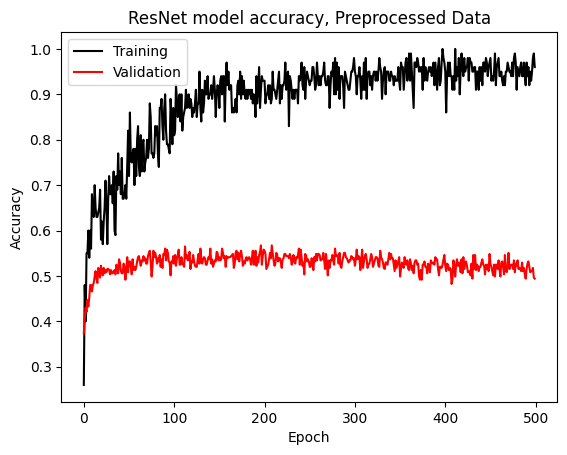

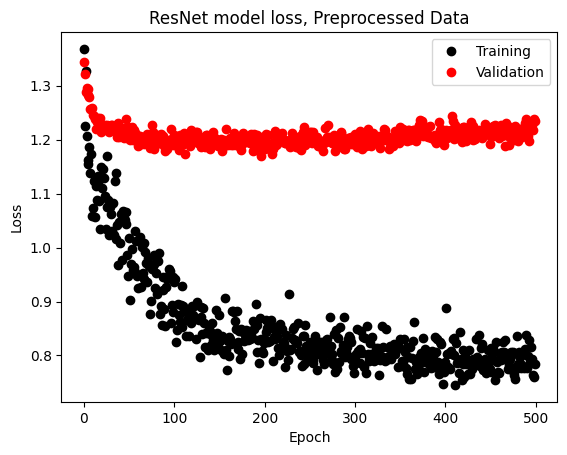

In [ ]:
# Change arrays and titles between models
plt.plot(np.arange(num_epochs),train_history_2,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_2,label='Validation',color='r')
plt.title('ResNet model accuracy, Preprocessed Data')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_2,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_2,'o',label='Validation',color='r')
plt.title('ResNet model loss, Preprocessed Data')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Part 3: Low Pass Filtering after Preprocessing

In [ ]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

# Preprocessing the dataset
# pass only training data to train prep, val and test data to test prep

x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(x_test), test_data_prep(x_valid)

x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

# Convert x train to numpy

x_train_np = x_train.cpu().numpy()
print(x_train_np.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: torch.Size([6768, 22, 400])
Shape of validation set: torch.Size([423, 22, 400])
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([6768, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torc

In [ ]:
# Define the low-pass filter parameters
cutoff_frequency = 40  # Cut-off frequency in Hz
sampling_rate = 125  # Sampling rate in Hz (adjust based on your data)

# Design a Butterworth low-pass filter
order = 3  # Filter order
b, a = butter(N=order, Wn=cutoff_frequency / (0.5 * sampling_rate), btype='low', analog=False, output='ba')

x_train_lpf = np.zeros(x_train_np.shape)
# Apply the filter to the data
for i in range(x_train_np.shape[0]):
    for j in range(x_train_np.shape[2]):
        filtered_data = filtfilt(b, a, x_train_np[i,0,j,:])
        x_train_lpf[i,0,j,:] = filtered_data

x_train_lpf = torch.tensor(x_train_lpf).float().to(device)
print(x_train_lpf.shape)

torch.Size([6768, 1, 22, 400])


In [ ]:
model3 = ResNet(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model3)
total_params = sum(p.numel() for p in model3.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model3.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNet(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1): Con

In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_3, val_history_3 = np.array([]), np.array([])
train_loss_hist_3, val_loss_hist_3 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = '/content/drive/MyDrive/C147_Final_Project/best_model_params_CNN'

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model3_params.pt')
    torch.save(model3.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model3.train()
        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model3(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        #Rename
        model3.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model3(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_3 = np.append(train_history_3, train_acc.item())
        val_history_3 = np.append(val_history_3, val_acc.item())
        train_loss_hist_3 = np.append(train_loss_hist_3, loss.item())
        val_loss_hist_3 = np.append(val_loss_hist_3, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model3.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-34-500b911db80f>:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:02<24:15,  2.92s/it]

Epoch 1 Finished!!!
Train acc: 0.410, Val acc: 0.322
Train loss: 1.310, Val loss: 1.366


  0%|          | 2/500 [00:05<23:59,  2.89s/it]

Epoch 2 Finished!!!
Train acc: 0.450, Val acc: 0.437
Train loss: 1.248, Val loss: 1.289


  1%|          | 3/500 [00:08<23:47,  2.87s/it]

Epoch 3 Finished!!!
Train acc: 0.470, Val acc: 0.397
Train loss: 1.282, Val loss: 1.314


  1%|          | 4/500 [00:11<23:44,  2.87s/it]

Epoch 4 Finished!!!
Train acc: 0.390, Val acc: 0.426
Train loss: 1.319, Val loss: 1.298


  1%|          | 5/500 [00:14<23:46,  2.88s/it]

Epoch 5 Finished!!!
Train acc: 0.480, Val acc: 0.447
Train loss: 1.243, Val loss: 1.286


  1%|          | 6/500 [00:17<24:00,  2.92s/it]

Epoch 6 Finished!!!
Train acc: 0.490, Val acc: 0.433
Train loss: 1.252, Val loss: 1.296


  1%|▏         | 7/500 [00:20<23:53,  2.91s/it]

Epoch 7 Finished!!!
Train acc: 0.560, Val acc: 0.421
Train loss: 1.172, Val loss: 1.300


  2%|▏         | 8/500 [00:23<23:48,  2.90s/it]

Epoch 8 Finished!!!
Train acc: 0.650, Val acc: 0.447
Train loss: 1.089, Val loss: 1.284


  2%|▏         | 9/500 [00:26<23:47,  2.91s/it]

Epoch 9 Finished!!!
Train acc: 0.580, Val acc: 0.411
Train loss: 1.176, Val loss: 1.310


  2%|▏         | 10/500 [00:29<23:45,  2.91s/it]

Epoch 10 Finished!!!
Train acc: 0.430, Val acc: 0.418
Train loss: 1.280, Val loss: 1.304


  2%|▏         | 11/500 [00:31<23:45,  2.91s/it]

Epoch 11 Finished!!!
Train acc: 0.510, Val acc: 0.437
Train loss: 1.214, Val loss: 1.285


  2%|▏         | 12/500 [00:34<23:44,  2.92s/it]

Epoch 12 Finished!!!
Train acc: 0.540, Val acc: 0.430
Train loss: 1.177, Val loss: 1.292


  3%|▎         | 13/500 [00:37<23:45,  2.93s/it]

Epoch 13 Finished!!!
Train acc: 0.600, Val acc: 0.416
Train loss: 1.129, Val loss: 1.312


  3%|▎         | 14/500 [00:40<23:45,  2.93s/it]

Epoch 14 Finished!!!
Train acc: 0.550, Val acc: 0.430
Train loss: 1.173, Val loss: 1.300


  3%|▎         | 15/500 [00:43<23:45,  2.94s/it]

Epoch 15 Finished!!!
Train acc: 0.510, Val acc: 0.414
Train loss: 1.224, Val loss: 1.313


  3%|▎         | 16/500 [00:46<23:46,  2.95s/it]

Epoch 16 Finished!!!
Train acc: 0.580, Val acc: 0.440
Train loss: 1.172, Val loss: 1.277


  3%|▎         | 17/500 [00:49<23:47,  2.95s/it]

Epoch 17 Finished!!!
Train acc: 0.530, Val acc: 0.416
Train loss: 1.209, Val loss: 1.302


  4%|▎         | 18/500 [00:52<23:51,  2.97s/it]

Epoch 18 Finished!!!
Train acc: 0.590, Val acc: 0.452
Train loss: 1.149, Val loss: 1.286


  4%|▍         | 19/500 [00:55<23:49,  2.97s/it]

Epoch 19 Finished!!!
Train acc: 0.610, Val acc: 0.421
Train loss: 1.131, Val loss: 1.295


  4%|▍         | 20/500 [00:58<23:46,  2.97s/it]

Epoch 20 Finished!!!
Train acc: 0.530, Val acc: 0.421
Train loss: 1.212, Val loss: 1.298


  4%|▍         | 21/500 [01:01<23:42,  2.97s/it]

Epoch 21 Finished!!!
Train acc: 0.580, Val acc: 0.437
Train loss: 1.167, Val loss: 1.287


  4%|▍         | 22/500 [01:04<23:39,  2.97s/it]

Epoch 22 Finished!!!
Train acc: 0.530, Val acc: 0.447
Train loss: 1.223, Val loss: 1.278


  5%|▍         | 23/500 [01:07<23:48,  3.00s/it]

Epoch 23 Finished!!!
Train acc: 0.580, Val acc: 0.449
Train loss: 1.162, Val loss: 1.289


  5%|▍         | 24/500 [01:10<23:41,  2.99s/it]

Epoch 24 Finished!!!
Train acc: 0.680, Val acc: 0.459
Train loss: 1.067, Val loss: 1.273


  5%|▌         | 25/500 [01:13<23:34,  2.98s/it]

Epoch 25 Finished!!!
Train acc: 0.590, Val acc: 0.473
Train loss: 1.167, Val loss: 1.266


  5%|▌         | 26/500 [01:17<25:45,  3.26s/it]

Epoch 26 Finished!!!
Train acc: 0.550, Val acc: 0.475
Train loss: 1.171, Val loss: 1.257


  5%|▌         | 27/500 [01:20<24:58,  3.17s/it]

Epoch 27 Finished!!!
Train acc: 0.640, Val acc: 0.487
Train loss: 1.097, Val loss: 1.245


  6%|▌         | 28/500 [01:23<24:18,  3.09s/it]

Epoch 28 Finished!!!
Train acc: 0.570, Val acc: 0.478
Train loss: 1.157, Val loss: 1.250


  6%|▌         | 29/500 [01:26<23:51,  3.04s/it]

Epoch 29 Finished!!!
Train acc: 0.620, Val acc: 0.470
Train loss: 1.113, Val loss: 1.263


  6%|▌         | 30/500 [01:29<23:32,  3.00s/it]

Epoch 30 Finished!!!
Train acc: 0.590, Val acc: 0.463
Train loss: 1.130, Val loss: 1.256


  6%|▌         | 31/500 [01:32<23:17,  2.98s/it]

Epoch 31 Finished!!!
Train acc: 0.660, Val acc: 0.487
Train loss: 1.081, Val loss: 1.244


  6%|▋         | 32/500 [01:34<23:05,  2.96s/it]

Epoch 32 Finished!!!
Train acc: 0.620, Val acc: 0.487
Train loss: 1.093, Val loss: 1.246


  7%|▋         | 33/500 [01:37<22:56,  2.95s/it]

Epoch 33 Finished!!!
Train acc: 0.640, Val acc: 0.482
Train loss: 1.108, Val loss: 1.245


  7%|▋         | 34/500 [01:40<23:03,  2.97s/it]

Epoch 34 Finished!!!
Train acc: 0.630, Val acc: 0.513
Train loss: 1.094, Val loss: 1.222


  7%|▋         | 35/500 [01:44<23:53,  3.08s/it]

Epoch 35 Finished!!!
Train acc: 0.600, Val acc: 0.527
Train loss: 1.133, Val loss: 1.209


  7%|▋         | 36/500 [01:47<23:28,  3.03s/it]

Epoch 36 Finished!!!
Train acc: 0.710, Val acc: 0.515
Train loss: 1.051, Val loss: 1.215


  7%|▋         | 37/500 [01:50<23:10,  3.00s/it]

Epoch 37 Finished!!!
Train acc: 0.640, Val acc: 0.527
Train loss: 1.103, Val loss: 1.216


  8%|▊         | 38/500 [01:53<22:59,  2.99s/it]

Epoch 38 Finished!!!
Train acc: 0.690, Val acc: 0.501
Train loss: 1.060, Val loss: 1.224


  8%|▊         | 39/500 [01:56<22:54,  2.98s/it]

Epoch 39 Finished!!!
Train acc: 0.710, Val acc: 0.530
Train loss: 1.039, Val loss: 1.204


  8%|▊         | 40/500 [01:58<22:47,  2.97s/it]

Epoch 40 Finished!!!
Train acc: 0.720, Val acc: 0.499
Train loss: 1.038, Val loss: 1.224


  8%|▊         | 41/500 [02:01<22:41,  2.97s/it]

Epoch 41 Finished!!!
Train acc: 0.690, Val acc: 0.489
Train loss: 1.057, Val loss: 1.244


  8%|▊         | 42/500 [02:04<22:35,  2.96s/it]

Epoch 42 Finished!!!
Train acc: 0.720, Val acc: 0.501
Train loss: 1.036, Val loss: 1.219


  9%|▊         | 43/500 [02:07<22:31,  2.96s/it]

Epoch 43 Finished!!!
Train acc: 0.650, Val acc: 0.530
Train loss: 1.085, Val loss: 1.202


  9%|▉         | 44/500 [02:10<22:28,  2.96s/it]

Epoch 44 Finished!!!
Train acc: 0.650, Val acc: 0.508
Train loss: 1.083, Val loss: 1.229


  9%|▉         | 45/500 [02:13<22:24,  2.96s/it]

Epoch 45 Finished!!!
Train acc: 0.680, Val acc: 0.520
Train loss: 1.069, Val loss: 1.210


  9%|▉         | 46/500 [02:16<22:20,  2.95s/it]

Epoch 46 Finished!!!
Train acc: 0.720, Val acc: 0.496
Train loss: 1.038, Val loss: 1.237


  9%|▉         | 47/500 [02:19<22:16,  2.95s/it]

Epoch 47 Finished!!!
Train acc: 0.740, Val acc: 0.522
Train loss: 1.012, Val loss: 1.212


 10%|▉         | 48/500 [02:22<22:13,  2.95s/it]

Epoch 48 Finished!!!
Train acc: 0.700, Val acc: 0.515
Train loss: 1.028, Val loss: 1.223


 10%|▉         | 49/500 [02:25<22:09,  2.95s/it]

Epoch 49 Finished!!!
Train acc: 0.720, Val acc: 0.480
Train loss: 1.035, Val loss: 1.246


 10%|█         | 50/500 [02:28<22:06,  2.95s/it]

Epoch 50 Finished!!!
Train acc: 0.790, Val acc: 0.508
Train loss: 0.973, Val loss: 1.221


 10%|█         | 51/500 [02:31<22:01,  2.94s/it]

Epoch 51 Finished!!!
Train acc: 0.730, Val acc: 0.527
Train loss: 1.018, Val loss: 1.200


 10%|█         | 52/500 [02:34<21:59,  2.95s/it]

Epoch 52 Finished!!!
Train acc: 0.740, Val acc: 0.501
Train loss: 1.015, Val loss: 1.231


 11%|█         | 53/500 [02:37<21:56,  2.94s/it]

Epoch 53 Finished!!!
Train acc: 0.750, Val acc: 0.515
Train loss: 1.015, Val loss: 1.207


 11%|█         | 54/500 [02:40<21:51,  2.94s/it]

Epoch 54 Finished!!!
Train acc: 0.750, Val acc: 0.501
Train loss: 0.999, Val loss: 1.225


 11%|█         | 55/500 [02:43<21:51,  2.95s/it]

Epoch 55 Finished!!!
Train acc: 0.800, Val acc: 0.532
Train loss: 0.951, Val loss: 1.203


 11%|█         | 56/500 [02:46<21:49,  2.95s/it]

Epoch 56 Finished!!!
Train acc: 0.740, Val acc: 0.534
Train loss: 0.999, Val loss: 1.202


 11%|█▏        | 57/500 [02:49<21:45,  2.95s/it]

Epoch 57 Finished!!!
Train acc: 0.800, Val acc: 0.522
Train loss: 0.970, Val loss: 1.215


 12%|█▏        | 58/500 [02:52<21:40,  2.94s/it]

Epoch 58 Finished!!!
Train acc: 0.670, Val acc: 0.534
Train loss: 1.062, Val loss: 1.198


 12%|█▏        | 59/500 [02:54<21:38,  2.95s/it]

Epoch 59 Finished!!!
Train acc: 0.750, Val acc: 0.537
Train loss: 1.003, Val loss: 1.202


 12%|█▏        | 60/500 [02:57<21:33,  2.94s/it]

Epoch 60 Finished!!!
Train acc: 0.760, Val acc: 0.527
Train loss: 0.989, Val loss: 1.200


 12%|█▏        | 61/500 [03:00<21:34,  2.95s/it]

Epoch 61 Finished!!!
Train acc: 0.800, Val acc: 0.563
Train loss: 0.956, Val loss: 1.179


 12%|█▏        | 62/500 [03:03<21:30,  2.95s/it]

Epoch 62 Finished!!!
Train acc: 0.760, Val acc: 0.534
Train loss: 0.987, Val loss: 1.203


 13%|█▎        | 63/500 [03:06<21:26,  2.94s/it]

Epoch 63 Finished!!!
Train acc: 0.750, Val acc: 0.537
Train loss: 1.001, Val loss: 1.192


 13%|█▎        | 64/500 [03:09<21:22,  2.94s/it]

Epoch 64 Finished!!!
Train acc: 0.780, Val acc: 0.541
Train loss: 0.979, Val loss: 1.192


 13%|█▎        | 65/500 [03:12<21:19,  2.94s/it]

Epoch 65 Finished!!!
Train acc: 0.830, Val acc: 0.546
Train loss: 0.915, Val loss: 1.190


 13%|█▎        | 66/500 [03:15<21:17,  2.94s/it]

Epoch 66 Finished!!!
Train acc: 0.780, Val acc: 0.541
Train loss: 0.966, Val loss: 1.192


 13%|█▎        | 67/500 [03:18<21:14,  2.94s/it]

Epoch 67 Finished!!!
Train acc: 0.690, Val acc: 0.525
Train loss: 1.036, Val loss: 1.204


 14%|█▎        | 68/500 [03:21<21:11,  2.94s/it]

Epoch 68 Finished!!!
Train acc: 0.760, Val acc: 0.534
Train loss: 0.979, Val loss: 1.192


 14%|█▍        | 69/500 [03:24<21:08,  2.94s/it]

Epoch 69 Finished!!!
Train acc: 0.820, Val acc: 0.560
Train loss: 0.936, Val loss: 1.173


 14%|█▍        | 70/500 [03:27<21:12,  2.96s/it]

Epoch 70 Finished!!!
Train acc: 0.810, Val acc: 0.534
Train loss: 0.947, Val loss: 1.205


 14%|█▍        | 71/500 [03:30<21:37,  3.02s/it]

Epoch 71 Finished!!!
Train acc: 0.820, Val acc: 0.548
Train loss: 0.925, Val loss: 1.193


 14%|█▍        | 72/500 [03:33<21:41,  3.04s/it]

Epoch 72 Finished!!!
Train acc: 0.880, Val acc: 0.548
Train loss: 0.864, Val loss: 1.186


 15%|█▍        | 73/500 [03:36<21:26,  3.01s/it]

Epoch 73 Finished!!!
Train acc: 0.770, Val acc: 0.518
Train loss: 0.973, Val loss: 1.205


 15%|█▍        | 74/500 [03:39<21:15,  3.00s/it]

Epoch 74 Finished!!!
Train acc: 0.760, Val acc: 0.518
Train loss: 1.000, Val loss: 1.213


 15%|█▌        | 75/500 [03:42<21:07,  2.98s/it]

Epoch 75 Finished!!!
Train acc: 0.780, Val acc: 0.546
Train loss: 0.958, Val loss: 1.196


 15%|█▌        | 76/500 [03:45<21:00,  2.97s/it]

Epoch 76 Finished!!!
Train acc: 0.820, Val acc: 0.553
Train loss: 0.918, Val loss: 1.177


 15%|█▌        | 77/500 [03:48<20:54,  2.96s/it]

Epoch 77 Finished!!!
Train acc: 0.770, Val acc: 0.553
Train loss: 0.964, Val loss: 1.179


 16%|█▌        | 78/500 [03:51<21:04,  3.00s/it]

Epoch 78 Finished!!!
Train acc: 0.800, Val acc: 0.560
Train loss: 0.950, Val loss: 1.182


 16%|█▌        | 79/500 [03:54<21:12,  3.02s/it]

Epoch 79 Finished!!!
Train acc: 0.800, Val acc: 0.560
Train loss: 0.949, Val loss: 1.172


 16%|█▌        | 80/500 [03:57<21:00,  3.00s/it]

Epoch 80 Finished!!!
Train acc: 0.850, Val acc: 0.544
Train loss: 0.909, Val loss: 1.196


 16%|█▌        | 81/500 [04:00<20:52,  2.99s/it]

Epoch 81 Finished!!!
Train acc: 0.780, Val acc: 0.548
Train loss: 0.958, Val loss: 1.186


 16%|█▋        | 82/500 [04:03<20:54,  3.00s/it]

Epoch 82 Finished!!!
Train acc: 0.910, Val acc: 0.537
Train loss: 0.844, Val loss: 1.202


 17%|█▋        | 83/500 [04:06<20:55,  3.01s/it]

Epoch 83 Finished!!!
Train acc: 0.840, Val acc: 0.541
Train loss: 0.908, Val loss: 1.196


 17%|█▋        | 84/500 [04:09<20:58,  3.03s/it]

Epoch 84 Finished!!!
Train acc: 0.810, Val acc: 0.541
Train loss: 0.933, Val loss: 1.193


 17%|█▋        | 85/500 [04:12<21:14,  3.07s/it]

Epoch 85 Finished!!!
Train acc: 0.780, Val acc: 0.546
Train loss: 0.949, Val loss: 1.187


 17%|█▋        | 86/500 [04:15<21:29,  3.11s/it]

Epoch 86 Finished!!!
Train acc: 0.720, Val acc: 0.522
Train loss: 1.015, Val loss: 1.220


 17%|█▋        | 87/500 [04:19<22:56,  3.33s/it]

Epoch 87 Finished!!!
Train acc: 0.800, Val acc: 0.548
Train loss: 0.937, Val loss: 1.186


 18%|█▊        | 88/500 [04:22<22:09,  3.23s/it]

Epoch 88 Finished!!!
Train acc: 0.840, Val acc: 0.560
Train loss: 0.901, Val loss: 1.178


 18%|█▊        | 89/500 [04:25<21:32,  3.15s/it]

Epoch 89 Finished!!!
Train acc: 0.790, Val acc: 0.544
Train loss: 0.954, Val loss: 1.189


 18%|█▊        | 90/500 [04:28<21:20,  3.12s/it]

Epoch 90 Finished!!!
Train acc: 0.790, Val acc: 0.556
Train loss: 0.943, Val loss: 1.183


 18%|█▊        | 91/500 [04:31<21:12,  3.11s/it]

Epoch 91 Finished!!!
Train acc: 0.820, Val acc: 0.551
Train loss: 0.919, Val loss: 1.181


 18%|█▊        | 92/500 [04:35<21:42,  3.19s/it]

Epoch 92 Finished!!!
Train acc: 0.880, Val acc: 0.530
Train loss: 0.865, Val loss: 1.197


 19%|█▊        | 93/500 [04:38<21:21,  3.15s/it]

Epoch 93 Finished!!!
Train acc: 0.840, Val acc: 0.551
Train loss: 0.915, Val loss: 1.187


 19%|█▉        | 94/500 [04:41<20:55,  3.09s/it]

Epoch 94 Finished!!!
Train acc: 0.880, Val acc: 0.537
Train loss: 0.873, Val loss: 1.181


 19%|█▉        | 95/500 [04:44<20:34,  3.05s/it]

Epoch 95 Finished!!!
Train acc: 0.860, Val acc: 0.558
Train loss: 0.895, Val loss: 1.185


 19%|█▉        | 96/500 [04:47<20:18,  3.02s/it]

Epoch 96 Finished!!!
Train acc: 0.790, Val acc: 0.558
Train loss: 0.950, Val loss: 1.186


 19%|█▉        | 97/500 [04:50<20:06,  2.99s/it]

Epoch 97 Finished!!!
Train acc: 0.900, Val acc: 0.544
Train loss: 0.863, Val loss: 1.190


 20%|█▉        | 98/500 [04:53<19:56,  2.98s/it]

Epoch 98 Finished!!!
Train acc: 0.820, Val acc: 0.553
Train loss: 0.906, Val loss: 1.185


 20%|█▉        | 99/500 [04:56<19:52,  2.97s/it]

Epoch 99 Finished!!!
Train acc: 0.860, Val acc: 0.553
Train loss: 0.884, Val loss: 1.186


 20%|██        | 100/500 [04:59<20:00,  3.00s/it]

Epoch 100 Finished!!!
Train acc: 0.860, Val acc: 0.525
Train loss: 0.889, Val loss: 1.204


 20%|██        | 101/500 [05:02<19:49,  2.98s/it]

Epoch 101 Finished!!!
Train acc: 0.880, Val acc: 0.530
Train loss: 0.864, Val loss: 1.204


 20%|██        | 102/500 [05:05<20:08,  3.04s/it]

Epoch 102 Finished!!!
Train acc: 0.830, Val acc: 0.563
Train loss: 0.899, Val loss: 1.177


 21%|██        | 103/500 [05:08<20:16,  3.06s/it]

Epoch 103 Finished!!!
Train acc: 0.880, Val acc: 0.558
Train loss: 0.864, Val loss: 1.176


 21%|██        | 104/500 [05:11<20:17,  3.07s/it]

Epoch 104 Finished!!!
Train acc: 0.880, Val acc: 0.548
Train loss: 0.868, Val loss: 1.184


 21%|██        | 105/500 [05:14<20:08,  3.06s/it]

Epoch 105 Finished!!!
Train acc: 0.870, Val acc: 0.563
Train loss: 0.878, Val loss: 1.172


 21%|██        | 106/500 [05:17<19:50,  3.02s/it]

Epoch 106 Finished!!!
Train acc: 0.850, Val acc: 0.546
Train loss: 0.897, Val loss: 1.188


 21%|██▏       | 107/500 [05:20<19:38,  3.00s/it]

Epoch 107 Finished!!!
Train acc: 0.880, Val acc: 0.553
Train loss: 0.882, Val loss: 1.181


 22%|██▏       | 108/500 [05:23<19:28,  2.98s/it]

Epoch 108 Finished!!!
Train acc: 0.880, Val acc: 0.560
Train loss: 0.859, Val loss: 1.168


 22%|██▏       | 109/500 [05:26<19:23,  2.98s/it]

Epoch 109 Finished!!!
Train acc: 0.860, Val acc: 0.570
Train loss: 0.882, Val loss: 1.168


 22%|██▏       | 110/500 [05:29<19:15,  2.96s/it]

Epoch 110 Finished!!!
Train acc: 0.930, Val acc: 0.556
Train loss: 0.825, Val loss: 1.182


 22%|██▏       | 111/500 [05:32<19:10,  2.96s/it]

Epoch 111 Finished!!!
Train acc: 0.860, Val acc: 0.544
Train loss: 0.883, Val loss: 1.187


 22%|██▏       | 112/500 [05:35<19:07,  2.96s/it]

Epoch 112 Finished!!!
Train acc: 0.830, Val acc: 0.567
Train loss: 0.912, Val loss: 1.170


 23%|██▎       | 113/500 [05:38<19:32,  3.03s/it]

Epoch 113 Finished!!!
Train acc: 0.920, Val acc: 0.548
Train loss: 0.830, Val loss: 1.183


 23%|██▎       | 114/500 [05:41<19:28,  3.03s/it]

Epoch 114 Finished!!!
Train acc: 0.940, Val acc: 0.530
Train loss: 0.817, Val loss: 1.194


 23%|██▎       | 115/500 [05:44<19:15,  3.00s/it]

Epoch 115 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.819, Val loss: 1.167


 23%|██▎       | 116/500 [05:47<19:08,  2.99s/it]

Epoch 116 Finished!!!
Train acc: 0.870, Val acc: 0.567
Train loss: 0.869, Val loss: 1.166


 23%|██▎       | 117/500 [05:50<19:00,  2.98s/it]

Epoch 117 Finished!!!
Train acc: 0.880, Val acc: 0.548
Train loss: 0.867, Val loss: 1.188


 24%|██▎       | 118/500 [05:53<18:53,  2.97s/it]

Epoch 118 Finished!!!
Train acc: 0.860, Val acc: 0.544
Train loss: 0.886, Val loss: 1.191


 24%|██▍       | 119/500 [05:56<18:47,  2.96s/it]

Epoch 119 Finished!!!
Train acc: 0.870, Val acc: 0.563
Train loss: 0.867, Val loss: 1.170


 24%|██▍       | 120/500 [05:58<18:43,  2.96s/it]

Epoch 120 Finished!!!
Train acc: 0.830, Val acc: 0.570
Train loss: 0.921, Val loss: 1.171


 24%|██▍       | 121/500 [06:02<18:50,  2.98s/it]

Epoch 121 Finished!!!
Train acc: 0.920, Val acc: 0.574
Train loss: 0.828, Val loss: 1.171


 24%|██▍       | 122/500 [06:04<18:42,  2.97s/it]

Epoch 122 Finished!!!
Train acc: 0.860, Val acc: 0.572
Train loss: 0.889, Val loss: 1.175


 25%|██▍       | 123/500 [06:07<18:43,  2.98s/it]

Epoch 123 Finished!!!
Train acc: 0.900, Val acc: 0.565
Train loss: 0.848, Val loss: 1.170


 25%|██▍       | 124/500 [06:10<18:36,  2.97s/it]

Epoch 124 Finished!!!
Train acc: 0.820, Val acc: 0.532
Train loss: 0.927, Val loss: 1.200


 25%|██▌       | 125/500 [06:13<18:30,  2.96s/it]

Epoch 125 Finished!!!
Train acc: 0.920, Val acc: 0.567
Train loss: 0.826, Val loss: 1.174


 25%|██▌       | 126/500 [06:16<18:42,  3.00s/it]

Epoch 126 Finished!!!
Train acc: 0.900, Val acc: 0.574
Train loss: 0.839, Val loss: 1.165


 25%|██▌       | 127/500 [06:20<18:54,  3.04s/it]

Epoch 127 Finished!!!
Train acc: 0.830, Val acc: 0.589
Train loss: 0.911, Val loss: 1.150


 26%|██▌       | 128/500 [06:23<19:02,  3.07s/it]

Epoch 128 Finished!!!
Train acc: 0.870, Val acc: 0.577
Train loss: 0.875, Val loss: 1.165


 26%|██▌       | 129/500 [06:26<19:24,  3.14s/it]

Epoch 129 Finished!!!
Train acc: 0.880, Val acc: 0.553
Train loss: 0.866, Val loss: 1.184


 26%|██▌       | 130/500 [06:29<19:25,  3.15s/it]

Epoch 130 Finished!!!
Train acc: 0.890, Val acc: 0.560
Train loss: 0.855, Val loss: 1.171


 26%|██▌       | 131/500 [06:33<19:50,  3.23s/it]

Epoch 131 Finished!!!
Train acc: 0.900, Val acc: 0.551
Train loss: 0.843, Val loss: 1.183


 26%|██▋       | 132/500 [06:36<19:17,  3.15s/it]

Epoch 132 Finished!!!
Train acc: 0.910, Val acc: 0.560
Train loss: 0.836, Val loss: 1.179


 27%|██▋       | 133/500 [06:38<18:51,  3.08s/it]

Epoch 133 Finished!!!
Train acc: 0.900, Val acc: 0.553
Train loss: 0.832, Val loss: 1.176


 27%|██▋       | 134/500 [06:41<18:32,  3.04s/it]

Epoch 134 Finished!!!
Train acc: 0.920, Val acc: 0.577
Train loss: 0.821, Val loss: 1.167


 27%|██▋       | 135/500 [06:45<18:34,  3.05s/it]

Epoch 135 Finished!!!
Train acc: 0.900, Val acc: 0.565
Train loss: 0.840, Val loss: 1.172


 27%|██▋       | 136/500 [06:48<18:24,  3.04s/it]

Epoch 136 Finished!!!
Train acc: 0.850, Val acc: 0.548
Train loss: 0.889, Val loss: 1.185


 27%|██▋       | 137/500 [06:51<18:17,  3.02s/it]

Epoch 137 Finished!!!
Train acc: 0.920, Val acc: 0.565
Train loss: 0.835, Val loss: 1.174


 28%|██▊       | 138/500 [06:53<18:04,  3.00s/it]

Epoch 138 Finished!!!
Train acc: 0.900, Val acc: 0.563
Train loss: 0.845, Val loss: 1.168


 28%|██▊       | 139/500 [06:56<17:56,  2.98s/it]

Epoch 139 Finished!!!
Train acc: 0.920, Val acc: 0.579
Train loss: 0.825, Val loss: 1.161


 28%|██▊       | 140/500 [06:59<17:49,  2.97s/it]

Epoch 140 Finished!!!
Train acc: 0.920, Val acc: 0.570
Train loss: 0.835, Val loss: 1.166


 28%|██▊       | 141/500 [07:02<17:42,  2.96s/it]

Epoch 141 Finished!!!
Train acc: 0.890, Val acc: 0.577
Train loss: 0.866, Val loss: 1.162


 28%|██▊       | 142/500 [07:05<17:37,  2.95s/it]

Epoch 142 Finished!!!
Train acc: 0.910, Val acc: 0.565
Train loss: 0.840, Val loss: 1.169


 29%|██▊       | 143/500 [07:08<17:34,  2.95s/it]

Epoch 143 Finished!!!
Train acc: 0.920, Val acc: 0.541
Train loss: 0.830, Val loss: 1.191


 29%|██▉       | 144/500 [07:11<17:30,  2.95s/it]

Epoch 144 Finished!!!
Train acc: 0.850, Val acc: 0.544
Train loss: 0.880, Val loss: 1.190


 29%|██▉       | 145/500 [07:14<17:25,  2.95s/it]

Epoch 145 Finished!!!
Train acc: 0.890, Val acc: 0.574
Train loss: 0.846, Val loss: 1.159


 29%|██▉       | 146/500 [07:17<17:22,  2.94s/it]

Epoch 146 Finished!!!
Train acc: 0.930, Val acc: 0.563
Train loss: 0.817, Val loss: 1.169


 29%|██▉       | 147/500 [07:20<17:20,  2.95s/it]

Epoch 147 Finished!!!
Train acc: 0.870, Val acc: 0.593
Train loss: 0.882, Val loss: 1.151


 30%|██▉       | 148/500 [07:23<17:16,  2.95s/it]

Epoch 148 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.812, Val loss: 1.181


 30%|██▉       | 149/500 [07:26<17:14,  2.95s/it]

Epoch 149 Finished!!!
Train acc: 0.900, Val acc: 0.584
Train loss: 0.856, Val loss: 1.157


 30%|███       | 150/500 [07:29<17:10,  2.94s/it]

Epoch 150 Finished!!!
Train acc: 0.940, Val acc: 0.582
Train loss: 0.809, Val loss: 1.154


 30%|███       | 151/500 [07:32<17:06,  2.94s/it]

Epoch 151 Finished!!!
Train acc: 0.910, Val acc: 0.560
Train loss: 0.836, Val loss: 1.177


 30%|███       | 152/500 [07:35<17:03,  2.94s/it]

Epoch 152 Finished!!!
Train acc: 0.870, Val acc: 0.570
Train loss: 0.874, Val loss: 1.158


 31%|███       | 153/500 [07:38<17:00,  2.94s/it]

Epoch 153 Finished!!!
Train acc: 0.930, Val acc: 0.572
Train loss: 0.825, Val loss: 1.160


 31%|███       | 154/500 [07:41<16:57,  2.94s/it]

Epoch 154 Finished!!!
Train acc: 0.920, Val acc: 0.584
Train loss: 0.827, Val loss: 1.145


 31%|███       | 155/500 [07:43<16:54,  2.94s/it]

Epoch 155 Finished!!!
Train acc: 0.960, Val acc: 0.560
Train loss: 0.791, Val loss: 1.174


 31%|███       | 156/500 [07:46<16:51,  2.94s/it]

Epoch 156 Finished!!!
Train acc: 0.960, Val acc: 0.579
Train loss: 0.793, Val loss: 1.152


 31%|███▏      | 157/500 [07:49<16:48,  2.94s/it]

Epoch 157 Finished!!!
Train acc: 0.880, Val acc: 0.579
Train loss: 0.865, Val loss: 1.152


 32%|███▏      | 158/500 [07:52<16:45,  2.94s/it]

Epoch 158 Finished!!!
Train acc: 0.880, Val acc: 0.579
Train loss: 0.862, Val loss: 1.159


 32%|███▏      | 159/500 [07:55<16:42,  2.94s/it]

Epoch 159 Finished!!!
Train acc: 0.930, Val acc: 0.591
Train loss: 0.820, Val loss: 1.152


 32%|███▏      | 160/500 [07:58<16:39,  2.94s/it]

Epoch 160 Finished!!!
Train acc: 0.860, Val acc: 0.558
Train loss: 0.871, Val loss: 1.174


 32%|███▏      | 161/500 [08:01<16:36,  2.94s/it]

Epoch 161 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.781, Val loss: 1.162


 32%|███▏      | 162/500 [08:04<16:33,  2.94s/it]

Epoch 162 Finished!!!
Train acc: 0.960, Val acc: 0.582
Train loss: 0.784, Val loss: 1.156


 33%|███▎      | 163/500 [08:07<16:30,  2.94s/it]

Epoch 163 Finished!!!
Train acc: 0.930, Val acc: 0.589
Train loss: 0.809, Val loss: 1.153


 33%|███▎      | 164/500 [08:10<16:26,  2.94s/it]

Epoch 164 Finished!!!
Train acc: 0.970, Val acc: 0.572
Train loss: 0.774, Val loss: 1.164


 33%|███▎      | 165/500 [08:13<16:33,  2.97s/it]

Epoch 165 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.806, Val loss: 1.181


 33%|███▎      | 166/500 [08:16<16:27,  2.96s/it]

Epoch 166 Finished!!!
Train acc: 0.910, Val acc: 0.577
Train loss: 0.834, Val loss: 1.160


 33%|███▎      | 167/500 [08:19<16:22,  2.95s/it]

Epoch 167 Finished!!!
Train acc: 0.990, Val acc: 0.586
Train loss: 0.756, Val loss: 1.143


 34%|███▎      | 168/500 [08:22<16:18,  2.95s/it]

Epoch 168 Finished!!!
Train acc: 0.930, Val acc: 0.582
Train loss: 0.815, Val loss: 1.156


 34%|███▍      | 169/500 [08:25<16:14,  2.94s/it]

Epoch 169 Finished!!!
Train acc: 0.930, Val acc: 0.574
Train loss: 0.808, Val loss: 1.163


 34%|███▍      | 170/500 [08:28<16:11,  2.94s/it]

Epoch 170 Finished!!!
Train acc: 0.970, Val acc: 0.589
Train loss: 0.781, Val loss: 1.150


 34%|███▍      | 171/500 [08:31<16:07,  2.94s/it]

Epoch 171 Finished!!!
Train acc: 0.910, Val acc: 0.582
Train loss: 0.835, Val loss: 1.152


 34%|███▍      | 172/500 [08:34<16:13,  2.97s/it]

Epoch 172 Finished!!!
Train acc: 0.960, Val acc: 0.596
Train loss: 0.793, Val loss: 1.138


 35%|███▍      | 173/500 [08:37<16:07,  2.96s/it]

Epoch 173 Finished!!!
Train acc: 0.930, Val acc: 0.574
Train loss: 0.813, Val loss: 1.163


 35%|███▍      | 174/500 [08:39<16:02,  2.95s/it]

Epoch 174 Finished!!!
Train acc: 0.870, Val acc: 0.558
Train loss: 0.871, Val loss: 1.179


 35%|███▌      | 175/500 [08:42<15:58,  2.95s/it]

Epoch 175 Finished!!!
Train acc: 0.980, Val acc: 0.558
Train loss: 0.769, Val loss: 1.169


 35%|███▌      | 176/500 [08:45<15:54,  2.94s/it]

Epoch 176 Finished!!!
Train acc: 0.940, Val acc: 0.574
Train loss: 0.807, Val loss: 1.162


 35%|███▌      | 177/500 [08:48<15:50,  2.94s/it]

Epoch 177 Finished!!!
Train acc: 0.930, Val acc: 0.565
Train loss: 0.819, Val loss: 1.171


 36%|███▌      | 178/500 [08:51<15:47,  2.94s/it]

Epoch 178 Finished!!!
Train acc: 0.910, Val acc: 0.579
Train loss: 0.840, Val loss: 1.157


 36%|███▌      | 179/500 [08:54<15:44,  2.94s/it]

Epoch 179 Finished!!!
Train acc: 0.960, Val acc: 0.589
Train loss: 0.782, Val loss: 1.148


 36%|███▌      | 180/500 [08:57<15:40,  2.94s/it]

Epoch 180 Finished!!!
Train acc: 0.930, Val acc: 0.582
Train loss: 0.814, Val loss: 1.152


 36%|███▌      | 181/500 [09:00<15:37,  2.94s/it]

Epoch 181 Finished!!!
Train acc: 0.910, Val acc: 0.570
Train loss: 0.834, Val loss: 1.169


 36%|███▋      | 182/500 [09:03<15:34,  2.94s/it]

Epoch 182 Finished!!!
Train acc: 0.900, Val acc: 0.565
Train loss: 0.854, Val loss: 1.176


 37%|███▋      | 183/500 [09:06<15:34,  2.95s/it]

Epoch 183 Finished!!!
Train acc: 0.930, Val acc: 0.610
Train loss: 0.812, Val loss: 1.133


 37%|███▋      | 184/500 [09:09<15:30,  2.94s/it]

Epoch 184 Finished!!!
Train acc: 0.930, Val acc: 0.589
Train loss: 0.818, Val loss: 1.151


 37%|███▋      | 185/500 [09:12<15:26,  2.94s/it]

Epoch 185 Finished!!!
Train acc: 0.970, Val acc: 0.586
Train loss: 0.779, Val loss: 1.155


 37%|███▋      | 186/500 [09:15<15:23,  2.94s/it]

Epoch 186 Finished!!!
Train acc: 0.960, Val acc: 0.572
Train loss: 0.787, Val loss: 1.166


 37%|███▋      | 187/500 [09:18<15:20,  2.94s/it]

Epoch 187 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.808, Val loss: 1.156


 38%|███▊      | 188/500 [09:21<15:18,  2.94s/it]

Epoch 188 Finished!!!
Train acc: 0.910, Val acc: 0.577
Train loss: 0.830, Val loss: 1.153


 38%|███▊      | 189/500 [09:24<15:14,  2.94s/it]

Epoch 189 Finished!!!
Train acc: 0.880, Val acc: 0.572
Train loss: 0.875, Val loss: 1.167


 38%|███▊      | 190/500 [09:27<15:10,  2.94s/it]

Epoch 190 Finished!!!
Train acc: 0.940, Val acc: 0.584
Train loss: 0.807, Val loss: 1.159


 38%|███▊      | 191/500 [09:29<15:07,  2.94s/it]

Epoch 191 Finished!!!
Train acc: 0.920, Val acc: 0.572
Train loss: 0.822, Val loss: 1.165


 38%|███▊      | 192/500 [09:32<15:05,  2.94s/it]

Epoch 192 Finished!!!
Train acc: 0.910, Val acc: 0.565
Train loss: 0.831, Val loss: 1.164


 39%|███▊      | 193/500 [09:35<15:02,  2.94s/it]

Epoch 193 Finished!!!
Train acc: 0.940, Val acc: 0.586
Train loss: 0.811, Val loss: 1.146


 39%|███▉      | 194/500 [09:38<14:59,  2.94s/it]

Epoch 194 Finished!!!
Train acc: 0.950, Val acc: 0.600
Train loss: 0.807, Val loss: 1.139


 39%|███▉      | 195/500 [09:41<14:56,  2.94s/it]

Epoch 195 Finished!!!
Train acc: 0.930, Val acc: 0.574
Train loss: 0.820, Val loss: 1.164


 39%|███▉      | 196/500 [09:44<14:53,  2.94s/it]

Epoch 196 Finished!!!
Train acc: 0.920, Val acc: 0.563
Train loss: 0.822, Val loss: 1.163


 39%|███▉      | 197/500 [09:47<14:51,  2.94s/it]

Epoch 197 Finished!!!
Train acc: 0.890, Val acc: 0.565
Train loss: 0.853, Val loss: 1.172


 40%|███▉      | 198/500 [09:50<14:47,  2.94s/it]

Epoch 198 Finished!!!
Train acc: 0.920, Val acc: 0.563
Train loss: 0.829, Val loss: 1.160


 40%|███▉      | 199/500 [09:53<14:45,  2.94s/it]

Epoch 199 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.811, Val loss: 1.164


 40%|████      | 200/500 [09:56<14:42,  2.94s/it]

Epoch 200 Finished!!!
Train acc: 0.900, Val acc: 0.570
Train loss: 0.837, Val loss: 1.167


 40%|████      | 201/500 [09:59<15:14,  3.06s/it]

Epoch 201 Finished!!!
Train acc: 0.910, Val acc: 0.586
Train loss: 0.837, Val loss: 1.155


 40%|████      | 202/500 [10:02<15:01,  3.02s/it]

Epoch 202 Finished!!!
Train acc: 0.920, Val acc: 0.563
Train loss: 0.825, Val loss: 1.168


 41%|████      | 203/500 [10:05<14:51,  3.00s/it]

Epoch 203 Finished!!!
Train acc: 0.920, Val acc: 0.574
Train loss: 0.824, Val loss: 1.167


 41%|████      | 204/500 [10:08<14:43,  2.98s/it]

Epoch 204 Finished!!!
Train acc: 0.970, Val acc: 0.560
Train loss: 0.780, Val loss: 1.177


 41%|████      | 205/500 [10:11<14:37,  2.97s/it]

Epoch 205 Finished!!!
Train acc: 0.910, Val acc: 0.563
Train loss: 0.833, Val loss: 1.167


 41%|████      | 206/500 [10:14<14:31,  2.96s/it]

Epoch 206 Finished!!!
Train acc: 0.890, Val acc: 0.586
Train loss: 0.853, Val loss: 1.150


 41%|████▏     | 207/500 [10:17<14:26,  2.96s/it]

Epoch 207 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.816, Val loss: 1.183


 42%|████▏     | 208/500 [10:20<14:30,  2.98s/it]

Epoch 208 Finished!!!
Train acc: 0.950, Val acc: 0.560
Train loss: 0.795, Val loss: 1.170


 42%|████▏     | 209/500 [10:23<14:24,  2.97s/it]

Epoch 209 Finished!!!
Train acc: 0.900, Val acc: 0.582
Train loss: 0.837, Val loss: 1.152


 42%|████▏     | 210/500 [10:26<14:19,  2.96s/it]

Epoch 210 Finished!!!
Train acc: 0.930, Val acc: 0.584
Train loss: 0.817, Val loss: 1.149


 42%|████▏     | 211/500 [10:29<14:14,  2.96s/it]

Epoch 211 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.802, Val loss: 1.170


 42%|████▏     | 212/500 [10:32<14:10,  2.95s/it]

Epoch 212 Finished!!!
Train acc: 0.940, Val acc: 0.553
Train loss: 0.805, Val loss: 1.182


 43%|████▎     | 213/500 [10:35<14:06,  2.95s/it]

Epoch 213 Finished!!!
Train acc: 0.920, Val acc: 0.567
Train loss: 0.819, Val loss: 1.168


 43%|████▎     | 214/500 [10:38<14:03,  2.95s/it]

Epoch 214 Finished!!!
Train acc: 0.940, Val acc: 0.586
Train loss: 0.807, Val loss: 1.146


 43%|████▎     | 215/500 [10:41<14:00,  2.95s/it]

Epoch 215 Finished!!!
Train acc: 0.930, Val acc: 0.556
Train loss: 0.816, Val loss: 1.175


 43%|████▎     | 216/500 [10:44<13:57,  2.95s/it]

Epoch 216 Finished!!!
Train acc: 0.960, Val acc: 0.579
Train loss: 0.788, Val loss: 1.155


 43%|████▎     | 217/500 [10:46<13:53,  2.95s/it]

Epoch 217 Finished!!!
Train acc: 0.930, Val acc: 0.582
Train loss: 0.816, Val loss: 1.158


 44%|████▎     | 218/500 [10:49<13:50,  2.95s/it]

Epoch 218 Finished!!!
Train acc: 0.970, Val acc: 0.570
Train loss: 0.776, Val loss: 1.159


 44%|████▍     | 219/500 [10:52<13:48,  2.95s/it]

Epoch 219 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.802, Val loss: 1.163


 44%|████▍     | 220/500 [10:55<13:44,  2.95s/it]

Epoch 220 Finished!!!
Train acc: 0.850, Val acc: 0.572
Train loss: 0.892, Val loss: 1.156


 44%|████▍     | 221/500 [10:58<13:41,  2.94s/it]

Epoch 221 Finished!!!
Train acc: 0.860, Val acc: 0.572
Train loss: 0.870, Val loss: 1.167


 44%|████▍     | 222/500 [11:01<13:38,  2.94s/it]

Epoch 222 Finished!!!
Train acc: 0.930, Val acc: 0.579
Train loss: 0.817, Val loss: 1.154


 45%|████▍     | 223/500 [11:04<13:35,  2.95s/it]

Epoch 223 Finished!!!
Train acc: 0.900, Val acc: 0.563
Train loss: 0.847, Val loss: 1.167


 45%|████▍     | 224/500 [11:07<13:33,  2.95s/it]

Epoch 224 Finished!!!
Train acc: 0.950, Val acc: 0.574
Train loss: 0.802, Val loss: 1.160


 45%|████▌     | 225/500 [11:10<13:30,  2.95s/it]

Epoch 225 Finished!!!
Train acc: 0.970, Val acc: 0.591
Train loss: 0.775, Val loss: 1.147


 45%|████▌     | 226/500 [11:13<13:27,  2.95s/it]

Epoch 226 Finished!!!
Train acc: 0.920, Val acc: 0.567
Train loss: 0.821, Val loss: 1.164


 45%|████▌     | 227/500 [11:16<13:24,  2.95s/it]

Epoch 227 Finished!!!
Train acc: 0.910, Val acc: 0.567
Train loss: 0.835, Val loss: 1.164


 46%|████▌     | 228/500 [11:19<13:21,  2.95s/it]

Epoch 228 Finished!!!
Train acc: 0.930, Val acc: 0.593
Train loss: 0.815, Val loss: 1.144


 46%|████▌     | 229/500 [11:22<13:18,  2.95s/it]

Epoch 229 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.804, Val loss: 1.177


 46%|████▌     | 230/500 [11:25<13:15,  2.95s/it]

Epoch 230 Finished!!!
Train acc: 0.940, Val acc: 0.537
Train loss: 0.805, Val loss: 1.197


 46%|████▌     | 231/500 [11:28<13:12,  2.95s/it]

Epoch 231 Finished!!!
Train acc: 0.940, Val acc: 0.577
Train loss: 0.808, Val loss: 1.165


 46%|████▋     | 232/500 [11:31<13:09,  2.95s/it]

Epoch 232 Finished!!!
Train acc: 0.890, Val acc: 0.548
Train loss: 0.847, Val loss: 1.179


 47%|████▋     | 233/500 [11:34<13:06,  2.95s/it]

Epoch 233 Finished!!!
Train acc: 0.920, Val acc: 0.565
Train loss: 0.818, Val loss: 1.168


 47%|████▋     | 234/500 [11:37<13:03,  2.94s/it]

Epoch 234 Finished!!!
Train acc: 0.900, Val acc: 0.563
Train loss: 0.833, Val loss: 1.168


 47%|████▋     | 235/500 [11:39<13:00,  2.95s/it]

Epoch 235 Finished!!!
Train acc: 0.950, Val acc: 0.574
Train loss: 0.799, Val loss: 1.163


 47%|████▋     | 236/500 [11:42<12:57,  2.95s/it]

Epoch 236 Finished!!!
Train acc: 0.940, Val acc: 0.582
Train loss: 0.812, Val loss: 1.162


 47%|████▋     | 237/500 [11:45<12:59,  2.97s/it]

Epoch 237 Finished!!!
Train acc: 0.950, Val acc: 0.591
Train loss: 0.797, Val loss: 1.143


 48%|████▊     | 238/500 [11:48<12:55,  2.96s/it]

Epoch 238 Finished!!!
Train acc: 0.980, Val acc: 0.586
Train loss: 0.769, Val loss: 1.155


 48%|████▊     | 239/500 [11:51<12:51,  2.96s/it]

Epoch 239 Finished!!!
Train acc: 0.930, Val acc: 0.586
Train loss: 0.816, Val loss: 1.152


 48%|████▊     | 240/500 [11:54<12:48,  2.95s/it]

Epoch 240 Finished!!!
Train acc: 0.940, Val acc: 0.600
Train loss: 0.801, Val loss: 1.136


 48%|████▊     | 241/500 [11:57<12:44,  2.95s/it]

Epoch 241 Finished!!!
Train acc: 0.950, Val acc: 0.598
Train loss: 0.792, Val loss: 1.141


 48%|████▊     | 242/500 [12:00<12:40,  2.95s/it]

Epoch 242 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.828, Val loss: 1.167


 49%|████▊     | 243/500 [12:03<12:37,  2.95s/it]

Epoch 243 Finished!!!
Train acc: 0.930, Val acc: 0.582
Train loss: 0.815, Val loss: 1.156


 49%|████▉     | 244/500 [12:06<12:34,  2.95s/it]

Epoch 244 Finished!!!
Train acc: 0.890, Val acc: 0.567
Train loss: 0.854, Val loss: 1.171


 49%|████▉     | 245/500 [12:09<12:31,  2.95s/it]

Epoch 245 Finished!!!
Train acc: 0.930, Val acc: 0.560
Train loss: 0.815, Val loss: 1.177


 49%|████▉     | 246/500 [12:12<12:28,  2.95s/it]

Epoch 246 Finished!!!
Train acc: 0.960, Val acc: 0.589
Train loss: 0.789, Val loss: 1.151


 49%|████▉     | 247/500 [12:15<12:24,  2.94s/it]

Epoch 247 Finished!!!
Train acc: 0.890, Val acc: 0.574
Train loss: 0.856, Val loss: 1.159


 50%|████▉     | 248/500 [12:18<12:22,  2.95s/it]

Epoch 248 Finished!!!
Train acc: 0.970, Val acc: 0.584
Train loss: 0.774, Val loss: 1.152


 50%|████▉     | 249/500 [12:21<12:19,  2.95s/it]

Epoch 249 Finished!!!
Train acc: 0.910, Val acc: 0.582
Train loss: 0.833, Val loss: 1.153


 50%|█████     | 250/500 [12:24<12:16,  2.95s/it]

Epoch 250 Finished!!!
Train acc: 0.940, Val acc: 0.593
Train loss: 0.805, Val loss: 1.145


 50%|█████     | 251/500 [12:27<12:12,  2.94s/it]

Epoch 251 Finished!!!
Train acc: 0.940, Val acc: 0.589
Train loss: 0.803, Val loss: 1.140


 50%|█████     | 252/500 [12:30<12:10,  2.94s/it]

Epoch 252 Finished!!!
Train acc: 0.920, Val acc: 0.563
Train loss: 0.828, Val loss: 1.167


 51%|█████     | 253/500 [12:33<12:36,  3.06s/it]

Epoch 253 Finished!!!
Train acc: 0.930, Val acc: 0.572
Train loss: 0.813, Val loss: 1.167


 51%|█████     | 254/500 [12:36<12:29,  3.05s/it]

Epoch 254 Finished!!!
Train acc: 0.920, Val acc: 0.556
Train loss: 0.827, Val loss: 1.179


 51%|█████     | 255/500 [12:39<12:18,  3.01s/it]

Epoch 255 Finished!!!
Train acc: 0.910, Val acc: 0.577
Train loss: 0.829, Val loss: 1.154


 51%|█████     | 256/500 [12:42<12:10,  2.99s/it]

Epoch 256 Finished!!!
Train acc: 0.950, Val acc: 0.593
Train loss: 0.792, Val loss: 1.142


 51%|█████▏    | 257/500 [12:45<12:03,  2.98s/it]

Epoch 257 Finished!!!
Train acc: 0.950, Val acc: 0.586
Train loss: 0.795, Val loss: 1.145


 52%|█████▏    | 258/500 [12:48<11:58,  2.97s/it]

Epoch 258 Finished!!!
Train acc: 0.980, Val acc: 0.584
Train loss: 0.765, Val loss: 1.154


 52%|█████▏    | 259/500 [12:51<11:53,  2.96s/it]

Epoch 259 Finished!!!
Train acc: 0.950, Val acc: 0.577
Train loss: 0.795, Val loss: 1.156


 52%|█████▏    | 260/500 [12:54<11:49,  2.96s/it]

Epoch 260 Finished!!!
Train acc: 0.940, Val acc: 0.567
Train loss: 0.807, Val loss: 1.167


 52%|█████▏    | 261/500 [12:57<11:46,  2.95s/it]

Epoch 261 Finished!!!
Train acc: 0.940, Val acc: 0.591
Train loss: 0.806, Val loss: 1.145


 52%|█████▏    | 262/500 [13:00<11:42,  2.95s/it]

Epoch 262 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.801, Val loss: 1.167


 53%|█████▎    | 263/500 [13:02<11:39,  2.95s/it]

Epoch 263 Finished!!!
Train acc: 0.930, Val acc: 0.565
Train loss: 0.815, Val loss: 1.169


 53%|█████▎    | 264/500 [13:05<11:36,  2.95s/it]

Epoch 264 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.802, Val loss: 1.167


 53%|█████▎    | 265/500 [13:08<11:32,  2.95s/it]

Epoch 265 Finished!!!
Train acc: 0.950, Val acc: 0.596
Train loss: 0.796, Val loss: 1.143


 53%|█████▎    | 266/500 [13:11<11:29,  2.95s/it]

Epoch 266 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.786, Val loss: 1.163


 53%|█████▎    | 267/500 [13:14<11:26,  2.95s/it]

Epoch 267 Finished!!!
Train acc: 0.910, Val acc: 0.582
Train loss: 0.840, Val loss: 1.153


 54%|█████▎    | 268/500 [13:17<11:22,  2.94s/it]

Epoch 268 Finished!!!
Train acc: 0.950, Val acc: 0.584
Train loss: 0.798, Val loss: 1.156


 54%|█████▍    | 269/500 [13:20<11:19,  2.94s/it]

Epoch 269 Finished!!!
Train acc: 0.910, Val acc: 0.577
Train loss: 0.830, Val loss: 1.150


 54%|█████▍    | 270/500 [13:23<11:17,  2.94s/it]

Epoch 270 Finished!!!
Train acc: 0.970, Val acc: 0.563
Train loss: 0.778, Val loss: 1.161


 54%|█████▍    | 271/500 [13:26<11:14,  2.94s/it]

Epoch 271 Finished!!!
Train acc: 0.950, Val acc: 0.577
Train loss: 0.797, Val loss: 1.158


 54%|█████▍    | 272/500 [13:29<11:11,  2.94s/it]

Epoch 272 Finished!!!
Train acc: 0.930, Val acc: 0.551
Train loss: 0.815, Val loss: 1.179


 55%|█████▍    | 273/500 [13:32<11:07,  2.94s/it]

Epoch 273 Finished!!!
Train acc: 0.960, Val acc: 0.574
Train loss: 0.788, Val loss: 1.159


 55%|█████▍    | 274/500 [13:35<11:04,  2.94s/it]

Epoch 274 Finished!!!
Train acc: 0.920, Val acc: 0.596
Train loss: 0.819, Val loss: 1.146


 55%|█████▌    | 275/500 [13:38<11:02,  2.94s/it]

Epoch 275 Finished!!!
Train acc: 0.940, Val acc: 0.596
Train loss: 0.812, Val loss: 1.144


 55%|█████▌    | 276/500 [13:41<10:59,  2.94s/it]

Epoch 276 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.823, Val loss: 1.171


 55%|█████▌    | 277/500 [13:44<10:56,  2.94s/it]

Epoch 277 Finished!!!
Train acc: 0.930, Val acc: 0.589
Train loss: 0.815, Val loss: 1.154


 56%|█████▌    | 278/500 [13:47<10:52,  2.94s/it]

Epoch 278 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.787, Val loss: 1.166


 56%|█████▌    | 279/500 [13:50<10:50,  2.94s/it]

Epoch 279 Finished!!!
Train acc: 0.930, Val acc: 0.553
Train loss: 0.815, Val loss: 1.174


 56%|█████▌    | 280/500 [13:53<10:47,  2.94s/it]

Epoch 280 Finished!!!
Train acc: 0.900, Val acc: 0.556
Train loss: 0.847, Val loss: 1.172


 56%|█████▌    | 281/500 [13:55<10:43,  2.94s/it]

Epoch 281 Finished!!!
Train acc: 0.920, Val acc: 0.553
Train loss: 0.832, Val loss: 1.175


 56%|█████▋    | 282/500 [13:58<10:40,  2.94s/it]

Epoch 282 Finished!!!
Train acc: 0.930, Val acc: 0.567
Train loss: 0.806, Val loss: 1.164


 57%|█████▋    | 283/500 [14:01<10:37,  2.94s/it]

Epoch 283 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.782, Val loss: 1.167


 57%|█████▋    | 284/500 [14:04<10:35,  2.94s/it]

Epoch 284 Finished!!!
Train acc: 0.960, Val acc: 0.596
Train loss: 0.788, Val loss: 1.145


 57%|█████▋    | 285/500 [14:07<10:32,  2.94s/it]

Epoch 285 Finished!!!
Train acc: 0.970, Val acc: 0.589
Train loss: 0.770, Val loss: 1.153


 57%|█████▋    | 286/500 [14:10<10:29,  2.94s/it]

Epoch 286 Finished!!!
Train acc: 0.930, Val acc: 0.598
Train loss: 0.814, Val loss: 1.143


 57%|█████▋    | 287/500 [14:13<10:25,  2.94s/it]

Epoch 287 Finished!!!
Train acc: 0.890, Val acc: 0.546
Train loss: 0.851, Val loss: 1.181


 58%|█████▊    | 288/500 [14:16<10:23,  2.94s/it]

Epoch 288 Finished!!!
Train acc: 0.930, Val acc: 0.546
Train loss: 0.819, Val loss: 1.184


 58%|█████▊    | 289/500 [14:19<10:20,  2.94s/it]

Epoch 289 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.786, Val loss: 1.185


 58%|█████▊    | 290/500 [14:22<10:17,  2.94s/it]

Epoch 290 Finished!!!
Train acc: 0.920, Val acc: 0.574
Train loss: 0.830, Val loss: 1.157


 58%|█████▊    | 291/500 [14:25<10:14,  2.94s/it]

Epoch 291 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.785, Val loss: 1.158


 58%|█████▊    | 292/500 [14:28<10:12,  2.94s/it]

Epoch 292 Finished!!!
Train acc: 0.960, Val acc: 0.574
Train loss: 0.790, Val loss: 1.157


 59%|█████▊    | 293/500 [14:31<10:08,  2.94s/it]

Epoch 293 Finished!!!
Train acc: 0.940, Val acc: 0.582
Train loss: 0.804, Val loss: 1.157


 59%|█████▉    | 294/500 [14:34<10:05,  2.94s/it]

Epoch 294 Finished!!!
Train acc: 0.920, Val acc: 0.598
Train loss: 0.818, Val loss: 1.139


 59%|█████▉    | 295/500 [14:37<10:02,  2.94s/it]

Epoch 295 Finished!!!
Train acc: 0.950, Val acc: 0.589
Train loss: 0.796, Val loss: 1.140


 59%|█████▉    | 296/500 [14:40<09:59,  2.94s/it]

Epoch 296 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.790, Val loss: 1.164


 59%|█████▉    | 297/500 [14:42<09:56,  2.94s/it]

Epoch 297 Finished!!!
Train acc: 0.940, Val acc: 0.589
Train loss: 0.810, Val loss: 1.152


 60%|█████▉    | 298/500 [14:45<09:53,  2.94s/it]

Epoch 298 Finished!!!
Train acc: 0.900, Val acc: 0.570
Train loss: 0.844, Val loss: 1.165


 60%|█████▉    | 299/500 [14:48<09:50,  2.94s/it]

Epoch 299 Finished!!!
Train acc: 0.970, Val acc: 0.556
Train loss: 0.779, Val loss: 1.170


 60%|██████    | 300/500 [14:51<09:48,  2.94s/it]

Epoch 300 Finished!!!
Train acc: 0.950, Val acc: 0.565
Train loss: 0.782, Val loss: 1.166


 60%|██████    | 301/500 [14:54<09:45,  2.94s/it]

Epoch 301 Finished!!!
Train acc: 0.920, Val acc: 0.591
Train loss: 0.826, Val loss: 1.154


 60%|██████    | 302/500 [14:57<09:42,  2.94s/it]

Epoch 302 Finished!!!
Train acc: 0.960, Val acc: 0.579
Train loss: 0.785, Val loss: 1.162


 61%|██████    | 303/500 [15:00<09:38,  2.94s/it]

Epoch 303 Finished!!!
Train acc: 0.970, Val acc: 0.579
Train loss: 0.781, Val loss: 1.159


 61%|██████    | 304/500 [15:03<09:35,  2.94s/it]

Epoch 304 Finished!!!
Train acc: 0.910, Val acc: 0.560
Train loss: 0.833, Val loss: 1.175


 61%|██████    | 305/500 [15:06<09:33,  2.94s/it]

Epoch 305 Finished!!!
Train acc: 0.970, Val acc: 0.582
Train loss: 0.771, Val loss: 1.156


 61%|██████    | 306/500 [15:09<09:30,  2.94s/it]

Epoch 306 Finished!!!
Train acc: 0.930, Val acc: 0.586
Train loss: 0.817, Val loss: 1.151


 61%|██████▏   | 307/500 [15:12<09:27,  2.94s/it]

Epoch 307 Finished!!!
Train acc: 0.940, Val acc: 0.593
Train loss: 0.809, Val loss: 1.148


 62%|██████▏   | 308/500 [15:15<09:24,  2.94s/it]

Epoch 308 Finished!!!
Train acc: 0.920, Val acc: 0.565
Train loss: 0.829, Val loss: 1.164


 62%|██████▏   | 309/500 [15:18<09:21,  2.94s/it]

Epoch 309 Finished!!!
Train acc: 0.950, Val acc: 0.596
Train loss: 0.793, Val loss: 1.143


 62%|██████▏   | 310/500 [15:21<09:18,  2.94s/it]

Epoch 310 Finished!!!
Train acc: 0.920, Val acc: 0.577
Train loss: 0.826, Val loss: 1.158


 62%|██████▏   | 311/500 [15:24<09:15,  2.94s/it]

Epoch 311 Finished!!!
Train acc: 0.980, Val acc: 0.586
Train loss: 0.771, Val loss: 1.146


 62%|██████▏   | 312/500 [15:27<09:12,  2.94s/it]

Epoch 312 Finished!!!
Train acc: 0.900, Val acc: 0.570
Train loss: 0.848, Val loss: 1.166


 63%|██████▎   | 313/500 [15:30<09:09,  2.94s/it]

Epoch 313 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.776, Val loss: 1.186


 63%|██████▎   | 314/500 [15:32<09:07,  2.94s/it]

Epoch 314 Finished!!!
Train acc: 0.910, Val acc: 0.572
Train loss: 0.830, Val loss: 1.161


 63%|██████▎   | 315/500 [15:35<09:04,  2.94s/it]

Epoch 315 Finished!!!
Train acc: 0.970, Val acc: 0.572
Train loss: 0.778, Val loss: 1.167


 63%|██████▎   | 316/500 [15:38<09:01,  2.94s/it]

Epoch 316 Finished!!!
Train acc: 0.910, Val acc: 0.598
Train loss: 0.834, Val loss: 1.142


 63%|██████▎   | 317/500 [15:41<08:58,  2.94s/it]

Epoch 317 Finished!!!
Train acc: 0.970, Val acc: 0.582
Train loss: 0.776, Val loss: 1.161


 64%|██████▎   | 318/500 [15:44<08:55,  2.94s/it]

Epoch 318 Finished!!!
Train acc: 0.940, Val acc: 0.582
Train loss: 0.805, Val loss: 1.155


 64%|██████▍   | 319/500 [15:47<08:52,  2.94s/it]

Epoch 319 Finished!!!
Train acc: 0.920, Val acc: 0.567
Train loss: 0.815, Val loss: 1.162


 64%|██████▍   | 320/500 [15:50<08:49,  2.94s/it]

Epoch 320 Finished!!!
Train acc: 0.940, Val acc: 0.579
Train loss: 0.808, Val loss: 1.150


 64%|██████▍   | 321/500 [15:53<08:46,  2.94s/it]

Epoch 321 Finished!!!
Train acc: 0.910, Val acc: 0.572
Train loss: 0.825, Val loss: 1.161


 64%|██████▍   | 322/500 [15:56<08:43,  2.94s/it]

Epoch 322 Finished!!!
Train acc: 0.950, Val acc: 0.556
Train loss: 0.801, Val loss: 1.174


 65%|██████▍   | 323/500 [15:59<08:41,  2.94s/it]

Epoch 323 Finished!!!
Train acc: 0.960, Val acc: 0.600
Train loss: 0.786, Val loss: 1.143


 65%|██████▍   | 324/500 [16:02<08:38,  2.95s/it]

Epoch 324 Finished!!!
Train acc: 0.930, Val acc: 0.577
Train loss: 0.811, Val loss: 1.162


 65%|██████▌   | 325/500 [16:05<08:35,  2.95s/it]

Epoch 325 Finished!!!
Train acc: 0.970, Val acc: 0.577
Train loss: 0.775, Val loss: 1.167


 65%|██████▌   | 326/500 [16:08<08:32,  2.95s/it]

Epoch 326 Finished!!!
Train acc: 0.930, Val acc: 0.567
Train loss: 0.807, Val loss: 1.165


 65%|██████▌   | 327/500 [16:11<08:29,  2.95s/it]

Epoch 327 Finished!!!
Train acc: 0.930, Val acc: 0.570
Train loss: 0.814, Val loss: 1.169


 66%|██████▌   | 328/500 [16:14<08:26,  2.95s/it]

Epoch 328 Finished!!!
Train acc: 0.950, Val acc: 0.572
Train loss: 0.797, Val loss: 1.158


 66%|██████▌   | 329/500 [16:17<08:23,  2.94s/it]

Epoch 329 Finished!!!
Train acc: 0.910, Val acc: 0.546
Train loss: 0.828, Val loss: 1.186


 66%|██████▌   | 330/500 [16:20<08:20,  2.94s/it]

Epoch 330 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.790, Val loss: 1.166


 66%|██████▌   | 331/500 [16:23<08:17,  2.94s/it]

Epoch 331 Finished!!!
Train acc: 0.940, Val acc: 0.586
Train loss: 0.800, Val loss: 1.153


 66%|██████▋   | 332/500 [16:25<08:14,  2.95s/it]

Epoch 332 Finished!!!
Train acc: 0.910, Val acc: 0.558
Train loss: 0.833, Val loss: 1.176


 67%|██████▋   | 333/500 [16:28<08:12,  2.95s/it]

Epoch 333 Finished!!!
Train acc: 0.930, Val acc: 0.565
Train loss: 0.816, Val loss: 1.171


 67%|██████▋   | 334/500 [16:31<08:09,  2.95s/it]

Epoch 334 Finished!!!
Train acc: 0.960, Val acc: 0.558
Train loss: 0.788, Val loss: 1.169


 67%|██████▋   | 335/500 [16:34<08:06,  2.95s/it]

Epoch 335 Finished!!!
Train acc: 0.930, Val acc: 0.574
Train loss: 0.814, Val loss: 1.168


 67%|██████▋   | 336/500 [16:37<08:03,  2.95s/it]

Epoch 336 Finished!!!
Train acc: 0.930, Val acc: 0.574
Train loss: 0.820, Val loss: 1.163


 67%|██████▋   | 337/500 [16:40<08:00,  2.95s/it]

Epoch 337 Finished!!!
Train acc: 0.930, Val acc: 0.582
Train loss: 0.821, Val loss: 1.154


 68%|██████▊   | 338/500 [16:43<07:56,  2.94s/it]

Epoch 338 Finished!!!
Train acc: 0.950, Val acc: 0.556
Train loss: 0.797, Val loss: 1.179


 68%|██████▊   | 339/500 [16:46<07:54,  2.94s/it]

Epoch 339 Finished!!!
Train acc: 0.960, Val acc: 0.577
Train loss: 0.784, Val loss: 1.162


 68%|██████▊   | 340/500 [16:49<07:51,  2.95s/it]

Epoch 340 Finished!!!
Train acc: 0.940, Val acc: 0.567
Train loss: 0.804, Val loss: 1.173


 68%|██████▊   | 341/500 [16:52<07:48,  2.95s/it]

Epoch 341 Finished!!!
Train acc: 0.970, Val acc: 0.565
Train loss: 0.775, Val loss: 1.165


 68%|██████▊   | 342/500 [16:55<07:45,  2.95s/it]

Epoch 342 Finished!!!
Train acc: 0.950, Val acc: 0.560
Train loss: 0.794, Val loss: 1.171


 69%|██████▊   | 343/500 [16:58<07:42,  2.95s/it]

Epoch 343 Finished!!!
Train acc: 0.950, Val acc: 0.565
Train loss: 0.794, Val loss: 1.169


 69%|██████▉   | 344/500 [17:01<07:39,  2.95s/it]

Epoch 344 Finished!!!
Train acc: 0.940, Val acc: 0.565
Train loss: 0.804, Val loss: 1.155


 69%|██████▉   | 345/500 [17:04<07:36,  2.95s/it]

Epoch 345 Finished!!!
Train acc: 0.970, Val acc: 0.572
Train loss: 0.774, Val loss: 1.167


 69%|██████▉   | 346/500 [17:07<07:33,  2.95s/it]

Epoch 346 Finished!!!
Train acc: 0.950, Val acc: 0.572
Train loss: 0.788, Val loss: 1.164


 69%|██████▉   | 347/500 [17:10<07:30,  2.95s/it]

Epoch 347 Finished!!!
Train acc: 0.960, Val acc: 0.558
Train loss: 0.784, Val loss: 1.176


 70%|██████▉   | 348/500 [17:13<07:27,  2.95s/it]

Epoch 348 Finished!!!
Train acc: 0.930, Val acc: 0.551
Train loss: 0.809, Val loss: 1.179


 70%|██████▉   | 349/500 [17:16<07:24,  2.95s/it]

Epoch 349 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.808, Val loss: 1.174


 70%|███████   | 350/500 [17:18<07:21,  2.95s/it]

Epoch 350 Finished!!!
Train acc: 0.970, Val acc: 0.558
Train loss: 0.772, Val loss: 1.170


 70%|███████   | 351/500 [17:21<07:18,  2.94s/it]

Epoch 351 Finished!!!
Train acc: 0.960, Val acc: 0.586
Train loss: 0.785, Val loss: 1.155


 70%|███████   | 352/500 [17:24<07:15,  2.94s/it]

Epoch 352 Finished!!!
Train acc: 0.960, Val acc: 0.548
Train loss: 0.787, Val loss: 1.189


 71%|███████   | 353/500 [17:27<07:13,  2.95s/it]

Epoch 353 Finished!!!
Train acc: 0.930, Val acc: 0.589
Train loss: 0.812, Val loss: 1.147


 71%|███████   | 354/500 [17:30<07:09,  2.94s/it]

Epoch 354 Finished!!!
Train acc: 0.950, Val acc: 0.589
Train loss: 0.797, Val loss: 1.156


 71%|███████   | 355/500 [17:33<07:06,  2.94s/it]

Epoch 355 Finished!!!
Train acc: 0.900, Val acc: 0.586
Train loss: 0.841, Val loss: 1.150


 71%|███████   | 356/500 [17:36<07:03,  2.94s/it]

Epoch 356 Finished!!!
Train acc: 0.960, Val acc: 0.572
Train loss: 0.790, Val loss: 1.163


 71%|███████▏  | 357/500 [17:39<07:00,  2.94s/it]

Epoch 357 Finished!!!
Train acc: 0.970, Val acc: 0.579
Train loss: 0.775, Val loss: 1.154


 72%|███████▏  | 358/500 [17:42<06:58,  2.94s/it]

Epoch 358 Finished!!!
Train acc: 0.920, Val acc: 0.582
Train loss: 0.820, Val loss: 1.160


 72%|███████▏  | 359/500 [17:45<06:54,  2.94s/it]

Epoch 359 Finished!!!
Train acc: 0.940, Val acc: 0.582
Train loss: 0.799, Val loss: 1.149


 72%|███████▏  | 360/500 [17:48<06:51,  2.94s/it]

Epoch 360 Finished!!!
Train acc: 0.950, Val acc: 0.584
Train loss: 0.795, Val loss: 1.154


 72%|███████▏  | 361/500 [17:51<06:49,  2.94s/it]

Epoch 361 Finished!!!
Train acc: 0.950, Val acc: 0.598
Train loss: 0.797, Val loss: 1.130


 72%|███████▏  | 362/500 [17:54<06:46,  2.94s/it]

Epoch 362 Finished!!!
Train acc: 0.960, Val acc: 0.567
Train loss: 0.782, Val loss: 1.165


 73%|███████▎  | 363/500 [17:57<06:43,  2.94s/it]

Epoch 363 Finished!!!
Train acc: 0.930, Val acc: 0.582
Train loss: 0.813, Val loss: 1.158


 73%|███████▎  | 364/500 [18:00<06:40,  2.94s/it]

Epoch 364 Finished!!!
Train acc: 0.950, Val acc: 0.570
Train loss: 0.791, Val loss: 1.167


 73%|███████▎  | 365/500 [18:03<06:37,  2.94s/it]

Epoch 365 Finished!!!
Train acc: 0.980, Val acc: 0.567
Train loss: 0.770, Val loss: 1.161


 73%|███████▎  | 366/500 [18:06<06:34,  2.94s/it]

Epoch 366 Finished!!!
Train acc: 0.930, Val acc: 0.586
Train loss: 0.813, Val loss: 1.149


 73%|███████▎  | 367/500 [18:09<06:31,  2.94s/it]

Epoch 367 Finished!!!
Train acc: 0.920, Val acc: 0.603
Train loss: 0.823, Val loss: 1.138


 74%|███████▎  | 368/500 [18:11<06:28,  2.94s/it]

Epoch 368 Finished!!!
Train acc: 0.960, Val acc: 0.579
Train loss: 0.783, Val loss: 1.151


 74%|███████▍  | 369/500 [18:14<06:25,  2.94s/it]

Epoch 369 Finished!!!
Train acc: 0.920, Val acc: 0.558
Train loss: 0.827, Val loss: 1.174


 74%|███████▍  | 370/500 [18:17<06:22,  2.94s/it]

Epoch 370 Finished!!!
Train acc: 0.950, Val acc: 0.586
Train loss: 0.799, Val loss: 1.150


 74%|███████▍  | 371/500 [18:20<06:19,  2.94s/it]

Epoch 371 Finished!!!
Train acc: 0.990, Val acc: 0.548
Train loss: 0.754, Val loss: 1.178


 74%|███████▍  | 372/500 [18:23<06:16,  2.94s/it]

Epoch 372 Finished!!!
Train acc: 0.980, Val acc: 0.570
Train loss: 0.767, Val loss: 1.162


 75%|███████▍  | 373/500 [18:26<06:13,  2.94s/it]

Epoch 373 Finished!!!
Train acc: 0.940, Val acc: 0.574
Train loss: 0.800, Val loss: 1.161


 75%|███████▍  | 374/500 [18:29<06:10,  2.94s/it]

Epoch 374 Finished!!!
Train acc: 0.950, Val acc: 0.582
Train loss: 0.794, Val loss: 1.150


 75%|███████▌  | 375/500 [18:32<06:07,  2.94s/it]

Epoch 375 Finished!!!
Train acc: 0.950, Val acc: 0.584
Train loss: 0.790, Val loss: 1.154


 75%|███████▌  | 376/500 [18:35<06:04,  2.94s/it]

Epoch 376 Finished!!!
Train acc: 0.900, Val acc: 0.567
Train loss: 0.844, Val loss: 1.166


 75%|███████▌  | 377/500 [18:38<06:01,  2.94s/it]

Epoch 377 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.791, Val loss: 1.177


 76%|███████▌  | 378/500 [18:41<05:58,  2.94s/it]

Epoch 378 Finished!!!
Train acc: 0.950, Val acc: 0.591
Train loss: 0.792, Val loss: 1.140


 76%|███████▌  | 379/500 [18:44<05:55,  2.94s/it]

Epoch 379 Finished!!!
Train acc: 0.900, Val acc: 0.565
Train loss: 0.835, Val loss: 1.168


 76%|███████▌  | 380/500 [18:47<05:53,  2.94s/it]

Epoch 380 Finished!!!
Train acc: 0.970, Val acc: 0.574
Train loss: 0.781, Val loss: 1.150


 76%|███████▌  | 381/500 [18:50<05:49,  2.94s/it]

Epoch 381 Finished!!!
Train acc: 0.960, Val acc: 0.579
Train loss: 0.784, Val loss: 1.162


 76%|███████▋  | 382/500 [18:53<05:47,  2.94s/it]

Epoch 382 Finished!!!
Train acc: 0.930, Val acc: 0.589
Train loss: 0.814, Val loss: 1.150


 77%|███████▋  | 383/500 [18:56<05:44,  2.94s/it]

Epoch 383 Finished!!!
Train acc: 0.910, Val acc: 0.586
Train loss: 0.829, Val loss: 1.148


 77%|███████▋  | 384/500 [18:59<05:41,  2.95s/it]

Epoch 384 Finished!!!
Train acc: 0.970, Val acc: 0.577
Train loss: 0.776, Val loss: 1.153


 77%|███████▋  | 385/500 [19:01<05:38,  2.95s/it]

Epoch 385 Finished!!!
Train acc: 0.940, Val acc: 0.574
Train loss: 0.803, Val loss: 1.166


 77%|███████▋  | 386/500 [19:04<05:35,  2.94s/it]

Epoch 386 Finished!!!
Train acc: 0.950, Val acc: 0.577
Train loss: 0.793, Val loss: 1.155


 77%|███████▋  | 387/500 [19:07<05:32,  2.94s/it]

Epoch 387 Finished!!!
Train acc: 0.950, Val acc: 0.584
Train loss: 0.794, Val loss: 1.153


 78%|███████▊  | 388/500 [19:10<05:29,  2.94s/it]

Epoch 388 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.804, Val loss: 1.162


 78%|███████▊  | 389/500 [19:13<05:26,  2.94s/it]

Epoch 389 Finished!!!
Train acc: 0.910, Val acc: 0.567
Train loss: 0.828, Val loss: 1.161


 78%|███████▊  | 390/500 [19:16<05:23,  2.94s/it]

Epoch 390 Finished!!!
Train acc: 0.890, Val acc: 0.572
Train loss: 0.863, Val loss: 1.167


 78%|███████▊  | 391/500 [19:19<05:20,  2.94s/it]

Epoch 391 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.794, Val loss: 1.177


 78%|███████▊  | 392/500 [19:22<05:17,  2.94s/it]

Epoch 392 Finished!!!
Train acc: 0.960, Val acc: 0.584
Train loss: 0.785, Val loss: 1.152


 79%|███████▊  | 393/500 [19:25<05:14,  2.94s/it]

Epoch 393 Finished!!!
Train acc: 0.970, Val acc: 0.582
Train loss: 0.775, Val loss: 1.149


 79%|███████▉  | 394/500 [19:28<05:11,  2.94s/it]

Epoch 394 Finished!!!
Train acc: 0.960, Val acc: 0.586
Train loss: 0.787, Val loss: 1.154


 79%|███████▉  | 395/500 [19:31<05:08,  2.94s/it]

Epoch 395 Finished!!!
Train acc: 0.960, Val acc: 0.586
Train loss: 0.785, Val loss: 1.154


 79%|███████▉  | 396/500 [19:34<05:05,  2.94s/it]

Epoch 396 Finished!!!
Train acc: 0.950, Val acc: 0.570
Train loss: 0.793, Val loss: 1.163


 79%|███████▉  | 397/500 [19:37<05:02,  2.94s/it]

Epoch 397 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.804, Val loss: 1.171


 80%|███████▉  | 398/500 [19:40<04:59,  2.94s/it]

Epoch 398 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.792, Val loss: 1.181


 80%|███████▉  | 399/500 [19:43<04:57,  2.94s/it]

Epoch 399 Finished!!!
Train acc: 0.950, Val acc: 0.560
Train loss: 0.794, Val loss: 1.168


 80%|████████  | 400/500 [19:46<04:53,  2.94s/it]

Epoch 400 Finished!!!
Train acc: 0.970, Val acc: 0.565
Train loss: 0.781, Val loss: 1.170


 80%|████████  | 401/500 [19:49<04:51,  2.94s/it]

Epoch 401 Finished!!!
Train acc: 0.960, Val acc: 0.572
Train loss: 0.784, Val loss: 1.170


 80%|████████  | 402/500 [19:51<04:48,  2.94s/it]

Epoch 402 Finished!!!
Train acc: 0.930, Val acc: 0.537
Train loss: 0.813, Val loss: 1.189


 81%|████████  | 403/500 [19:54<04:45,  2.94s/it]

Epoch 403 Finished!!!
Train acc: 0.970, Val acc: 0.567
Train loss: 0.771, Val loss: 1.173


 81%|████████  | 404/500 [19:57<04:42,  2.94s/it]

Epoch 404 Finished!!!
Train acc: 0.960, Val acc: 0.567
Train loss: 0.785, Val loss: 1.162


 81%|████████  | 405/500 [20:00<04:39,  2.94s/it]

Epoch 405 Finished!!!
Train acc: 0.940, Val acc: 0.574
Train loss: 0.801, Val loss: 1.157


 81%|████████  | 406/500 [20:03<04:36,  2.94s/it]

Epoch 406 Finished!!!
Train acc: 0.960, Val acc: 0.560
Train loss: 0.785, Val loss: 1.173


 81%|████████▏ | 407/500 [20:06<04:33,  2.94s/it]

Epoch 407 Finished!!!
Train acc: 0.920, Val acc: 0.567
Train loss: 0.822, Val loss: 1.166


 82%|████████▏ | 408/500 [20:09<04:30,  2.94s/it]

Epoch 408 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.807, Val loss: 1.174


 82%|████████▏ | 409/500 [20:12<04:27,  2.94s/it]

Epoch 409 Finished!!!
Train acc: 0.960, Val acc: 0.593
Train loss: 0.782, Val loss: 1.149


 82%|████████▏ | 410/500 [20:15<04:24,  2.94s/it]

Epoch 410 Finished!!!
Train acc: 0.970, Val acc: 0.574
Train loss: 0.775, Val loss: 1.154


 82%|████████▏ | 411/500 [20:18<04:21,  2.94s/it]

Epoch 411 Finished!!!
Train acc: 0.970, Val acc: 0.582
Train loss: 0.774, Val loss: 1.153


 82%|████████▏ | 412/500 [20:21<04:18,  2.94s/it]

Epoch 412 Finished!!!
Train acc: 0.910, Val acc: 0.579
Train loss: 0.833, Val loss: 1.156


 83%|████████▎ | 413/500 [20:24<04:15,  2.94s/it]

Epoch 413 Finished!!!
Train acc: 0.950, Val acc: 0.570
Train loss: 0.792, Val loss: 1.171


 83%|████████▎ | 414/500 [20:27<04:12,  2.94s/it]

Epoch 414 Finished!!!
Train acc: 0.970, Val acc: 0.586
Train loss: 0.775, Val loss: 1.149


 83%|████████▎ | 415/500 [20:30<04:09,  2.94s/it]

Epoch 415 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.790, Val loss: 1.167


 83%|████████▎ | 416/500 [20:33<04:07,  2.94s/it]

Epoch 416 Finished!!!
Train acc: 0.930, Val acc: 0.579
Train loss: 0.811, Val loss: 1.158


 83%|████████▎ | 417/500 [20:36<04:03,  2.94s/it]

Epoch 417 Finished!!!
Train acc: 0.960, Val acc: 0.572
Train loss: 0.786, Val loss: 1.164


 84%|████████▎ | 418/500 [20:38<04:01,  2.94s/it]

Epoch 418 Finished!!!
Train acc: 0.980, Val acc: 0.551
Train loss: 0.767, Val loss: 1.177


 84%|████████▍ | 419/500 [20:41<03:58,  2.94s/it]

Epoch 419 Finished!!!
Train acc: 0.980, Val acc: 0.556
Train loss: 0.764, Val loss: 1.174


 84%|████████▍ | 420/500 [20:44<03:55,  2.94s/it]

Epoch 420 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.783, Val loss: 1.187


 84%|████████▍ | 421/500 [20:47<03:52,  2.94s/it]

Epoch 421 Finished!!!
Train acc: 0.960, Val acc: 0.574
Train loss: 0.788, Val loss: 1.165


 84%|████████▍ | 422/500 [20:50<03:49,  2.94s/it]

Epoch 422 Finished!!!
Train acc: 0.970, Val acc: 0.572
Train loss: 0.774, Val loss: 1.164


 85%|████████▍ | 423/500 [20:53<03:46,  2.94s/it]

Epoch 423 Finished!!!
Train acc: 0.940, Val acc: 0.541
Train loss: 0.803, Val loss: 1.188


 85%|████████▍ | 424/500 [20:56<03:43,  2.94s/it]

Epoch 424 Finished!!!
Train acc: 0.980, Val acc: 0.577
Train loss: 0.767, Val loss: 1.159


 85%|████████▌ | 425/500 [20:59<03:40,  2.94s/it]

Epoch 425 Finished!!!
Train acc: 0.940, Val acc: 0.553
Train loss: 0.806, Val loss: 1.181


 85%|████████▌ | 426/500 [21:02<03:37,  2.94s/it]

Epoch 426 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.792, Val loss: 1.165


 85%|████████▌ | 427/500 [21:05<03:34,  2.94s/it]

Epoch 427 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.787, Val loss: 1.188


 86%|████████▌ | 428/500 [21:08<03:31,  2.94s/it]

Epoch 428 Finished!!!
Train acc: 0.970, Val acc: 0.582
Train loss: 0.774, Val loss: 1.154


 86%|████████▌ | 429/500 [21:11<03:28,  2.94s/it]

Epoch 429 Finished!!!
Train acc: 0.940, Val acc: 0.567
Train loss: 0.807, Val loss: 1.162


 86%|████████▌ | 430/500 [21:14<03:25,  2.94s/it]

Epoch 430 Finished!!!
Train acc: 0.910, Val acc: 0.600
Train loss: 0.835, Val loss: 1.142


 86%|████████▌ | 431/500 [21:17<03:22,  2.94s/it]

Epoch 431 Finished!!!
Train acc: 0.950, Val acc: 0.577
Train loss: 0.795, Val loss: 1.159


 86%|████████▋ | 432/500 [21:20<03:20,  2.94s/it]

Epoch 432 Finished!!!
Train acc: 0.950, Val acc: 0.593
Train loss: 0.795, Val loss: 1.152


 87%|████████▋ | 433/500 [21:23<03:17,  2.94s/it]

Epoch 433 Finished!!!
Train acc: 0.980, Val acc: 0.567
Train loss: 0.765, Val loss: 1.168


 87%|████████▋ | 434/500 [21:26<03:14,  2.94s/it]

Epoch 434 Finished!!!
Train acc: 0.950, Val acc: 0.577
Train loss: 0.794, Val loss: 1.159


 87%|████████▋ | 435/500 [21:28<03:11,  2.94s/it]

Epoch 435 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.808, Val loss: 1.159


 87%|████████▋ | 436/500 [21:31<03:08,  2.94s/it]

Epoch 436 Finished!!!
Train acc: 0.950, Val acc: 0.584
Train loss: 0.797, Val loss: 1.154


 87%|████████▋ | 437/500 [21:34<03:05,  2.94s/it]

Epoch 437 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.783, Val loss: 1.169


 88%|████████▊ | 438/500 [21:37<03:02,  2.94s/it]

Epoch 438 Finished!!!
Train acc: 0.910, Val acc: 0.593
Train loss: 0.835, Val loss: 1.146


 88%|████████▊ | 439/500 [21:40<02:59,  2.94s/it]

Epoch 439 Finished!!!
Train acc: 0.990, Val acc: 0.586
Train loss: 0.753, Val loss: 1.145


 88%|████████▊ | 440/500 [21:43<02:56,  2.94s/it]

Epoch 440 Finished!!!
Train acc: 0.960, Val acc: 0.584
Train loss: 0.785, Val loss: 1.157


 88%|████████▊ | 441/500 [21:46<02:53,  2.94s/it]

Epoch 441 Finished!!!
Train acc: 0.950, Val acc: 0.572
Train loss: 0.793, Val loss: 1.163


 88%|████████▊ | 442/500 [21:49<02:50,  2.94s/it]

Epoch 442 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.788, Val loss: 1.174


 89%|████████▊ | 443/500 [21:52<02:47,  2.94s/it]

Epoch 443 Finished!!!
Train acc: 0.940, Val acc: 0.584
Train loss: 0.799, Val loss: 1.148


 89%|████████▉ | 444/500 [21:55<02:44,  2.94s/it]

Epoch 444 Finished!!!
Train acc: 0.970, Val acc: 0.579
Train loss: 0.774, Val loss: 1.157


 89%|████████▉ | 445/500 [21:58<02:42,  2.95s/it]

Epoch 445 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.785, Val loss: 1.163


 89%|████████▉ | 446/500 [22:01<02:39,  2.95s/it]

Epoch 446 Finished!!!
Train acc: 0.960, Val acc: 0.560
Train loss: 0.785, Val loss: 1.167


 89%|████████▉ | 447/500 [22:04<02:35,  2.94s/it]

Epoch 447 Finished!!!
Train acc: 0.950, Val acc: 0.565
Train loss: 0.793, Val loss: 1.162


 90%|████████▉ | 448/500 [22:07<02:33,  2.94s/it]

Epoch 448 Finished!!!
Train acc: 0.960, Val acc: 0.586
Train loss: 0.783, Val loss: 1.159


 90%|████████▉ | 449/500 [22:10<02:30,  2.94s/it]

Epoch 449 Finished!!!
Train acc: 0.970, Val acc: 0.577
Train loss: 0.774, Val loss: 1.160


 90%|█████████ | 450/500 [22:13<02:27,  2.94s/it]

Epoch 450 Finished!!!
Train acc: 0.970, Val acc: 0.567
Train loss: 0.776, Val loss: 1.162


 90%|█████████ | 451/500 [22:16<02:24,  2.94s/it]

Epoch 451 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.798, Val loss: 1.170


 90%|█████████ | 452/500 [22:18<02:21,  2.94s/it]

Epoch 452 Finished!!!
Train acc: 0.940, Val acc: 0.582
Train loss: 0.801, Val loss: 1.154


 91%|█████████ | 453/500 [22:21<02:18,  2.94s/it]

Epoch 453 Finished!!!
Train acc: 0.940, Val acc: 0.574
Train loss: 0.805, Val loss: 1.164


 91%|█████████ | 454/500 [22:24<02:15,  2.94s/it]

Epoch 454 Finished!!!
Train acc: 0.970, Val acc: 0.586
Train loss: 0.774, Val loss: 1.158


 91%|█████████ | 455/500 [22:27<02:12,  2.94s/it]

Epoch 455 Finished!!!
Train acc: 0.950, Val acc: 0.584
Train loss: 0.793, Val loss: 1.151


 91%|█████████ | 456/500 [22:30<02:09,  2.94s/it]

Epoch 456 Finished!!!
Train acc: 0.910, Val acc: 0.577
Train loss: 0.832, Val loss: 1.164


 91%|█████████▏| 457/500 [22:33<02:06,  2.94s/it]

Epoch 457 Finished!!!
Train acc: 0.970, Val acc: 0.589
Train loss: 0.776, Val loss: 1.152


 92%|█████████▏| 458/500 [22:36<02:03,  2.94s/it]

Epoch 458 Finished!!!
Train acc: 0.960, Val acc: 0.584
Train loss: 0.784, Val loss: 1.158


 92%|█████████▏| 459/500 [22:39<02:00,  2.94s/it]

Epoch 459 Finished!!!
Train acc: 0.990, Val acc: 0.570
Train loss: 0.757, Val loss: 1.167


 92%|█████████▏| 460/500 [22:42<01:57,  2.94s/it]

Epoch 460 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.801, Val loss: 1.153


 92%|█████████▏| 461/500 [22:45<01:54,  2.94s/it]

Epoch 461 Finished!!!
Train acc: 0.980, Val acc: 0.586
Train loss: 0.764, Val loss: 1.152


 92%|█████████▏| 462/500 [22:48<01:51,  2.94s/it]

Epoch 462 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.806, Val loss: 1.179


 93%|█████████▎| 463/500 [22:51<01:48,  2.94s/it]

Epoch 463 Finished!!!
Train acc: 0.940, Val acc: 0.567
Train loss: 0.803, Val loss: 1.166


 93%|█████████▎| 464/500 [22:54<01:45,  2.94s/it]

Epoch 464 Finished!!!
Train acc: 0.970, Val acc: 0.556
Train loss: 0.776, Val loss: 1.164


 93%|█████████▎| 465/500 [22:57<01:42,  2.94s/it]

Epoch 465 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.787, Val loss: 1.173


 93%|█████████▎| 466/500 [23:00<01:39,  2.94s/it]

Epoch 466 Finished!!!
Train acc: 0.910, Val acc: 0.544
Train loss: 0.839, Val loss: 1.180


 93%|█████████▎| 467/500 [23:03<01:37,  2.94s/it]

Epoch 467 Finished!!!
Train acc: 0.930, Val acc: 0.539
Train loss: 0.816, Val loss: 1.186


 94%|█████████▎| 468/500 [23:06<01:34,  2.94s/it]

Epoch 468 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.795, Val loss: 1.166


 94%|█████████▍| 469/500 [23:08<01:31,  2.94s/it]

Epoch 469 Finished!!!
Train acc: 0.920, Val acc: 0.558
Train loss: 0.821, Val loss: 1.173


 94%|█████████▍| 470/500 [23:11<01:28,  2.94s/it]

Epoch 470 Finished!!!
Train acc: 0.960, Val acc: 0.567
Train loss: 0.789, Val loss: 1.164


 94%|█████████▍| 471/500 [23:14<01:25,  2.94s/it]

Epoch 471 Finished!!!
Train acc: 0.960, Val acc: 0.574
Train loss: 0.783, Val loss: 1.161


 94%|█████████▍| 472/500 [23:17<01:22,  2.94s/it]

Epoch 472 Finished!!!
Train acc: 0.960, Val acc: 0.560
Train loss: 0.786, Val loss: 1.162


 95%|█████████▍| 473/500 [23:20<01:19,  2.94s/it]

Epoch 473 Finished!!!
Train acc: 0.960, Val acc: 0.582
Train loss: 0.787, Val loss: 1.155


 95%|█████████▍| 474/500 [23:23<01:16,  2.94s/it]

Epoch 474 Finished!!!
Train acc: 0.970, Val acc: 0.586
Train loss: 0.783, Val loss: 1.155


 95%|█████████▌| 475/500 [23:26<01:13,  2.94s/it]

Epoch 475 Finished!!!
Train acc: 0.990, Val acc: 0.570
Train loss: 0.754, Val loss: 1.168


 95%|█████████▌| 476/500 [23:29<01:10,  2.94s/it]

Epoch 476 Finished!!!
Train acc: 0.950, Val acc: 0.570
Train loss: 0.797, Val loss: 1.164


 95%|█████████▌| 477/500 [23:32<01:07,  2.94s/it]

Epoch 477 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.808, Val loss: 1.173


 96%|█████████▌| 478/500 [23:35<01:04,  2.94s/it]

Epoch 478 Finished!!!
Train acc: 0.900, Val acc: 0.570
Train loss: 0.845, Val loss: 1.160


 96%|█████████▌| 479/500 [23:38<01:01,  2.94s/it]

Epoch 479 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.794, Val loss: 1.167


 96%|█████████▌| 480/500 [23:41<00:58,  2.94s/it]

Epoch 480 Finished!!!
Train acc: 0.970, Val acc: 0.553
Train loss: 0.769, Val loss: 1.169


 96%|█████████▌| 481/500 [23:44<00:55,  2.94s/it]

Epoch 481 Finished!!!
Train acc: 0.930, Val acc: 0.563
Train loss: 0.815, Val loss: 1.170


 96%|█████████▋| 482/500 [23:47<00:52,  2.94s/it]

Epoch 482 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.795, Val loss: 1.171


 97%|█████████▋| 483/500 [23:50<00:49,  2.94s/it]

Epoch 483 Finished!!!
Train acc: 0.930, Val acc: 0.560
Train loss: 0.820, Val loss: 1.174


 97%|█████████▋| 484/500 [23:53<00:47,  2.94s/it]

Epoch 484 Finished!!!
Train acc: 0.930, Val acc: 0.558
Train loss: 0.814, Val loss: 1.174


 97%|█████████▋| 485/500 [23:56<00:44,  2.94s/it]

Epoch 485 Finished!!!
Train acc: 0.970, Val acc: 0.565
Train loss: 0.775, Val loss: 1.166


 97%|█████████▋| 486/500 [23:58<00:41,  2.94s/it]

Epoch 486 Finished!!!
Train acc: 0.930, Val acc: 0.565
Train loss: 0.806, Val loss: 1.170


 97%|█████████▋| 487/500 [24:01<00:38,  2.94s/it]

Epoch 487 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.810, Val loss: 1.177


 98%|█████████▊| 488/500 [24:04<00:35,  2.94s/it]

Epoch 488 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.793, Val loss: 1.170


 98%|█████████▊| 489/500 [24:07<00:32,  2.94s/it]

Epoch 489 Finished!!!
Train acc: 0.960, Val acc: 0.572
Train loss: 0.784, Val loss: 1.158


 98%|█████████▊| 490/500 [24:10<00:29,  2.94s/it]

Epoch 490 Finished!!!
Train acc: 0.970, Val acc: 0.551
Train loss: 0.774, Val loss: 1.186


 98%|█████████▊| 491/500 [24:13<00:26,  2.94s/it]

Epoch 491 Finished!!!
Train acc: 0.980, Val acc: 0.586
Train loss: 0.760, Val loss: 1.155


 98%|█████████▊| 492/500 [24:16<00:23,  2.94s/it]

Epoch 492 Finished!!!
Train acc: 0.980, Val acc: 0.577
Train loss: 0.764, Val loss: 1.158


 99%|█████████▊| 493/500 [24:19<00:20,  2.94s/it]

Epoch 493 Finished!!!
Train acc: 0.940, Val acc: 0.582
Train loss: 0.801, Val loss: 1.162


 99%|█████████▉| 494/500 [24:22<00:17,  2.94s/it]

Epoch 494 Finished!!!
Train acc: 0.950, Val acc: 0.556
Train loss: 0.800, Val loss: 1.175


 99%|█████████▉| 495/500 [24:25<00:14,  2.94s/it]

Epoch 495 Finished!!!
Train acc: 0.970, Val acc: 0.553
Train loss: 0.778, Val loss: 1.176


 99%|█████████▉| 496/500 [24:28<00:11,  2.94s/it]

Epoch 496 Finished!!!
Train acc: 0.920, Val acc: 0.556
Train loss: 0.824, Val loss: 1.175


 99%|█████████▉| 497/500 [24:31<00:08,  2.94s/it]

Epoch 497 Finished!!!
Train acc: 0.940, Val acc: 0.570
Train loss: 0.805, Val loss: 1.168


100%|█████████▉| 498/500 [24:34<00:05,  2.94s/it]

Epoch 498 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.820, Val loss: 1.166


100%|█████████▉| 499/500 [24:37<00:02,  2.94s/it]

Epoch 499 Finished!!!
Train acc: 0.980, Val acc: 0.565
Train loss: 0.766, Val loss: 1.169


100%|██████████| 500/500 [24:40<00:00,  2.96s/it]

Epoch 500 Finished!!!
Train acc: 0.940, Val acc: 0.579
Train loss: 0.804, Val loss: 1.162
Best val Acc: 0.609929


In [ ]:
# load best model weights
#model2.load_state_dict(torch.load(best_model_params_path))
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params_CNN/best_model3_params.pt'
model3.load_state_dict(torch.load(best_model_params_path))

<All keys matched successfully>

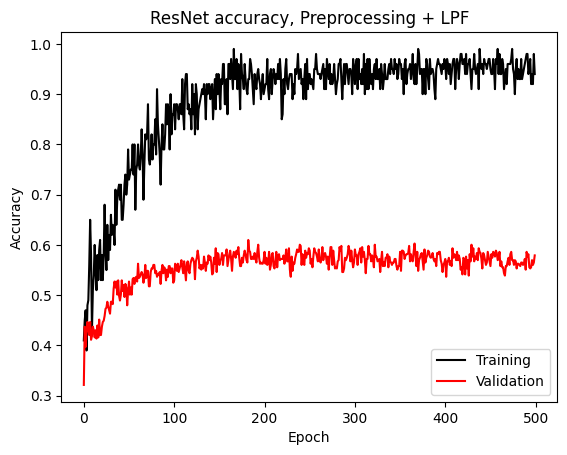

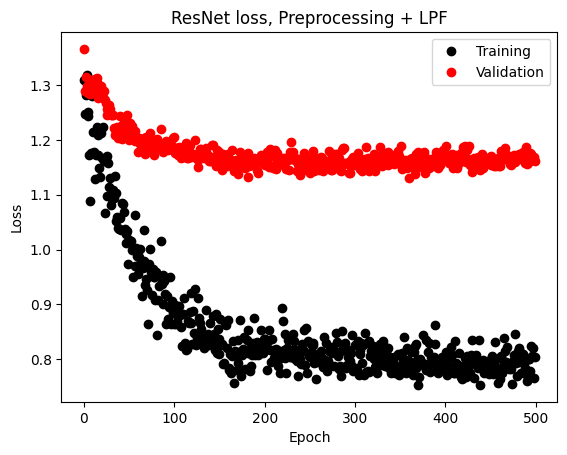

In [ ]:
#Update arrays and title
plt.plot(np.arange(num_epochs),train_history_3,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_3,label='Validation',color='r')
plt.title('ResNet accuracy, Preprocessing + LPF')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_3,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_3,'o',label='Validation',color='r')
plt.title('ResNet loss, Preprocessing + LPF')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Part 4: High pass filter after data preprocessing

In [ ]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

# Preprocessing the dataset
# pass only training data to train prep, val and test data to test prep

x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(x_test), test_data_prep(x_valid)

x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

# Convert x train to numpy

x_train_np = x_train.cpu().numpy()
print(x_train_np.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: torch.Size([6768, 22, 400])
Shape of validation set: torch.Size([423, 22, 400])
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([6768, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torc

In [ ]:
# Define the high-pass filter parameters
cutoff_frequency = 4  # Cut-off frequency in Hz
sampling_rate = 125  # Sampling rate in Hz (adjust based on your data)

# Design a Butterworth high-pass filter
order = 3  # Filter order
b, a = butter(N=order, Wn=cutoff_frequency / (0.5 * sampling_rate), btype='high', analog=False, output='ba')

x_train_hpf = np.zeros(x_train_np.shape)
# Apply the filter to the data
for i in range(x_train_np.shape[0]):
    for j in range(x_train_np.shape[2]):
        filtered_data = filtfilt(b, a, x_train_np[i,0,j,:])
        x_train_hpf[i,0,j,:] = filtered_data

x_train_hpf = torch.tensor(x_train_hpf).float().to(device)
print(x_train_hpf.shape)

torch.Size([6768, 1, 22, 400])


In [ ]:
#Build the model
model4 = ResNet(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model4)
total_params = sum(p.numel() for p in model4.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model4.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNet(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1): Con

In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_4, val_history_4 = np.array([]), np.array([])
train_loss_hist_4, val_loss_hist_4 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = '/content/drive/MyDrive/C147_Final_Project/best_model_params_CNN'

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model4_params.pt')
    torch.save(model4.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model4.train()

        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model4(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        #Rename
        model4.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model4(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_4 = np.append(train_history_4, train_acc.item())
        val_history_4 = np.append(val_history_4, val_acc.item())
        train_loss_hist_4 = np.append(train_loss_hist_4, loss.item())
        val_loss_hist_4 = np.append(val_loss_hist_4, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model4.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-42-4cfb9fe190fe>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:02<24:30,  2.95s/it]

Epoch 1 Finished!!!
Train acc: 0.390, Val acc: 0.366
Train loss: 1.331, Val loss: 1.334


  0%|          | 2/500 [00:05<24:10,  2.91s/it]

Epoch 2 Finished!!!
Train acc: 0.500, Val acc: 0.371
Train loss: 1.245, Val loss: 1.331


  1%|          | 3/500 [00:08<24:01,  2.90s/it]

Epoch 3 Finished!!!
Train acc: 0.460, Val acc: 0.418
Train loss: 1.280, Val loss: 1.311


  1%|          | 4/500 [00:11<23:57,  2.90s/it]

Epoch 4 Finished!!!
Train acc: 0.470, Val acc: 0.423
Train loss: 1.270, Val loss: 1.291


  1%|          | 5/500 [00:14<23:54,  2.90s/it]

Epoch 5 Finished!!!
Train acc: 0.580, Val acc: 0.440
Train loss: 1.174, Val loss: 1.274


  1%|          | 6/500 [00:17<23:55,  2.91s/it]

Epoch 6 Finished!!!
Train acc: 0.620, Val acc: 0.468
Train loss: 1.118, Val loss: 1.261


  1%|▏         | 7/500 [00:20<23:55,  2.91s/it]

Epoch 7 Finished!!!
Train acc: 0.590, Val acc: 0.485
Train loss: 1.134, Val loss: 1.245


  2%|▏         | 8/500 [00:23<23:51,  2.91s/it]

Epoch 8 Finished!!!
Train acc: 0.520, Val acc: 0.468
Train loss: 1.219, Val loss: 1.252


  2%|▏         | 9/500 [00:26<23:53,  2.92s/it]

Epoch 9 Finished!!!
Train acc: 0.470, Val acc: 0.501
Train loss: 1.245, Val loss: 1.229


  2%|▏         | 10/500 [00:29<23:51,  2.92s/it]

Epoch 10 Finished!!!
Train acc: 0.600, Val acc: 0.489
Train loss: 1.129, Val loss: 1.229


  2%|▏         | 11/500 [00:32<23:52,  2.93s/it]

Epoch 11 Finished!!!
Train acc: 0.580, Val acc: 0.489
Train loss: 1.146, Val loss: 1.236


  2%|▏         | 12/500 [00:35<23:55,  2.94s/it]

Epoch 12 Finished!!!
Train acc: 0.610, Val acc: 0.513
Train loss: 1.124, Val loss: 1.222


  3%|▎         | 13/500 [00:38<23:56,  2.95s/it]

Epoch 13 Finished!!!
Train acc: 0.560, Val acc: 0.515
Train loss: 1.157, Val loss: 1.228


  3%|▎         | 14/500 [00:41<24:00,  2.96s/it]

Epoch 14 Finished!!!
Train acc: 0.570, Val acc: 0.530
Train loss: 1.133, Val loss: 1.212


  3%|▎         | 15/500 [00:43<23:58,  2.97s/it]

Epoch 15 Finished!!!
Train acc: 0.620, Val acc: 0.530
Train loss: 1.128, Val loss: 1.194


  3%|▎         | 16/500 [00:46<23:56,  2.97s/it]

Epoch 16 Finished!!!
Train acc: 0.620, Val acc: 0.492
Train loss: 1.118, Val loss: 1.229


  3%|▎         | 17/500 [00:49<23:55,  2.97s/it]

Epoch 17 Finished!!!
Train acc: 0.560, Val acc: 0.520
Train loss: 1.165, Val loss: 1.213


  4%|▎         | 18/500 [00:52<23:53,  2.97s/it]

Epoch 18 Finished!!!
Train acc: 0.620, Val acc: 0.520
Train loss: 1.126, Val loss: 1.216


  4%|▍         | 19/500 [00:55<23:55,  2.98s/it]

Epoch 19 Finished!!!
Train acc: 0.630, Val acc: 0.532
Train loss: 1.105, Val loss: 1.207


  4%|▍         | 20/500 [00:58<23:48,  2.98s/it]

Epoch 20 Finished!!!
Train acc: 0.580, Val acc: 0.511
Train loss: 1.157, Val loss: 1.224


  4%|▍         | 21/500 [01:01<23:41,  2.97s/it]

Epoch 21 Finished!!!
Train acc: 0.630, Val acc: 0.522
Train loss: 1.094, Val loss: 1.209


  4%|▍         | 22/500 [01:04<23:35,  2.96s/it]

Epoch 22 Finished!!!
Train acc: 0.690, Val acc: 0.532
Train loss: 1.052, Val loss: 1.202


  5%|▍         | 23/500 [01:07<23:30,  2.96s/it]

Epoch 23 Finished!!!
Train acc: 0.650, Val acc: 0.508
Train loss: 1.078, Val loss: 1.220


  5%|▍         | 24/500 [01:10<23:24,  2.95s/it]

Epoch 24 Finished!!!
Train acc: 0.670, Val acc: 0.520
Train loss: 1.068, Val loss: 1.218


  5%|▌         | 25/500 [01:13<23:18,  2.94s/it]

Epoch 25 Finished!!!
Train acc: 0.540, Val acc: 0.530
Train loss: 1.193, Val loss: 1.210


  5%|▌         | 26/500 [01:16<23:15,  2.94s/it]

Epoch 26 Finished!!!
Train acc: 0.630, Val acc: 0.539
Train loss: 1.113, Val loss: 1.203


  5%|▌         | 27/500 [01:19<23:08,  2.93s/it]

Epoch 27 Finished!!!
Train acc: 0.630, Val acc: 0.522
Train loss: 1.124, Val loss: 1.211


  6%|▌         | 28/500 [01:22<23:03,  2.93s/it]

Epoch 28 Finished!!!
Train acc: 0.650, Val acc: 0.508
Train loss: 1.070, Val loss: 1.213


  6%|▌         | 29/500 [01:25<22:58,  2.93s/it]

Epoch 29 Finished!!!
Train acc: 0.690, Val acc: 0.525
Train loss: 1.058, Val loss: 1.205


  6%|▌         | 30/500 [01:28<22:54,  2.92s/it]

Epoch 30 Finished!!!
Train acc: 0.600, Val acc: 0.508
Train loss: 1.122, Val loss: 1.224


  6%|▌         | 31/500 [01:31<22:50,  2.92s/it]

Epoch 31 Finished!!!
Train acc: 0.710, Val acc: 0.520
Train loss: 1.032, Val loss: 1.212


  6%|▋         | 32/500 [01:34<22:47,  2.92s/it]

Epoch 32 Finished!!!
Train acc: 0.640, Val acc: 0.508
Train loss: 1.099, Val loss: 1.226


  7%|▋         | 33/500 [01:36<22:45,  2.92s/it]

Epoch 33 Finished!!!
Train acc: 0.630, Val acc: 0.515
Train loss: 1.105, Val loss: 1.218


  7%|▋         | 34/500 [01:39<22:42,  2.92s/it]

Epoch 34 Finished!!!
Train acc: 0.660, Val acc: 0.530
Train loss: 1.089, Val loss: 1.197


  7%|▋         | 35/500 [01:42<22:40,  2.92s/it]

Epoch 35 Finished!!!
Train acc: 0.740, Val acc: 0.532
Train loss: 0.999, Val loss: 1.208


  7%|▋         | 36/500 [01:45<22:38,  2.93s/it]

Epoch 36 Finished!!!
Train acc: 0.800, Val acc: 0.527
Train loss: 0.955, Val loss: 1.208


  7%|▋         | 37/500 [01:48<22:38,  2.93s/it]

Epoch 37 Finished!!!
Train acc: 0.690, Val acc: 0.522
Train loss: 1.057, Val loss: 1.212


  8%|▊         | 38/500 [01:51<22:36,  2.94s/it]

Epoch 38 Finished!!!
Train acc: 0.770, Val acc: 0.532
Train loss: 0.980, Val loss: 1.202


  8%|▊         | 39/500 [01:54<22:34,  2.94s/it]

Epoch 39 Finished!!!
Train acc: 0.710, Val acc: 0.527
Train loss: 1.044, Val loss: 1.199


  8%|▊         | 40/500 [01:57<22:33,  2.94s/it]

Epoch 40 Finished!!!
Train acc: 0.700, Val acc: 0.537
Train loss: 1.025, Val loss: 1.198


  8%|▊         | 41/500 [02:00<22:32,  2.95s/it]

Epoch 41 Finished!!!
Train acc: 0.730, Val acc: 0.537
Train loss: 1.037, Val loss: 1.201


  8%|▊         | 42/500 [02:03<22:32,  2.95s/it]

Epoch 42 Finished!!!
Train acc: 0.690, Val acc: 0.546
Train loss: 1.043, Val loss: 1.179


  9%|▊         | 43/500 [02:06<22:31,  2.96s/it]

Epoch 43 Finished!!!
Train acc: 0.760, Val acc: 0.551
Train loss: 0.996, Val loss: 1.178


  9%|▉         | 44/500 [02:09<22:27,  2.95s/it]

Epoch 44 Finished!!!
Train acc: 0.810, Val acc: 0.541
Train loss: 0.936, Val loss: 1.195


  9%|▉         | 45/500 [02:12<22:24,  2.95s/it]

Epoch 45 Finished!!!
Train acc: 0.660, Val acc: 0.537
Train loss: 1.069, Val loss: 1.196


  9%|▉         | 46/500 [02:15<22:22,  2.96s/it]

Epoch 46 Finished!!!
Train acc: 0.760, Val acc: 0.558
Train loss: 0.989, Val loss: 1.184


  9%|▉         | 47/500 [02:18<22:17,  2.95s/it]

Epoch 47 Finished!!!
Train acc: 0.700, Val acc: 0.537
Train loss: 1.043, Val loss: 1.197


 10%|▉         | 48/500 [02:21<22:12,  2.95s/it]

Epoch 48 Finished!!!
Train acc: 0.730, Val acc: 0.548
Train loss: 1.019, Val loss: 1.185


 10%|▉         | 49/500 [02:24<22:12,  2.95s/it]

Epoch 49 Finished!!!
Train acc: 0.760, Val acc: 0.563
Train loss: 0.988, Val loss: 1.180


 10%|█         | 50/500 [02:27<22:07,  2.95s/it]

Epoch 50 Finished!!!
Train acc: 0.690, Val acc: 0.553
Train loss: 1.045, Val loss: 1.175


 10%|█         | 51/500 [02:30<22:02,  2.95s/it]

Epoch 51 Finished!!!
Train acc: 0.750, Val acc: 0.553
Train loss: 1.002, Val loss: 1.179


 10%|█         | 52/500 [02:32<21:58,  2.94s/it]

Epoch 52 Finished!!!
Train acc: 0.760, Val acc: 0.548
Train loss: 0.986, Val loss: 1.187


 11%|█         | 53/500 [02:35<21:55,  2.94s/it]

Epoch 53 Finished!!!
Train acc: 0.830, Val acc: 0.546
Train loss: 0.917, Val loss: 1.188


 11%|█         | 54/500 [02:38<21:51,  2.94s/it]

Epoch 54 Finished!!!
Train acc: 0.780, Val acc: 0.551
Train loss: 0.979, Val loss: 1.179


 11%|█         | 55/500 [02:41<21:48,  2.94s/it]

Epoch 55 Finished!!!
Train acc: 0.770, Val acc: 0.558
Train loss: 0.985, Val loss: 1.184


 11%|█         | 56/500 [02:44<21:44,  2.94s/it]

Epoch 56 Finished!!!
Train acc: 0.790, Val acc: 0.539
Train loss: 0.961, Val loss: 1.195


 11%|█▏        | 57/500 [02:47<21:41,  2.94s/it]

Epoch 57 Finished!!!
Train acc: 0.760, Val acc: 0.544
Train loss: 0.992, Val loss: 1.193


 12%|█▏        | 58/500 [02:50<21:39,  2.94s/it]

Epoch 58 Finished!!!
Train acc: 0.790, Val acc: 0.539
Train loss: 0.943, Val loss: 1.195


 12%|█▏        | 59/500 [02:53<21:36,  2.94s/it]

Epoch 59 Finished!!!
Train acc: 0.800, Val acc: 0.546
Train loss: 0.953, Val loss: 1.185


 12%|█▏        | 60/500 [02:56<21:32,  2.94s/it]

Epoch 60 Finished!!!
Train acc: 0.800, Val acc: 0.541
Train loss: 0.963, Val loss: 1.192


 12%|█▏        | 61/500 [02:59<21:29,  2.94s/it]

Epoch 61 Finished!!!
Train acc: 0.800, Val acc: 0.560
Train loss: 0.939, Val loss: 1.175


 12%|█▏        | 62/500 [03:02<21:32,  2.95s/it]

Epoch 62 Finished!!!
Train acc: 0.730, Val acc: 0.574
Train loss: 1.017, Val loss: 1.166


 13%|█▎        | 63/500 [03:05<21:30,  2.95s/it]

Epoch 63 Finished!!!
Train acc: 0.860, Val acc: 0.553
Train loss: 0.897, Val loss: 1.182


 13%|█▎        | 64/500 [03:08<21:28,  2.95s/it]

Epoch 64 Finished!!!
Train acc: 0.830, Val acc: 0.574
Train loss: 0.908, Val loss: 1.171


 13%|█▎        | 65/500 [03:11<21:23,  2.95s/it]

Epoch 65 Finished!!!
Train acc: 0.840, Val acc: 0.556
Train loss: 0.900, Val loss: 1.175


 13%|█▎        | 66/500 [03:14<21:20,  2.95s/it]

Epoch 66 Finished!!!
Train acc: 0.710, Val acc: 0.556
Train loss: 1.015, Val loss: 1.179


 13%|█▎        | 67/500 [03:17<21:17,  2.95s/it]

Epoch 67 Finished!!!
Train acc: 0.800, Val acc: 0.537
Train loss: 0.926, Val loss: 1.188


 14%|█▎        | 68/500 [03:20<21:12,  2.95s/it]

Epoch 68 Finished!!!
Train acc: 0.820, Val acc: 0.548
Train loss: 0.907, Val loss: 1.186


 14%|█▍        | 69/500 [03:23<21:08,  2.94s/it]

Epoch 69 Finished!!!
Train acc: 0.860, Val acc: 0.563
Train loss: 0.898, Val loss: 1.169


 14%|█▍        | 70/500 [03:25<21:05,  2.94s/it]

Epoch 70 Finished!!!
Train acc: 0.800, Val acc: 0.544
Train loss: 0.950, Val loss: 1.186


 14%|█▍        | 71/500 [03:28<21:02,  2.94s/it]

Epoch 71 Finished!!!
Train acc: 0.840, Val acc: 0.539
Train loss: 0.914, Val loss: 1.194


 14%|█▍        | 72/500 [03:31<21:00,  2.95s/it]

Epoch 72 Finished!!!
Train acc: 0.820, Val acc: 0.567
Train loss: 0.913, Val loss: 1.168


 15%|█▍        | 73/500 [03:34<20:57,  2.94s/it]

Epoch 73 Finished!!!
Train acc: 0.790, Val acc: 0.558
Train loss: 0.942, Val loss: 1.181


 15%|█▍        | 74/500 [03:37<20:53,  2.94s/it]

Epoch 74 Finished!!!
Train acc: 0.810, Val acc: 0.541
Train loss: 0.941, Val loss: 1.181


 15%|█▌        | 75/500 [03:40<20:51,  2.94s/it]

Epoch 75 Finished!!!
Train acc: 0.860, Val acc: 0.548
Train loss: 0.891, Val loss: 1.177


 15%|█▌        | 76/500 [03:43<20:49,  2.95s/it]

Epoch 76 Finished!!!
Train acc: 0.840, Val acc: 0.548
Train loss: 0.904, Val loss: 1.189


 15%|█▌        | 77/500 [03:46<20:46,  2.95s/it]

Epoch 77 Finished!!!
Train acc: 0.760, Val acc: 0.556
Train loss: 0.964, Val loss: 1.180


 16%|█▌        | 78/500 [03:49<20:42,  2.94s/it]

Epoch 78 Finished!!!
Train acc: 0.850, Val acc: 0.572
Train loss: 0.902, Val loss: 1.171


 16%|█▌        | 79/500 [03:52<20:39,  2.94s/it]

Epoch 79 Finished!!!
Train acc: 0.840, Val acc: 0.567
Train loss: 0.906, Val loss: 1.175


 16%|█▌        | 80/500 [03:55<20:37,  2.95s/it]

Epoch 80 Finished!!!
Train acc: 0.840, Val acc: 0.544
Train loss: 0.902, Val loss: 1.188


 16%|█▌        | 81/500 [03:58<20:33,  2.94s/it]

Epoch 81 Finished!!!
Train acc: 0.890, Val acc: 0.572
Train loss: 0.848, Val loss: 1.168


 16%|█▋        | 82/500 [04:01<20:30,  2.94s/it]

Epoch 82 Finished!!!
Train acc: 0.900, Val acc: 0.548
Train loss: 0.856, Val loss: 1.188


 17%|█▋        | 83/500 [04:04<20:27,  2.94s/it]

Epoch 83 Finished!!!
Train acc: 0.860, Val acc: 0.565
Train loss: 0.886, Val loss: 1.177


 17%|█▋        | 84/500 [04:07<20:24,  2.94s/it]

Epoch 84 Finished!!!
Train acc: 0.860, Val acc: 0.520
Train loss: 0.899, Val loss: 1.201


 17%|█▋        | 85/500 [04:10<20:22,  2.95s/it]

Epoch 85 Finished!!!
Train acc: 0.850, Val acc: 0.544
Train loss: 0.900, Val loss: 1.186


 17%|█▋        | 86/500 [04:13<20:19,  2.94s/it]

Epoch 86 Finished!!!
Train acc: 0.790, Val acc: 0.551
Train loss: 0.949, Val loss: 1.182


 17%|█▋        | 87/500 [04:16<20:15,  2.94s/it]

Epoch 87 Finished!!!
Train acc: 0.830, Val acc: 0.570
Train loss: 0.916, Val loss: 1.173


 18%|█▊        | 88/500 [04:18<20:16,  2.95s/it]

Epoch 88 Finished!!!
Train acc: 0.790, Val acc: 0.582
Train loss: 0.934, Val loss: 1.164


 18%|█▊        | 89/500 [04:21<20:12,  2.95s/it]

Epoch 89 Finished!!!
Train acc: 0.900, Val acc: 0.548
Train loss: 0.854, Val loss: 1.191


 18%|█▊        | 90/500 [04:24<20:09,  2.95s/it]

Epoch 90 Finished!!!
Train acc: 0.800, Val acc: 0.560
Train loss: 0.922, Val loss: 1.178


 18%|█▊        | 91/500 [04:27<20:05,  2.95s/it]

Epoch 91 Finished!!!
Train acc: 0.910, Val acc: 0.563
Train loss: 0.822, Val loss: 1.176


 18%|█▊        | 92/500 [04:30<20:01,  2.95s/it]

Epoch 92 Finished!!!
Train acc: 0.890, Val acc: 0.551
Train loss: 0.848, Val loss: 1.180


 19%|█▊        | 93/500 [04:33<19:59,  2.95s/it]

Epoch 93 Finished!!!
Train acc: 0.840, Val acc: 0.548
Train loss: 0.909, Val loss: 1.188


 19%|█▉        | 94/500 [04:36<19:55,  2.95s/it]

Epoch 94 Finished!!!
Train acc: 0.890, Val acc: 0.541
Train loss: 0.855, Val loss: 1.187


 19%|█▉        | 95/500 [04:39<19:52,  2.94s/it]

Epoch 95 Finished!!!
Train acc: 0.870, Val acc: 0.556
Train loss: 0.877, Val loss: 1.178


 19%|█▉        | 96/500 [04:42<19:49,  2.94s/it]

Epoch 96 Finished!!!
Train acc: 0.860, Val acc: 0.530
Train loss: 0.883, Val loss: 1.195


 19%|█▉        | 97/500 [04:45<19:47,  2.95s/it]

Epoch 97 Finished!!!
Train acc: 0.890, Val acc: 0.565
Train loss: 0.852, Val loss: 1.166


 20%|█▉        | 98/500 [04:48<19:44,  2.95s/it]

Epoch 98 Finished!!!
Train acc: 0.870, Val acc: 0.548
Train loss: 0.887, Val loss: 1.181


 20%|█▉        | 99/500 [04:51<19:41,  2.95s/it]

Epoch 99 Finished!!!
Train acc: 0.910, Val acc: 0.534
Train loss: 0.839, Val loss: 1.182


 20%|██        | 100/500 [04:54<19:37,  2.94s/it]

Epoch 100 Finished!!!
Train acc: 0.840, Val acc: 0.551
Train loss: 0.902, Val loss: 1.185


 20%|██        | 101/500 [04:57<19:35,  2.95s/it]

Epoch 101 Finished!!!
Train acc: 0.820, Val acc: 0.546
Train loss: 0.924, Val loss: 1.193


 20%|██        | 102/500 [05:00<19:33,  2.95s/it]

Epoch 102 Finished!!!
Train acc: 0.870, Val acc: 0.539
Train loss: 0.865, Val loss: 1.191


 21%|██        | 103/500 [05:03<19:30,  2.95s/it]

Epoch 103 Finished!!!
Train acc: 0.920, Val acc: 0.548
Train loss: 0.830, Val loss: 1.179


 21%|██        | 104/500 [05:06<19:26,  2.95s/it]

Epoch 104 Finished!!!
Train acc: 0.870, Val acc: 0.548
Train loss: 0.885, Val loss: 1.178


 21%|██        | 105/500 [05:09<19:23,  2.95s/it]

Epoch 105 Finished!!!
Train acc: 0.900, Val acc: 0.548
Train loss: 0.843, Val loss: 1.194


 21%|██        | 106/500 [05:12<19:21,  2.95s/it]

Epoch 106 Finished!!!
Train acc: 0.900, Val acc: 0.556
Train loss: 0.850, Val loss: 1.184


 21%|██▏       | 107/500 [05:14<19:17,  2.95s/it]

Epoch 107 Finished!!!
Train acc: 0.910, Val acc: 0.534
Train loss: 0.837, Val loss: 1.189


 22%|██▏       | 108/500 [05:17<19:14,  2.95s/it]

Epoch 108 Finished!!!
Train acc: 0.880, Val acc: 0.546
Train loss: 0.856, Val loss: 1.186


 22%|██▏       | 109/500 [05:20<19:11,  2.94s/it]

Epoch 109 Finished!!!
Train acc: 0.890, Val acc: 0.534
Train loss: 0.851, Val loss: 1.194


 22%|██▏       | 110/500 [05:23<19:08,  2.95s/it]

Epoch 110 Finished!!!
Train acc: 0.880, Val acc: 0.534
Train loss: 0.878, Val loss: 1.192


 22%|██▏       | 111/500 [05:26<19:06,  2.95s/it]

Epoch 111 Finished!!!
Train acc: 0.910, Val acc: 0.558
Train loss: 0.838, Val loss: 1.182


 22%|██▏       | 112/500 [05:29<19:03,  2.95s/it]

Epoch 112 Finished!!!
Train acc: 0.890, Val acc: 0.527
Train loss: 0.857, Val loss: 1.199


 23%|██▎       | 113/500 [05:32<18:59,  2.95s/it]

Epoch 113 Finished!!!
Train acc: 0.930, Val acc: 0.551
Train loss: 0.818, Val loss: 1.185


 23%|██▎       | 114/500 [05:35<18:56,  2.94s/it]

Epoch 114 Finished!!!
Train acc: 0.870, Val acc: 0.544
Train loss: 0.867, Val loss: 1.189


 23%|██▎       | 115/500 [05:38<18:53,  2.95s/it]

Epoch 115 Finished!!!
Train acc: 0.870, Val acc: 0.541
Train loss: 0.872, Val loss: 1.188


 23%|██▎       | 116/500 [05:41<18:50,  2.95s/it]

Epoch 116 Finished!!!
Train acc: 0.830, Val acc: 0.544
Train loss: 0.906, Val loss: 1.184


 23%|██▎       | 117/500 [05:44<18:48,  2.95s/it]

Epoch 117 Finished!!!
Train acc: 0.950, Val acc: 0.539
Train loss: 0.799, Val loss: 1.195


 24%|██▎       | 118/500 [05:47<18:44,  2.94s/it]

Epoch 118 Finished!!!
Train acc: 0.840, Val acc: 0.548
Train loss: 0.903, Val loss: 1.184


 24%|██▍       | 119/500 [05:50<18:53,  2.98s/it]

Epoch 119 Finished!!!
Train acc: 0.870, Val acc: 0.541
Train loss: 0.873, Val loss: 1.193


 24%|██▍       | 120/500 [05:53<19:00,  3.00s/it]

Epoch 120 Finished!!!
Train acc: 0.870, Val acc: 0.560
Train loss: 0.879, Val loss: 1.170


 24%|██▍       | 121/500 [05:56<19:02,  3.01s/it]

Epoch 121 Finished!!!
Train acc: 0.800, Val acc: 0.546
Train loss: 0.942, Val loss: 1.183


 24%|██▍       | 122/500 [05:59<19:22,  3.08s/it]

Epoch 122 Finished!!!
Train acc: 0.860, Val acc: 0.539
Train loss: 0.891, Val loss: 1.192


 25%|██▍       | 123/500 [06:02<19:40,  3.13s/it]

Epoch 123 Finished!!!
Train acc: 0.910, Val acc: 0.563
Train loss: 0.825, Val loss: 1.176


 25%|██▍       | 124/500 [06:05<19:17,  3.08s/it]

Epoch 124 Finished!!!
Train acc: 0.860, Val acc: 0.563
Train loss: 0.881, Val loss: 1.171


 25%|██▌       | 125/500 [06:08<19:06,  3.06s/it]

Epoch 125 Finished!!!
Train acc: 0.920, Val acc: 0.558
Train loss: 0.831, Val loss: 1.174


 25%|██▌       | 126/500 [06:11<18:52,  3.03s/it]

Epoch 126 Finished!!!
Train acc: 0.850, Val acc: 0.563
Train loss: 0.889, Val loss: 1.169


 25%|██▌       | 127/500 [06:14<18:43,  3.01s/it]

Epoch 127 Finished!!!
Train acc: 0.910, Val acc: 0.551
Train loss: 0.833, Val loss: 1.189


 26%|██▌       | 128/500 [06:17<18:49,  3.04s/it]

Epoch 128 Finished!!!
Train acc: 0.850, Val acc: 0.551
Train loss: 0.891, Val loss: 1.177


 26%|██▌       | 129/500 [06:20<18:45,  3.03s/it]

Epoch 129 Finished!!!
Train acc: 0.860, Val acc: 0.565
Train loss: 0.880, Val loss: 1.175


 26%|██▌       | 130/500 [06:23<18:37,  3.02s/it]

Epoch 130 Finished!!!
Train acc: 0.890, Val acc: 0.558
Train loss: 0.852, Val loss: 1.176


 26%|██▌       | 131/500 [06:26<18:29,  3.01s/it]

Epoch 131 Finished!!!
Train acc: 0.870, Val acc: 0.563
Train loss: 0.878, Val loss: 1.172


 26%|██▋       | 132/500 [06:30<18:36,  3.03s/it]

Epoch 132 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.793, Val loss: 1.179


 27%|██▋       | 133/500 [06:33<18:35,  3.04s/it]

Epoch 133 Finished!!!
Train acc: 0.910, Val acc: 0.560
Train loss: 0.815, Val loss: 1.173


 27%|██▋       | 134/500 [06:36<18:21,  3.01s/it]

Epoch 134 Finished!!!
Train acc: 0.850, Val acc: 0.556
Train loss: 0.892, Val loss: 1.175


 27%|██▋       | 135/500 [06:39<18:12,  2.99s/it]

Epoch 135 Finished!!!
Train acc: 0.900, Val acc: 0.548
Train loss: 0.847, Val loss: 1.180


 27%|██▋       | 136/500 [06:41<18:09,  2.99s/it]

Epoch 136 Finished!!!
Train acc: 0.900, Val acc: 0.541
Train loss: 0.854, Val loss: 1.194


 27%|██▋       | 137/500 [06:45<18:17,  3.02s/it]

Epoch 137 Finished!!!
Train acc: 0.920, Val acc: 0.544
Train loss: 0.822, Val loss: 1.190


 28%|██▊       | 138/500 [06:48<18:17,  3.03s/it]

Epoch 138 Finished!!!
Train acc: 0.900, Val acc: 0.563
Train loss: 0.847, Val loss: 1.174


 28%|██▊       | 139/500 [06:51<18:33,  3.09s/it]

Epoch 139 Finished!!!
Train acc: 0.920, Val acc: 0.567
Train loss: 0.817, Val loss: 1.172


 28%|██▊       | 140/500 [06:54<18:40,  3.11s/it]

Epoch 140 Finished!!!
Train acc: 0.910, Val acc: 0.565
Train loss: 0.843, Val loss: 1.176


 28%|██▊       | 141/500 [06:57<18:36,  3.11s/it]

Epoch 141 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.826, Val loss: 1.175


 28%|██▊       | 142/500 [07:00<18:18,  3.07s/it]

Epoch 142 Finished!!!
Train acc: 0.890, Val acc: 0.565
Train loss: 0.853, Val loss: 1.167


 29%|██▊       | 143/500 [07:03<18:07,  3.05s/it]

Epoch 143 Finished!!!
Train acc: 0.940, Val acc: 0.579
Train loss: 0.805, Val loss: 1.159


 29%|██▉       | 144/500 [07:06<17:58,  3.03s/it]

Epoch 144 Finished!!!
Train acc: 0.890, Val acc: 0.548
Train loss: 0.855, Val loss: 1.182


 29%|██▉       | 145/500 [07:09<17:58,  3.04s/it]

Epoch 145 Finished!!!
Train acc: 0.870, Val acc: 0.544
Train loss: 0.875, Val loss: 1.183


 29%|██▉       | 146/500 [07:12<17:55,  3.04s/it]

Epoch 146 Finished!!!
Train acc: 0.910, Val acc: 0.558
Train loss: 0.834, Val loss: 1.176


 29%|██▉       | 147/500 [07:15<18:03,  3.07s/it]

Epoch 147 Finished!!!
Train acc: 0.930, Val acc: 0.558
Train loss: 0.822, Val loss: 1.178


 30%|██▉       | 148/500 [07:18<18:03,  3.08s/it]

Epoch 148 Finished!!!
Train acc: 0.930, Val acc: 0.565
Train loss: 0.820, Val loss: 1.167


 30%|██▉       | 149/500 [07:21<17:53,  3.06s/it]

Epoch 149 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.796, Val loss: 1.186


 30%|███       | 150/500 [07:25<17:53,  3.07s/it]

Epoch 150 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.818, Val loss: 1.177


 30%|███       | 151/500 [07:27<17:37,  3.03s/it]

Epoch 151 Finished!!!
Train acc: 0.890, Val acc: 0.560
Train loss: 0.858, Val loss: 1.174


 30%|███       | 152/500 [07:30<17:25,  3.00s/it]

Epoch 152 Finished!!!
Train acc: 0.940, Val acc: 0.579
Train loss: 0.804, Val loss: 1.167


 31%|███       | 153/500 [07:33<17:16,  2.99s/it]

Epoch 153 Finished!!!
Train acc: 0.870, Val acc: 0.572
Train loss: 0.875, Val loss: 1.163


 31%|███       | 154/500 [07:36<17:09,  2.98s/it]

Epoch 154 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.802, Val loss: 1.170


 31%|███       | 155/500 [07:39<17:03,  2.97s/it]

Epoch 155 Finished!!!
Train acc: 0.870, Val acc: 0.560
Train loss: 0.869, Val loss: 1.176


 31%|███       | 156/500 [07:42<17:00,  2.97s/it]

Epoch 156 Finished!!!
Train acc: 0.930, Val acc: 0.570
Train loss: 0.820, Val loss: 1.172


 31%|███▏      | 157/500 [07:45<16:55,  2.96s/it]

Epoch 157 Finished!!!
Train acc: 0.880, Val acc: 0.574
Train loss: 0.860, Val loss: 1.169


 32%|███▏      | 158/500 [07:48<16:57,  2.98s/it]

Epoch 158 Finished!!!
Train acc: 0.940, Val acc: 0.574
Train loss: 0.808, Val loss: 1.160


 32%|███▏      | 159/500 [07:51<17:27,  3.07s/it]

Epoch 159 Finished!!!
Train acc: 0.900, Val acc: 0.572
Train loss: 0.846, Val loss: 1.163


 32%|███▏      | 160/500 [07:54<17:13,  3.04s/it]

Epoch 160 Finished!!!
Train acc: 0.870, Val acc: 0.553
Train loss: 0.875, Val loss: 1.186


 32%|███▏      | 161/500 [07:57<17:02,  3.02s/it]

Epoch 161 Finished!!!
Train acc: 0.890, Val acc: 0.560
Train loss: 0.856, Val loss: 1.179


 32%|███▏      | 162/500 [08:01<17:12,  3.05s/it]

Epoch 162 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.801, Val loss: 1.187


 33%|███▎      | 163/500 [08:04<17:52,  3.18s/it]

Epoch 163 Finished!!!
Train acc: 0.900, Val acc: 0.551
Train loss: 0.844, Val loss: 1.183


 33%|███▎      | 164/500 [08:07<17:27,  3.12s/it]

Epoch 164 Finished!!!
Train acc: 0.890, Val acc: 0.553
Train loss: 0.853, Val loss: 1.180


 33%|███▎      | 165/500 [08:10<17:28,  3.13s/it]

Epoch 165 Finished!!!
Train acc: 0.890, Val acc: 0.570
Train loss: 0.862, Val loss: 1.170


 33%|███▎      | 166/500 [08:13<17:08,  3.08s/it]

Epoch 166 Finished!!!
Train acc: 0.890, Val acc: 0.556
Train loss: 0.855, Val loss: 1.177


 33%|███▎      | 167/500 [08:16<17:29,  3.15s/it]

Epoch 167 Finished!!!
Train acc: 0.870, Val acc: 0.537
Train loss: 0.866, Val loss: 1.195


 34%|███▎      | 168/500 [08:20<17:41,  3.20s/it]

Epoch 168 Finished!!!
Train acc: 0.940, Val acc: 0.556
Train loss: 0.807, Val loss: 1.180


 34%|███▍      | 169/500 [08:23<17:15,  3.13s/it]

Epoch 169 Finished!!!
Train acc: 0.880, Val acc: 0.572
Train loss: 0.860, Val loss: 1.171


 34%|███▍      | 170/500 [08:26<16:55,  3.08s/it]

Epoch 170 Finished!!!
Train acc: 0.910, Val acc: 0.548
Train loss: 0.835, Val loss: 1.179


 34%|███▍      | 171/500 [08:29<16:39,  3.04s/it]

Epoch 171 Finished!!!
Train acc: 0.940, Val acc: 0.567
Train loss: 0.811, Val loss: 1.165


 34%|███▍      | 172/500 [08:32<16:27,  3.01s/it]

Epoch 172 Finished!!!
Train acc: 0.880, Val acc: 0.558
Train loss: 0.864, Val loss: 1.178


 35%|███▍      | 173/500 [08:34<16:17,  2.99s/it]

Epoch 173 Finished!!!
Train acc: 0.910, Val acc: 0.541
Train loss: 0.834, Val loss: 1.191


 35%|███▍      | 174/500 [08:37<16:09,  2.98s/it]

Epoch 174 Finished!!!
Train acc: 0.930, Val acc: 0.570
Train loss: 0.812, Val loss: 1.164


 35%|███▌      | 175/500 [08:40<16:03,  2.96s/it]

Epoch 175 Finished!!!
Train acc: 0.930, Val acc: 0.553
Train loss: 0.818, Val loss: 1.180


 35%|███▌      | 176/500 [08:43<15:59,  2.96s/it]

Epoch 176 Finished!!!
Train acc: 0.880, Val acc: 0.544
Train loss: 0.861, Val loss: 1.187


 35%|███▌      | 177/500 [08:46<15:54,  2.95s/it]

Epoch 177 Finished!!!
Train acc: 0.870, Val acc: 0.577
Train loss: 0.880, Val loss: 1.169


 36%|███▌      | 178/500 [08:49<15:50,  2.95s/it]

Epoch 178 Finished!!!
Train acc: 0.890, Val acc: 0.551
Train loss: 0.851, Val loss: 1.181


 36%|███▌      | 179/500 [08:52<15:46,  2.95s/it]

Epoch 179 Finished!!!
Train acc: 0.900, Val acc: 0.560
Train loss: 0.844, Val loss: 1.176


 36%|███▌      | 180/500 [08:55<15:43,  2.95s/it]

Epoch 180 Finished!!!
Train acc: 0.880, Val acc: 0.553
Train loss: 0.861, Val loss: 1.182


 36%|███▌      | 181/500 [08:58<15:40,  2.95s/it]

Epoch 181 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.825, Val loss: 1.182


 36%|███▋      | 182/500 [09:01<15:37,  2.95s/it]

Epoch 182 Finished!!!
Train acc: 0.890, Val acc: 0.548
Train loss: 0.861, Val loss: 1.188


 37%|███▋      | 183/500 [09:04<15:33,  2.95s/it]

Epoch 183 Finished!!!
Train acc: 0.920, Val acc: 0.551
Train loss: 0.824, Val loss: 1.183


 37%|███▋      | 184/500 [09:07<15:30,  2.95s/it]

Epoch 184 Finished!!!
Train acc: 0.890, Val acc: 0.548
Train loss: 0.857, Val loss: 1.183


 37%|███▋      | 185/500 [09:10<15:30,  2.95s/it]

Epoch 185 Finished!!!
Train acc: 0.900, Val acc: 0.593
Train loss: 0.841, Val loss: 1.150


 37%|███▋      | 186/500 [09:13<15:25,  2.95s/it]

Epoch 186 Finished!!!
Train acc: 0.880, Val acc: 0.546
Train loss: 0.869, Val loss: 1.187


 37%|███▋      | 187/500 [09:16<15:22,  2.95s/it]

Epoch 187 Finished!!!
Train acc: 0.890, Val acc: 0.563
Train loss: 0.856, Val loss: 1.176


 38%|███▊      | 188/500 [09:19<15:18,  2.94s/it]

Epoch 188 Finished!!!
Train acc: 0.890, Val acc: 0.570
Train loss: 0.855, Val loss: 1.165


 38%|███▊      | 189/500 [09:22<15:16,  2.95s/it]

Epoch 189 Finished!!!
Train acc: 0.880, Val acc: 0.593
Train loss: 0.867, Val loss: 1.153


 38%|███▊      | 190/500 [09:25<15:13,  2.95s/it]

Epoch 190 Finished!!!
Train acc: 0.900, Val acc: 0.570
Train loss: 0.831, Val loss: 1.171


 38%|███▊      | 191/500 [09:28<15:10,  2.95s/it]

Epoch 191 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.805, Val loss: 1.176


 38%|███▊      | 192/500 [09:30<15:07,  2.94s/it]

Epoch 192 Finished!!!
Train acc: 0.880, Val acc: 0.553
Train loss: 0.862, Val loss: 1.180


 39%|███▊      | 193/500 [09:33<15:04,  2.95s/it]

Epoch 193 Finished!!!
Train acc: 0.920, Val acc: 0.567
Train loss: 0.825, Val loss: 1.168


 39%|███▉      | 194/500 [09:36<15:01,  2.95s/it]

Epoch 194 Finished!!!
Train acc: 0.840, Val acc: 0.541
Train loss: 0.900, Val loss: 1.186


 39%|███▉      | 195/500 [09:39<15:05,  2.97s/it]

Epoch 195 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.797, Val loss: 1.184


 39%|███▉      | 196/500 [09:42<15:00,  2.96s/it]

Epoch 196 Finished!!!
Train acc: 0.930, Val acc: 0.565
Train loss: 0.816, Val loss: 1.180


 39%|███▉      | 197/500 [09:45<14:55,  2.96s/it]

Epoch 197 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.799, Val loss: 1.174


 40%|███▉      | 198/500 [09:48<14:51,  2.95s/it]

Epoch 198 Finished!!!
Train acc: 0.950, Val acc: 0.574
Train loss: 0.794, Val loss: 1.164


 40%|███▉      | 199/500 [09:51<14:48,  2.95s/it]

Epoch 199 Finished!!!
Train acc: 0.920, Val acc: 0.548
Train loss: 0.831, Val loss: 1.185


 40%|████      | 200/500 [09:54<14:44,  2.95s/it]

Epoch 200 Finished!!!
Train acc: 0.910, Val acc: 0.551
Train loss: 0.835, Val loss: 1.179


 40%|████      | 201/500 [09:57<14:41,  2.95s/it]

Epoch 201 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.799, Val loss: 1.172


 40%|████      | 202/500 [10:00<14:38,  2.95s/it]

Epoch 202 Finished!!!
Train acc: 0.910, Val acc: 0.574
Train loss: 0.836, Val loss: 1.158


 41%|████      | 203/500 [10:03<14:35,  2.95s/it]

Epoch 203 Finished!!!
Train acc: 0.930, Val acc: 0.558
Train loss: 0.821, Val loss: 1.177


 41%|████      | 204/500 [10:06<14:38,  2.97s/it]

Epoch 204 Finished!!!
Train acc: 0.920, Val acc: 0.558
Train loss: 0.825, Val loss: 1.175


 41%|████      | 205/500 [10:09<14:33,  2.96s/it]

Epoch 205 Finished!!!
Train acc: 0.970, Val acc: 0.570
Train loss: 0.774, Val loss: 1.169


 41%|████      | 206/500 [10:12<14:29,  2.96s/it]

Epoch 206 Finished!!!
Train acc: 0.860, Val acc: 0.553
Train loss: 0.889, Val loss: 1.180


 41%|████▏     | 207/500 [10:15<14:25,  2.95s/it]

Epoch 207 Finished!!!
Train acc: 0.950, Val acc: 0.544
Train loss: 0.800, Val loss: 1.184


 42%|████▏     | 208/500 [10:18<14:21,  2.95s/it]

Epoch 208 Finished!!!
Train acc: 0.900, Val acc: 0.537
Train loss: 0.841, Val loss: 1.194


 42%|████▏     | 209/500 [10:21<14:17,  2.95s/it]

Epoch 209 Finished!!!
Train acc: 0.930, Val acc: 0.546
Train loss: 0.820, Val loss: 1.186


 42%|████▏     | 210/500 [10:24<14:14,  2.95s/it]

Epoch 210 Finished!!!
Train acc: 0.930, Val acc: 0.546
Train loss: 0.813, Val loss: 1.183


 42%|████▏     | 211/500 [10:27<14:11,  2.95s/it]

Epoch 211 Finished!!!
Train acc: 0.930, Val acc: 0.548
Train loss: 0.812, Val loss: 1.186


 42%|████▏     | 212/500 [10:30<14:08,  2.95s/it]

Epoch 212 Finished!!!
Train acc: 0.970, Val acc: 0.565
Train loss: 0.764, Val loss: 1.169


 43%|████▎     | 213/500 [10:32<14:05,  2.95s/it]

Epoch 213 Finished!!!
Train acc: 0.930, Val acc: 0.572
Train loss: 0.813, Val loss: 1.167


 43%|████▎     | 214/500 [10:35<14:02,  2.94s/it]

Epoch 214 Finished!!!
Train acc: 0.940, Val acc: 0.579
Train loss: 0.799, Val loss: 1.157


 43%|████▎     | 215/500 [10:38<13:59,  2.95s/it]

Epoch 215 Finished!!!
Train acc: 0.930, Val acc: 0.577
Train loss: 0.812, Val loss: 1.157


 43%|████▎     | 216/500 [10:41<13:56,  2.95s/it]

Epoch 216 Finished!!!
Train acc: 0.920, Val acc: 0.567
Train loss: 0.824, Val loss: 1.161


 43%|████▎     | 217/500 [10:44<13:53,  2.94s/it]

Epoch 217 Finished!!!
Train acc: 0.920, Val acc: 0.582
Train loss: 0.828, Val loss: 1.157


 44%|████▎     | 218/500 [10:47<13:50,  2.94s/it]

Epoch 218 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.824, Val loss: 1.171


 44%|████▍     | 219/500 [10:50<13:47,  2.94s/it]

Epoch 219 Finished!!!
Train acc: 0.900, Val acc: 0.558
Train loss: 0.844, Val loss: 1.179


 44%|████▍     | 220/500 [10:53<13:44,  2.95s/it]

Epoch 220 Finished!!!
Train acc: 0.910, Val acc: 0.579
Train loss: 0.835, Val loss: 1.162


 44%|████▍     | 221/500 [10:56<13:41,  2.95s/it]

Epoch 221 Finished!!!
Train acc: 0.910, Val acc: 0.553
Train loss: 0.834, Val loss: 1.168


 44%|████▍     | 222/500 [10:59<13:39,  2.95s/it]

Epoch 222 Finished!!!
Train acc: 0.930, Val acc: 0.567
Train loss: 0.819, Val loss: 1.174


 45%|████▍     | 223/500 [11:02<13:36,  2.95s/it]

Epoch 223 Finished!!!
Train acc: 0.870, Val acc: 0.563
Train loss: 0.865, Val loss: 1.176


 45%|████▍     | 224/500 [11:05<13:33,  2.95s/it]

Epoch 224 Finished!!!
Train acc: 0.930, Val acc: 0.565
Train loss: 0.809, Val loss: 1.177


 45%|████▌     | 225/500 [11:08<13:29,  2.95s/it]

Epoch 225 Finished!!!
Train acc: 0.890, Val acc: 0.548
Train loss: 0.854, Val loss: 1.180


 45%|████▌     | 226/500 [11:11<13:26,  2.94s/it]

Epoch 226 Finished!!!
Train acc: 0.930, Val acc: 0.563
Train loss: 0.823, Val loss: 1.169


 45%|████▌     | 227/500 [11:14<13:23,  2.94s/it]

Epoch 227 Finished!!!
Train acc: 0.890, Val acc: 0.560
Train loss: 0.853, Val loss: 1.175


 46%|████▌     | 228/500 [11:17<13:21,  2.95s/it]

Epoch 228 Finished!!!
Train acc: 0.950, Val acc: 0.565
Train loss: 0.797, Val loss: 1.174


 46%|████▌     | 229/500 [11:20<13:18,  2.95s/it]

Epoch 229 Finished!!!
Train acc: 0.920, Val acc: 0.567
Train loss: 0.825, Val loss: 1.166


 46%|████▌     | 230/500 [11:23<13:15,  2.95s/it]

Epoch 230 Finished!!!
Train acc: 0.930, Val acc: 0.563
Train loss: 0.816, Val loss: 1.172


 46%|████▌     | 231/500 [11:26<13:19,  2.97s/it]

Epoch 231 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.805, Val loss: 1.180


 46%|████▋     | 232/500 [11:29<13:14,  2.97s/it]

Epoch 232 Finished!!!
Train acc: 0.900, Val acc: 0.574
Train loss: 0.839, Val loss: 1.165


 47%|████▋     | 233/500 [11:31<13:10,  2.96s/it]

Epoch 233 Finished!!!
Train acc: 0.840, Val acc: 0.567
Train loss: 0.896, Val loss: 1.172


 47%|████▋     | 234/500 [11:34<13:06,  2.96s/it]

Epoch 234 Finished!!!
Train acc: 0.930, Val acc: 0.570
Train loss: 0.810, Val loss: 1.171


 47%|████▋     | 235/500 [11:37<13:02,  2.95s/it]

Epoch 235 Finished!!!
Train acc: 0.950, Val acc: 0.579
Train loss: 0.788, Val loss: 1.155


 47%|████▋     | 236/500 [11:40<12:58,  2.95s/it]

Epoch 236 Finished!!!
Train acc: 0.900, Val acc: 0.567
Train loss: 0.839, Val loss: 1.169


 47%|████▋     | 237/500 [11:43<12:55,  2.95s/it]

Epoch 237 Finished!!!
Train acc: 0.960, Val acc: 0.577
Train loss: 0.781, Val loss: 1.156


 48%|████▊     | 238/500 [11:46<12:52,  2.95s/it]

Epoch 238 Finished!!!
Train acc: 0.880, Val acc: 0.558
Train loss: 0.867, Val loss: 1.168


 48%|████▊     | 239/500 [11:49<12:49,  2.95s/it]

Epoch 239 Finished!!!
Train acc: 0.980, Val acc: 0.560
Train loss: 0.772, Val loss: 1.178


 48%|████▊     | 240/500 [11:52<12:52,  2.97s/it]

Epoch 240 Finished!!!
Train acc: 0.930, Val acc: 0.563
Train loss: 0.815, Val loss: 1.170


 48%|████▊     | 241/500 [11:55<12:47,  2.96s/it]

Epoch 241 Finished!!!
Train acc: 0.930, Val acc: 0.572
Train loss: 0.814, Val loss: 1.170


 48%|████▊     | 242/500 [11:58<12:43,  2.96s/it]

Epoch 242 Finished!!!
Train acc: 0.900, Val acc: 0.570
Train loss: 0.837, Val loss: 1.165


 49%|████▊     | 243/500 [12:01<12:40,  2.96s/it]

Epoch 243 Finished!!!
Train acc: 0.940, Val acc: 0.598
Train loss: 0.804, Val loss: 1.132


 49%|████▉     | 244/500 [12:04<12:36,  2.95s/it]

Epoch 244 Finished!!!
Train acc: 0.900, Val acc: 0.558
Train loss: 0.840, Val loss: 1.174


 49%|████▉     | 245/500 [12:07<12:33,  2.96s/it]

Epoch 245 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.806, Val loss: 1.163


 49%|████▉     | 246/500 [12:10<12:30,  2.95s/it]

Epoch 246 Finished!!!
Train acc: 0.930, Val acc: 0.565
Train loss: 0.819, Val loss: 1.169


 49%|████▉     | 247/500 [12:13<12:26,  2.95s/it]

Epoch 247 Finished!!!
Train acc: 0.900, Val acc: 0.570
Train loss: 0.847, Val loss: 1.168


 50%|████▉     | 248/500 [12:16<12:22,  2.95s/it]

Epoch 248 Finished!!!
Train acc: 0.960, Val acc: 0.579
Train loss: 0.789, Val loss: 1.158


 50%|████▉     | 249/500 [12:19<12:19,  2.95s/it]

Epoch 249 Finished!!!
Train acc: 0.920, Val acc: 0.591
Train loss: 0.820, Val loss: 1.147


 50%|█████     | 250/500 [12:22<12:16,  2.95s/it]

Epoch 250 Finished!!!
Train acc: 0.930, Val acc: 0.582
Train loss: 0.816, Val loss: 1.155


 50%|█████     | 251/500 [12:25<12:13,  2.95s/it]

Epoch 251 Finished!!!
Train acc: 0.880, Val acc: 0.570
Train loss: 0.866, Val loss: 1.165


 50%|█████     | 252/500 [12:28<12:10,  2.94s/it]

Epoch 252 Finished!!!
Train acc: 0.970, Val acc: 0.570
Train loss: 0.777, Val loss: 1.164


 51%|█████     | 253/500 [12:30<12:07,  2.94s/it]

Epoch 253 Finished!!!
Train acc: 0.970, Val acc: 0.586
Train loss: 0.773, Val loss: 1.151


 51%|█████     | 254/500 [12:33<12:04,  2.95s/it]

Epoch 254 Finished!!!
Train acc: 0.920, Val acc: 0.574
Train loss: 0.820, Val loss: 1.156


 51%|█████     | 255/500 [12:36<12:01,  2.95s/it]

Epoch 255 Finished!!!
Train acc: 0.890, Val acc: 0.567
Train loss: 0.846, Val loss: 1.167


 51%|█████     | 256/500 [12:39<11:58,  2.94s/it]

Epoch 256 Finished!!!
Train acc: 0.930, Val acc: 0.582
Train loss: 0.814, Val loss: 1.150


 51%|█████▏    | 257/500 [12:42<11:55,  2.94s/it]

Epoch 257 Finished!!!
Train acc: 0.920, Val acc: 0.582
Train loss: 0.821, Val loss: 1.153


 52%|█████▏    | 258/500 [12:45<11:52,  2.94s/it]

Epoch 258 Finished!!!
Train acc: 0.970, Val acc: 0.558
Train loss: 0.779, Val loss: 1.171


 52%|█████▏    | 259/500 [12:48<11:49,  2.94s/it]

Epoch 259 Finished!!!
Train acc: 0.950, Val acc: 0.560
Train loss: 0.796, Val loss: 1.169


 52%|█████▏    | 260/500 [12:51<11:46,  2.94s/it]

Epoch 260 Finished!!!
Train acc: 0.870, Val acc: 0.560
Train loss: 0.875, Val loss: 1.173


 52%|█████▏    | 261/500 [12:54<11:43,  2.94s/it]

Epoch 261 Finished!!!
Train acc: 0.880, Val acc: 0.570
Train loss: 0.858, Val loss: 1.168


 52%|█████▏    | 262/500 [12:57<11:40,  2.94s/it]

Epoch 262 Finished!!!
Train acc: 0.930, Val acc: 0.556
Train loss: 0.821, Val loss: 1.182


 53%|█████▎    | 263/500 [13:00<11:38,  2.95s/it]

Epoch 263 Finished!!!
Train acc: 0.940, Val acc: 0.579
Train loss: 0.807, Val loss: 1.162


 53%|█████▎    | 264/500 [13:03<11:34,  2.94s/it]

Epoch 264 Finished!!!
Train acc: 0.950, Val acc: 0.574
Train loss: 0.790, Val loss: 1.166


 53%|█████▎    | 265/500 [13:06<11:32,  2.95s/it]

Epoch 265 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.829, Val loss: 1.174


 53%|█████▎    | 266/500 [13:09<11:28,  2.94s/it]

Epoch 266 Finished!!!
Train acc: 0.920, Val acc: 0.579
Train loss: 0.837, Val loss: 1.163


 53%|█████▎    | 267/500 [13:12<11:52,  3.06s/it]

Epoch 267 Finished!!!
Train acc: 0.860, Val acc: 0.586
Train loss: 0.886, Val loss: 1.152


 54%|█████▎    | 268/500 [13:15<11:41,  3.02s/it]

Epoch 268 Finished!!!
Train acc: 0.930, Val acc: 0.572
Train loss: 0.813, Val loss: 1.167


 54%|█████▍    | 269/500 [13:18<11:32,  3.00s/it]

Epoch 269 Finished!!!
Train acc: 0.930, Val acc: 0.558
Train loss: 0.816, Val loss: 1.176


 54%|█████▍    | 270/500 [13:21<11:25,  2.98s/it]

Epoch 270 Finished!!!
Train acc: 0.940, Val acc: 0.570
Train loss: 0.801, Val loss: 1.162


 54%|█████▍    | 271/500 [13:24<11:20,  2.97s/it]

Epoch 271 Finished!!!
Train acc: 0.880, Val acc: 0.553
Train loss: 0.867, Val loss: 1.179


 54%|█████▍    | 272/500 [13:27<11:15,  2.96s/it]

Epoch 272 Finished!!!
Train acc: 0.910, Val acc: 0.589
Train loss: 0.839, Val loss: 1.149


 55%|█████▍    | 273/500 [13:30<11:11,  2.96s/it]

Epoch 273 Finished!!!
Train acc: 0.920, Val acc: 0.570
Train loss: 0.829, Val loss: 1.161


 55%|█████▍    | 274/500 [13:33<11:07,  2.95s/it]

Epoch 274 Finished!!!
Train acc: 0.960, Val acc: 0.567
Train loss: 0.786, Val loss: 1.166


 55%|█████▌    | 275/500 [13:36<11:03,  2.95s/it]

Epoch 275 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.798, Val loss: 1.164


 55%|█████▌    | 276/500 [13:39<11:00,  2.95s/it]

Epoch 276 Finished!!!
Train acc: 0.910, Val acc: 0.584
Train loss: 0.836, Val loss: 1.152


 55%|█████▌    | 277/500 [13:42<10:57,  2.95s/it]

Epoch 277 Finished!!!
Train acc: 0.950, Val acc: 0.556
Train loss: 0.799, Val loss: 1.173


 56%|█████▌    | 278/500 [13:44<10:54,  2.95s/it]

Epoch 278 Finished!!!
Train acc: 0.970, Val acc: 0.572
Train loss: 0.775, Val loss: 1.167


 56%|█████▌    | 279/500 [13:47<10:51,  2.95s/it]

Epoch 279 Finished!!!
Train acc: 0.930, Val acc: 0.596
Train loss: 0.817, Val loss: 1.145


 56%|█████▌    | 280/500 [13:50<10:48,  2.95s/it]

Epoch 280 Finished!!!
Train acc: 0.950, Val acc: 0.565
Train loss: 0.795, Val loss: 1.170


 56%|█████▌    | 281/500 [13:53<10:45,  2.95s/it]

Epoch 281 Finished!!!
Train acc: 0.950, Val acc: 0.593
Train loss: 0.792, Val loss: 1.148


 56%|█████▋    | 282/500 [13:56<10:41,  2.94s/it]

Epoch 282 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.794, Val loss: 1.184


 57%|█████▋    | 283/500 [13:59<10:38,  2.94s/it]

Epoch 283 Finished!!!
Train acc: 0.920, Val acc: 0.572
Train loss: 0.824, Val loss: 1.157


 57%|█████▋    | 284/500 [14:02<10:36,  2.94s/it]

Epoch 284 Finished!!!
Train acc: 0.930, Val acc: 0.567
Train loss: 0.814, Val loss: 1.166


 57%|█████▋    | 285/500 [14:05<10:33,  2.94s/it]

Epoch 285 Finished!!!
Train acc: 0.940, Val acc: 0.574
Train loss: 0.804, Val loss: 1.161


 57%|█████▋    | 286/500 [14:08<10:29,  2.94s/it]

Epoch 286 Finished!!!
Train acc: 0.960, Val acc: 0.541
Train loss: 0.784, Val loss: 1.186


 57%|█████▋    | 287/500 [14:11<10:27,  2.94s/it]

Epoch 287 Finished!!!
Train acc: 0.930, Val acc: 0.591
Train loss: 0.816, Val loss: 1.147


 58%|█████▊    | 288/500 [14:14<10:24,  2.94s/it]

Epoch 288 Finished!!!
Train acc: 0.950, Val acc: 0.565
Train loss: 0.798, Val loss: 1.168


 58%|█████▊    | 289/500 [14:17<10:21,  2.94s/it]

Epoch 289 Finished!!!
Train acc: 0.940, Val acc: 0.574
Train loss: 0.803, Val loss: 1.171


 58%|█████▊    | 290/500 [14:20<10:18,  2.94s/it]

Epoch 290 Finished!!!
Train acc: 0.970, Val acc: 0.574
Train loss: 0.780, Val loss: 1.161


 58%|█████▊    | 291/500 [14:23<10:15,  2.94s/it]

Epoch 291 Finished!!!
Train acc: 0.900, Val acc: 0.553
Train loss: 0.851, Val loss: 1.183


 58%|█████▊    | 292/500 [14:26<10:13,  2.95s/it]

Epoch 292 Finished!!!
Train acc: 0.920, Val acc: 0.600
Train loss: 0.821, Val loss: 1.148


 59%|█████▊    | 293/500 [14:29<10:10,  2.95s/it]

Epoch 293 Finished!!!
Train acc: 0.910, Val acc: 0.577
Train loss: 0.833, Val loss: 1.157


 59%|█████▉    | 294/500 [14:32<10:07,  2.95s/it]

Epoch 294 Finished!!!
Train acc: 0.890, Val acc: 0.556
Train loss: 0.863, Val loss: 1.179


 59%|█████▉    | 295/500 [14:35<10:04,  2.95s/it]

Epoch 295 Finished!!!
Train acc: 0.950, Val acc: 0.570
Train loss: 0.798, Val loss: 1.167


 59%|█████▉    | 296/500 [14:37<10:01,  2.95s/it]

Epoch 296 Finished!!!
Train acc: 0.930, Val acc: 0.556
Train loss: 0.816, Val loss: 1.179


 59%|█████▉    | 297/500 [14:40<09:58,  2.95s/it]

Epoch 297 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.805, Val loss: 1.184


 60%|█████▉    | 298/500 [14:43<09:55,  2.95s/it]

Epoch 298 Finished!!!
Train acc: 0.920, Val acc: 0.570
Train loss: 0.826, Val loss: 1.161


 60%|█████▉    | 299/500 [14:46<09:52,  2.95s/it]

Epoch 299 Finished!!!
Train acc: 0.930, Val acc: 0.558
Train loss: 0.816, Val loss: 1.172


 60%|██████    | 300/500 [14:49<09:49,  2.95s/it]

Epoch 300 Finished!!!
Train acc: 0.920, Val acc: 0.570
Train loss: 0.816, Val loss: 1.175


 60%|██████    | 301/500 [14:52<09:46,  2.95s/it]

Epoch 301 Finished!!!
Train acc: 0.930, Val acc: 0.537
Train loss: 0.816, Val loss: 1.192


 60%|██████    | 302/500 [14:55<09:43,  2.95s/it]

Epoch 302 Finished!!!
Train acc: 0.890, Val acc: 0.558
Train loss: 0.854, Val loss: 1.173


 61%|██████    | 303/500 [14:58<09:40,  2.95s/it]

Epoch 303 Finished!!!
Train acc: 0.930, Val acc: 0.574
Train loss: 0.824, Val loss: 1.161


 61%|██████    | 304/500 [15:01<09:37,  2.95s/it]

Epoch 304 Finished!!!
Train acc: 0.920, Val acc: 0.563
Train loss: 0.828, Val loss: 1.173


 61%|██████    | 305/500 [15:04<09:34,  2.95s/it]

Epoch 305 Finished!!!
Train acc: 0.930, Val acc: 0.596
Train loss: 0.810, Val loss: 1.137


 61%|██████    | 306/500 [15:07<09:32,  2.95s/it]

Epoch 306 Finished!!!
Train acc: 0.940, Val acc: 0.556
Train loss: 0.806, Val loss: 1.169


 61%|██████▏   | 307/500 [15:10<09:29,  2.95s/it]

Epoch 307 Finished!!!
Train acc: 0.900, Val acc: 0.556
Train loss: 0.843, Val loss: 1.176


 62%|██████▏   | 308/500 [15:13<09:26,  2.95s/it]

Epoch 308 Finished!!!
Train acc: 0.910, Val acc: 0.572
Train loss: 0.831, Val loss: 1.163


 62%|██████▏   | 309/500 [15:16<09:22,  2.95s/it]

Epoch 309 Finished!!!
Train acc: 0.930, Val acc: 0.574
Train loss: 0.814, Val loss: 1.153


 62%|██████▏   | 310/500 [15:19<09:19,  2.95s/it]

Epoch 310 Finished!!!
Train acc: 0.950, Val acc: 0.582
Train loss: 0.800, Val loss: 1.159


 62%|██████▏   | 311/500 [15:22<09:16,  2.95s/it]

Epoch 311 Finished!!!
Train acc: 0.910, Val acc: 0.567
Train loss: 0.834, Val loss: 1.173


 62%|██████▏   | 312/500 [15:25<09:13,  2.95s/it]

Epoch 312 Finished!!!
Train acc: 0.920, Val acc: 0.572
Train loss: 0.825, Val loss: 1.168


 63%|██████▎   | 313/500 [15:28<09:10,  2.95s/it]

Epoch 313 Finished!!!
Train acc: 0.930, Val acc: 0.574
Train loss: 0.816, Val loss: 1.165


 63%|██████▎   | 314/500 [15:31<09:07,  2.94s/it]

Epoch 314 Finished!!!
Train acc: 0.970, Val acc: 0.577
Train loss: 0.775, Val loss: 1.152


 63%|██████▎   | 315/500 [15:33<09:05,  2.95s/it]

Epoch 315 Finished!!!
Train acc: 0.900, Val acc: 0.574
Train loss: 0.845, Val loss: 1.157


 63%|██████▎   | 316/500 [15:36<09:02,  2.95s/it]

Epoch 316 Finished!!!
Train acc: 0.950, Val acc: 0.579
Train loss: 0.793, Val loss: 1.156


 63%|██████▎   | 317/500 [15:39<08:59,  2.95s/it]

Epoch 317 Finished!!!
Train acc: 0.930, Val acc: 0.596
Train loss: 0.815, Val loss: 1.141


 64%|██████▎   | 318/500 [15:42<08:56,  2.95s/it]

Epoch 318 Finished!!!
Train acc: 0.950, Val acc: 0.598
Train loss: 0.803, Val loss: 1.135


 64%|██████▍   | 319/500 [15:45<08:53,  2.95s/it]

Epoch 319 Finished!!!
Train acc: 0.890, Val acc: 0.572
Train loss: 0.855, Val loss: 1.163


 64%|██████▍   | 320/500 [15:48<08:50,  2.95s/it]

Epoch 320 Finished!!!
Train acc: 0.980, Val acc: 0.556
Train loss: 0.767, Val loss: 1.169


 64%|██████▍   | 321/500 [15:51<08:47,  2.95s/it]

Epoch 321 Finished!!!
Train acc: 0.950, Val acc: 0.570
Train loss: 0.798, Val loss: 1.162


 64%|██████▍   | 322/500 [15:54<08:44,  2.95s/it]

Epoch 322 Finished!!!
Train acc: 0.930, Val acc: 0.582
Train loss: 0.816, Val loss: 1.154


 65%|██████▍   | 323/500 [15:57<08:41,  2.95s/it]

Epoch 323 Finished!!!
Train acc: 0.950, Val acc: 0.565
Train loss: 0.798, Val loss: 1.167


 65%|██████▍   | 324/500 [16:00<08:38,  2.95s/it]

Epoch 324 Finished!!!
Train acc: 0.920, Val acc: 0.572
Train loss: 0.819, Val loss: 1.163


 65%|██████▌   | 325/500 [16:03<08:35,  2.95s/it]

Epoch 325 Finished!!!
Train acc: 0.970, Val acc: 0.560
Train loss: 0.775, Val loss: 1.172


 65%|██████▌   | 326/500 [16:06<08:32,  2.94s/it]

Epoch 326 Finished!!!
Train acc: 0.950, Val acc: 0.560
Train loss: 0.797, Val loss: 1.171


 65%|██████▌   | 327/500 [16:09<08:29,  2.94s/it]

Epoch 327 Finished!!!
Train acc: 0.930, Val acc: 0.563
Train loss: 0.816, Val loss: 1.171


 66%|██████▌   | 328/500 [16:12<08:26,  2.95s/it]

Epoch 328 Finished!!!
Train acc: 0.930, Val acc: 0.586
Train loss: 0.815, Val loss: 1.154


 66%|██████▌   | 329/500 [16:15<08:23,  2.94s/it]

Epoch 329 Finished!!!
Train acc: 0.950, Val acc: 0.572
Train loss: 0.796, Val loss: 1.161


 66%|██████▌   | 330/500 [16:18<08:20,  2.94s/it]

Epoch 330 Finished!!!
Train acc: 0.930, Val acc: 0.567
Train loss: 0.815, Val loss: 1.175


 66%|██████▌   | 331/500 [16:21<08:17,  2.94s/it]

Epoch 331 Finished!!!
Train acc: 0.950, Val acc: 0.570
Train loss: 0.793, Val loss: 1.167


 66%|██████▋   | 332/500 [16:24<08:14,  2.95s/it]

Epoch 332 Finished!!!
Train acc: 0.950, Val acc: 0.541
Train loss: 0.795, Val loss: 1.196


 67%|██████▋   | 333/500 [16:27<08:12,  2.95s/it]

Epoch 333 Finished!!!
Train acc: 0.980, Val acc: 0.570
Train loss: 0.767, Val loss: 1.166


 67%|██████▋   | 334/500 [16:29<08:08,  2.95s/it]

Epoch 334 Finished!!!
Train acc: 0.960, Val acc: 0.577
Train loss: 0.786, Val loss: 1.163


 67%|██████▋   | 335/500 [16:32<08:05,  2.95s/it]

Epoch 335 Finished!!!
Train acc: 0.890, Val acc: 0.558
Train loss: 0.854, Val loss: 1.176


 67%|██████▋   | 336/500 [16:35<08:03,  2.95s/it]

Epoch 336 Finished!!!
Train acc: 0.950, Val acc: 0.572
Train loss: 0.793, Val loss: 1.161


 67%|██████▋   | 337/500 [16:38<08:00,  2.95s/it]

Epoch 337 Finished!!!
Train acc: 0.920, Val acc: 0.567
Train loss: 0.827, Val loss: 1.158


 68%|██████▊   | 338/500 [16:41<07:57,  2.95s/it]

Epoch 338 Finished!!!
Train acc: 0.950, Val acc: 0.548
Train loss: 0.794, Val loss: 1.182


 68%|██████▊   | 339/500 [16:44<07:54,  2.95s/it]

Epoch 339 Finished!!!
Train acc: 0.930, Val acc: 0.586
Train loss: 0.815, Val loss: 1.148


 68%|██████▊   | 340/500 [16:47<07:51,  2.94s/it]

Epoch 340 Finished!!!
Train acc: 0.960, Val acc: 0.591
Train loss: 0.792, Val loss: 1.144


 68%|██████▊   | 341/500 [16:50<07:48,  2.95s/it]

Epoch 341 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.787, Val loss: 1.187


 68%|██████▊   | 342/500 [16:53<07:45,  2.95s/it]

Epoch 342 Finished!!!
Train acc: 0.930, Val acc: 0.563
Train loss: 0.814, Val loss: 1.176


 69%|██████▊   | 343/500 [16:56<07:42,  2.95s/it]

Epoch 343 Finished!!!
Train acc: 0.920, Val acc: 0.577
Train loss: 0.824, Val loss: 1.154


 69%|██████▉   | 344/500 [16:59<07:39,  2.94s/it]

Epoch 344 Finished!!!
Train acc: 0.900, Val acc: 0.574
Train loss: 0.849, Val loss: 1.160


 69%|██████▉   | 345/500 [17:02<07:36,  2.95s/it]

Epoch 345 Finished!!!
Train acc: 0.930, Val acc: 0.565
Train loss: 0.813, Val loss: 1.170


 69%|██████▉   | 346/500 [17:05<07:33,  2.95s/it]

Epoch 346 Finished!!!
Train acc: 0.950, Val acc: 0.560
Train loss: 0.794, Val loss: 1.171


 69%|██████▉   | 347/500 [17:08<07:30,  2.95s/it]

Epoch 347 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.789, Val loss: 1.164


 70%|██████▉   | 348/500 [17:11<07:27,  2.95s/it]

Epoch 348 Finished!!!
Train acc: 0.970, Val acc: 0.560
Train loss: 0.774, Val loss: 1.167


 70%|██████▉   | 349/500 [17:14<07:24,  2.95s/it]

Epoch 349 Finished!!!
Train acc: 0.940, Val acc: 0.570
Train loss: 0.816, Val loss: 1.167


 70%|███████   | 350/500 [17:17<07:21,  2.95s/it]

Epoch 350 Finished!!!
Train acc: 0.920, Val acc: 0.558
Train loss: 0.832, Val loss: 1.172


 70%|███████   | 351/500 [17:20<07:19,  2.95s/it]

Epoch 351 Finished!!!
Train acc: 0.930, Val acc: 0.560
Train loss: 0.817, Val loss: 1.177


 70%|███████   | 352/500 [17:22<07:15,  2.95s/it]

Epoch 352 Finished!!!
Train acc: 0.970, Val acc: 0.572
Train loss: 0.778, Val loss: 1.161


 71%|███████   | 353/500 [17:25<07:12,  2.94s/it]

Epoch 353 Finished!!!
Train acc: 0.930, Val acc: 0.570
Train loss: 0.818, Val loss: 1.164


 71%|███████   | 354/500 [17:28<07:10,  2.95s/it]

Epoch 354 Finished!!!
Train acc: 0.930, Val acc: 0.556
Train loss: 0.816, Val loss: 1.170


 71%|███████   | 355/500 [17:31<07:07,  2.95s/it]

Epoch 355 Finished!!!
Train acc: 0.920, Val acc: 0.593
Train loss: 0.824, Val loss: 1.150


 71%|███████   | 356/500 [17:34<07:03,  2.94s/it]

Epoch 356 Finished!!!
Train acc: 0.920, Val acc: 0.563
Train loss: 0.827, Val loss: 1.170


 71%|███████▏  | 357/500 [17:37<07:01,  2.95s/it]

Epoch 357 Finished!!!
Train acc: 0.900, Val acc: 0.582
Train loss: 0.836, Val loss: 1.162


 72%|███████▏  | 358/500 [17:40<06:58,  2.95s/it]

Epoch 358 Finished!!!
Train acc: 0.940, Val acc: 0.570
Train loss: 0.799, Val loss: 1.161


 72%|███████▏  | 359/500 [17:43<06:55,  2.95s/it]

Epoch 359 Finished!!!
Train acc: 0.920, Val acc: 0.570
Train loss: 0.824, Val loss: 1.162


 72%|███████▏  | 360/500 [17:46<06:52,  2.95s/it]

Epoch 360 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.785, Val loss: 1.164


 72%|███████▏  | 361/500 [17:49<06:49,  2.95s/it]

Epoch 361 Finished!!!
Train acc: 0.930, Val acc: 0.598
Train loss: 0.811, Val loss: 1.142


 72%|███████▏  | 362/500 [17:52<06:46,  2.95s/it]

Epoch 362 Finished!!!
Train acc: 0.930, Val acc: 0.577
Train loss: 0.811, Val loss: 1.156


 73%|███████▎  | 363/500 [17:55<06:43,  2.95s/it]

Epoch 363 Finished!!!
Train acc: 0.930, Val acc: 0.596
Train loss: 0.811, Val loss: 1.140


 73%|███████▎  | 364/500 [17:58<06:40,  2.95s/it]

Epoch 364 Finished!!!
Train acc: 0.900, Val acc: 0.598
Train loss: 0.851, Val loss: 1.132


 73%|███████▎  | 365/500 [18:01<06:37,  2.95s/it]

Epoch 365 Finished!!!
Train acc: 0.970, Val acc: 0.553
Train loss: 0.777, Val loss: 1.177


 73%|███████▎  | 366/500 [18:04<06:34,  2.95s/it]

Epoch 366 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.789, Val loss: 1.164


 73%|███████▎  | 367/500 [18:07<06:32,  2.95s/it]

Epoch 367 Finished!!!
Train acc: 0.910, Val acc: 0.589
Train loss: 0.834, Val loss: 1.146


 74%|███████▎  | 368/500 [18:10<06:29,  2.95s/it]

Epoch 368 Finished!!!
Train acc: 0.970, Val acc: 0.579
Train loss: 0.774, Val loss: 1.160


 74%|███████▍  | 369/500 [18:13<06:26,  2.95s/it]

Epoch 369 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.805, Val loss: 1.179


 74%|███████▍  | 370/500 [18:16<06:23,  2.95s/it]

Epoch 370 Finished!!!
Train acc: 0.920, Val acc: 0.556
Train loss: 0.821, Val loss: 1.178


 74%|███████▍  | 371/500 [18:18<06:19,  2.95s/it]

Epoch 371 Finished!!!
Train acc: 0.950, Val acc: 0.586
Train loss: 0.794, Val loss: 1.152


 74%|███████▍  | 372/500 [18:21<06:17,  2.95s/it]

Epoch 372 Finished!!!
Train acc: 0.920, Val acc: 0.558
Train loss: 0.826, Val loss: 1.173


 75%|███████▍  | 373/500 [18:24<06:14,  2.95s/it]

Epoch 373 Finished!!!
Train acc: 0.930, Val acc: 0.586
Train loss: 0.815, Val loss: 1.156


 75%|███████▍  | 374/500 [18:27<06:11,  2.95s/it]

Epoch 374 Finished!!!
Train acc: 0.930, Val acc: 0.570
Train loss: 0.819, Val loss: 1.166


 75%|███████▌  | 375/500 [18:30<06:08,  2.94s/it]

Epoch 375 Finished!!!
Train acc: 0.890, Val acc: 0.560
Train loss: 0.844, Val loss: 1.171


 75%|███████▌  | 376/500 [18:33<06:05,  2.95s/it]

Epoch 376 Finished!!!
Train acc: 0.970, Val acc: 0.596
Train loss: 0.776, Val loss: 1.151


 75%|███████▌  | 377/500 [18:36<06:02,  2.95s/it]

Epoch 377 Finished!!!
Train acc: 0.920, Val acc: 0.586
Train loss: 0.823, Val loss: 1.151


 76%|███████▌  | 378/500 [18:39<05:59,  2.94s/it]

Epoch 378 Finished!!!
Train acc: 0.940, Val acc: 0.589
Train loss: 0.803, Val loss: 1.146


 76%|███████▌  | 379/500 [18:42<05:56,  2.94s/it]

Epoch 379 Finished!!!
Train acc: 0.980, Val acc: 0.572
Train loss: 0.765, Val loss: 1.161


 76%|███████▌  | 380/500 [18:45<05:53,  2.95s/it]

Epoch 380 Finished!!!
Train acc: 0.960, Val acc: 0.572
Train loss: 0.786, Val loss: 1.167


 76%|███████▌  | 381/500 [18:48<05:50,  2.95s/it]

Epoch 381 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.791, Val loss: 1.182


 76%|███████▋  | 382/500 [18:51<05:47,  2.94s/it]

Epoch 382 Finished!!!
Train acc: 0.940, Val acc: 0.574
Train loss: 0.804, Val loss: 1.160


 77%|███████▋  | 383/500 [18:54<05:44,  2.94s/it]

Epoch 383 Finished!!!
Train acc: 0.930, Val acc: 0.560
Train loss: 0.816, Val loss: 1.178


 77%|███████▋  | 384/500 [18:57<05:41,  2.94s/it]

Epoch 384 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.810, Val loss: 1.172


 77%|███████▋  | 385/500 [19:00<05:38,  2.94s/it]

Epoch 385 Finished!!!
Train acc: 0.890, Val acc: 0.582
Train loss: 0.855, Val loss: 1.158


 77%|███████▋  | 386/500 [19:03<05:35,  2.94s/it]

Epoch 386 Finished!!!
Train acc: 0.920, Val acc: 0.574
Train loss: 0.815, Val loss: 1.161


 77%|███████▋  | 387/500 [19:06<05:32,  2.94s/it]

Epoch 387 Finished!!!
Train acc: 0.900, Val acc: 0.558
Train loss: 0.840, Val loss: 1.177


 78%|███████▊  | 388/500 [19:09<05:29,  2.94s/it]

Epoch 388 Finished!!!
Train acc: 0.920, Val acc: 0.577
Train loss: 0.820, Val loss: 1.160


 78%|███████▊  | 389/500 [19:11<05:26,  2.95s/it]

Epoch 389 Finished!!!
Train acc: 0.910, Val acc: 0.577
Train loss: 0.827, Val loss: 1.160


 78%|███████▊  | 390/500 [19:14<05:23,  2.94s/it]

Epoch 390 Finished!!!
Train acc: 0.930, Val acc: 0.558
Train loss: 0.810, Val loss: 1.168


 78%|███████▊  | 391/500 [19:17<05:20,  2.94s/it]

Epoch 391 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.796, Val loss: 1.175


 78%|███████▊  | 392/500 [19:20<05:17,  2.94s/it]

Epoch 392 Finished!!!
Train acc: 0.930, Val acc: 0.574
Train loss: 0.814, Val loss: 1.161


 79%|███████▊  | 393/500 [19:23<05:15,  2.95s/it]

Epoch 393 Finished!!!
Train acc: 0.980, Val acc: 0.577
Train loss: 0.771, Val loss: 1.166


 79%|███████▉  | 394/500 [19:26<05:12,  2.94s/it]

Epoch 394 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.784, Val loss: 1.179


 79%|███████▉  | 395/500 [19:29<05:09,  2.94s/it]

Epoch 395 Finished!!!
Train acc: 0.920, Val acc: 0.544
Train loss: 0.826, Val loss: 1.182


 79%|███████▉  | 396/500 [19:32<05:06,  2.94s/it]

Epoch 396 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.793, Val loss: 1.184


 79%|███████▉  | 397/500 [19:35<05:03,  2.94s/it]

Epoch 397 Finished!!!
Train acc: 0.930, Val acc: 0.586
Train loss: 0.813, Val loss: 1.151


 80%|███████▉  | 398/500 [19:38<05:00,  2.95s/it]

Epoch 398 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.778, Val loss: 1.199


 80%|███████▉  | 399/500 [19:41<04:57,  2.94s/it]

Epoch 399 Finished!!!
Train acc: 0.990, Val acc: 0.574
Train loss: 0.763, Val loss: 1.160


 80%|████████  | 400/500 [19:44<04:54,  2.94s/it]

Epoch 400 Finished!!!
Train acc: 0.950, Val acc: 0.572
Train loss: 0.797, Val loss: 1.169


 80%|████████  | 401/500 [19:47<04:51,  2.94s/it]

Epoch 401 Finished!!!
Train acc: 0.940, Val acc: 0.574
Train loss: 0.800, Val loss: 1.153


 80%|████████  | 402/500 [19:50<04:48,  2.95s/it]

Epoch 402 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.790, Val loss: 1.163


 81%|████████  | 403/500 [19:53<04:45,  2.94s/it]

Epoch 403 Finished!!!
Train acc: 0.930, Val acc: 0.560
Train loss: 0.814, Val loss: 1.182


 81%|████████  | 404/500 [19:56<04:42,  2.94s/it]

Epoch 404 Finished!!!
Train acc: 0.970, Val acc: 0.546
Train loss: 0.779, Val loss: 1.185


 81%|████████  | 405/500 [19:59<04:39,  2.94s/it]

Epoch 405 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.782, Val loss: 1.159


 81%|████████  | 406/500 [20:02<04:36,  2.94s/it]

Epoch 406 Finished!!!
Train acc: 0.980, Val acc: 0.584
Train loss: 0.766, Val loss: 1.157


 81%|████████▏ | 407/500 [20:04<04:33,  2.94s/it]

Epoch 407 Finished!!!
Train acc: 0.960, Val acc: 0.574
Train loss: 0.786, Val loss: 1.159


 82%|████████▏ | 408/500 [20:07<04:30,  2.94s/it]

Epoch 408 Finished!!!
Train acc: 0.950, Val acc: 0.565
Train loss: 0.798, Val loss: 1.166


 82%|████████▏ | 409/500 [20:10<04:27,  2.94s/it]

Epoch 409 Finished!!!
Train acc: 0.990, Val acc: 0.574
Train loss: 0.758, Val loss: 1.156


 82%|████████▏ | 410/500 [20:13<04:24,  2.94s/it]

Epoch 410 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.793, Val loss: 1.175


 82%|████████▏ | 411/500 [20:16<04:22,  2.95s/it]

Epoch 411 Finished!!!
Train acc: 0.970, Val acc: 0.577
Train loss: 0.775, Val loss: 1.168


 82%|████████▏ | 412/500 [20:19<04:19,  2.95s/it]

Epoch 412 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.816, Val loss: 1.181


 83%|████████▎ | 413/500 [20:22<04:16,  2.94s/it]

Epoch 413 Finished!!!
Train acc: 0.970, Val acc: 0.558
Train loss: 0.780, Val loss: 1.172


 83%|████████▎ | 414/500 [20:25<04:13,  2.94s/it]

Epoch 414 Finished!!!
Train acc: 0.880, Val acc: 0.553
Train loss: 0.857, Val loss: 1.176


 83%|████████▎ | 415/500 [20:28<04:10,  2.95s/it]

Epoch 415 Finished!!!
Train acc: 0.910, Val acc: 0.577
Train loss: 0.832, Val loss: 1.155


 83%|████████▎ | 416/500 [20:31<04:07,  2.95s/it]

Epoch 416 Finished!!!
Train acc: 0.930, Val acc: 0.551
Train loss: 0.813, Val loss: 1.178


 83%|████████▎ | 417/500 [20:34<04:04,  2.94s/it]

Epoch 417 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.788, Val loss: 1.173


 84%|████████▎ | 418/500 [20:37<04:01,  2.94s/it]

Epoch 418 Finished!!!
Train acc: 0.940, Val acc: 0.584
Train loss: 0.805, Val loss: 1.156


 84%|████████▍ | 419/500 [20:40<03:58,  2.94s/it]

Epoch 419 Finished!!!
Train acc: 0.940, Val acc: 0.553
Train loss: 0.806, Val loss: 1.174


 84%|████████▍ | 420/500 [20:43<03:55,  2.94s/it]

Epoch 420 Finished!!!
Train acc: 0.970, Val acc: 0.584
Train loss: 0.774, Val loss: 1.148


 84%|████████▍ | 421/500 [20:46<03:52,  2.94s/it]

Epoch 421 Finished!!!
Train acc: 0.910, Val acc: 0.586
Train loss: 0.832, Val loss: 1.160


 84%|████████▍ | 422/500 [20:49<03:49,  2.94s/it]

Epoch 422 Finished!!!
Train acc: 0.960, Val acc: 0.582
Train loss: 0.787, Val loss: 1.159


 85%|████████▍ | 423/500 [20:52<03:46,  2.94s/it]

Epoch 423 Finished!!!
Train acc: 0.960, Val acc: 0.579
Train loss: 0.793, Val loss: 1.156


 85%|████████▍ | 424/500 [20:55<03:43,  2.94s/it]

Epoch 424 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.790, Val loss: 1.175


 85%|████████▌ | 425/500 [20:57<03:40,  2.94s/it]

Epoch 425 Finished!!!
Train acc: 0.910, Val acc: 0.579
Train loss: 0.829, Val loss: 1.160


 85%|████████▌ | 426/500 [21:00<03:37,  2.94s/it]

Epoch 426 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.791, Val loss: 1.173


 85%|████████▌ | 427/500 [21:03<03:34,  2.94s/it]

Epoch 427 Finished!!!
Train acc: 0.910, Val acc: 0.582
Train loss: 0.832, Val loss: 1.153


 86%|████████▌ | 428/500 [21:06<03:31,  2.94s/it]

Epoch 428 Finished!!!
Train acc: 0.890, Val acc: 0.579
Train loss: 0.846, Val loss: 1.162


 86%|████████▌ | 429/500 [21:09<03:28,  2.94s/it]

Epoch 429 Finished!!!
Train acc: 0.940, Val acc: 0.577
Train loss: 0.795, Val loss: 1.155


 86%|████████▌ | 430/500 [21:12<03:26,  2.94s/it]

Epoch 430 Finished!!!
Train acc: 0.930, Val acc: 0.574
Train loss: 0.818, Val loss: 1.157


 86%|████████▌ | 431/500 [21:15<03:23,  2.94s/it]

Epoch 431 Finished!!!
Train acc: 0.900, Val acc: 0.579
Train loss: 0.839, Val loss: 1.164


 86%|████████▋ | 432/500 [21:18<03:20,  2.94s/it]

Epoch 432 Finished!!!
Train acc: 0.930, Val acc: 0.565
Train loss: 0.817, Val loss: 1.169


 87%|████████▋ | 433/500 [21:21<03:17,  2.94s/it]

Epoch 433 Finished!!!
Train acc: 0.940, Val acc: 0.567
Train loss: 0.808, Val loss: 1.165


 87%|████████▋ | 434/500 [21:24<03:14,  2.94s/it]

Epoch 434 Finished!!!
Train acc: 0.940, Val acc: 0.544
Train loss: 0.804, Val loss: 1.184


 87%|████████▋ | 435/500 [21:27<03:11,  2.94s/it]

Epoch 435 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.803, Val loss: 1.181


 87%|████████▋ | 436/500 [21:30<03:08,  2.94s/it]

Epoch 436 Finished!!!
Train acc: 0.940, Val acc: 0.570
Train loss: 0.803, Val loss: 1.170


 87%|████████▋ | 437/500 [21:33<03:05,  2.94s/it]

Epoch 437 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.794, Val loss: 1.168


 88%|████████▊ | 438/500 [21:36<03:02,  2.94s/it]

Epoch 438 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.806, Val loss: 1.161


 88%|████████▊ | 439/500 [21:39<02:59,  2.94s/it]

Epoch 439 Finished!!!
Train acc: 0.860, Val acc: 0.577
Train loss: 0.885, Val loss: 1.161


 88%|████████▊ | 440/500 [21:42<02:56,  2.94s/it]

Epoch 440 Finished!!!
Train acc: 0.910, Val acc: 0.572
Train loss: 0.842, Val loss: 1.155


 88%|████████▊ | 441/500 [21:45<02:53,  2.95s/it]

Epoch 441 Finished!!!
Train acc: 0.930, Val acc: 0.586
Train loss: 0.811, Val loss: 1.153


 88%|████████▊ | 442/500 [21:48<02:50,  2.94s/it]

Epoch 442 Finished!!!
Train acc: 0.950, Val acc: 0.593
Train loss: 0.794, Val loss: 1.144


 89%|████████▊ | 443/500 [21:50<02:47,  2.94s/it]

Epoch 443 Finished!!!
Train acc: 0.940, Val acc: 0.586
Train loss: 0.804, Val loss: 1.152


 89%|████████▉ | 444/500 [21:53<02:44,  2.94s/it]

Epoch 444 Finished!!!
Train acc: 0.940, Val acc: 0.565
Train loss: 0.795, Val loss: 1.167


 89%|████████▉ | 445/500 [21:56<02:41,  2.94s/it]

Epoch 445 Finished!!!
Train acc: 0.930, Val acc: 0.567
Train loss: 0.815, Val loss: 1.171


 89%|████████▉ | 446/500 [21:59<02:39,  2.94s/it]

Epoch 446 Finished!!!
Train acc: 0.950, Val acc: 0.577
Train loss: 0.794, Val loss: 1.156


 89%|████████▉ | 447/500 [22:02<02:36,  2.94s/it]

Epoch 447 Finished!!!
Train acc: 0.970, Val acc: 0.577
Train loss: 0.779, Val loss: 1.162


 90%|████████▉ | 448/500 [22:05<02:33,  2.94s/it]

Epoch 448 Finished!!!
Train acc: 0.990, Val acc: 0.563
Train loss: 0.755, Val loss: 1.167


 90%|████████▉ | 449/500 [22:08<02:30,  2.94s/it]

Epoch 449 Finished!!!
Train acc: 0.960, Val acc: 0.591
Train loss: 0.788, Val loss: 1.143


 90%|█████████ | 450/500 [22:11<02:27,  2.95s/it]

Epoch 450 Finished!!!
Train acc: 0.950, Val acc: 0.598
Train loss: 0.789, Val loss: 1.138


 90%|█████████ | 451/500 [22:14<02:24,  2.94s/it]

Epoch 451 Finished!!!
Train acc: 0.950, Val acc: 0.572
Train loss: 0.800, Val loss: 1.162


 90%|█████████ | 452/500 [22:17<02:21,  2.94s/it]

Epoch 452 Finished!!!
Train acc: 0.920, Val acc: 0.574
Train loss: 0.841, Val loss: 1.160


 91%|█████████ | 453/500 [22:20<02:18,  2.94s/it]

Epoch 453 Finished!!!
Train acc: 0.970, Val acc: 0.563
Train loss: 0.769, Val loss: 1.176


 91%|█████████ | 454/500 [22:23<02:15,  2.94s/it]

Epoch 454 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.806, Val loss: 1.164


 91%|█████████ | 455/500 [22:26<02:12,  2.94s/it]

Epoch 455 Finished!!!
Train acc: 0.980, Val acc: 0.579
Train loss: 0.764, Val loss: 1.156


 91%|█████████ | 456/500 [22:29<02:09,  2.94s/it]

Epoch 456 Finished!!!
Train acc: 0.940, Val acc: 0.584
Train loss: 0.804, Val loss: 1.157


 91%|█████████▏| 457/500 [22:32<02:06,  2.94s/it]

Epoch 457 Finished!!!
Train acc: 0.980, Val acc: 0.577
Train loss: 0.764, Val loss: 1.156


 92%|█████████▏| 458/500 [22:35<02:03,  2.94s/it]

Epoch 458 Finished!!!
Train acc: 0.970, Val acc: 0.574
Train loss: 0.775, Val loss: 1.161


 92%|█████████▏| 459/500 [22:38<02:00,  2.94s/it]

Epoch 459 Finished!!!
Train acc: 0.960, Val acc: 0.584
Train loss: 0.784, Val loss: 1.152


 92%|█████████▏| 460/500 [22:40<01:57,  2.94s/it]

Epoch 460 Finished!!!
Train acc: 0.960, Val acc: 0.584
Train loss: 0.781, Val loss: 1.153


 92%|█████████▏| 461/500 [22:43<01:54,  2.94s/it]

Epoch 461 Finished!!!
Train acc: 0.890, Val acc: 0.565
Train loss: 0.858, Val loss: 1.162


 92%|█████████▏| 462/500 [22:46<01:51,  2.94s/it]

Epoch 462 Finished!!!
Train acc: 0.910, Val acc: 0.565
Train loss: 0.834, Val loss: 1.171


 93%|█████████▎| 463/500 [22:49<01:48,  2.94s/it]

Epoch 463 Finished!!!
Train acc: 0.930, Val acc: 0.579
Train loss: 0.817, Val loss: 1.161


 93%|█████████▎| 464/500 [22:52<01:45,  2.94s/it]

Epoch 464 Finished!!!
Train acc: 0.950, Val acc: 0.593
Train loss: 0.793, Val loss: 1.151


 93%|█████████▎| 465/500 [22:55<01:42,  2.94s/it]

Epoch 465 Finished!!!
Train acc: 0.980, Val acc: 0.577
Train loss: 0.765, Val loss: 1.160


 93%|█████████▎| 466/500 [22:58<01:39,  2.94s/it]

Epoch 466 Finished!!!
Train acc: 0.910, Val acc: 0.586
Train loss: 0.832, Val loss: 1.154


 93%|█████████▎| 467/500 [23:01<01:37,  2.94s/it]

Epoch 467 Finished!!!
Train acc: 0.950, Val acc: 0.577
Train loss: 0.792, Val loss: 1.164


 94%|█████████▎| 468/500 [23:04<01:34,  2.94s/it]

Epoch 468 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.794, Val loss: 1.168


 94%|█████████▍| 469/500 [23:07<01:31,  2.94s/it]

Epoch 469 Finished!!!
Train acc: 0.950, Val acc: 0.593
Train loss: 0.794, Val loss: 1.142


 94%|█████████▍| 470/500 [23:10<01:28,  2.94s/it]

Epoch 470 Finished!!!
Train acc: 0.960, Val acc: 0.574
Train loss: 0.785, Val loss: 1.161


 94%|█████████▍| 471/500 [23:13<01:25,  2.94s/it]

Epoch 471 Finished!!!
Train acc: 0.970, Val acc: 0.596
Train loss: 0.774, Val loss: 1.146


 94%|█████████▍| 472/500 [23:16<01:22,  2.94s/it]

Epoch 472 Finished!!!
Train acc: 0.940, Val acc: 0.574
Train loss: 0.802, Val loss: 1.163


 95%|█████████▍| 473/500 [23:19<01:19,  2.94s/it]

Epoch 473 Finished!!!
Train acc: 0.960, Val acc: 0.577
Train loss: 0.783, Val loss: 1.163


 95%|█████████▍| 474/500 [23:22<01:16,  2.94s/it]

Epoch 474 Finished!!!
Train acc: 0.930, Val acc: 0.589
Train loss: 0.811, Val loss: 1.151


 95%|█████████▌| 475/500 [23:25<01:13,  2.94s/it]

Epoch 475 Finished!!!
Train acc: 0.940, Val acc: 0.577
Train loss: 0.803, Val loss: 1.156


 95%|█████████▌| 476/500 [23:28<01:10,  2.94s/it]

Epoch 476 Finished!!!
Train acc: 0.970, Val acc: 0.572
Train loss: 0.770, Val loss: 1.167


 95%|█████████▌| 477/500 [23:31<01:07,  2.94s/it]

Epoch 477 Finished!!!
Train acc: 0.980, Val acc: 0.567
Train loss: 0.767, Val loss: 1.167


 96%|█████████▌| 478/500 [23:33<01:04,  2.94s/it]

Epoch 478 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.808, Val loss: 1.175


 96%|█████████▌| 479/500 [23:36<01:01,  2.94s/it]

Epoch 479 Finished!!!
Train acc: 0.930, Val acc: 0.584
Train loss: 0.814, Val loss: 1.151


 96%|█████████▌| 480/500 [23:39<00:58,  2.94s/it]

Epoch 480 Finished!!!
Train acc: 0.930, Val acc: 0.574
Train loss: 0.815, Val loss: 1.160


 96%|█████████▌| 481/500 [23:42<00:55,  2.94s/it]

Epoch 481 Finished!!!
Train acc: 0.960, Val acc: 0.586
Train loss: 0.783, Val loss: 1.158


 96%|█████████▋| 482/500 [23:45<00:52,  2.94s/it]

Epoch 482 Finished!!!
Train acc: 0.950, Val acc: 0.577
Train loss: 0.794, Val loss: 1.158


 97%|█████████▋| 483/500 [23:48<00:50,  2.94s/it]

Epoch 483 Finished!!!
Train acc: 0.950, Val acc: 0.598
Train loss: 0.796, Val loss: 1.140


 97%|█████████▋| 484/500 [23:51<00:47,  2.95s/it]

Epoch 484 Finished!!!
Train acc: 0.960, Val acc: 0.603
Train loss: 0.790, Val loss: 1.145


 97%|█████████▋| 485/500 [23:54<00:44,  2.95s/it]

Epoch 485 Finished!!!
Train acc: 0.910, Val acc: 0.563
Train loss: 0.837, Val loss: 1.174


 97%|█████████▋| 486/500 [23:57<00:41,  2.95s/it]

Epoch 486 Finished!!!
Train acc: 0.970, Val acc: 0.556
Train loss: 0.775, Val loss: 1.168


 97%|█████████▋| 487/500 [24:00<00:38,  2.94s/it]

Epoch 487 Finished!!!
Train acc: 0.920, Val acc: 0.548
Train loss: 0.834, Val loss: 1.181


 98%|█████████▊| 488/500 [24:03<00:35,  2.94s/it]

Epoch 488 Finished!!!
Train acc: 0.970, Val acc: 0.567
Train loss: 0.774, Val loss: 1.173


 98%|█████████▊| 489/500 [24:06<00:32,  2.94s/it]

Epoch 489 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.789, Val loss: 1.180


 98%|█████████▊| 490/500 [24:09<00:29,  2.94s/it]

Epoch 490 Finished!!!
Train acc: 0.970, Val acc: 0.570
Train loss: 0.773, Val loss: 1.160


 98%|█████████▊| 491/500 [24:12<00:26,  2.94s/it]

Epoch 491 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.799, Val loss: 1.167


 98%|█████████▊| 492/500 [24:15<00:23,  2.94s/it]

Epoch 492 Finished!!!
Train acc: 0.920, Val acc: 0.553
Train loss: 0.824, Val loss: 1.181


 99%|█████████▊| 493/500 [24:18<00:20,  2.95s/it]

Epoch 493 Finished!!!
Train acc: 0.950, Val acc: 0.556
Train loss: 0.790, Val loss: 1.174


 99%|█████████▉| 494/500 [24:21<00:17,  2.95s/it]

Epoch 494 Finished!!!
Train acc: 0.980, Val acc: 0.556
Train loss: 0.765, Val loss: 1.175


 99%|█████████▉| 495/500 [24:24<00:14,  2.95s/it]

Epoch 495 Finished!!!
Train acc: 0.960, Val acc: 0.567
Train loss: 0.784, Val loss: 1.162


 99%|█████████▉| 496/500 [24:26<00:11,  2.95s/it]

Epoch 496 Finished!!!
Train acc: 0.970, Val acc: 0.577
Train loss: 0.780, Val loss: 1.160


 99%|█████████▉| 497/500 [24:29<00:08,  2.95s/it]

Epoch 497 Finished!!!
Train acc: 0.970, Val acc: 0.560
Train loss: 0.778, Val loss: 1.171


100%|█████████▉| 498/500 [24:32<00:05,  2.95s/it]

Epoch 498 Finished!!!
Train acc: 0.910, Val acc: 0.553
Train loss: 0.838, Val loss: 1.176


100%|█████████▉| 499/500 [24:35<00:02,  2.95s/it]

Epoch 499 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.802, Val loss: 1.169


100%|██████████| 500/500 [24:38<00:00,  2.96s/it]

Epoch 500 Finished!!!
Train acc: 0.970, Val acc: 0.577
Train loss: 0.781, Val loss: 1.161
Best val Acc: 0.602837


In [ ]:
# load best model weights
#model2.load_state_dict(torch.load(best_model_params_path))
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params_CNN/best_model4_params.pt'
model4.load_state_dict(torch.load(best_model_params_path))

<All keys matched successfully>

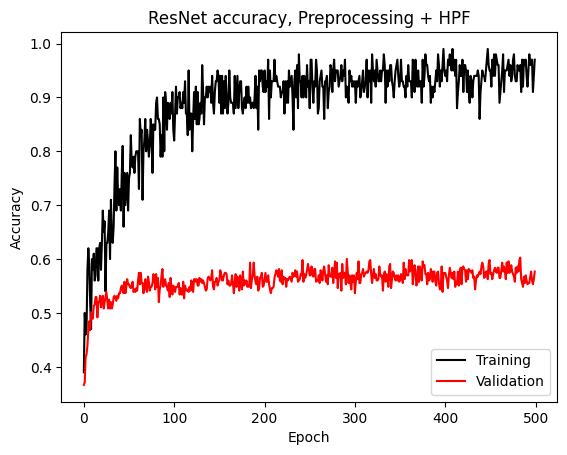

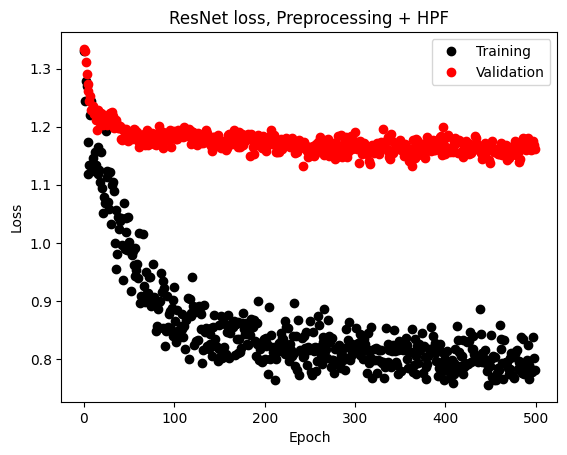

In [ ]:
#Update arrays and titles
plt.plot(np.arange(num_epochs),train_history_4,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_4,label='Validation',color='r')
plt.title('ResNet accuracy, Preprocessing + HPF')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_4,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_4,'o',label='Validation',color='r')
plt.title('ResNet loss, Preprocessing + HPF')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Part 5 Bandpass filter after data preprocessing

In [ ]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

# Preprocessing the dataset
# pass only training data to train prep, val and test data to test prep

x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(x_test), test_data_prep(x_valid)

x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

# Convert x train to numpy

x_train_np = x_train.cpu().numpy()
print(x_train_np.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: torch.Size([6768, 22, 400])
Shape of validation set: torch.Size([423, 22, 400])
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([6768, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torc

In [ ]:
# Define the band-pass filter parameters
cutoff_frequency = np.array([4, 40])  # Cut-off frequency in Hz
sampling_rate = 125  # Sampling rate in Hz (adjust based on your data)

# Design a Butterworth band-pass filter
order = 3  # Filter order
b, a = butter(N=order, Wn=cutoff_frequency / (0.5 * sampling_rate), btype='band', analog=False, output='ba')

x_train_bpf = np.zeros(x_train_np.shape)
# Apply the filter to the data
for i in range(x_train_np.shape[0]):
    for j in range(x_train_np.shape[2]):
        filtered_data = filtfilt(b, a, x_train_np[i,0,j,:])
        x_train_bpf[i,0,j,:] = filtered_data

x_train_bpf = torch.tensor(x_train_bpf).float().to(device)
print(x_train_bpf.shape)

torch.Size([6768, 1, 22, 400])


In [ ]:
#Build the model
model5 = ResNet(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model5)
total_params = sum(p.numel() for p in model5.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model5.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNet(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1): Con

In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model5.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_5, val_history_5 = np.array([]), np.array([])
train_loss_hist_5, val_loss_hist_5 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = '/content/drive/MyDrive/C147_Final_Project/best_model_params_CNN'

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model5_params.pt')
    torch.save(model5.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model5.train()

        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model5(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        #Rename
        model5.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model5(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_5 = np.append(train_history_5, train_acc.item())
        val_history_5 = np.append(val_history_5, val_acc.item())
        train_loss_hist_5 = np.append(train_loss_hist_5, loss.item())
        val_loss_hist_5 = np.append(val_loss_hist_5, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model5.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-10-81721273ce3a>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:09<1:19:08,  9.52s/it]

Epoch 1 Finished!!!
Train acc: 0.450, Val acc: 0.350
Train loss: 1.304, Val loss: 1.355


  0%|          | 2/500 [00:12<46:55,  5.65s/it]  

Epoch 2 Finished!!!
Train acc: 0.460, Val acc: 0.390
Train loss: 1.291, Val loss: 1.338


  1%|          | 3/500 [00:15<36:26,  4.40s/it]

Epoch 3 Finished!!!
Train acc: 0.410, Val acc: 0.376
Train loss: 1.307, Val loss: 1.341


  1%|          | 4/500 [00:18<31:36,  3.82s/it]

Epoch 4 Finished!!!
Train acc: 0.540, Val acc: 0.414
Train loss: 1.189, Val loss: 1.310


  1%|          | 5/500 [00:21<28:59,  3.51s/it]

Epoch 5 Finished!!!
Train acc: 0.500, Val acc: 0.416
Train loss: 1.191, Val loss: 1.316


  1%|          | 6/500 [00:24<27:19,  3.32s/it]

Epoch 6 Finished!!!
Train acc: 0.530, Val acc: 0.402
Train loss: 1.235, Val loss: 1.331


  1%|▏         | 7/500 [00:27<26:22,  3.21s/it]

Epoch 7 Finished!!!
Train acc: 0.530, Val acc: 0.444
Train loss: 1.189, Val loss: 1.293


  2%|▏         | 8/500 [00:30<25:40,  3.13s/it]

Epoch 8 Finished!!!
Train acc: 0.470, Val acc: 0.444
Train loss: 1.230, Val loss: 1.277


  2%|▏         | 9/500 [00:33<25:12,  3.08s/it]

Epoch 9 Finished!!!
Train acc: 0.580, Val acc: 0.421
Train loss: 1.143, Val loss: 1.296


  2%|▏         | 10/500 [00:36<24:58,  3.06s/it]

Epoch 10 Finished!!!
Train acc: 0.490, Val acc: 0.466
Train loss: 1.244, Val loss: 1.272


  2%|▏         | 11/500 [00:39<24:45,  3.04s/it]

Epoch 11 Finished!!!
Train acc: 0.600, Val acc: 0.456
Train loss: 1.160, Val loss: 1.281


  2%|▏         | 12/500 [00:42<24:35,  3.02s/it]

Epoch 12 Finished!!!
Train acc: 0.580, Val acc: 0.466
Train loss: 1.134, Val loss: 1.262


  3%|▎         | 13/500 [00:45<24:33,  3.02s/it]

Epoch 13 Finished!!!
Train acc: 0.580, Val acc: 0.527
Train loss: 1.178, Val loss: 1.218


  3%|▎         | 14/500 [00:48<24:27,  3.02s/it]

Epoch 14 Finished!!!
Train acc: 0.600, Val acc: 0.482
Train loss: 1.141, Val loss: 1.244


  3%|▎         | 15/500 [00:51<24:26,  3.02s/it]

Epoch 15 Finished!!!
Train acc: 0.600, Val acc: 0.470
Train loss: 1.141, Val loss: 1.250


  3%|▎         | 16/500 [00:54<24:24,  3.03s/it]

Epoch 16 Finished!!!
Train acc: 0.640, Val acc: 0.504
Train loss: 1.076, Val loss: 1.222


  3%|▎         | 17/500 [00:57<24:22,  3.03s/it]

Epoch 17 Finished!!!
Train acc: 0.560, Val acc: 0.478
Train loss: 1.168, Val loss: 1.250


  4%|▎         | 18/500 [01:00<24:20,  3.03s/it]

Epoch 18 Finished!!!
Train acc: 0.620, Val acc: 0.482
Train loss: 1.112, Val loss: 1.250


  4%|▍         | 19/500 [01:03<24:18,  3.03s/it]

Epoch 19 Finished!!!
Train acc: 0.580, Val acc: 0.506
Train loss: 1.150, Val loss: 1.229


  4%|▍         | 20/500 [01:06<24:14,  3.03s/it]

Epoch 20 Finished!!!
Train acc: 0.630, Val acc: 0.480
Train loss: 1.094, Val loss: 1.244


  4%|▍         | 21/500 [01:09<24:09,  3.03s/it]

Epoch 21 Finished!!!
Train acc: 0.580, Val acc: 0.506
Train loss: 1.164, Val loss: 1.223


  4%|▍         | 22/500 [01:12<24:04,  3.02s/it]

Epoch 22 Finished!!!
Train acc: 0.600, Val acc: 0.515
Train loss: 1.132, Val loss: 1.224


  5%|▍         | 23/500 [01:15<24:00,  3.02s/it]

Epoch 23 Finished!!!
Train acc: 0.580, Val acc: 0.522
Train loss: 1.155, Val loss: 1.215


  5%|▍         | 24/500 [01:18<24:03,  3.03s/it]

Epoch 24 Finished!!!
Train acc: 0.630, Val acc: 0.522
Train loss: 1.109, Val loss: 1.205


  5%|▌         | 25/500 [01:21<23:55,  3.02s/it]

Epoch 25 Finished!!!
Train acc: 0.620, Val acc: 0.499
Train loss: 1.128, Val loss: 1.234


  5%|▌         | 26/500 [01:24<23:47,  3.01s/it]

Epoch 26 Finished!!!
Train acc: 0.600, Val acc: 0.506
Train loss: 1.129, Val loss: 1.223


  5%|▌         | 27/500 [01:27<23:41,  3.01s/it]

Epoch 27 Finished!!!
Train acc: 0.720, Val acc: 0.525
Train loss: 1.040, Val loss: 1.207


  6%|▌         | 28/500 [01:30<23:39,  3.01s/it]

Epoch 28 Finished!!!
Train acc: 0.630, Val acc: 0.541
Train loss: 1.103, Val loss: 1.196


  6%|▌         | 29/500 [01:33<23:31,  3.00s/it]

Epoch 29 Finished!!!
Train acc: 0.670, Val acc: 0.499
Train loss: 1.084, Val loss: 1.228


  6%|▌         | 30/500 [01:36<23:26,  2.99s/it]

Epoch 30 Finished!!!
Train acc: 0.710, Val acc: 0.504
Train loss: 1.023, Val loss: 1.223


  6%|▌         | 31/500 [01:39<23:21,  2.99s/it]

Epoch 31 Finished!!!
Train acc: 0.710, Val acc: 0.513
Train loss: 1.029, Val loss: 1.217


  6%|▋         | 32/500 [01:42<23:16,  2.98s/it]

Epoch 32 Finished!!!
Train acc: 0.690, Val acc: 0.520
Train loss: 1.066, Val loss: 1.209


  7%|▋         | 33/500 [01:45<23:12,  2.98s/it]

Epoch 33 Finished!!!
Train acc: 0.650, Val acc: 0.515
Train loss: 1.105, Val loss: 1.217


  7%|▋         | 34/500 [01:48<23:08,  2.98s/it]

Epoch 34 Finished!!!
Train acc: 0.720, Val acc: 0.494
Train loss: 1.025, Val loss: 1.234


  7%|▋         | 35/500 [01:51<23:05,  2.98s/it]

Epoch 35 Finished!!!
Train acc: 0.590, Val acc: 0.532
Train loss: 1.134, Val loss: 1.209


  7%|▋         | 36/500 [01:54<23:03,  2.98s/it]

Epoch 36 Finished!!!
Train acc: 0.720, Val acc: 0.527
Train loss: 1.021, Val loss: 1.207


  7%|▋         | 37/500 [01:57<22:59,  2.98s/it]

Epoch 37 Finished!!!
Train acc: 0.620, Val acc: 0.506
Train loss: 1.100, Val loss: 1.216


  8%|▊         | 38/500 [02:00<22:57,  2.98s/it]

Epoch 38 Finished!!!
Train acc: 0.670, Val acc: 0.537
Train loss: 1.065, Val loss: 1.201


  8%|▊         | 39/500 [02:03<22:55,  2.98s/it]

Epoch 39 Finished!!!
Train acc: 0.670, Val acc: 0.508
Train loss: 1.062, Val loss: 1.227


  8%|▊         | 40/500 [02:06<22:53,  2.99s/it]

Epoch 40 Finished!!!
Train acc: 0.600, Val acc: 0.534
Train loss: 1.117, Val loss: 1.197


  8%|▊         | 41/500 [02:09<22:51,  2.99s/it]

Epoch 41 Finished!!!
Train acc: 0.700, Val acc: 0.522
Train loss: 1.044, Val loss: 1.208


  8%|▊         | 42/500 [02:12<22:49,  2.99s/it]

Epoch 42 Finished!!!
Train acc: 0.770, Val acc: 0.522
Train loss: 0.977, Val loss: 1.204


  9%|▊         | 43/500 [02:15<22:47,  2.99s/it]

Epoch 43 Finished!!!
Train acc: 0.760, Val acc: 0.539
Train loss: 0.976, Val loss: 1.194


  9%|▉         | 44/500 [02:18<22:45,  2.99s/it]

Epoch 44 Finished!!!
Train acc: 0.720, Val acc: 0.532
Train loss: 1.026, Val loss: 1.203


  9%|▉         | 45/500 [02:21<22:44,  3.00s/it]

Epoch 45 Finished!!!
Train acc: 0.790, Val acc: 0.534
Train loss: 0.945, Val loss: 1.197


  9%|▉         | 46/500 [02:24<22:41,  3.00s/it]

Epoch 46 Finished!!!
Train acc: 0.700, Val acc: 0.518
Train loss: 1.045, Val loss: 1.215


  9%|▉         | 47/500 [02:27<22:39,  3.00s/it]

Epoch 47 Finished!!!
Train acc: 0.750, Val acc: 0.494
Train loss: 0.995, Val loss: 1.228


 10%|▉         | 48/500 [02:30<22:37,  3.00s/it]

Epoch 48 Finished!!!
Train acc: 0.800, Val acc: 0.518
Train loss: 0.932, Val loss: 1.219


 10%|▉         | 49/500 [02:33<22:38,  3.01s/it]

Epoch 49 Finished!!!
Train acc: 0.810, Val acc: 0.546
Train loss: 0.943, Val loss: 1.190


 10%|█         | 50/500 [02:36<22:36,  3.02s/it]

Epoch 50 Finished!!!
Train acc: 0.670, Val acc: 0.556
Train loss: 1.058, Val loss: 1.179


 10%|█         | 51/500 [02:39<22:40,  3.03s/it]

Epoch 51 Finished!!!
Train acc: 0.710, Val acc: 0.553
Train loss: 1.048, Val loss: 1.182


 10%|█         | 52/500 [02:42<22:34,  3.02s/it]

Epoch 52 Finished!!!
Train acc: 0.750, Val acc: 0.546
Train loss: 0.988, Val loss: 1.189


 11%|█         | 53/500 [02:45<22:28,  3.02s/it]

Epoch 53 Finished!!!
Train acc: 0.700, Val acc: 0.520
Train loss: 1.052, Val loss: 1.207


 11%|█         | 54/500 [02:48<22:23,  3.01s/it]

Epoch 54 Finished!!!
Train acc: 0.690, Val acc: 0.544
Train loss: 1.028, Val loss: 1.192


 11%|█         | 55/500 [02:51<22:20,  3.01s/it]

Epoch 55 Finished!!!
Train acc: 0.760, Val acc: 0.563
Train loss: 0.993, Val loss: 1.176


 11%|█         | 56/500 [02:54<22:14,  3.01s/it]

Epoch 56 Finished!!!
Train acc: 0.800, Val acc: 0.556
Train loss: 0.968, Val loss: 1.182


 11%|█▏        | 57/500 [02:57<22:10,  3.00s/it]

Epoch 57 Finished!!!
Train acc: 0.780, Val acc: 0.541
Train loss: 0.978, Val loss: 1.195


 12%|█▏        | 58/500 [03:00<22:06,  3.00s/it]

Epoch 58 Finished!!!
Train acc: 0.790, Val acc: 0.553
Train loss: 0.971, Val loss: 1.183


 12%|█▏        | 59/500 [03:03<22:02,  3.00s/it]

Epoch 59 Finished!!!
Train acc: 0.750, Val acc: 0.548
Train loss: 0.992, Val loss: 1.186


 12%|█▏        | 60/500 [03:06<21:58,  3.00s/it]

Epoch 60 Finished!!!
Train acc: 0.660, Val acc: 0.551
Train loss: 1.072, Val loss: 1.186


 12%|█▏        | 61/500 [03:09<21:54,  2.99s/it]

Epoch 61 Finished!!!
Train acc: 0.730, Val acc: 0.534
Train loss: 1.005, Val loss: 1.193


 12%|█▏        | 62/500 [03:12<21:51,  2.99s/it]

Epoch 62 Finished!!!
Train acc: 0.660, Val acc: 0.553
Train loss: 1.074, Val loss: 1.181


 13%|█▎        | 63/500 [03:15<21:48,  2.99s/it]

Epoch 63 Finished!!!
Train acc: 0.780, Val acc: 0.546
Train loss: 0.969, Val loss: 1.182


 13%|█▎        | 64/500 [03:18<21:47,  3.00s/it]

Epoch 64 Finished!!!
Train acc: 0.760, Val acc: 0.567
Train loss: 0.981, Val loss: 1.171


 13%|█▎        | 65/500 [03:21<21:43,  3.00s/it]

Epoch 65 Finished!!!
Train acc: 0.820, Val acc: 0.558
Train loss: 0.939, Val loss: 1.170


 13%|█▎        | 66/500 [03:24<21:40,  3.00s/it]

Epoch 66 Finished!!!
Train acc: 0.740, Val acc: 0.558
Train loss: 0.998, Val loss: 1.178


 13%|█▎        | 67/500 [03:27<21:37,  3.00s/it]

Epoch 67 Finished!!!
Train acc: 0.780, Val acc: 0.553
Train loss: 0.967, Val loss: 1.172


 14%|█▎        | 68/500 [03:30<21:34,  3.00s/it]

Epoch 68 Finished!!!
Train acc: 0.710, Val acc: 0.567
Train loss: 1.030, Val loss: 1.170


 14%|█▍        | 69/500 [03:33<21:33,  3.00s/it]

Epoch 69 Finished!!!
Train acc: 0.760, Val acc: 0.577
Train loss: 0.981, Val loss: 1.166


 14%|█▍        | 70/500 [03:36<21:29,  3.00s/it]

Epoch 70 Finished!!!
Train acc: 0.790, Val acc: 0.537
Train loss: 0.959, Val loss: 1.187


 14%|█▍        | 71/500 [03:39<21:26,  3.00s/it]

Epoch 71 Finished!!!
Train acc: 0.740, Val acc: 0.567
Train loss: 0.986, Val loss: 1.157


 14%|█▍        | 72/500 [03:42<21:22,  3.00s/it]

Epoch 72 Finished!!!
Train acc: 0.830, Val acc: 0.560
Train loss: 0.921, Val loss: 1.166


 15%|█▍        | 73/500 [03:45<21:21,  3.00s/it]

Epoch 73 Finished!!!
Train acc: 0.740, Val acc: 0.579
Train loss: 1.002, Val loss: 1.158


 15%|█▍        | 74/500 [03:48<21:19,  3.00s/it]

Epoch 74 Finished!!!
Train acc: 0.830, Val acc: 0.603
Train loss: 0.921, Val loss: 1.143


 15%|█▌        | 75/500 [03:51<21:15,  3.00s/it]

Epoch 75 Finished!!!
Train acc: 0.830, Val acc: 0.572
Train loss: 0.917, Val loss: 1.168


 15%|█▌        | 76/500 [03:54<21:11,  3.00s/it]

Epoch 76 Finished!!!
Train acc: 0.810, Val acc: 0.560
Train loss: 0.938, Val loss: 1.170


 15%|█▌        | 77/500 [03:57<21:07,  3.00s/it]

Epoch 77 Finished!!!
Train acc: 0.840, Val acc: 0.570
Train loss: 0.896, Val loss: 1.167


 16%|█▌        | 78/500 [04:00<21:04,  3.00s/it]

Epoch 78 Finished!!!
Train acc: 0.870, Val acc: 0.591
Train loss: 0.888, Val loss: 1.147


 16%|█▌        | 79/500 [04:03<21:01,  3.00s/it]

Epoch 79 Finished!!!
Train acc: 0.800, Val acc: 0.570
Train loss: 0.956, Val loss: 1.163


 16%|█▌        | 80/500 [04:06<20:58,  3.00s/it]

Epoch 80 Finished!!!
Train acc: 0.810, Val acc: 0.584
Train loss: 0.936, Val loss: 1.155


 16%|█▌        | 81/500 [04:09<20:55,  3.00s/it]

Epoch 81 Finished!!!
Train acc: 0.850, Val acc: 0.563
Train loss: 0.925, Val loss: 1.167


 16%|█▋        | 82/500 [04:12<20:52,  3.00s/it]

Epoch 82 Finished!!!
Train acc: 0.760, Val acc: 0.582
Train loss: 0.980, Val loss: 1.151


 17%|█▋        | 83/500 [04:15<20:49,  3.00s/it]

Epoch 83 Finished!!!
Train acc: 0.830, Val acc: 0.563
Train loss: 0.911, Val loss: 1.167


 17%|█▋        | 84/500 [04:18<20:46,  3.00s/it]

Epoch 84 Finished!!!
Train acc: 0.800, Val acc: 0.570
Train loss: 0.934, Val loss: 1.165


 17%|█▋        | 85/500 [04:21<20:43,  3.00s/it]

Epoch 85 Finished!!!
Train acc: 0.790, Val acc: 0.565
Train loss: 0.941, Val loss: 1.169


 17%|█▋        | 86/500 [04:24<20:40,  3.00s/it]

Epoch 86 Finished!!!
Train acc: 0.900, Val acc: 0.598
Train loss: 0.872, Val loss: 1.142


 17%|█▋        | 87/500 [04:27<20:38,  3.00s/it]

Epoch 87 Finished!!!
Train acc: 0.820, Val acc: 0.596
Train loss: 0.919, Val loss: 1.138


 18%|█▊        | 88/500 [04:30<20:35,  3.00s/it]

Epoch 88 Finished!!!
Train acc: 0.820, Val acc: 0.553
Train loss: 0.942, Val loss: 1.178


 18%|█▊        | 89/500 [04:33<20:32,  3.00s/it]

Epoch 89 Finished!!!
Train acc: 0.910, Val acc: 0.565
Train loss: 0.841, Val loss: 1.168


 18%|█▊        | 90/500 [04:36<20:29,  3.00s/it]

Epoch 90 Finished!!!
Train acc: 0.810, Val acc: 0.584
Train loss: 0.934, Val loss: 1.149


 18%|█▊        | 91/500 [04:39<20:26,  3.00s/it]

Epoch 91 Finished!!!
Train acc: 0.870, Val acc: 0.560
Train loss: 0.874, Val loss: 1.171


 18%|█▊        | 92/500 [04:42<20:24,  3.00s/it]

Epoch 92 Finished!!!
Train acc: 0.890, Val acc: 0.548
Train loss: 0.854, Val loss: 1.179


 19%|█▊        | 93/500 [04:45<20:20,  3.00s/it]

Epoch 93 Finished!!!
Train acc: 0.860, Val acc: 0.551
Train loss: 0.886, Val loss: 1.172


 19%|█▉        | 94/500 [04:48<20:17,  3.00s/it]

Epoch 94 Finished!!!
Train acc: 0.860, Val acc: 0.556
Train loss: 0.890, Val loss: 1.180


 19%|█▉        | 95/500 [04:51<20:14,  3.00s/it]

Epoch 95 Finished!!!
Train acc: 0.810, Val acc: 0.582
Train loss: 0.946, Val loss: 1.156


 19%|█▉        | 96/500 [04:54<20:12,  3.00s/it]

Epoch 96 Finished!!!
Train acc: 0.760, Val acc: 0.572
Train loss: 0.985, Val loss: 1.158


 19%|█▉        | 97/500 [04:57<20:09,  3.00s/it]

Epoch 97 Finished!!!
Train acc: 0.840, Val acc: 0.572
Train loss: 0.898, Val loss: 1.164


 20%|█▉        | 98/500 [05:00<20:06,  3.00s/it]

Epoch 98 Finished!!!
Train acc: 0.850, Val acc: 0.577
Train loss: 0.904, Val loss: 1.161


 20%|█▉        | 99/500 [05:03<20:03,  3.00s/it]

Epoch 99 Finished!!!
Train acc: 0.840, Val acc: 0.565
Train loss: 0.902, Val loss: 1.162


 20%|██        | 100/500 [05:06<20:00,  3.00s/it]

Epoch 100 Finished!!!
Train acc: 0.890, Val acc: 0.572
Train loss: 0.854, Val loss: 1.155


 20%|██        | 101/500 [05:09<19:57,  3.00s/it]

Epoch 101 Finished!!!
Train acc: 0.840, Val acc: 0.589
Train loss: 0.904, Val loss: 1.151


 20%|██        | 102/500 [05:12<19:54,  3.00s/it]

Epoch 102 Finished!!!
Train acc: 0.870, Val acc: 0.563
Train loss: 0.875, Val loss: 1.172


 21%|██        | 103/500 [05:15<19:50,  3.00s/it]

Epoch 103 Finished!!!
Train acc: 0.850, Val acc: 0.567
Train loss: 0.909, Val loss: 1.163


 21%|██        | 104/500 [05:18<19:48,  3.00s/it]

Epoch 104 Finished!!!
Train acc: 0.880, Val acc: 0.579
Train loss: 0.876, Val loss: 1.155


 21%|██        | 105/500 [05:21<19:45,  3.00s/it]

Epoch 105 Finished!!!
Train acc: 0.900, Val acc: 0.579
Train loss: 0.851, Val loss: 1.153


 21%|██        | 106/500 [05:24<19:41,  3.00s/it]

Epoch 106 Finished!!!
Train acc: 0.810, Val acc: 0.591
Train loss: 0.930, Val loss: 1.143


 21%|██▏       | 107/500 [05:27<19:38,  3.00s/it]

Epoch 107 Finished!!!
Train acc: 0.880, Val acc: 0.579
Train loss: 0.875, Val loss: 1.152


 22%|██▏       | 108/500 [05:30<19:35,  3.00s/it]

Epoch 108 Finished!!!
Train acc: 0.810, Val acc: 0.570
Train loss: 0.919, Val loss: 1.161


 22%|██▏       | 109/500 [05:33<19:32,  3.00s/it]

Epoch 109 Finished!!!
Train acc: 0.860, Val acc: 0.593
Train loss: 0.888, Val loss: 1.142


 22%|██▏       | 110/500 [05:36<19:29,  3.00s/it]

Epoch 110 Finished!!!
Train acc: 0.860, Val acc: 0.579
Train loss: 0.880, Val loss: 1.158


 22%|██▏       | 111/500 [05:39<19:26,  3.00s/it]

Epoch 111 Finished!!!
Train acc: 0.830, Val acc: 0.586
Train loss: 0.918, Val loss: 1.156


 22%|██▏       | 112/500 [05:42<19:22,  3.00s/it]

Epoch 112 Finished!!!
Train acc: 0.870, Val acc: 0.589
Train loss: 0.868, Val loss: 1.146


 23%|██▎       | 113/500 [05:45<19:20,  3.00s/it]

Epoch 113 Finished!!!
Train acc: 0.940, Val acc: 0.584
Train loss: 0.814, Val loss: 1.153


 23%|██▎       | 114/500 [05:48<19:16,  3.00s/it]

Epoch 114 Finished!!!
Train acc: 0.940, Val acc: 0.589
Train loss: 0.803, Val loss: 1.145


 23%|██▎       | 115/500 [05:51<19:13,  3.00s/it]

Epoch 115 Finished!!!
Train acc: 0.890, Val acc: 0.582
Train loss: 0.860, Val loss: 1.151


 23%|██▎       | 116/500 [05:54<19:10,  3.00s/it]

Epoch 116 Finished!!!
Train acc: 0.920, Val acc: 0.579
Train loss: 0.831, Val loss: 1.159


 23%|██▎       | 117/500 [05:57<19:08,  3.00s/it]

Epoch 117 Finished!!!
Train acc: 0.890, Val acc: 0.574
Train loss: 0.850, Val loss: 1.162


 24%|██▎       | 118/500 [06:00<19:04,  3.00s/it]

Epoch 118 Finished!!!
Train acc: 0.860, Val acc: 0.586
Train loss: 0.878, Val loss: 1.150


 24%|██▍       | 119/500 [06:03<19:01,  3.00s/it]

Epoch 119 Finished!!!
Train acc: 0.900, Val acc: 0.591
Train loss: 0.851, Val loss: 1.145


 24%|██▍       | 120/500 [06:06<18:58,  3.00s/it]

Epoch 120 Finished!!!
Train acc: 0.880, Val acc: 0.572
Train loss: 0.858, Val loss: 1.164


 24%|██▍       | 121/500 [06:09<18:55,  3.00s/it]

Epoch 121 Finished!!!
Train acc: 0.840, Val acc: 0.577
Train loss: 0.908, Val loss: 1.155


 24%|██▍       | 122/500 [06:12<18:52,  3.00s/it]

Epoch 122 Finished!!!
Train acc: 0.900, Val acc: 0.570
Train loss: 0.839, Val loss: 1.163


 25%|██▍       | 123/500 [06:15<18:49,  3.00s/it]

Epoch 123 Finished!!!
Train acc: 0.920, Val acc: 0.589
Train loss: 0.821, Val loss: 1.149


 25%|██▍       | 124/500 [06:18<18:46,  3.00s/it]

Epoch 124 Finished!!!
Train acc: 0.890, Val acc: 0.582
Train loss: 0.855, Val loss: 1.149


 25%|██▌       | 125/500 [06:21<18:43,  3.00s/it]

Epoch 125 Finished!!!
Train acc: 0.810, Val acc: 0.593
Train loss: 0.936, Val loss: 1.145


 25%|██▌       | 126/500 [06:24<18:40,  3.00s/it]

Epoch 126 Finished!!!
Train acc: 0.900, Val acc: 0.572
Train loss: 0.842, Val loss: 1.164


 25%|██▌       | 127/500 [06:27<18:37,  3.00s/it]

Epoch 127 Finished!!!
Train acc: 0.910, Val acc: 0.565
Train loss: 0.841, Val loss: 1.165


 26%|██▌       | 128/500 [06:30<18:34,  3.00s/it]

Epoch 128 Finished!!!
Train acc: 0.870, Val acc: 0.586
Train loss: 0.876, Val loss: 1.147


 26%|██▌       | 129/500 [06:33<18:31,  3.00s/it]

Epoch 129 Finished!!!
Train acc: 0.950, Val acc: 0.574
Train loss: 0.803, Val loss: 1.160


 26%|██▌       | 130/500 [06:36<18:28,  3.00s/it]

Epoch 130 Finished!!!
Train acc: 0.900, Val acc: 0.589
Train loss: 0.836, Val loss: 1.144


 26%|██▌       | 131/500 [06:39<18:25,  3.00s/it]

Epoch 131 Finished!!!
Train acc: 0.930, Val acc: 0.579
Train loss: 0.814, Val loss: 1.157


 26%|██▋       | 132/500 [06:42<18:22,  3.00s/it]

Epoch 132 Finished!!!
Train acc: 0.840, Val acc: 0.591
Train loss: 0.906, Val loss: 1.142


 27%|██▋       | 133/500 [06:45<18:19,  2.99s/it]

Epoch 133 Finished!!!
Train acc: 0.870, Val acc: 0.565
Train loss: 0.872, Val loss: 1.164


 27%|██▋       | 134/500 [06:48<18:16,  3.00s/it]

Epoch 134 Finished!!!
Train acc: 0.910, Val acc: 0.589
Train loss: 0.836, Val loss: 1.152


 27%|██▋       | 135/500 [06:51<18:13,  3.00s/it]

Epoch 135 Finished!!!
Train acc: 0.970, Val acc: 0.579
Train loss: 0.781, Val loss: 1.161


 27%|██▋       | 136/500 [06:54<18:10,  3.00s/it]

Epoch 136 Finished!!!
Train acc: 0.870, Val acc: 0.577
Train loss: 0.870, Val loss: 1.154


 27%|██▋       | 137/500 [06:57<18:06,  2.99s/it]

Epoch 137 Finished!!!
Train acc: 0.880, Val acc: 0.563
Train loss: 0.857, Val loss: 1.163


 28%|██▊       | 138/500 [07:00<18:03,  2.99s/it]

Epoch 138 Finished!!!
Train acc: 0.890, Val acc: 0.589
Train loss: 0.847, Val loss: 1.154


 28%|██▊       | 139/500 [07:03<18:00,  2.99s/it]

Epoch 139 Finished!!!
Train acc: 0.910, Val acc: 0.589
Train loss: 0.842, Val loss: 1.147


 28%|██▊       | 140/500 [07:06<17:57,  2.99s/it]

Epoch 140 Finished!!!
Train acc: 0.890, Val acc: 0.582
Train loss: 0.859, Val loss: 1.152


 28%|██▊       | 141/500 [07:09<17:53,  2.99s/it]

Epoch 141 Finished!!!
Train acc: 0.910, Val acc: 0.556
Train loss: 0.839, Val loss: 1.169


 28%|██▊       | 142/500 [07:12<17:50,  2.99s/it]

Epoch 142 Finished!!!
Train acc: 0.910, Val acc: 0.603
Train loss: 0.830, Val loss: 1.132


 29%|██▊       | 143/500 [07:15<17:47,  2.99s/it]

Epoch 143 Finished!!!
Train acc: 0.890, Val acc: 0.600
Train loss: 0.845, Val loss: 1.142


 29%|██▉       | 144/500 [07:18<17:44,  2.99s/it]

Epoch 144 Finished!!!
Train acc: 0.920, Val acc: 0.572
Train loss: 0.823, Val loss: 1.161


 29%|██▉       | 145/500 [07:21<17:41,  2.99s/it]

Epoch 145 Finished!!!
Train acc: 0.850, Val acc: 0.593
Train loss: 0.893, Val loss: 1.148


 29%|██▉       | 146/500 [07:24<17:39,  2.99s/it]

Epoch 146 Finished!!!
Train acc: 0.920, Val acc: 0.589
Train loss: 0.828, Val loss: 1.153


 29%|██▉       | 147/500 [07:27<17:36,  2.99s/it]

Epoch 147 Finished!!!
Train acc: 0.950, Val acc: 0.574
Train loss: 0.796, Val loss: 1.162


 30%|██▉       | 148/500 [07:30<17:33,  2.99s/it]

Epoch 148 Finished!!!
Train acc: 0.890, Val acc: 0.593
Train loss: 0.852, Val loss: 1.141


 30%|██▉       | 149/500 [07:33<17:30,  2.99s/it]

Epoch 149 Finished!!!
Train acc: 0.880, Val acc: 0.582
Train loss: 0.867, Val loss: 1.153


 30%|███       | 150/500 [07:36<17:27,  2.99s/it]

Epoch 150 Finished!!!
Train acc: 0.870, Val acc: 0.563
Train loss: 0.878, Val loss: 1.158


 30%|███       | 151/500 [07:39<17:24,  2.99s/it]

Epoch 151 Finished!!!
Train acc: 0.910, Val acc: 0.589
Train loss: 0.825, Val loss: 1.149


 30%|███       | 152/500 [07:42<17:22,  2.99s/it]

Epoch 152 Finished!!!
Train acc: 0.880, Val acc: 0.589
Train loss: 0.858, Val loss: 1.152


 31%|███       | 153/500 [07:45<17:19,  2.99s/it]

Epoch 153 Finished!!!
Train acc: 0.910, Val acc: 0.563
Train loss: 0.829, Val loss: 1.167


 31%|███       | 154/500 [07:48<17:16,  3.00s/it]

Epoch 154 Finished!!!
Train acc: 0.880, Val acc: 0.579
Train loss: 0.863, Val loss: 1.156


 31%|███       | 155/500 [07:51<17:14,  3.00s/it]

Epoch 155 Finished!!!
Train acc: 0.950, Val acc: 0.572
Train loss: 0.798, Val loss: 1.162


 31%|███       | 156/500 [07:54<17:11,  3.00s/it]

Epoch 156 Finished!!!
Train acc: 0.890, Val acc: 0.582
Train loss: 0.856, Val loss: 1.150


 31%|███▏      | 157/500 [07:57<17:08,  3.00s/it]

Epoch 157 Finished!!!
Train acc: 0.940, Val acc: 0.598
Train loss: 0.800, Val loss: 1.139


 32%|███▏      | 158/500 [08:00<17:05,  3.00s/it]

Epoch 158 Finished!!!
Train acc: 0.850, Val acc: 0.586
Train loss: 0.906, Val loss: 1.151


 32%|███▏      | 159/500 [08:03<17:02,  3.00s/it]

Epoch 159 Finished!!!
Train acc: 0.940, Val acc: 0.582
Train loss: 0.812, Val loss: 1.145


 32%|███▏      | 160/500 [08:06<17:00,  3.00s/it]

Epoch 160 Finished!!!
Train acc: 0.950, Val acc: 0.558
Train loss: 0.793, Val loss: 1.166


 32%|███▏      | 161/500 [08:09<16:57,  3.00s/it]

Epoch 161 Finished!!!
Train acc: 0.950, Val acc: 0.579
Train loss: 0.794, Val loss: 1.157


 32%|███▏      | 162/500 [08:12<16:54,  3.00s/it]

Epoch 162 Finished!!!
Train acc: 0.970, Val acc: 0.593
Train loss: 0.776, Val loss: 1.144


 33%|███▎      | 163/500 [08:15<16:51,  3.00s/it]

Epoch 163 Finished!!!
Train acc: 0.860, Val acc: 0.570
Train loss: 0.889, Val loss: 1.168


 33%|███▎      | 164/500 [08:18<16:49,  3.00s/it]

Epoch 164 Finished!!!
Train acc: 0.950, Val acc: 0.582
Train loss: 0.792, Val loss: 1.160


 33%|███▎      | 165/500 [08:21<16:45,  3.00s/it]

Epoch 165 Finished!!!
Train acc: 0.990, Val acc: 0.586
Train loss: 0.759, Val loss: 1.153


 33%|███▎      | 166/500 [08:24<16:43,  3.00s/it]

Epoch 166 Finished!!!
Train acc: 0.920, Val acc: 0.586
Train loss: 0.825, Val loss: 1.148


 33%|███▎      | 167/500 [08:27<16:39,  3.00s/it]

Epoch 167 Finished!!!
Train acc: 0.970, Val acc: 0.591
Train loss: 0.777, Val loss: 1.154


 34%|███▎      | 168/500 [08:30<16:37,  3.00s/it]

Epoch 168 Finished!!!
Train acc: 0.880, Val acc: 0.579
Train loss: 0.872, Val loss: 1.157


 34%|███▍      | 169/500 [08:33<16:34,  3.00s/it]

Epoch 169 Finished!!!
Train acc: 0.960, Val acc: 0.579
Train loss: 0.793, Val loss: 1.160


 34%|███▍      | 170/500 [08:36<16:31,  3.00s/it]

Epoch 170 Finished!!!
Train acc: 0.930, Val acc: 0.593
Train loss: 0.805, Val loss: 1.139


 34%|███▍      | 171/500 [08:39<16:27,  3.00s/it]

Epoch 171 Finished!!!
Train acc: 0.960, Val acc: 0.582
Train loss: 0.786, Val loss: 1.148


 34%|███▍      | 172/500 [08:42<16:26,  3.01s/it]

Epoch 172 Finished!!!
Train acc: 0.950, Val acc: 0.608
Train loss: 0.800, Val loss: 1.135


 35%|███▍      | 173/500 [08:45<16:22,  3.00s/it]

Epoch 173 Finished!!!
Train acc: 0.950, Val acc: 0.565
Train loss: 0.797, Val loss: 1.160


 35%|███▍      | 174/500 [08:48<16:19,  3.00s/it]

Epoch 174 Finished!!!
Train acc: 0.940, Val acc: 0.579
Train loss: 0.810, Val loss: 1.153


 35%|███▌      | 175/500 [08:51<16:15,  3.00s/it]

Epoch 175 Finished!!!
Train acc: 0.900, Val acc: 0.584
Train loss: 0.852, Val loss: 1.153


 35%|███▌      | 176/500 [08:54<16:12,  3.00s/it]

Epoch 176 Finished!!!
Train acc: 0.910, Val acc: 0.584
Train loss: 0.828, Val loss: 1.153


 35%|███▌      | 177/500 [08:57<16:09,  3.00s/it]

Epoch 177 Finished!!!
Train acc: 0.900, Val acc: 0.608
Train loss: 0.840, Val loss: 1.134


 36%|███▌      | 178/500 [09:00<16:06,  3.00s/it]

Epoch 178 Finished!!!
Train acc: 0.950, Val acc: 0.570
Train loss: 0.796, Val loss: 1.164


 36%|███▌      | 179/500 [09:03<16:03,  3.00s/it]

Epoch 179 Finished!!!
Train acc: 0.950, Val acc: 0.574
Train loss: 0.799, Val loss: 1.160


 36%|███▌      | 180/500 [09:06<16:00,  3.00s/it]

Epoch 180 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.789, Val loss: 1.177


 36%|███▌      | 181/500 [09:09<15:57,  3.00s/it]

Epoch 181 Finished!!!
Train acc: 0.940, Val acc: 0.574
Train loss: 0.807, Val loss: 1.169


 36%|███▋      | 182/500 [09:12<15:54,  3.00s/it]

Epoch 182 Finished!!!
Train acc: 0.930, Val acc: 0.572
Train loss: 0.813, Val loss: 1.160


 37%|███▋      | 183/500 [09:15<15:50,  3.00s/it]

Epoch 183 Finished!!!
Train acc: 0.940, Val acc: 0.574
Train loss: 0.822, Val loss: 1.161


 37%|███▋      | 184/500 [09:18<15:47,  3.00s/it]

Epoch 184 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.806, Val loss: 1.187


 37%|███▋      | 185/500 [09:21<15:44,  3.00s/it]

Epoch 185 Finished!!!
Train acc: 0.920, Val acc: 0.582
Train loss: 0.826, Val loss: 1.151


 37%|███▋      | 186/500 [09:24<15:41,  3.00s/it]

Epoch 186 Finished!!!
Train acc: 0.930, Val acc: 0.584
Train loss: 0.811, Val loss: 1.148


 37%|███▋      | 187/500 [09:27<15:38,  3.00s/it]

Epoch 187 Finished!!!
Train acc: 0.920, Val acc: 0.600
Train loss: 0.824, Val loss: 1.139


 38%|███▊      | 188/500 [09:30<15:35,  3.00s/it]

Epoch 188 Finished!!!
Train acc: 0.940, Val acc: 0.584
Train loss: 0.806, Val loss: 1.149


 38%|███▊      | 189/500 [09:33<15:32,  3.00s/it]

Epoch 189 Finished!!!
Train acc: 0.960, Val acc: 0.593
Train loss: 0.785, Val loss: 1.145


 38%|███▊      | 190/500 [09:36<15:29,  3.00s/it]

Epoch 190 Finished!!!
Train acc: 0.910, Val acc: 0.558
Train loss: 0.830, Val loss: 1.171


 38%|███▊      | 191/500 [09:39<15:26,  3.00s/it]

Epoch 191 Finished!!!
Train acc: 0.880, Val acc: 0.596
Train loss: 0.863, Val loss: 1.142


 38%|███▊      | 192/500 [09:42<15:23,  3.00s/it]

Epoch 192 Finished!!!
Train acc: 0.950, Val acc: 0.574
Train loss: 0.797, Val loss: 1.161


 39%|███▊      | 193/500 [09:45<15:20,  3.00s/it]

Epoch 193 Finished!!!
Train acc: 0.940, Val acc: 0.584
Train loss: 0.802, Val loss: 1.155


 39%|███▉      | 194/500 [09:48<15:17,  3.00s/it]

Epoch 194 Finished!!!
Train acc: 0.970, Val acc: 0.600
Train loss: 0.779, Val loss: 1.143


 39%|███▉      | 195/500 [09:51<15:14,  3.00s/it]

Epoch 195 Finished!!!
Train acc: 0.940, Val acc: 0.591
Train loss: 0.805, Val loss: 1.148


 39%|███▉      | 196/500 [09:54<15:11,  3.00s/it]

Epoch 196 Finished!!!
Train acc: 0.940, Val acc: 0.582
Train loss: 0.801, Val loss: 1.158


 39%|███▉      | 197/500 [09:57<15:08,  3.00s/it]

Epoch 197 Finished!!!
Train acc: 0.900, Val acc: 0.589
Train loss: 0.838, Val loss: 1.144


 40%|███▉      | 198/500 [10:00<15:06,  3.00s/it]

Epoch 198 Finished!!!
Train acc: 0.920, Val acc: 0.584
Train loss: 0.825, Val loss: 1.155


 40%|███▉      | 199/500 [10:03<15:03,  3.00s/it]

Epoch 199 Finished!!!
Train acc: 0.920, Val acc: 0.570
Train loss: 0.825, Val loss: 1.161


 40%|████      | 200/500 [10:06<14:59,  3.00s/it]

Epoch 200 Finished!!!
Train acc: 0.930, Val acc: 0.586
Train loss: 0.812, Val loss: 1.142


 40%|████      | 201/500 [10:09<14:56,  3.00s/it]

Epoch 201 Finished!!!
Train acc: 0.930, Val acc: 0.589
Train loss: 0.816, Val loss: 1.151


 40%|████      | 202/500 [10:12<14:53,  3.00s/it]

Epoch 202 Finished!!!
Train acc: 0.920, Val acc: 0.598
Train loss: 0.834, Val loss: 1.142


 41%|████      | 203/500 [10:15<14:50,  3.00s/it]

Epoch 203 Finished!!!
Train acc: 0.940, Val acc: 0.579
Train loss: 0.806, Val loss: 1.154


 41%|████      | 204/500 [10:18<14:49,  3.00s/it]

Epoch 204 Finished!!!
Train acc: 0.940, Val acc: 0.615
Train loss: 0.799, Val loss: 1.131


 41%|████      | 205/500 [10:21<14:45,  3.00s/it]

Epoch 205 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.812, Val loss: 1.168


 41%|████      | 206/500 [10:24<14:42,  3.00s/it]

Epoch 206 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.792, Val loss: 1.159


 41%|████▏     | 207/500 [10:27<14:39,  3.00s/it]

Epoch 207 Finished!!!
Train acc: 0.930, Val acc: 0.572
Train loss: 0.814, Val loss: 1.163


 42%|████▏     | 208/500 [10:30<14:36,  3.00s/it]

Epoch 208 Finished!!!
Train acc: 0.950, Val acc: 0.579
Train loss: 0.791, Val loss: 1.145


 42%|████▏     | 209/500 [10:33<14:33,  3.00s/it]

Epoch 209 Finished!!!
Train acc: 0.970, Val acc: 0.586
Train loss: 0.776, Val loss: 1.154


 42%|████▏     | 210/500 [10:36<14:30,  3.00s/it]

Epoch 210 Finished!!!
Train acc: 0.930, Val acc: 0.577
Train loss: 0.806, Val loss: 1.166


 42%|████▏     | 211/500 [10:39<14:28,  3.00s/it]

Epoch 211 Finished!!!
Train acc: 0.990, Val acc: 0.565
Train loss: 0.755, Val loss: 1.170


 42%|████▏     | 212/500 [10:42<14:24,  3.00s/it]

Epoch 212 Finished!!!
Train acc: 0.910, Val acc: 0.593
Train loss: 0.833, Val loss: 1.148


 43%|████▎     | 213/500 [10:45<14:21,  3.00s/it]

Epoch 213 Finished!!!
Train acc: 0.970, Val acc: 0.589
Train loss: 0.770, Val loss: 1.147


 43%|████▎     | 214/500 [10:48<14:18,  3.00s/it]

Epoch 214 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.797, Val loss: 1.165


 43%|████▎     | 215/500 [10:51<14:15,  3.00s/it]

Epoch 215 Finished!!!
Train acc: 0.930, Val acc: 0.574
Train loss: 0.821, Val loss: 1.159


 43%|████▎     | 216/500 [10:54<14:12,  3.00s/it]

Epoch 216 Finished!!!
Train acc: 0.940, Val acc: 0.593
Train loss: 0.808, Val loss: 1.148


 43%|████▎     | 217/500 [10:57<14:09,  3.00s/it]

Epoch 217 Finished!!!
Train acc: 0.920, Val acc: 0.565
Train loss: 0.827, Val loss: 1.167


 44%|████▎     | 218/500 [11:00<14:06,  3.00s/it]

Epoch 218 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.781, Val loss: 1.174


 44%|████▍     | 219/500 [11:03<14:03,  3.00s/it]

Epoch 219 Finished!!!
Train acc: 0.910, Val acc: 0.579
Train loss: 0.826, Val loss: 1.160


 44%|████▍     | 220/500 [11:06<14:00,  3.00s/it]

Epoch 220 Finished!!!
Train acc: 0.940, Val acc: 0.582
Train loss: 0.803, Val loss: 1.157


 44%|████▍     | 221/500 [11:09<13:57,  3.00s/it]

Epoch 221 Finished!!!
Train acc: 0.920, Val acc: 0.582
Train loss: 0.825, Val loss: 1.153


 44%|████▍     | 222/500 [11:12<13:54,  3.00s/it]

Epoch 222 Finished!!!
Train acc: 0.960, Val acc: 0.577
Train loss: 0.783, Val loss: 1.162


 45%|████▍     | 223/500 [11:15<13:50,  3.00s/it]

Epoch 223 Finished!!!
Train acc: 0.930, Val acc: 0.563
Train loss: 0.815, Val loss: 1.167


 45%|████▍     | 224/500 [11:18<13:47,  3.00s/it]

Epoch 224 Finished!!!
Train acc: 0.940, Val acc: 0.579
Train loss: 0.806, Val loss: 1.156


 45%|████▌     | 225/500 [11:21<13:44,  3.00s/it]

Epoch 225 Finished!!!
Train acc: 0.930, Val acc: 0.560
Train loss: 0.813, Val loss: 1.174


 45%|████▌     | 226/500 [11:24<13:41,  3.00s/it]

Epoch 226 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.806, Val loss: 1.170


 45%|████▌     | 227/500 [11:27<13:38,  3.00s/it]

Epoch 227 Finished!!!
Train acc: 0.930, Val acc: 0.582
Train loss: 0.807, Val loss: 1.155


 46%|████▌     | 228/500 [11:30<13:36,  3.00s/it]

Epoch 228 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.808, Val loss: 1.172


 46%|████▌     | 229/500 [11:33<13:33,  3.00s/it]

Epoch 229 Finished!!!
Train acc: 0.960, Val acc: 0.586
Train loss: 0.784, Val loss: 1.159


 46%|████▌     | 230/500 [11:36<13:30,  3.00s/it]

Epoch 230 Finished!!!
Train acc: 0.890, Val acc: 0.572
Train loss: 0.858, Val loss: 1.160


 46%|████▌     | 231/500 [11:39<13:26,  3.00s/it]

Epoch 231 Finished!!!
Train acc: 0.890, Val acc: 0.584
Train loss: 0.851, Val loss: 1.152


 46%|████▋     | 232/500 [11:42<13:23,  3.00s/it]

Epoch 232 Finished!!!
Train acc: 0.940, Val acc: 0.612
Train loss: 0.816, Val loss: 1.128


 47%|████▋     | 233/500 [11:45<13:20,  3.00s/it]

Epoch 233 Finished!!!
Train acc: 0.960, Val acc: 0.579
Train loss: 0.792, Val loss: 1.153


 47%|████▋     | 234/500 [11:48<13:18,  3.00s/it]

Epoch 234 Finished!!!
Train acc: 0.970, Val acc: 0.584
Train loss: 0.771, Val loss: 1.155


 47%|████▋     | 235/500 [11:51<13:14,  3.00s/it]

Epoch 235 Finished!!!
Train acc: 0.900, Val acc: 0.579
Train loss: 0.845, Val loss: 1.159


 47%|████▋     | 236/500 [11:54<13:12,  3.00s/it]

Epoch 236 Finished!!!
Train acc: 0.890, Val acc: 0.539
Train loss: 0.856, Val loss: 1.200


 47%|████▋     | 237/500 [11:57<13:09,  3.00s/it]

Epoch 237 Finished!!!
Train acc: 0.980, Val acc: 0.574
Train loss: 0.768, Val loss: 1.165


 48%|████▊     | 238/500 [12:00<13:06,  3.00s/it]

Epoch 238 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.804, Val loss: 1.179


 48%|████▊     | 239/500 [12:03<13:02,  3.00s/it]

Epoch 239 Finished!!!
Train acc: 0.910, Val acc: 0.556
Train loss: 0.834, Val loss: 1.179


 48%|████▊     | 240/500 [12:06<13:00,  3.00s/it]

Epoch 240 Finished!!!
Train acc: 0.970, Val acc: 0.563
Train loss: 0.774, Val loss: 1.173


 48%|████▊     | 241/500 [12:09<12:56,  3.00s/it]

Epoch 241 Finished!!!
Train acc: 0.950, Val acc: 0.582
Train loss: 0.796, Val loss: 1.154


 48%|████▊     | 242/500 [12:12<12:54,  3.00s/it]

Epoch 242 Finished!!!
Train acc: 0.960, Val acc: 0.582
Train loss: 0.785, Val loss: 1.147


 49%|████▊     | 243/500 [12:15<12:51,  3.00s/it]

Epoch 243 Finished!!!
Train acc: 0.890, Val acc: 0.582
Train loss: 0.837, Val loss: 1.159


 49%|████▉     | 244/500 [12:18<12:48,  3.00s/it]

Epoch 244 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.794, Val loss: 1.168


 49%|████▉     | 245/500 [12:21<12:45,  3.00s/it]

Epoch 245 Finished!!!
Train acc: 0.930, Val acc: 0.563
Train loss: 0.817, Val loss: 1.175


 49%|████▉     | 246/500 [12:24<12:41,  3.00s/it]

Epoch 246 Finished!!!
Train acc: 0.920, Val acc: 0.577
Train loss: 0.821, Val loss: 1.154


 49%|████▉     | 247/500 [12:27<12:38,  3.00s/it]

Epoch 247 Finished!!!
Train acc: 0.930, Val acc: 0.572
Train loss: 0.814, Val loss: 1.158


 50%|████▉     | 248/500 [12:30<12:35,  3.00s/it]

Epoch 248 Finished!!!
Train acc: 0.960, Val acc: 0.567
Train loss: 0.786, Val loss: 1.161


 50%|████▉     | 249/500 [12:33<12:33,  3.00s/it]

Epoch 249 Finished!!!
Train acc: 0.920, Val acc: 0.584
Train loss: 0.824, Val loss: 1.155


 50%|█████     | 250/500 [12:36<12:29,  3.00s/it]

Epoch 250 Finished!!!
Train acc: 0.980, Val acc: 0.600
Train loss: 0.769, Val loss: 1.143


 50%|█████     | 251/500 [12:39<12:26,  3.00s/it]

Epoch 251 Finished!!!
Train acc: 0.950, Val acc: 0.593
Train loss: 0.793, Val loss: 1.155


 50%|█████     | 252/500 [12:42<12:23,  3.00s/it]

Epoch 252 Finished!!!
Train acc: 0.940, Val acc: 0.582
Train loss: 0.806, Val loss: 1.156


 51%|█████     | 253/500 [12:45<12:21,  3.00s/it]

Epoch 253 Finished!!!
Train acc: 0.920, Val acc: 0.586
Train loss: 0.823, Val loss: 1.149


 51%|█████     | 254/500 [12:48<12:18,  3.00s/it]

Epoch 254 Finished!!!
Train acc: 0.950, Val acc: 0.570
Train loss: 0.790, Val loss: 1.168


 51%|█████     | 255/500 [12:51<12:15,  3.00s/it]

Epoch 255 Finished!!!
Train acc: 0.920, Val acc: 0.579
Train loss: 0.825, Val loss: 1.156


 51%|█████     | 256/500 [12:54<12:12,  3.00s/it]

Epoch 256 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.790, Val loss: 1.161


 51%|█████▏    | 257/500 [12:57<12:10,  3.00s/it]

Epoch 257 Finished!!!
Train acc: 0.960, Val acc: 0.558
Train loss: 0.793, Val loss: 1.176


 52%|█████▏    | 258/500 [13:00<12:06,  3.00s/it]

Epoch 258 Finished!!!
Train acc: 0.970, Val acc: 0.572
Train loss: 0.770, Val loss: 1.164


 52%|█████▏    | 259/500 [13:03<12:03,  3.00s/it]

Epoch 259 Finished!!!
Train acc: 0.910, Val acc: 0.589
Train loss: 0.839, Val loss: 1.145


 52%|█████▏    | 260/500 [13:06<12:00,  3.00s/it]

Epoch 260 Finished!!!
Train acc: 0.960, Val acc: 0.591
Train loss: 0.785, Val loss: 1.150


 52%|█████▏    | 261/500 [13:09<11:57,  3.00s/it]

Epoch 261 Finished!!!
Train acc: 0.960, Val acc: 0.558
Train loss: 0.780, Val loss: 1.170


 52%|█████▏    | 262/500 [13:12<11:54,  3.00s/it]

Epoch 262 Finished!!!
Train acc: 0.940, Val acc: 0.593
Train loss: 0.811, Val loss: 1.147


 53%|█████▎    | 263/500 [13:15<11:51,  3.00s/it]

Epoch 263 Finished!!!
Train acc: 0.980, Val acc: 0.563
Train loss: 0.767, Val loss: 1.169


 53%|█████▎    | 264/500 [13:18<11:48,  3.00s/it]

Epoch 264 Finished!!!
Train acc: 0.900, Val acc: 0.567
Train loss: 0.838, Val loss: 1.165


 53%|█████▎    | 265/500 [13:21<11:45,  3.00s/it]

Epoch 265 Finished!!!
Train acc: 0.960, Val acc: 0.574
Train loss: 0.783, Val loss: 1.160


 53%|█████▎    | 266/500 [13:24<11:42,  3.00s/it]

Epoch 266 Finished!!!
Train acc: 0.930, Val acc: 0.579
Train loss: 0.816, Val loss: 1.160


 53%|█████▎    | 267/500 [13:27<11:39,  3.00s/it]

Epoch 267 Finished!!!
Train acc: 0.970, Val acc: 0.572
Train loss: 0.782, Val loss: 1.168


 54%|█████▎    | 268/500 [13:30<11:35,  3.00s/it]

Epoch 268 Finished!!!
Train acc: 0.940, Val acc: 0.584
Train loss: 0.808, Val loss: 1.153


 54%|█████▍    | 269/500 [13:33<11:32,  3.00s/it]

Epoch 269 Finished!!!
Train acc: 0.960, Val acc: 0.563
Train loss: 0.785, Val loss: 1.173


 54%|█████▍    | 270/500 [13:36<11:30,  3.00s/it]

Epoch 270 Finished!!!
Train acc: 0.900, Val acc: 0.577
Train loss: 0.838, Val loss: 1.154


 54%|█████▍    | 271/500 [13:39<11:26,  3.00s/it]

Epoch 271 Finished!!!
Train acc: 0.970, Val acc: 0.567
Train loss: 0.777, Val loss: 1.162


 54%|█████▍    | 272/500 [13:42<11:23,  3.00s/it]

Epoch 272 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.785, Val loss: 1.186


 55%|█████▍    | 273/500 [13:45<11:20,  3.00s/it]

Epoch 273 Finished!!!
Train acc: 0.960, Val acc: 0.586
Train loss: 0.787, Val loss: 1.159


 55%|█████▍    | 274/500 [13:48<11:17,  3.00s/it]

Epoch 274 Finished!!!
Train acc: 0.930, Val acc: 0.584
Train loss: 0.812, Val loss: 1.153


 55%|█████▌    | 275/500 [13:51<11:14,  3.00s/it]

Epoch 275 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.799, Val loss: 1.174


 55%|█████▌    | 276/500 [13:54<11:11,  3.00s/it]

Epoch 276 Finished!!!
Train acc: 0.920, Val acc: 0.572
Train loss: 0.820, Val loss: 1.161


 55%|█████▌    | 277/500 [13:57<11:08,  3.00s/it]

Epoch 277 Finished!!!
Train acc: 0.960, Val acc: 0.544
Train loss: 0.783, Val loss: 1.192


 56%|█████▌    | 278/500 [14:00<11:05,  3.00s/it]

Epoch 278 Finished!!!
Train acc: 0.920, Val acc: 0.582
Train loss: 0.827, Val loss: 1.155


 56%|█████▌    | 279/500 [14:03<11:02,  3.00s/it]

Epoch 279 Finished!!!
Train acc: 0.960, Val acc: 0.584
Train loss: 0.781, Val loss: 1.152


 56%|█████▌    | 280/500 [14:06<10:59,  3.00s/it]

Epoch 280 Finished!!!
Train acc: 0.940, Val acc: 0.577
Train loss: 0.819, Val loss: 1.157


 56%|█████▌    | 281/500 [14:09<10:56,  3.00s/it]

Epoch 281 Finished!!!
Train acc: 0.930, Val acc: 0.558
Train loss: 0.816, Val loss: 1.177


 56%|█████▋    | 282/500 [14:12<10:53,  3.00s/it]

Epoch 282 Finished!!!
Train acc: 0.930, Val acc: 0.560
Train loss: 0.812, Val loss: 1.171


 57%|█████▋    | 283/500 [14:15<10:50,  3.00s/it]

Epoch 283 Finished!!!
Train acc: 0.930, Val acc: 0.565
Train loss: 0.816, Val loss: 1.168


 57%|█████▋    | 284/500 [14:18<10:47,  3.00s/it]

Epoch 284 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.824, Val loss: 1.177


 57%|█████▋    | 285/500 [14:21<10:44,  3.00s/it]

Epoch 285 Finished!!!
Train acc: 0.970, Val acc: 0.563
Train loss: 0.777, Val loss: 1.164


 57%|█████▋    | 286/500 [14:24<10:41,  3.00s/it]

Epoch 286 Finished!!!
Train acc: 0.930, Val acc: 0.572
Train loss: 0.814, Val loss: 1.158


 57%|█████▋    | 287/500 [14:27<10:38,  3.00s/it]

Epoch 287 Finished!!!
Train acc: 0.910, Val acc: 0.544
Train loss: 0.834, Val loss: 1.182


 58%|█████▊    | 288/500 [14:30<10:35,  3.00s/it]

Epoch 288 Finished!!!
Train acc: 0.940, Val acc: 0.570
Train loss: 0.805, Val loss: 1.167


 58%|█████▊    | 289/500 [14:33<10:32,  3.00s/it]

Epoch 289 Finished!!!
Train acc: 0.940, Val acc: 0.567
Train loss: 0.807, Val loss: 1.162


 58%|█████▊    | 290/500 [14:36<10:29,  3.00s/it]

Epoch 290 Finished!!!
Train acc: 0.920, Val acc: 0.584
Train loss: 0.826, Val loss: 1.160


 58%|█████▊    | 291/500 [14:39<10:26,  3.00s/it]

Epoch 291 Finished!!!
Train acc: 0.960, Val acc: 0.577
Train loss: 0.775, Val loss: 1.157


 58%|█████▊    | 292/500 [14:42<10:23,  3.00s/it]

Epoch 292 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.799, Val loss: 1.173


 59%|█████▊    | 293/500 [14:45<10:20,  3.00s/it]

Epoch 293 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.809, Val loss: 1.172


 59%|█████▉    | 294/500 [14:48<10:17,  3.00s/it]

Epoch 294 Finished!!!
Train acc: 0.900, Val acc: 0.565
Train loss: 0.848, Val loss: 1.172


 59%|█████▉    | 295/500 [14:51<10:14,  3.00s/it]

Epoch 295 Finished!!!
Train acc: 0.970, Val acc: 0.572
Train loss: 0.778, Val loss: 1.167


 59%|█████▉    | 296/500 [14:54<10:11,  3.00s/it]

Epoch 296 Finished!!!
Train acc: 0.940, Val acc: 0.570
Train loss: 0.804, Val loss: 1.175


 59%|█████▉    | 297/500 [14:57<10:08,  3.00s/it]

Epoch 297 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.800, Val loss: 1.166


 60%|█████▉    | 298/500 [15:00<10:05,  3.00s/it]

Epoch 298 Finished!!!
Train acc: 0.900, Val acc: 0.574
Train loss: 0.847, Val loss: 1.161


 60%|█████▉    | 299/500 [15:03<10:02,  3.00s/it]

Epoch 299 Finished!!!
Train acc: 0.930, Val acc: 0.548
Train loss: 0.816, Val loss: 1.178


 60%|██████    | 300/500 [15:06<09:59,  3.00s/it]

Epoch 300 Finished!!!
Train acc: 0.940, Val acc: 0.532
Train loss: 0.808, Val loss: 1.196


 60%|██████    | 301/500 [15:09<09:56,  3.00s/it]

Epoch 301 Finished!!!
Train acc: 0.940, Val acc: 0.577
Train loss: 0.801, Val loss: 1.155


 60%|██████    | 302/500 [15:12<09:53,  3.00s/it]

Epoch 302 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.797, Val loss: 1.169


 61%|██████    | 303/500 [15:15<09:50,  3.00s/it]

Epoch 303 Finished!!!
Train acc: 0.950, Val acc: 0.560
Train loss: 0.795, Val loss: 1.177


 61%|██████    | 304/500 [15:18<09:47,  3.00s/it]

Epoch 304 Finished!!!
Train acc: 0.930, Val acc: 0.577
Train loss: 0.816, Val loss: 1.160


 61%|██████    | 305/500 [15:21<09:44,  3.00s/it]

Epoch 305 Finished!!!
Train acc: 0.940, Val acc: 0.556
Train loss: 0.807, Val loss: 1.168


 61%|██████    | 306/500 [15:24<09:41,  3.00s/it]

Epoch 306 Finished!!!
Train acc: 0.900, Val acc: 0.586
Train loss: 0.842, Val loss: 1.148


 61%|██████▏   | 307/500 [15:27<09:38,  2.99s/it]

Epoch 307 Finished!!!
Train acc: 0.940, Val acc: 0.560
Train loss: 0.804, Val loss: 1.181


 62%|██████▏   | 308/500 [15:30<09:35,  3.00s/it]

Epoch 308 Finished!!!
Train acc: 0.910, Val acc: 0.574
Train loss: 0.831, Val loss: 1.155


 62%|██████▏   | 309/500 [15:33<09:32,  3.00s/it]

Epoch 309 Finished!!!
Train acc: 0.910, Val acc: 0.572
Train loss: 0.837, Val loss: 1.163


 62%|██████▏   | 310/500 [15:36<09:29,  3.00s/it]

Epoch 310 Finished!!!
Train acc: 0.950, Val acc: 0.572
Train loss: 0.789, Val loss: 1.165


 62%|██████▏   | 311/500 [15:39<09:26,  3.00s/it]

Epoch 311 Finished!!!
Train acc: 0.970, Val acc: 0.570
Train loss: 0.777, Val loss: 1.160


 62%|██████▏   | 312/500 [15:42<09:23,  3.00s/it]

Epoch 312 Finished!!!
Train acc: 0.960, Val acc: 0.577
Train loss: 0.783, Val loss: 1.160


 63%|██████▎   | 313/500 [15:45<09:20,  3.00s/it]

Epoch 313 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.778, Val loss: 1.177


 63%|██████▎   | 314/500 [15:48<09:17,  3.00s/it]

Epoch 314 Finished!!!
Train acc: 0.950, Val acc: 0.553
Train loss: 0.786, Val loss: 1.176


 63%|██████▎   | 315/500 [15:51<09:13,  2.99s/it]

Epoch 315 Finished!!!
Train acc: 0.960, Val acc: 0.572
Train loss: 0.787, Val loss: 1.166


 63%|██████▎   | 316/500 [15:53<09:10,  2.99s/it]

Epoch 316 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.785, Val loss: 1.178


 63%|██████▎   | 317/500 [15:56<09:07,  2.99s/it]

Epoch 317 Finished!!!
Train acc: 0.940, Val acc: 0.546
Train loss: 0.808, Val loss: 1.185


 64%|██████▎   | 318/500 [15:59<09:04,  2.99s/it]

Epoch 318 Finished!!!
Train acc: 0.870, Val acc: 0.570
Train loss: 0.875, Val loss: 1.165


 64%|██████▍   | 319/500 [16:02<09:02,  3.00s/it]

Epoch 319 Finished!!!
Train acc: 0.950, Val acc: 0.579
Train loss: 0.795, Val loss: 1.160


 64%|██████▍   | 320/500 [16:05<08:58,  2.99s/it]

Epoch 320 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.785, Val loss: 1.167


 64%|██████▍   | 321/500 [16:08<08:56,  3.00s/it]

Epoch 321 Finished!!!
Train acc: 0.960, Val acc: 0.565
Train loss: 0.783, Val loss: 1.169


 64%|██████▍   | 322/500 [16:11<08:53,  3.00s/it]

Epoch 322 Finished!!!
Train acc: 0.970, Val acc: 0.582
Train loss: 0.774, Val loss: 1.158


 65%|██████▍   | 323/500 [16:14<08:50,  2.99s/it]

Epoch 323 Finished!!!
Train acc: 0.950, Val acc: 0.574
Train loss: 0.795, Val loss: 1.165


 65%|██████▍   | 324/500 [16:17<08:47,  2.99s/it]

Epoch 324 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.799, Val loss: 1.178


 65%|██████▌   | 325/500 [16:20<08:44,  3.00s/it]

Epoch 325 Finished!!!
Train acc: 0.930, Val acc: 0.589
Train loss: 0.817, Val loss: 1.149


 65%|██████▌   | 326/500 [16:23<08:41,  3.00s/it]

Epoch 326 Finished!!!
Train acc: 0.960, Val acc: 0.582
Train loss: 0.792, Val loss: 1.158


 65%|██████▌   | 327/500 [16:26<08:38,  3.00s/it]

Epoch 327 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.791, Val loss: 1.171


 66%|██████▌   | 328/500 [16:29<08:36,  3.00s/it]

Epoch 328 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.800, Val loss: 1.165


 66%|██████▌   | 329/500 [16:32<08:32,  3.00s/it]

Epoch 329 Finished!!!
Train acc: 0.970, Val acc: 0.565
Train loss: 0.775, Val loss: 1.167


 66%|██████▌   | 330/500 [16:35<08:29,  3.00s/it]

Epoch 330 Finished!!!
Train acc: 0.950, Val acc: 0.572
Train loss: 0.796, Val loss: 1.167


 66%|██████▌   | 331/500 [16:38<08:26,  3.00s/it]

Epoch 331 Finished!!!
Train acc: 0.970, Val acc: 0.572
Train loss: 0.771, Val loss: 1.157


 66%|██████▋   | 332/500 [16:41<08:23,  3.00s/it]

Epoch 332 Finished!!!
Train acc: 0.950, Val acc: 0.586
Train loss: 0.795, Val loss: 1.153


 67%|██████▋   | 333/500 [16:44<08:20,  3.00s/it]

Epoch 333 Finished!!!
Train acc: 0.890, Val acc: 0.579
Train loss: 0.847, Val loss: 1.156


 67%|██████▋   | 334/500 [16:47<08:18,  3.00s/it]

Epoch 334 Finished!!!
Train acc: 0.970, Val acc: 0.577
Train loss: 0.777, Val loss: 1.157


 67%|██████▋   | 335/500 [16:50<08:14,  3.00s/it]

Epoch 335 Finished!!!
Train acc: 0.960, Val acc: 0.572
Train loss: 0.788, Val loss: 1.163


 67%|██████▋   | 336/500 [16:53<08:11,  3.00s/it]

Epoch 336 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.806, Val loss: 1.192


 67%|██████▋   | 337/500 [16:56<08:08,  3.00s/it]

Epoch 337 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.798, Val loss: 1.174


 68%|██████▊   | 338/500 [16:59<08:05,  3.00s/it]

Epoch 338 Finished!!!
Train acc: 0.930, Val acc: 0.560
Train loss: 0.807, Val loss: 1.167


 68%|██████▊   | 339/500 [17:02<08:02,  3.00s/it]

Epoch 339 Finished!!!
Train acc: 0.950, Val acc: 0.556
Train loss: 0.795, Val loss: 1.178


 68%|██████▊   | 340/500 [17:05<07:59,  3.00s/it]

Epoch 340 Finished!!!
Train acc: 0.930, Val acc: 0.567
Train loss: 0.813, Val loss: 1.163


 68%|██████▊   | 341/500 [17:08<07:56,  3.00s/it]

Epoch 341 Finished!!!
Train acc: 0.970, Val acc: 0.574
Train loss: 0.771, Val loss: 1.161


 68%|██████▊   | 342/500 [17:11<07:53,  3.00s/it]

Epoch 342 Finished!!!
Train acc: 0.930, Val acc: 0.567
Train loss: 0.817, Val loss: 1.169


 69%|██████▊   | 343/500 [17:14<07:50,  3.00s/it]

Epoch 343 Finished!!!
Train acc: 0.960, Val acc: 0.577
Train loss: 0.783, Val loss: 1.163


 69%|██████▉   | 344/500 [17:17<07:47,  3.00s/it]

Epoch 344 Finished!!!
Train acc: 0.960, Val acc: 0.558
Train loss: 0.783, Val loss: 1.175


 69%|██████▉   | 345/500 [17:20<07:44,  3.00s/it]

Epoch 345 Finished!!!
Train acc: 0.950, Val acc: 0.577
Train loss: 0.791, Val loss: 1.163


 69%|██████▉   | 346/500 [17:23<07:41,  3.00s/it]

Epoch 346 Finished!!!
Train acc: 0.920, Val acc: 0.565
Train loss: 0.824, Val loss: 1.168


 69%|██████▉   | 347/500 [17:26<07:38,  3.00s/it]

Epoch 347 Finished!!!
Train acc: 1.000, Val acc: 0.591
Train loss: 0.749, Val loss: 1.149


 70%|██████▉   | 348/500 [17:29<07:35,  3.00s/it]

Epoch 348 Finished!!!
Train acc: 0.970, Val acc: 0.548
Train loss: 0.777, Val loss: 1.177


 70%|██████▉   | 349/500 [17:32<07:32,  3.00s/it]

Epoch 349 Finished!!!
Train acc: 0.990, Val acc: 0.565
Train loss: 0.757, Val loss: 1.171


 70%|███████   | 350/500 [17:35<07:29,  3.00s/it]

Epoch 350 Finished!!!
Train acc: 0.960, Val acc: 0.582
Train loss: 0.785, Val loss: 1.152


 70%|███████   | 351/500 [17:38<07:26,  3.00s/it]

Epoch 351 Finished!!!
Train acc: 0.960, Val acc: 0.577
Train loss: 0.784, Val loss: 1.162


 70%|███████   | 352/500 [17:41<07:23,  3.00s/it]

Epoch 352 Finished!!!
Train acc: 0.930, Val acc: 0.558
Train loss: 0.812, Val loss: 1.176


 71%|███████   | 353/500 [17:44<07:20,  3.00s/it]

Epoch 353 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.806, Val loss: 1.182


 71%|███████   | 354/500 [17:47<07:17,  3.00s/it]

Epoch 354 Finished!!!
Train acc: 0.950, Val acc: 0.548
Train loss: 0.794, Val loss: 1.185


 71%|███████   | 355/500 [17:50<07:14,  3.00s/it]

Epoch 355 Finished!!!
Train acc: 0.950, Val acc: 0.591
Train loss: 0.796, Val loss: 1.153


 71%|███████   | 356/500 [17:53<07:11,  3.00s/it]

Epoch 356 Finished!!!
Train acc: 0.920, Val acc: 0.589
Train loss: 0.826, Val loss: 1.156


 71%|███████▏  | 357/500 [17:56<07:09,  3.00s/it]

Epoch 357 Finished!!!
Train acc: 0.920, Val acc: 0.551
Train loss: 0.827, Val loss: 1.181


 72%|███████▏  | 358/500 [17:59<07:06,  3.00s/it]

Epoch 358 Finished!!!
Train acc: 0.980, Val acc: 0.567
Train loss: 0.766, Val loss: 1.172


 72%|███████▏  | 359/500 [18:02<07:03,  3.00s/it]

Epoch 359 Finished!!!
Train acc: 0.920, Val acc: 0.574
Train loss: 0.826, Val loss: 1.161


 72%|███████▏  | 360/500 [18:05<07:00,  3.00s/it]

Epoch 360 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.798, Val loss: 1.167


 72%|███████▏  | 361/500 [18:08<06:57,  3.00s/it]

Epoch 361 Finished!!!
Train acc: 0.990, Val acc: 0.596
Train loss: 0.754, Val loss: 1.149


 72%|███████▏  | 362/500 [18:11<06:54,  3.00s/it]

Epoch 362 Finished!!!
Train acc: 0.940, Val acc: 0.570
Train loss: 0.805, Val loss: 1.165


 73%|███████▎  | 363/500 [18:14<06:51,  3.00s/it]

Epoch 363 Finished!!!
Train acc: 0.970, Val acc: 0.570
Train loss: 0.773, Val loss: 1.167


 73%|███████▎  | 364/500 [18:17<06:48,  3.00s/it]

Epoch 364 Finished!!!
Train acc: 0.960, Val acc: 0.556
Train loss: 0.791, Val loss: 1.170


 73%|███████▎  | 365/500 [18:20<06:45,  3.00s/it]

Epoch 365 Finished!!!
Train acc: 0.980, Val acc: 0.558
Train loss: 0.765, Val loss: 1.178


 73%|███████▎  | 366/500 [18:23<06:42,  3.00s/it]

Epoch 366 Finished!!!
Train acc: 0.980, Val acc: 0.586
Train loss: 0.767, Val loss: 1.153


 73%|███████▎  | 367/500 [18:26<06:39,  3.00s/it]

Epoch 367 Finished!!!
Train acc: 0.970, Val acc: 0.570
Train loss: 0.775, Val loss: 1.169


 74%|███████▎  | 368/500 [18:29<06:36,  3.00s/it]

Epoch 368 Finished!!!
Train acc: 0.970, Val acc: 0.574
Train loss: 0.775, Val loss: 1.163


 74%|███████▍  | 369/500 [18:32<06:33,  3.00s/it]

Epoch 369 Finished!!!
Train acc: 0.970, Val acc: 0.598
Train loss: 0.774, Val loss: 1.150


 74%|███████▍  | 370/500 [18:35<06:30,  3.00s/it]

Epoch 370 Finished!!!
Train acc: 0.950, Val acc: 0.574
Train loss: 0.797, Val loss: 1.158


 74%|███████▍  | 371/500 [18:38<06:27,  3.00s/it]

Epoch 371 Finished!!!
Train acc: 0.950, Val acc: 0.591
Train loss: 0.794, Val loss: 1.147


 74%|███████▍  | 372/500 [18:41<06:24,  3.00s/it]

Epoch 372 Finished!!!
Train acc: 0.950, Val acc: 0.608
Train loss: 0.792, Val loss: 1.139


 75%|███████▍  | 373/500 [18:44<06:21,  3.00s/it]

Epoch 373 Finished!!!
Train acc: 0.950, Val acc: 0.572
Train loss: 0.790, Val loss: 1.168


 75%|███████▍  | 374/500 [18:47<06:18,  3.00s/it]

Epoch 374 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.777, Val loss: 1.171


 75%|███████▌  | 375/500 [18:50<06:15,  3.00s/it]

Epoch 375 Finished!!!
Train acc: 0.970, Val acc: 0.572
Train loss: 0.773, Val loss: 1.169


 75%|███████▌  | 376/500 [18:53<06:12,  3.00s/it]

Epoch 376 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.779, Val loss: 1.172


 75%|███████▌  | 377/500 [18:56<06:09,  3.00s/it]

Epoch 377 Finished!!!
Train acc: 0.960, Val acc: 0.565
Train loss: 0.784, Val loss: 1.173


 76%|███████▌  | 378/500 [18:59<06:06,  3.00s/it]

Epoch 378 Finished!!!
Train acc: 0.930, Val acc: 0.570
Train loss: 0.813, Val loss: 1.168


 76%|███████▌  | 379/500 [19:02<06:03,  3.00s/it]

Epoch 379 Finished!!!
Train acc: 0.930, Val acc: 0.553
Train loss: 0.816, Val loss: 1.180


 76%|███████▌  | 380/500 [19:05<06:00,  3.00s/it]

Epoch 380 Finished!!!
Train acc: 0.920, Val acc: 0.541
Train loss: 0.815, Val loss: 1.185


 76%|███████▌  | 381/500 [19:08<05:57,  3.00s/it]

Epoch 381 Finished!!!
Train acc: 0.990, Val acc: 0.546
Train loss: 0.749, Val loss: 1.187


 76%|███████▋  | 382/500 [19:11<05:54,  3.00s/it]

Epoch 382 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.783, Val loss: 1.183


 77%|███████▋  | 383/500 [19:14<05:51,  3.00s/it]

Epoch 383 Finished!!!
Train acc: 0.960, Val acc: 0.591
Train loss: 0.785, Val loss: 1.152


 77%|███████▋  | 384/500 [19:17<05:48,  3.00s/it]

Epoch 384 Finished!!!
Train acc: 0.990, Val acc: 0.567
Train loss: 0.757, Val loss: 1.164


 77%|███████▋  | 385/500 [19:20<05:45,  3.00s/it]

Epoch 385 Finished!!!
Train acc: 0.940, Val acc: 0.570
Train loss: 0.800, Val loss: 1.166


 77%|███████▋  | 386/500 [19:23<05:42,  3.00s/it]

Epoch 386 Finished!!!
Train acc: 0.910, Val acc: 0.570
Train loss: 0.832, Val loss: 1.170


 77%|███████▋  | 387/500 [19:26<05:39,  3.00s/it]

Epoch 387 Finished!!!
Train acc: 0.970, Val acc: 0.582
Train loss: 0.777, Val loss: 1.155


 78%|███████▊  | 388/500 [19:29<05:36,  3.00s/it]

Epoch 388 Finished!!!
Train acc: 0.930, Val acc: 0.553
Train loss: 0.816, Val loss: 1.180


 78%|███████▊  | 389/500 [19:32<05:33,  3.00s/it]

Epoch 389 Finished!!!
Train acc: 0.940, Val acc: 0.570
Train loss: 0.807, Val loss: 1.162


 78%|███████▊  | 390/500 [19:35<05:30,  3.00s/it]

Epoch 390 Finished!!!
Train acc: 0.970, Val acc: 0.563
Train loss: 0.779, Val loss: 1.175


 78%|███████▊  | 391/500 [19:38<05:27,  3.00s/it]

Epoch 391 Finished!!!
Train acc: 0.940, Val acc: 0.548
Train loss: 0.807, Val loss: 1.179


 78%|███████▊  | 392/500 [19:41<05:24,  3.00s/it]

Epoch 392 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.804, Val loss: 1.160


 79%|███████▊  | 393/500 [19:44<05:21,  3.01s/it]

Epoch 393 Finished!!!
Train acc: 0.960, Val acc: 0.570
Train loss: 0.785, Val loss: 1.172


 79%|███████▉  | 394/500 [19:47<05:18,  3.01s/it]

Epoch 394 Finished!!!
Train acc: 0.970, Val acc: 0.584
Train loss: 0.780, Val loss: 1.157


 79%|███████▉  | 395/500 [19:50<05:15,  3.01s/it]

Epoch 395 Finished!!!
Train acc: 0.980, Val acc: 0.567
Train loss: 0.763, Val loss: 1.169


 79%|███████▉  | 396/500 [19:53<05:12,  3.00s/it]

Epoch 396 Finished!!!
Train acc: 0.970, Val acc: 0.577
Train loss: 0.780, Val loss: 1.161


 79%|███████▉  | 397/500 [19:56<05:09,  3.00s/it]

Epoch 397 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.794, Val loss: 1.175


 80%|███████▉  | 398/500 [20:00<05:06,  3.01s/it]

Epoch 398 Finished!!!
Train acc: 0.970, Val acc: 0.570
Train loss: 0.770, Val loss: 1.166


 80%|███████▉  | 399/500 [20:03<05:03,  3.01s/it]

Epoch 399 Finished!!!
Train acc: 0.920, Val acc: 0.560
Train loss: 0.830, Val loss: 1.179


 80%|████████  | 400/500 [20:06<05:00,  3.00s/it]

Epoch 400 Finished!!!
Train acc: 0.920, Val acc: 0.589
Train loss: 0.827, Val loss: 1.143


 80%|████████  | 401/500 [20:09<04:57,  3.00s/it]

Epoch 401 Finished!!!
Train acc: 0.980, Val acc: 0.584
Train loss: 0.769, Val loss: 1.157


 80%|████████  | 402/500 [20:12<04:54,  3.00s/it]

Epoch 402 Finished!!!
Train acc: 0.930, Val acc: 0.582
Train loss: 0.811, Val loss: 1.154


 81%|████████  | 403/500 [20:15<04:51,  3.00s/it]

Epoch 403 Finished!!!
Train acc: 0.910, Val acc: 0.598
Train loss: 0.832, Val loss: 1.146


 81%|████████  | 404/500 [20:18<04:48,  3.00s/it]

Epoch 404 Finished!!!
Train acc: 0.980, Val acc: 0.570
Train loss: 0.766, Val loss: 1.170


 81%|████████  | 405/500 [20:21<04:45,  3.00s/it]

Epoch 405 Finished!!!
Train acc: 0.990, Val acc: 0.567
Train loss: 0.755, Val loss: 1.168


 81%|████████  | 406/500 [20:24<04:42,  3.00s/it]

Epoch 406 Finished!!!
Train acc: 0.930, Val acc: 0.572
Train loss: 0.814, Val loss: 1.161


 81%|████████▏ | 407/500 [20:27<04:39,  3.00s/it]

Epoch 407 Finished!!!
Train acc: 0.980, Val acc: 0.544
Train loss: 0.765, Val loss: 1.184


 82%|████████▏ | 408/500 [20:30<04:36,  3.00s/it]

Epoch 408 Finished!!!
Train acc: 0.970, Val acc: 0.579
Train loss: 0.777, Val loss: 1.157


 82%|████████▏ | 409/500 [20:33<04:33,  3.00s/it]

Epoch 409 Finished!!!
Train acc: 0.950, Val acc: 0.565
Train loss: 0.795, Val loss: 1.169


 82%|████████▏ | 410/500 [20:36<04:30,  3.01s/it]

Epoch 410 Finished!!!
Train acc: 0.960, Val acc: 0.586
Train loss: 0.786, Val loss: 1.157


 82%|████████▏ | 411/500 [20:39<04:27,  3.01s/it]

Epoch 411 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.788, Val loss: 1.176


 82%|████████▏ | 412/500 [20:42<04:24,  3.01s/it]

Epoch 412 Finished!!!
Train acc: 0.970, Val acc: 0.567
Train loss: 0.776, Val loss: 1.169


 83%|████████▎ | 413/500 [20:45<04:21,  3.00s/it]

Epoch 413 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.804, Val loss: 1.178


 83%|████████▎ | 414/500 [20:48<04:18,  3.00s/it]

Epoch 414 Finished!!!
Train acc: 0.950, Val acc: 0.584
Train loss: 0.794, Val loss: 1.157


 83%|████████▎ | 415/500 [20:51<04:15,  3.00s/it]

Epoch 415 Finished!!!
Train acc: 0.940, Val acc: 0.574
Train loss: 0.807, Val loss: 1.163


 83%|████████▎ | 416/500 [20:54<04:12,  3.00s/it]

Epoch 416 Finished!!!
Train acc: 0.950, Val acc: 0.570
Train loss: 0.794, Val loss: 1.161


 83%|████████▎ | 417/500 [20:57<04:09,  3.00s/it]

Epoch 417 Finished!!!
Train acc: 0.950, Val acc: 0.586
Train loss: 0.794, Val loss: 1.152


 84%|████████▎ | 418/500 [21:00<04:06,  3.00s/it]

Epoch 418 Finished!!!
Train acc: 0.950, Val acc: 0.574
Train loss: 0.789, Val loss: 1.160


 84%|████████▍ | 419/500 [21:03<04:03,  3.00s/it]

Epoch 419 Finished!!!
Train acc: 0.960, Val acc: 0.563
Train loss: 0.779, Val loss: 1.171


 84%|████████▍ | 420/500 [21:06<04:00,  3.00s/it]

Epoch 420 Finished!!!
Train acc: 0.980, Val acc: 0.553
Train loss: 0.770, Val loss: 1.174


 84%|████████▍ | 421/500 [21:09<03:57,  3.00s/it]

Epoch 421 Finished!!!
Train acc: 0.980, Val acc: 0.563
Train loss: 0.766, Val loss: 1.168


 84%|████████▍ | 422/500 [21:12<03:54,  3.00s/it]

Epoch 422 Finished!!!
Train acc: 0.980, Val acc: 0.600
Train loss: 0.766, Val loss: 1.135


 85%|████████▍ | 423/500 [21:15<03:51,  3.00s/it]

Epoch 423 Finished!!!
Train acc: 0.970, Val acc: 0.582
Train loss: 0.775, Val loss: 1.152


 85%|████████▍ | 424/500 [21:18<03:48,  3.00s/it]

Epoch 424 Finished!!!
Train acc: 0.930, Val acc: 0.563
Train loss: 0.815, Val loss: 1.174


 85%|████████▌ | 425/500 [21:21<03:45,  3.01s/it]

Epoch 425 Finished!!!
Train acc: 0.960, Val acc: 0.551
Train loss: 0.785, Val loss: 1.182


 85%|████████▌ | 426/500 [21:24<03:42,  3.00s/it]

Epoch 426 Finished!!!
Train acc: 0.980, Val acc: 0.567
Train loss: 0.766, Val loss: 1.172


 85%|████████▌ | 427/500 [21:27<03:39,  3.00s/it]

Epoch 427 Finished!!!
Train acc: 0.960, Val acc: 0.574
Train loss: 0.784, Val loss: 1.163


 86%|████████▌ | 428/500 [21:30<03:36,  3.00s/it]

Epoch 428 Finished!!!
Train acc: 0.990, Val acc: 0.574
Train loss: 0.759, Val loss: 1.161


 86%|████████▌ | 429/500 [21:33<03:33,  3.00s/it]

Epoch 429 Finished!!!
Train acc: 0.980, Val acc: 0.558
Train loss: 0.766, Val loss: 1.179


 86%|████████▌ | 430/500 [21:36<03:30,  3.01s/it]

Epoch 430 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.802, Val loss: 1.170


 86%|████████▌ | 431/500 [21:39<03:27,  3.01s/it]

Epoch 431 Finished!!!
Train acc: 0.960, Val acc: 0.563
Train loss: 0.786, Val loss: 1.172


 86%|████████▋ | 432/500 [21:42<03:24,  3.01s/it]

Epoch 432 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.809, Val loss: 1.161


 87%|████████▋ | 433/500 [21:45<03:21,  3.00s/it]

Epoch 433 Finished!!!
Train acc: 0.950, Val acc: 0.556
Train loss: 0.796, Val loss: 1.179


 87%|████████▋ | 434/500 [21:48<03:18,  3.00s/it]

Epoch 434 Finished!!!
Train acc: 0.910, Val acc: 0.563
Train loss: 0.833, Val loss: 1.175


 87%|████████▋ | 435/500 [21:51<03:15,  3.00s/it]

Epoch 435 Finished!!!
Train acc: 0.970, Val acc: 0.556
Train loss: 0.769, Val loss: 1.175


 87%|████████▋ | 436/500 [21:54<03:12,  3.00s/it]

Epoch 436 Finished!!!
Train acc: 0.970, Val acc: 0.560
Train loss: 0.781, Val loss: 1.174


 87%|████████▋ | 437/500 [21:57<03:09,  3.00s/it]

Epoch 437 Finished!!!
Train acc: 0.940, Val acc: 0.551
Train loss: 0.801, Val loss: 1.191


 88%|████████▊ | 438/500 [22:00<03:05,  3.00s/it]

Epoch 438 Finished!!!
Train acc: 0.990, Val acc: 0.563
Train loss: 0.758, Val loss: 1.176


 88%|████████▊ | 439/500 [22:03<03:02,  3.00s/it]

Epoch 439 Finished!!!
Train acc: 0.980, Val acc: 0.548
Train loss: 0.765, Val loss: 1.186


 88%|████████▊ | 440/500 [22:06<03:00,  3.00s/it]

Epoch 440 Finished!!!
Train acc: 0.920, Val acc: 0.586
Train loss: 0.819, Val loss: 1.152


 88%|████████▊ | 441/500 [22:09<02:57,  3.00s/it]

Epoch 441 Finished!!!
Train acc: 0.960, Val acc: 0.584
Train loss: 0.783, Val loss: 1.152


 88%|████████▊ | 442/500 [22:12<02:54,  3.00s/it]

Epoch 442 Finished!!!
Train acc: 0.930, Val acc: 0.556
Train loss: 0.815, Val loss: 1.175


 89%|████████▊ | 443/500 [22:15<02:50,  3.00s/it]

Epoch 443 Finished!!!
Train acc: 0.980, Val acc: 0.560
Train loss: 0.766, Val loss: 1.174


 89%|████████▉ | 444/500 [22:18<02:48,  3.00s/it]

Epoch 444 Finished!!!
Train acc: 0.950, Val acc: 0.574
Train loss: 0.795, Val loss: 1.166


 89%|████████▉ | 445/500 [22:21<02:44,  3.00s/it]

Epoch 445 Finished!!!
Train acc: 0.970, Val acc: 0.584
Train loss: 0.774, Val loss: 1.156


 89%|████████▉ | 446/500 [22:24<02:41,  3.00s/it]

Epoch 446 Finished!!!
Train acc: 0.970, Val acc: 0.574
Train loss: 0.783, Val loss: 1.164


 89%|████████▉ | 447/500 [22:27<02:38,  3.00s/it]

Epoch 447 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.783, Val loss: 1.176


 90%|████████▉ | 448/500 [22:30<02:35,  3.00s/it]

Epoch 448 Finished!!!
Train acc: 0.940, Val acc: 0.570
Train loss: 0.808, Val loss: 1.163


 90%|████████▉ | 449/500 [22:33<02:33,  3.00s/it]

Epoch 449 Finished!!!
Train acc: 0.950, Val acc: 0.582
Train loss: 0.793, Val loss: 1.159


 90%|█████████ | 450/500 [22:36<02:29,  3.00s/it]

Epoch 450 Finished!!!
Train acc: 0.960, Val acc: 0.565
Train loss: 0.785, Val loss: 1.175


 90%|█████████ | 451/500 [22:39<02:26,  3.00s/it]

Epoch 451 Finished!!!
Train acc: 0.960, Val acc: 0.567
Train loss: 0.784, Val loss: 1.167


 90%|█████████ | 452/500 [22:42<02:23,  3.00s/it]

Epoch 452 Finished!!!
Train acc: 0.980, Val acc: 0.565
Train loss: 0.765, Val loss: 1.165


 91%|█████████ | 453/500 [22:45<02:21,  3.00s/it]

Epoch 453 Finished!!!
Train acc: 0.940, Val acc: 0.563
Train loss: 0.804, Val loss: 1.177


 91%|█████████ | 454/500 [22:48<02:17,  3.00s/it]

Epoch 454 Finished!!!
Train acc: 0.980, Val acc: 0.570
Train loss: 0.764, Val loss: 1.173


 91%|█████████ | 455/500 [22:51<02:14,  3.00s/it]

Epoch 455 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.804, Val loss: 1.174


 91%|█████████ | 456/500 [22:54<02:11,  3.00s/it]

Epoch 456 Finished!!!
Train acc: 0.980, Val acc: 0.563
Train loss: 0.763, Val loss: 1.178


 91%|█████████▏| 457/500 [22:57<02:09,  3.01s/it]

Epoch 457 Finished!!!
Train acc: 0.970, Val acc: 0.560
Train loss: 0.774, Val loss: 1.178


 92%|█████████▏| 458/500 [23:00<02:06,  3.00s/it]

Epoch 458 Finished!!!
Train acc: 0.960, Val acc: 0.567
Train loss: 0.788, Val loss: 1.163


 92%|█████████▏| 459/500 [23:03<02:03,  3.00s/it]

Epoch 459 Finished!!!
Train acc: 0.940, Val acc: 0.572
Train loss: 0.800, Val loss: 1.167


 92%|█████████▏| 460/500 [23:06<02:00,  3.00s/it]

Epoch 460 Finished!!!
Train acc: 0.960, Val acc: 0.534
Train loss: 0.789, Val loss: 1.197


 92%|█████████▏| 461/500 [23:09<01:56,  3.00s/it]

Epoch 461 Finished!!!
Train acc: 0.990, Val acc: 0.553
Train loss: 0.754, Val loss: 1.188


 92%|█████████▏| 462/500 [23:12<01:54,  3.00s/it]

Epoch 462 Finished!!!
Train acc: 0.970, Val acc: 0.565
Train loss: 0.771, Val loss: 1.172


 93%|█████████▎| 463/500 [23:15<01:51,  3.00s/it]

Epoch 463 Finished!!!
Train acc: 0.980, Val acc: 0.570
Train loss: 0.765, Val loss: 1.168


 93%|█████████▎| 464/500 [23:18<01:47,  3.00s/it]

Epoch 464 Finished!!!
Train acc: 0.950, Val acc: 0.560
Train loss: 0.794, Val loss: 1.169


 93%|█████████▎| 465/500 [23:21<01:44,  3.00s/it]

Epoch 465 Finished!!!
Train acc: 0.950, Val acc: 0.567
Train loss: 0.799, Val loss: 1.168


 93%|█████████▎| 466/500 [23:24<01:41,  3.00s/it]

Epoch 466 Finished!!!
Train acc: 0.980, Val acc: 0.560
Train loss: 0.764, Val loss: 1.179


 93%|█████████▎| 467/500 [23:27<01:38,  3.00s/it]

Epoch 467 Finished!!!
Train acc: 0.950, Val acc: 0.563
Train loss: 0.798, Val loss: 1.173


 94%|█████████▎| 468/500 [23:30<01:35,  3.00s/it]

Epoch 468 Finished!!!
Train acc: 0.950, Val acc: 0.553
Train loss: 0.796, Val loss: 1.177


 94%|█████████▍| 469/500 [23:33<01:32,  2.99s/it]

Epoch 469 Finished!!!
Train acc: 0.970, Val acc: 0.558
Train loss: 0.775, Val loss: 1.175


 94%|█████████▍| 470/500 [23:36<01:29,  3.00s/it]

Epoch 470 Finished!!!
Train acc: 0.980, Val acc: 0.579
Train loss: 0.766, Val loss: 1.158


 94%|█████████▍| 471/500 [23:39<01:26,  3.00s/it]

Epoch 471 Finished!!!
Train acc: 0.970, Val acc: 0.558
Train loss: 0.776, Val loss: 1.178


 94%|█████████▍| 472/500 [23:42<01:23,  2.99s/it]

Epoch 472 Finished!!!
Train acc: 0.970, Val acc: 0.544
Train loss: 0.774, Val loss: 1.190


 95%|█████████▍| 473/500 [23:45<01:20,  2.99s/it]

Epoch 473 Finished!!!
Train acc: 0.980, Val acc: 0.541
Train loss: 0.767, Val loss: 1.193


 95%|█████████▍| 474/500 [23:48<01:17,  2.99s/it]

Epoch 474 Finished!!!
Train acc: 0.970, Val acc: 0.563
Train loss: 0.778, Val loss: 1.168


 95%|█████████▌| 475/500 [23:51<01:14,  2.99s/it]

Epoch 475 Finished!!!
Train acc: 0.940, Val acc: 0.582
Train loss: 0.802, Val loss: 1.159


 95%|█████████▌| 476/500 [23:54<01:11,  2.99s/it]

Epoch 476 Finished!!!
Train acc: 0.970, Val acc: 0.563
Train loss: 0.766, Val loss: 1.175


 95%|█████████▌| 477/500 [23:57<01:08,  2.99s/it]

Epoch 477 Finished!!!
Train acc: 0.980, Val acc: 0.560
Train loss: 0.764, Val loss: 1.164


 96%|█████████▌| 478/500 [24:00<01:05,  2.99s/it]

Epoch 478 Finished!!!
Train acc: 0.960, Val acc: 0.565
Train loss: 0.784, Val loss: 1.169


 96%|█████████▌| 479/500 [24:03<01:02,  2.99s/it]

Epoch 479 Finished!!!
Train acc: 0.950, Val acc: 0.546
Train loss: 0.795, Val loss: 1.186


 96%|█████████▌| 480/500 [24:06<00:59,  3.00s/it]

Epoch 480 Finished!!!
Train acc: 0.960, Val acc: 0.553
Train loss: 0.787, Val loss: 1.186


 96%|█████████▌| 481/500 [24:09<00:56,  3.00s/it]

Epoch 481 Finished!!!
Train acc: 0.970, Val acc: 0.563
Train loss: 0.770, Val loss: 1.177


 96%|█████████▋| 482/500 [24:12<00:53,  3.00s/it]

Epoch 482 Finished!!!
Train acc: 0.980, Val acc: 0.579
Train loss: 0.767, Val loss: 1.159


 97%|█████████▋| 483/500 [24:15<00:50,  3.00s/it]

Epoch 483 Finished!!!
Train acc: 0.940, Val acc: 0.558
Train loss: 0.802, Val loss: 1.179


 97%|█████████▋| 484/500 [24:18<00:48,  3.00s/it]

Epoch 484 Finished!!!
Train acc: 0.930, Val acc: 0.570
Train loss: 0.817, Val loss: 1.172


 97%|█████████▋| 485/500 [24:21<00:45,  3.00s/it]

Epoch 485 Finished!!!
Train acc: 0.930, Val acc: 0.551
Train loss: 0.813, Val loss: 1.183


 97%|█████████▋| 486/500 [24:24<00:42,  3.00s/it]

Epoch 486 Finished!!!
Train acc: 0.930, Val acc: 0.574
Train loss: 0.815, Val loss: 1.162


 97%|█████████▋| 487/500 [24:27<00:39,  3.01s/it]

Epoch 487 Finished!!!
Train acc: 0.960, Val acc: 0.546
Train loss: 0.778, Val loss: 1.183


 98%|█████████▊| 488/500 [24:30<00:36,  3.01s/it]

Epoch 488 Finished!!!
Train acc: 0.960, Val acc: 0.567
Train loss: 0.787, Val loss: 1.167


 98%|█████████▊| 489/500 [24:33<00:33,  3.00s/it]

Epoch 489 Finished!!!
Train acc: 0.960, Val acc: 0.577
Train loss: 0.780, Val loss: 1.157


 98%|█████████▊| 490/500 [24:36<00:30,  3.00s/it]

Epoch 490 Finished!!!
Train acc: 0.990, Val acc: 0.551
Train loss: 0.755, Val loss: 1.168


 98%|█████████▊| 491/500 [24:39<00:27,  3.00s/it]

Epoch 491 Finished!!!
Train acc: 0.980, Val acc: 0.563
Train loss: 0.765, Val loss: 1.174


 98%|█████████▊| 492/500 [24:42<00:24,  3.00s/it]

Epoch 492 Finished!!!
Train acc: 0.970, Val acc: 0.589
Train loss: 0.774, Val loss: 1.155


 99%|█████████▊| 493/500 [24:45<00:20,  3.00s/it]

Epoch 493 Finished!!!
Train acc: 0.940, Val acc: 0.584
Train loss: 0.810, Val loss: 1.156


 99%|█████████▉| 494/500 [24:48<00:17,  3.00s/it]

Epoch 494 Finished!!!
Train acc: 0.960, Val acc: 0.539
Train loss: 0.789, Val loss: 1.180


 99%|█████████▉| 495/500 [24:51<00:14,  2.99s/it]

Epoch 495 Finished!!!
Train acc: 0.910, Val acc: 0.574
Train loss: 0.827, Val loss: 1.160


 99%|█████████▉| 496/500 [24:54<00:11,  3.00s/it]

Epoch 496 Finished!!!
Train acc: 0.950, Val acc: 0.556
Train loss: 0.793, Val loss: 1.183


 99%|█████████▉| 497/500 [24:57<00:08,  2.99s/it]

Epoch 497 Finished!!!
Train acc: 0.980, Val acc: 0.541
Train loss: 0.769, Val loss: 1.189


100%|█████████▉| 498/500 [25:00<00:05,  2.99s/it]

Epoch 498 Finished!!!
Train acc: 0.950, Val acc: 0.551
Train loss: 0.791, Val loss: 1.179


100%|█████████▉| 499/500 [25:03<00:02,  2.99s/it]

Epoch 499 Finished!!!
Train acc: 0.970, Val acc: 0.565
Train loss: 0.776, Val loss: 1.169


100%|██████████| 500/500 [25:06<00:00,  3.01s/it]

Epoch 500 Finished!!!
Train acc: 0.970, Val acc: 0.537
Train loss: 0.774, Val loss: 1.202
Best val Acc: 0.614657


In [ ]:
# load best model weights
#model2.load_state_dict(torch.load(best_model_params_path))
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params_CNN/best_model5_params.pt'
model5.load_state_dict(torch.load(best_model_params_path))

<All keys matched successfully>

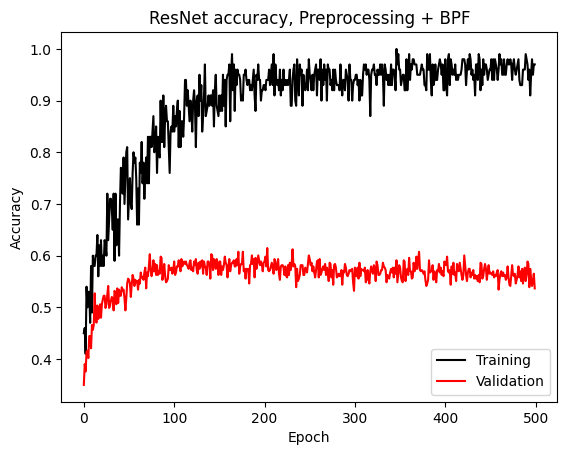

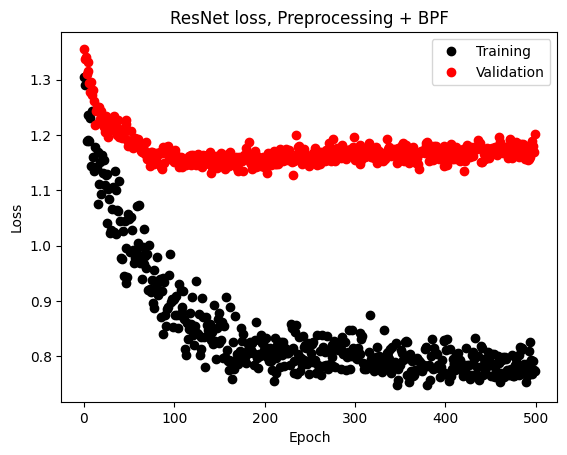

In [ ]:
#Update arrays and titles
plt.plot(np.arange(num_epochs),train_history_5,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_5,label='Validation',color='r')
plt.title('ResNet accuracy, Preprocessing + BPF')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_5,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_5,'o',label='Validation',color='r')
plt.title('ResNet loss, Preprocessing + BPF')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Part 6a: SGD w/ Momentum + Preprocessing + BPF

In [ ]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

# Preprocessing the dataset
# pass only training data to train prep, val and test data to test prep

x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(x_test), test_data_prep(x_valid)

x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

# Convert x train to numpy

x_train_np = x_train.cpu().numpy()
print(x_train_np.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: torch.Size([6768, 22, 400])
Shape of validation set: torch.Size([423, 22, 400])
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([6768, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torc

In [ ]:
# Define the band-pass filter parameters
cutoff_frequency = np.array([4, 40])  # Cut-off frequency in Hz
sampling_rate = 125  # Sampling rate in Hz (adjust based on your data)

# Design a Butterworth band-pass filter
order = 3  # Filter order
b, a = butter(N=order, Wn=cutoff_frequency / (0.5 * sampling_rate), btype='band', analog=False, output='ba')

x_train_bpf = np.zeros(x_train_np.shape)
# Apply the filter to the data
for i in range(x_train_np.shape[0]):
    for j in range(x_train_np.shape[2]):
        filtered_data = filtfilt(b, a, x_train_np[i,0,j,:])
        x_train_bpf[i,0,j,:] = filtered_data

x_train_bpf = torch.tensor(x_train_bpf).float().to(device)
print(x_train_bpf.shape)

torch.Size([6768, 1, 22, 400])


In [ ]:
#Build the model
model6 = ResNet(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model6)
total_params = sum(p.numel() for p in model6.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model6.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNet(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1): Con

In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model6.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.9)
step_size = 25
gamma = 0.1
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
#optimizer = torch.optim.Adam(model6.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_6, val_history_6 = np.array([]), np.array([])
train_loss_hist_6, val_loss_hist_6 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = '/content/drive/MyDrive/C147_Final_Project/best_model_params_CNN'

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model6_params.pt')
    torch.save(model6.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model6.train()

        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model6(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()
            scheduler.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        #Rename
        model6.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model6(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_6 = np.append(train_history_6, train_acc.item())
        val_history_6 = np.append(val_history_6, val_acc.item())
        train_loss_hist_6 = np.append(train_loss_hist_6, loss.item())
        val_loss_hist_6 = np.append(val_loss_hist_6, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model6.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-18-2ad6b99b071b>:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:03<25:27,  3.06s/it]

Epoch 1 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.389, Val loss: 1.386


  0%|          | 2/500 [00:06<25:09,  3.03s/it]

Epoch 2 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.385, Val loss: 1.386


  1%|          | 3/500 [00:09<25:21,  3.06s/it]

Epoch 3 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.391, Val loss: 1.386


  1%|          | 4/500 [00:12<25:12,  3.05s/it]

Epoch 4 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.384, Val loss: 1.386


  1%|          | 5/500 [00:15<25:13,  3.06s/it]

Epoch 5 Finished!!!
Train acc: 0.270, Val acc: 0.260
Train loss: 1.386, Val loss: 1.386


  1%|          | 6/500 [00:18<25:10,  3.06s/it]

Epoch 6 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.392, Val loss: 1.386


  1%|▏         | 7/500 [00:21<25:08,  3.06s/it]

Epoch 7 Finished!!!
Train acc: 0.250, Val acc: 0.260
Train loss: 1.388, Val loss: 1.386


  2%|▏         | 8/500 [00:24<25:05,  3.06s/it]

Epoch 8 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.394, Val loss: 1.386


  2%|▏         | 9/500 [00:27<25:01,  3.06s/it]

Epoch 9 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.386, Val loss: 1.386


  2%|▏         | 10/500 [00:30<24:56,  3.05s/it]

Epoch 10 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.391, Val loss: 1.386


  2%|▏         | 11/500 [00:33<24:49,  3.05s/it]

Epoch 11 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.385, Val loss: 1.386


  2%|▏         | 12/500 [00:36<24:43,  3.04s/it]

Epoch 12 Finished!!!
Train acc: 0.280, Val acc: 0.260
Train loss: 1.387, Val loss: 1.386


  3%|▎         | 13/500 [00:39<24:37,  3.03s/it]

Epoch 13 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.396, Val loss: 1.386


  3%|▎         | 14/500 [00:42<24:34,  3.03s/it]

Epoch 14 Finished!!!
Train acc: 0.280, Val acc: 0.267
Train loss: 1.383, Val loss: 1.386


  3%|▎         | 15/500 [00:45<24:25,  3.02s/it]

Epoch 15 Finished!!!
Train acc: 0.180, Val acc: 0.262
Train loss: 1.392, Val loss: 1.386


  3%|▎         | 16/500 [00:48<24:18,  3.01s/it]

Epoch 16 Finished!!!
Train acc: 0.190, Val acc: 0.258
Train loss: 1.393, Val loss: 1.386


  3%|▎         | 17/500 [00:51<24:11,  3.01s/it]

Epoch 17 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.381, Val loss: 1.386


  4%|▎         | 18/500 [00:54<24:05,  3.00s/it]

Epoch 18 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.386, Val loss: 1.386


  4%|▍         | 19/500 [00:57<23:59,  2.99s/it]

Epoch 19 Finished!!!
Train acc: 0.260, Val acc: 0.260
Train loss: 1.396, Val loss: 1.386


  4%|▍         | 20/500 [01:00<23:54,  2.99s/it]

Epoch 20 Finished!!!
Train acc: 0.220, Val acc: 0.258
Train loss: 1.394, Val loss: 1.386


  4%|▍         | 21/500 [01:03<23:49,  2.98s/it]

Epoch 21 Finished!!!
Train acc: 0.210, Val acc: 0.258
Train loss: 1.393, Val loss: 1.386


  4%|▍         | 22/500 [01:06<23:45,  2.98s/it]

Epoch 22 Finished!!!
Train acc: 0.190, Val acc: 0.260
Train loss: 1.393, Val loss: 1.386


  5%|▍         | 23/500 [01:09<23:41,  2.98s/it]

Epoch 23 Finished!!!
Train acc: 0.220, Val acc: 0.260
Train loss: 1.394, Val loss: 1.386


  5%|▍         | 24/500 [01:12<23:38,  2.98s/it]

Epoch 24 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.383, Val loss: 1.386


  5%|▌         | 25/500 [01:15<23:35,  2.98s/it]

Epoch 25 Finished!!!
Train acc: 0.250, Val acc: 0.260
Train loss: 1.389, Val loss: 1.386


  5%|▌         | 26/500 [01:18<23:32,  2.98s/it]

Epoch 26 Finished!!!
Train acc: 0.270, Val acc: 0.258
Train loss: 1.385, Val loss: 1.386


  5%|▌         | 27/500 [01:21<23:30,  2.98s/it]

Epoch 27 Finished!!!
Train acc: 0.280, Val acc: 0.258
Train loss: 1.380, Val loss: 1.386


  6%|▌         | 28/500 [01:24<23:27,  2.98s/it]

Epoch 28 Finished!!!
Train acc: 0.320, Val acc: 0.255
Train loss: 1.384, Val loss: 1.386


  6%|▌         | 29/500 [01:27<23:25,  2.99s/it]

Epoch 29 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.389, Val loss: 1.386


  6%|▌         | 30/500 [01:30<23:24,  2.99s/it]

Epoch 30 Finished!!!
Train acc: 0.270, Val acc: 0.258
Train loss: 1.388, Val loss: 1.386


  6%|▌         | 31/500 [01:33<23:22,  2.99s/it]

Epoch 31 Finished!!!
Train acc: 0.170, Val acc: 0.258
Train loss: 1.387, Val loss: 1.386


  6%|▋         | 32/500 [01:36<23:20,  2.99s/it]

Epoch 32 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.386, Val loss: 1.386


  7%|▋         | 33/500 [01:39<23:18,  3.00s/it]

Epoch 33 Finished!!!
Train acc: 0.200, Val acc: 0.258
Train loss: 1.392, Val loss: 1.386


  7%|▋         | 34/500 [01:42<23:17,  3.00s/it]

Epoch 34 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.382, Val loss: 1.386


  7%|▋         | 35/500 [01:45<23:16,  3.00s/it]

Epoch 35 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.392, Val loss: 1.386


  7%|▋         | 36/500 [01:48<23:14,  3.01s/it]

Epoch 36 Finished!!!
Train acc: 0.200, Val acc: 0.258
Train loss: 1.389, Val loss: 1.386


  7%|▋         | 37/500 [01:51<23:13,  3.01s/it]

Epoch 37 Finished!!!
Train acc: 0.220, Val acc: 0.262
Train loss: 1.389, Val loss: 1.386


  8%|▊         | 38/500 [01:54<23:10,  3.01s/it]

Epoch 38 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.394, Val loss: 1.386


  8%|▊         | 39/500 [01:57<23:25,  3.05s/it]

Epoch 39 Finished!!!
Train acc: 0.230, Val acc: 0.260
Train loss: 1.392, Val loss: 1.386


  8%|▊         | 40/500 [02:00<23:18,  3.04s/it]

Epoch 40 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.384, Val loss: 1.386


  8%|▊         | 41/500 [02:03<23:12,  3.03s/it]

Epoch 41 Finished!!!
Train acc: 0.240, Val acc: 0.253
Train loss: 1.389, Val loss: 1.386


  8%|▊         | 42/500 [02:06<23:06,  3.03s/it]

Epoch 42 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.388, Val loss: 1.386


  9%|▊         | 43/500 [02:09<23:01,  3.02s/it]

Epoch 43 Finished!!!
Train acc: 0.190, Val acc: 0.258
Train loss: 1.394, Val loss: 1.386


  9%|▉         | 44/500 [02:12<22:57,  3.02s/it]

Epoch 44 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.394, Val loss: 1.386


  9%|▉         | 45/500 [02:15<22:52,  3.02s/it]

Epoch 45 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.386, Val loss: 1.386


  9%|▉         | 46/500 [02:18<22:47,  3.01s/it]

Epoch 46 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.393, Val loss: 1.386


  9%|▉         | 47/500 [02:21<22:42,  3.01s/it]

Epoch 47 Finished!!!
Train acc: 0.320, Val acc: 0.260
Train loss: 1.385, Val loss: 1.386


 10%|▉         | 48/500 [02:24<22:39,  3.01s/it]

Epoch 48 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.383, Val loss: 1.386


 10%|▉         | 49/500 [02:27<22:34,  3.00s/it]

Epoch 49 Finished!!!
Train acc: 0.310, Val acc: 0.260
Train loss: 1.386, Val loss: 1.386


 10%|█         | 50/500 [02:30<22:30,  3.00s/it]

Epoch 50 Finished!!!
Train acc: 0.230, Val acc: 0.258
Train loss: 1.391, Val loss: 1.386


 10%|█         | 51/500 [02:33<22:26,  3.00s/it]

Epoch 51 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.389, Val loss: 1.386


 10%|█         | 52/500 [02:36<22:23,  3.00s/it]

Epoch 52 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.379, Val loss: 1.386


 11%|█         | 53/500 [02:39<22:19,  3.00s/it]

Epoch 53 Finished!!!
Train acc: 0.280, Val acc: 0.258
Train loss: 1.377, Val loss: 1.386


 11%|█         | 54/500 [02:42<22:15,  2.99s/it]

Epoch 54 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.394, Val loss: 1.386


 11%|█         | 55/500 [02:45<22:12,  2.99s/it]

Epoch 55 Finished!!!
Train acc: 0.330, Val acc: 0.255
Train loss: 1.382, Val loss: 1.386


 11%|█         | 56/500 [02:48<22:09,  2.99s/it]

Epoch 56 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.395, Val loss: 1.386


 11%|█▏        | 57/500 [02:51<22:06,  2.99s/it]

Epoch 57 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.394, Val loss: 1.386


 12%|█▏        | 58/500 [02:54<22:03,  2.99s/it]

Epoch 58 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.382, Val loss: 1.386


 12%|█▏        | 59/500 [02:57<21:59,  2.99s/it]

Epoch 59 Finished!!!
Train acc: 0.210, Val acc: 0.262
Train loss: 1.390, Val loss: 1.386


 12%|█▏        | 60/500 [03:00<21:57,  2.99s/it]

Epoch 60 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.394, Val loss: 1.386


 12%|█▏        | 61/500 [03:03<21:54,  3.00s/it]

Epoch 61 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.387, Val loss: 1.386


 12%|█▏        | 62/500 [03:06<21:51,  3.00s/it]

Epoch 62 Finished!!!
Train acc: 0.210, Val acc: 0.262
Train loss: 1.396, Val loss: 1.386


 13%|█▎        | 63/500 [03:09<21:49,  3.00s/it]

Epoch 63 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.389, Val loss: 1.386


 13%|█▎        | 64/500 [03:12<21:47,  3.00s/it]

Epoch 64 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.387, Val loss: 1.386


 13%|█▎        | 65/500 [03:15<21:45,  3.00s/it]

Epoch 65 Finished!!!
Train acc: 0.310, Val acc: 0.262
Train loss: 1.381, Val loss: 1.386


 13%|█▎        | 66/500 [03:18<21:42,  3.00s/it]

Epoch 66 Finished!!!
Train acc: 0.180, Val acc: 0.253
Train loss: 1.399, Val loss: 1.386


 13%|█▎        | 67/500 [03:21<21:38,  3.00s/it]

Epoch 67 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.380, Val loss: 1.386


 14%|█▎        | 68/500 [03:24<21:35,  3.00s/it]

Epoch 68 Finished!!!
Train acc: 0.240, Val acc: 0.260
Train loss: 1.384, Val loss: 1.386


 14%|█▍        | 69/500 [03:27<21:32,  3.00s/it]

Epoch 69 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.396, Val loss: 1.386


 14%|█▍        | 70/500 [03:30<21:30,  3.00s/it]

Epoch 70 Finished!!!
Train acc: 0.250, Val acc: 0.265
Train loss: 1.389, Val loss: 1.386


 14%|█▍        | 71/500 [03:33<21:26,  3.00s/it]

Epoch 71 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.387, Val loss: 1.386


 14%|█▍        | 72/500 [03:36<21:23,  3.00s/it]

Epoch 72 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.393, Val loss: 1.386


 15%|█▍        | 73/500 [03:39<21:20,  3.00s/it]

Epoch 73 Finished!!!
Train acc: 0.260, Val acc: 0.260
Train loss: 1.387, Val loss: 1.386


 15%|█▍        | 74/500 [03:42<21:18,  3.00s/it]

Epoch 74 Finished!!!
Train acc: 0.300, Val acc: 0.258
Train loss: 1.383, Val loss: 1.386


 15%|█▌        | 75/500 [03:45<21:15,  3.00s/it]

Epoch 75 Finished!!!
Train acc: 0.260, Val acc: 0.258
Train loss: 1.388, Val loss: 1.386


 15%|█▌        | 76/500 [03:48<21:11,  3.00s/it]

Epoch 76 Finished!!!
Train acc: 0.200, Val acc: 0.262
Train loss: 1.393, Val loss: 1.386


 15%|█▌        | 77/500 [03:51<21:08,  3.00s/it]

Epoch 77 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.386, Val loss: 1.386


 16%|█▌        | 78/500 [03:54<21:06,  3.00s/it]

Epoch 78 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.392, Val loss: 1.386


 16%|█▌        | 79/500 [03:57<21:03,  3.00s/it]

Epoch 79 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.386, Val loss: 1.386


 16%|█▌        | 80/500 [04:00<21:00,  3.00s/it]

Epoch 80 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.386, Val loss: 1.386


 16%|█▌        | 81/500 [04:03<20:57,  3.00s/it]

Epoch 81 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.385, Val loss: 1.386


 16%|█▋        | 82/500 [04:06<20:55,  3.00s/it]

Epoch 82 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.387, Val loss: 1.386


 17%|█▋        | 83/500 [04:09<20:52,  3.00s/it]

Epoch 83 Finished!!!
Train acc: 0.220, Val acc: 0.262
Train loss: 1.393, Val loss: 1.386


 17%|█▋        | 84/500 [04:12<20:48,  3.00s/it]

Epoch 84 Finished!!!
Train acc: 0.210, Val acc: 0.258
Train loss: 1.391, Val loss: 1.386


 17%|█▋        | 85/500 [04:15<20:46,  3.00s/it]

Epoch 85 Finished!!!
Train acc: 0.230, Val acc: 0.258
Train loss: 1.393, Val loss: 1.386


 17%|█▋        | 86/500 [04:18<20:43,  3.00s/it]

Epoch 86 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.381, Val loss: 1.386


 17%|█▋        | 87/500 [04:21<20:40,  3.00s/it]

Epoch 87 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.384, Val loss: 1.386


 18%|█▊        | 88/500 [04:24<20:37,  3.00s/it]

Epoch 88 Finished!!!
Train acc: 0.330, Val acc: 0.255
Train loss: 1.384, Val loss: 1.386


 18%|█▊        | 89/500 [04:27<20:34,  3.00s/it]

Epoch 89 Finished!!!
Train acc: 0.320, Val acc: 0.265
Train loss: 1.377, Val loss: 1.386


 18%|█▊        | 90/500 [04:30<20:31,  3.00s/it]

Epoch 90 Finished!!!
Train acc: 0.250, Val acc: 0.260
Train loss: 1.392, Val loss: 1.386


 18%|█▊        | 91/500 [04:33<20:28,  3.00s/it]

Epoch 91 Finished!!!
Train acc: 0.230, Val acc: 0.258
Train loss: 1.388, Val loss: 1.386


 18%|█▊        | 92/500 [04:36<20:25,  3.00s/it]

Epoch 92 Finished!!!
Train acc: 0.230, Val acc: 0.258
Train loss: 1.394, Val loss: 1.386


 19%|█▊        | 93/500 [04:39<20:22,  3.00s/it]

Epoch 93 Finished!!!
Train acc: 0.250, Val acc: 0.262
Train loss: 1.391, Val loss: 1.386


 19%|█▉        | 94/500 [04:42<20:19,  3.00s/it]

Epoch 94 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.392, Val loss: 1.386


 19%|█▉        | 95/500 [04:45<20:16,  3.00s/it]

Epoch 95 Finished!!!
Train acc: 0.190, Val acc: 0.260
Train loss: 1.395, Val loss: 1.386


 19%|█▉        | 96/500 [04:48<20:13,  3.00s/it]

Epoch 96 Finished!!!
Train acc: 0.220, Val acc: 0.258
Train loss: 1.397, Val loss: 1.386


 19%|█▉        | 97/500 [04:51<20:10,  3.00s/it]

Epoch 97 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.389, Val loss: 1.386


 20%|█▉        | 98/500 [04:54<20:07,  3.00s/it]

Epoch 98 Finished!!!
Train acc: 0.250, Val acc: 0.260
Train loss: 1.388, Val loss: 1.386


 20%|█▉        | 99/500 [04:57<20:05,  3.01s/it]

Epoch 99 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.381, Val loss: 1.386


 20%|██        | 100/500 [05:00<20:01,  3.00s/it]

Epoch 100 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.378, Val loss: 1.386


 20%|██        | 101/500 [05:03<19:57,  3.00s/it]

Epoch 101 Finished!!!
Train acc: 0.230, Val acc: 0.258
Train loss: 1.388, Val loss: 1.386


 20%|██        | 102/500 [05:06<19:54,  3.00s/it]

Epoch 102 Finished!!!
Train acc: 0.290, Val acc: 0.258
Train loss: 1.379, Val loss: 1.386


 21%|██        | 103/500 [05:09<19:52,  3.00s/it]

Epoch 103 Finished!!!
Train acc: 0.160, Val acc: 0.258
Train loss: 1.394, Val loss: 1.386


 21%|██        | 104/500 [05:12<19:48,  3.00s/it]

Epoch 104 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.392, Val loss: 1.386


 21%|██        | 105/500 [05:15<19:45,  3.00s/it]

Epoch 105 Finished!!!
Train acc: 0.270, Val acc: 0.258
Train loss: 1.388, Val loss: 1.386


 21%|██        | 106/500 [05:18<19:41,  3.00s/it]

Epoch 106 Finished!!!
Train acc: 0.220, Val acc: 0.260
Train loss: 1.391, Val loss: 1.386


 21%|██▏       | 107/500 [05:21<19:38,  3.00s/it]

Epoch 107 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.388, Val loss: 1.386


 22%|██▏       | 108/500 [05:24<19:36,  3.00s/it]

Epoch 108 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.393, Val loss: 1.386


 22%|██▏       | 109/500 [05:27<19:33,  3.00s/it]

Epoch 109 Finished!!!
Train acc: 0.230, Val acc: 0.260
Train loss: 1.396, Val loss: 1.386


 22%|██▏       | 110/500 [05:30<19:29,  3.00s/it]

Epoch 110 Finished!!!
Train acc: 0.230, Val acc: 0.258
Train loss: 1.394, Val loss: 1.386


 22%|██▏       | 111/500 [05:33<19:26,  3.00s/it]

Epoch 111 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.393, Val loss: 1.386


 22%|██▏       | 112/500 [05:36<19:23,  3.00s/it]

Epoch 112 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.387, Val loss: 1.386


 23%|██▎       | 113/500 [05:39<19:20,  3.00s/it]

Epoch 113 Finished!!!
Train acc: 0.200, Val acc: 0.258
Train loss: 1.393, Val loss: 1.386


 23%|██▎       | 114/500 [05:42<19:16,  3.00s/it]

Epoch 114 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.393, Val loss: 1.386


 23%|██▎       | 115/500 [05:45<19:13,  3.00s/it]

Epoch 115 Finished!!!
Train acc: 0.220, Val acc: 0.258
Train loss: 1.384, Val loss: 1.386


 23%|██▎       | 116/500 [05:48<19:10,  3.00s/it]

Epoch 116 Finished!!!
Train acc: 0.260, Val acc: 0.265
Train loss: 1.386, Val loss: 1.386


 23%|██▎       | 117/500 [05:51<19:07,  3.00s/it]

Epoch 117 Finished!!!
Train acc: 0.240, Val acc: 0.260
Train loss: 1.390, Val loss: 1.386


 24%|██▎       | 118/500 [05:54<19:04,  3.00s/it]

Epoch 118 Finished!!!
Train acc: 0.230, Val acc: 0.262
Train loss: 1.382, Val loss: 1.386


 24%|██▍       | 119/500 [05:57<19:01,  3.00s/it]

Epoch 119 Finished!!!
Train acc: 0.230, Val acc: 0.258
Train loss: 1.389, Val loss: 1.386


 24%|██▍       | 120/500 [06:00<18:59,  3.00s/it]

Epoch 120 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.386, Val loss: 1.386


 24%|██▍       | 121/500 [06:03<18:56,  3.00s/it]

Epoch 121 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.394, Val loss: 1.386


 24%|██▍       | 122/500 [06:06<18:52,  3.00s/it]

Epoch 122 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.390, Val loss: 1.386


 25%|██▍       | 123/500 [06:09<18:49,  3.00s/it]

Epoch 123 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.397, Val loss: 1.386


 25%|██▍       | 124/500 [06:12<18:46,  3.00s/it]

Epoch 124 Finished!!!
Train acc: 0.370, Val acc: 0.258
Train loss: 1.374, Val loss: 1.386


 25%|██▌       | 125/500 [06:15<18:43,  3.00s/it]

Epoch 125 Finished!!!
Train acc: 0.230, Val acc: 0.258
Train loss: 1.389, Val loss: 1.386


 25%|██▌       | 126/500 [06:18<18:40,  3.00s/it]

Epoch 126 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.387, Val loss: 1.386


 25%|██▌       | 127/500 [06:21<18:37,  3.00s/it]

Epoch 127 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.376, Val loss: 1.386


 26%|██▌       | 128/500 [06:24<18:33,  2.99s/it]

Epoch 128 Finished!!!
Train acc: 0.190, Val acc: 0.260
Train loss: 1.390, Val loss: 1.386


 26%|██▌       | 129/500 [06:27<18:31,  3.00s/it]

Epoch 129 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.392, Val loss: 1.386


 26%|██▌       | 130/500 [06:30<18:28,  2.99s/it]

Epoch 130 Finished!!!
Train acc: 0.290, Val acc: 0.258
Train loss: 1.386, Val loss: 1.386


 26%|██▌       | 131/500 [06:33<18:24,  2.99s/it]

Epoch 131 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.385, Val loss: 1.386


 26%|██▋       | 132/500 [06:36<18:21,  2.99s/it]

Epoch 132 Finished!!!
Train acc: 0.220, Val acc: 0.262
Train loss: 1.388, Val loss: 1.386


 27%|██▋       | 133/500 [06:39<18:18,  2.99s/it]

Epoch 133 Finished!!!
Train acc: 0.270, Val acc: 0.258
Train loss: 1.381, Val loss: 1.386


 27%|██▋       | 134/500 [06:42<18:15,  2.99s/it]

Epoch 134 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.381, Val loss: 1.386


 27%|██▋       | 135/500 [06:45<18:12,  2.99s/it]

Epoch 135 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.384, Val loss: 1.386


 27%|██▋       | 136/500 [06:48<18:09,  2.99s/it]

Epoch 136 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.385, Val loss: 1.386


 27%|██▋       | 137/500 [06:51<18:07,  3.00s/it]

Epoch 137 Finished!!!
Train acc: 0.270, Val acc: 0.260
Train loss: 1.389, Val loss: 1.386


 28%|██▊       | 138/500 [06:54<18:05,  3.00s/it]

Epoch 138 Finished!!!
Train acc: 0.280, Val acc: 0.262
Train loss: 1.377, Val loss: 1.386


 28%|██▊       | 139/500 [06:57<18:02,  3.00s/it]

Epoch 139 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.397, Val loss: 1.386


 28%|██▊       | 140/500 [07:00<18:00,  3.00s/it]

Epoch 140 Finished!!!
Train acc: 0.230, Val acc: 0.260
Train loss: 1.392, Val loss: 1.386


 28%|██▊       | 141/500 [07:03<17:58,  3.00s/it]

Epoch 141 Finished!!!
Train acc: 0.290, Val acc: 0.253
Train loss: 1.385, Val loss: 1.386


 28%|██▊       | 142/500 [07:06<17:56,  3.01s/it]

Epoch 142 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.392, Val loss: 1.386


 29%|██▊       | 143/500 [07:09<17:53,  3.01s/it]

Epoch 143 Finished!!!
Train acc: 0.240, Val acc: 0.260
Train loss: 1.381, Val loss: 1.386


 29%|██▉       | 144/500 [07:12<17:50,  3.01s/it]

Epoch 144 Finished!!!
Train acc: 0.200, Val acc: 0.258
Train loss: 1.390, Val loss: 1.386


 29%|██▉       | 145/500 [07:15<17:47,  3.01s/it]

Epoch 145 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.377, Val loss: 1.386


 29%|██▉       | 146/500 [07:18<17:44,  3.01s/it]

Epoch 146 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.389, Val loss: 1.386


 29%|██▉       | 147/500 [07:21<17:41,  3.01s/it]

Epoch 147 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.388, Val loss: 1.386


 30%|██▉       | 148/500 [07:24<17:38,  3.01s/it]

Epoch 148 Finished!!!
Train acc: 0.200, Val acc: 0.258
Train loss: 1.390, Val loss: 1.386


 30%|██▉       | 149/500 [07:27<17:34,  3.00s/it]

Epoch 149 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.382, Val loss: 1.386


 30%|███       | 150/500 [07:30<17:31,  3.00s/it]

Epoch 150 Finished!!!
Train acc: 0.180, Val acc: 0.260
Train loss: 1.396, Val loss: 1.386


 30%|███       | 151/500 [07:33<17:28,  3.00s/it]

Epoch 151 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.382, Val loss: 1.386


 30%|███       | 152/500 [07:36<17:24,  3.00s/it]

Epoch 152 Finished!!!
Train acc: 0.330, Val acc: 0.258
Train loss: 1.371, Val loss: 1.386


 31%|███       | 153/500 [07:39<17:20,  3.00s/it]

Epoch 153 Finished!!!
Train acc: 0.240, Val acc: 0.267
Train loss: 1.394, Val loss: 1.386


 31%|███       | 154/500 [07:42<17:16,  3.00s/it]

Epoch 154 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.387, Val loss: 1.386


 31%|███       | 155/500 [07:45<17:13,  2.99s/it]

Epoch 155 Finished!!!
Train acc: 0.320, Val acc: 0.255
Train loss: 1.380, Val loss: 1.386


 31%|███       | 156/500 [07:48<17:08,  2.99s/it]

Epoch 156 Finished!!!
Train acc: 0.290, Val acc: 0.258
Train loss: 1.385, Val loss: 1.386


 31%|███▏      | 157/500 [07:51<17:05,  2.99s/it]

Epoch 157 Finished!!!
Train acc: 0.330, Val acc: 0.255
Train loss: 1.378, Val loss: 1.386


 32%|███▏      | 158/500 [07:54<17:02,  2.99s/it]

Epoch 158 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.383, Val loss: 1.386


 32%|███▏      | 159/500 [07:57<17:00,  2.99s/it]

Epoch 159 Finished!!!
Train acc: 0.290, Val acc: 0.258
Train loss: 1.382, Val loss: 1.386


 32%|███▏      | 160/500 [08:00<16:57,  2.99s/it]

Epoch 160 Finished!!!
Train acc: 0.190, Val acc: 0.258
Train loss: 1.396, Val loss: 1.386


 32%|███▏      | 161/500 [08:03<16:54,  2.99s/it]

Epoch 161 Finished!!!
Train acc: 0.240, Val acc: 0.262
Train loss: 1.388, Val loss: 1.386


 32%|███▏      | 162/500 [08:06<16:52,  2.99s/it]

Epoch 162 Finished!!!
Train acc: 0.280, Val acc: 0.258
Train loss: 1.390, Val loss: 1.386


 33%|███▎      | 163/500 [08:09<16:50,  3.00s/it]

Epoch 163 Finished!!!
Train acc: 0.280, Val acc: 0.258
Train loss: 1.388, Val loss: 1.386


 33%|███▎      | 164/500 [08:12<16:47,  3.00s/it]

Epoch 164 Finished!!!
Train acc: 0.210, Val acc: 0.258
Train loss: 1.388, Val loss: 1.386


 33%|███▎      | 165/500 [08:15<16:45,  3.00s/it]

Epoch 165 Finished!!!
Train acc: 0.280, Val acc: 0.258
Train loss: 1.388, Val loss: 1.386


 33%|███▎      | 166/500 [08:18<16:42,  3.00s/it]

Epoch 166 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.386, Val loss: 1.386


 33%|███▎      | 167/500 [08:21<16:40,  3.00s/it]

Epoch 167 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.394, Val loss: 1.386


 34%|███▎      | 168/500 [08:24<16:37,  3.01s/it]

Epoch 168 Finished!!!
Train acc: 0.210, Val acc: 0.258
Train loss: 1.394, Val loss: 1.386


 34%|███▍      | 169/500 [08:27<16:35,  3.01s/it]

Epoch 169 Finished!!!
Train acc: 0.280, Val acc: 0.260
Train loss: 1.391, Val loss: 1.386


 34%|███▍      | 170/500 [08:30<16:32,  3.01s/it]

Epoch 170 Finished!!!
Train acc: 0.250, Val acc: 0.260
Train loss: 1.390, Val loss: 1.386


 34%|███▍      | 171/500 [08:33<16:29,  3.01s/it]

Epoch 171 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.396, Val loss: 1.386


 34%|███▍      | 172/500 [08:36<16:26,  3.01s/it]

Epoch 172 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.390, Val loss: 1.386


 35%|███▍      | 173/500 [08:39<16:23,  3.01s/it]

Epoch 173 Finished!!!
Train acc: 0.190, Val acc: 0.260
Train loss: 1.399, Val loss: 1.386


 35%|███▍      | 174/500 [08:42<16:19,  3.01s/it]

Epoch 174 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.392, Val loss: 1.386


 35%|███▌      | 175/500 [08:45<16:16,  3.00s/it]

Epoch 175 Finished!!!
Train acc: 0.190, Val acc: 0.262
Train loss: 1.391, Val loss: 1.386


 35%|███▌      | 176/500 [08:48<16:13,  3.00s/it]

Epoch 176 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.396, Val loss: 1.386


 35%|███▌      | 177/500 [08:51<16:10,  3.00s/it]

Epoch 177 Finished!!!
Train acc: 0.300, Val acc: 0.260
Train loss: 1.387, Val loss: 1.386


 36%|███▌      | 178/500 [08:54<16:06,  3.00s/it]

Epoch 178 Finished!!!
Train acc: 0.300, Val acc: 0.260
Train loss: 1.380, Val loss: 1.386


 36%|███▌      | 179/500 [08:57<16:03,  3.00s/it]

Epoch 179 Finished!!!
Train acc: 0.160, Val acc: 0.255
Train loss: 1.398, Val loss: 1.386


 36%|███▌      | 180/500 [09:00<16:00,  3.00s/it]

Epoch 180 Finished!!!
Train acc: 0.150, Val acc: 0.258
Train loss: 1.399, Val loss: 1.386


 36%|███▌      | 181/500 [09:03<15:57,  3.00s/it]

Epoch 181 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.381, Val loss: 1.386


 36%|███▋      | 182/500 [09:06<15:53,  3.00s/it]

Epoch 182 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.394, Val loss: 1.386


 37%|███▋      | 183/500 [09:09<15:50,  3.00s/it]

Epoch 183 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.396, Val loss: 1.386


 37%|███▋      | 184/500 [09:12<15:47,  3.00s/it]

Epoch 184 Finished!!!
Train acc: 0.270, Val acc: 0.258
Train loss: 1.388, Val loss: 1.386


 37%|███▋      | 185/500 [09:15<15:44,  3.00s/it]

Epoch 185 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.391, Val loss: 1.386


 37%|███▋      | 186/500 [09:18<15:40,  3.00s/it]

Epoch 186 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.391, Val loss: 1.386


 37%|███▋      | 187/500 [09:21<15:37,  3.00s/it]

Epoch 187 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.394, Val loss: 1.386


 38%|███▊      | 188/500 [09:24<15:34,  3.00s/it]

Epoch 188 Finished!!!
Train acc: 0.310, Val acc: 0.260
Train loss: 1.377, Val loss: 1.386


 38%|███▊      | 189/500 [09:27<15:31,  3.00s/it]

Epoch 189 Finished!!!
Train acc: 0.280, Val acc: 0.258
Train loss: 1.383, Val loss: 1.386


 38%|███▊      | 190/500 [09:30<15:28,  2.99s/it]

Epoch 190 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.390, Val loss: 1.386


 38%|███▊      | 191/500 [09:33<15:24,  2.99s/it]

Epoch 191 Finished!!!
Train acc: 0.290, Val acc: 0.258
Train loss: 1.380, Val loss: 1.386


 38%|███▊      | 192/500 [09:36<15:22,  2.99s/it]

Epoch 192 Finished!!!
Train acc: 0.190, Val acc: 0.253
Train loss: 1.398, Val loss: 1.386


 39%|███▊      | 193/500 [09:39<15:19,  2.99s/it]

Epoch 193 Finished!!!
Train acc: 0.240, Val acc: 0.267
Train loss: 1.388, Val loss: 1.386


 39%|███▉      | 194/500 [09:42<15:15,  2.99s/it]

Epoch 194 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.383, Val loss: 1.386


 39%|███▉      | 195/500 [09:45<15:12,  2.99s/it]

Epoch 195 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.385, Val loss: 1.386


 39%|███▉      | 196/500 [09:48<15:10,  2.99s/it]

Epoch 196 Finished!!!
Train acc: 0.270, Val acc: 0.260
Train loss: 1.383, Val loss: 1.386


 39%|███▉      | 197/500 [09:51<15:08,  3.00s/it]

Epoch 197 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.374, Val loss: 1.386


 40%|███▉      | 198/500 [09:54<15:05,  3.00s/it]

Epoch 198 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.398, Val loss: 1.386


 40%|███▉      | 199/500 [09:57<15:02,  3.00s/it]

Epoch 199 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.390, Val loss: 1.386


 40%|████      | 200/500 [10:00<14:59,  3.00s/it]

Epoch 200 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.391, Val loss: 1.386


 40%|████      | 201/500 [10:03<14:56,  3.00s/it]

Epoch 201 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.393, Val loss: 1.386


 40%|████      | 202/500 [10:06<14:53,  3.00s/it]

Epoch 202 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.396, Val loss: 1.386


 41%|████      | 203/500 [10:09<14:50,  3.00s/it]

Epoch 203 Finished!!!
Train acc: 0.190, Val acc: 0.255
Train loss: 1.398, Val loss: 1.386


 41%|████      | 204/500 [10:12<14:48,  3.00s/it]

Epoch 204 Finished!!!
Train acc: 0.270, Val acc: 0.258
Train loss: 1.388, Val loss: 1.386


 41%|████      | 205/500 [10:15<14:45,  3.00s/it]

Epoch 205 Finished!!!
Train acc: 0.250, Val acc: 0.253
Train loss: 1.387, Val loss: 1.386


 41%|████      | 206/500 [10:18<14:44,  3.01s/it]

Epoch 206 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.379, Val loss: 1.386


 41%|████▏     | 207/500 [10:21<14:41,  3.01s/it]

Epoch 207 Finished!!!
Train acc: 0.210, Val acc: 0.258
Train loss: 1.395, Val loss: 1.386


 42%|████▏     | 208/500 [10:24<14:38,  3.01s/it]

Epoch 208 Finished!!!
Train acc: 0.350, Val acc: 0.253
Train loss: 1.377, Val loss: 1.386


 42%|████▏     | 209/500 [10:27<14:35,  3.01s/it]

Epoch 209 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.388, Val loss: 1.386


 42%|████▏     | 210/500 [10:30<14:32,  3.01s/it]

Epoch 210 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.391, Val loss: 1.386


 42%|████▏     | 211/500 [10:33<14:29,  3.01s/it]

Epoch 211 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.393, Val loss: 1.386


 42%|████▏     | 212/500 [10:36<14:25,  3.01s/it]

Epoch 212 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.382, Val loss: 1.386


 43%|████▎     | 213/500 [10:39<14:22,  3.00s/it]

Epoch 213 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.391, Val loss: 1.386


 43%|████▎     | 214/500 [10:42<14:18,  3.00s/it]

Epoch 214 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.392, Val loss: 1.386


 43%|████▎     | 215/500 [10:45<14:15,  3.00s/it]

Epoch 215 Finished!!!
Train acc: 0.230, Val acc: 0.253
Train loss: 1.388, Val loss: 1.386


 43%|████▎     | 216/500 [10:48<14:12,  3.00s/it]

Epoch 216 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.390, Val loss: 1.386


 43%|████▎     | 217/500 [10:51<14:09,  3.00s/it]

Epoch 217 Finished!!!
Train acc: 0.210, Val acc: 0.260
Train loss: 1.388, Val loss: 1.386


 44%|████▎     | 218/500 [10:54<14:05,  3.00s/it]

Epoch 218 Finished!!!
Train acc: 0.340, Val acc: 0.258
Train loss: 1.388, Val loss: 1.386


 44%|████▍     | 219/500 [10:57<14:01,  2.99s/it]

Epoch 219 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.385, Val loss: 1.386


 44%|████▍     | 220/500 [11:00<13:58,  2.99s/it]

Epoch 220 Finished!!!
Train acc: 0.330, Val acc: 0.262
Train loss: 1.381, Val loss: 1.386


 44%|████▍     | 221/500 [11:03<13:54,  2.99s/it]

Epoch 221 Finished!!!
Train acc: 0.270, Val acc: 0.260
Train loss: 1.383, Val loss: 1.386


 44%|████▍     | 222/500 [11:06<13:51,  2.99s/it]

Epoch 222 Finished!!!
Train acc: 0.300, Val acc: 0.258
Train loss: 1.396, Val loss: 1.386


 45%|████▍     | 223/500 [11:09<13:48,  2.99s/it]

Epoch 223 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.395, Val loss: 1.386


 45%|████▍     | 224/500 [11:12<13:45,  2.99s/it]

Epoch 224 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.393, Val loss: 1.386


 45%|████▌     | 225/500 [11:15<13:42,  2.99s/it]

Epoch 225 Finished!!!
Train acc: 0.250, Val acc: 0.260
Train loss: 1.385, Val loss: 1.386


 45%|████▌     | 226/500 [11:18<13:40,  3.00s/it]

Epoch 226 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.383, Val loss: 1.386


 45%|████▌     | 227/500 [11:21<13:37,  3.00s/it]

Epoch 227 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.378, Val loss: 1.386


 46%|████▌     | 228/500 [11:24<13:35,  3.00s/it]

Epoch 228 Finished!!!
Train acc: 0.200, Val acc: 0.267
Train loss: 1.389, Val loss: 1.386


 46%|████▌     | 229/500 [11:27<13:32,  3.00s/it]

Epoch 229 Finished!!!
Train acc: 0.230, Val acc: 0.262
Train loss: 1.388, Val loss: 1.386


 46%|████▌     | 230/500 [11:30<13:30,  3.00s/it]

Epoch 230 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.381, Val loss: 1.386


 46%|████▌     | 231/500 [11:33<13:27,  3.00s/it]

Epoch 231 Finished!!!
Train acc: 0.330, Val acc: 0.255
Train loss: 1.379, Val loss: 1.386


 46%|████▋     | 232/500 [11:36<13:25,  3.01s/it]

Epoch 232 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.388, Val loss: 1.386


 47%|████▋     | 233/500 [11:39<13:22,  3.01s/it]

Epoch 233 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.392, Val loss: 1.386


 47%|████▋     | 234/500 [11:42<13:20,  3.01s/it]

Epoch 234 Finished!!!
Train acc: 0.320, Val acc: 0.255
Train loss: 1.381, Val loss: 1.386


 47%|████▋     | 235/500 [11:45<13:17,  3.01s/it]

Epoch 235 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.389, Val loss: 1.386


 47%|████▋     | 236/500 [11:48<13:14,  3.01s/it]

Epoch 236 Finished!!!
Train acc: 0.280, Val acc: 0.253
Train loss: 1.385, Val loss: 1.386


 47%|████▋     | 237/500 [11:51<13:10,  3.01s/it]

Epoch 237 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.381, Val loss: 1.386


 48%|████▊     | 238/500 [11:54<13:07,  3.01s/it]

Epoch 238 Finished!!!
Train acc: 0.290, Val acc: 0.258
Train loss: 1.382, Val loss: 1.386


 48%|████▊     | 239/500 [11:57<13:04,  3.00s/it]

Epoch 239 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.385, Val loss: 1.386


 48%|████▊     | 240/500 [12:00<13:01,  3.01s/it]

Epoch 240 Finished!!!
Train acc: 0.280, Val acc: 0.258
Train loss: 1.383, Val loss: 1.386


 48%|████▊     | 241/500 [12:03<12:58,  3.00s/it]

Epoch 241 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.385, Val loss: 1.386


 48%|████▊     | 242/500 [12:06<12:54,  3.00s/it]

Epoch 242 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.387, Val loss: 1.386


 49%|████▊     | 243/500 [12:09<12:51,  3.00s/it]

Epoch 243 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.384, Val loss: 1.386


 49%|████▉     | 244/500 [12:12<12:49,  3.01s/it]

Epoch 244 Finished!!!
Train acc: 0.270, Val acc: 0.260
Train loss: 1.394, Val loss: 1.386


 49%|████▉     | 245/500 [12:15<12:45,  3.00s/it]

Epoch 245 Finished!!!
Train acc: 0.260, Val acc: 0.262
Train loss: 1.389, Val loss: 1.386


 49%|████▉     | 246/500 [12:18<12:42,  3.00s/it]

Epoch 246 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.390, Val loss: 1.386


 49%|████▉     | 247/500 [12:21<12:39,  3.00s/it]

Epoch 247 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.387, Val loss: 1.386


 50%|████▉     | 248/500 [12:24<12:36,  3.00s/it]

Epoch 248 Finished!!!
Train acc: 0.260, Val acc: 0.258
Train loss: 1.391, Val loss: 1.386


 50%|████▉     | 249/500 [12:27<12:32,  3.00s/it]

Epoch 249 Finished!!!
Train acc: 0.290, Val acc: 0.258
Train loss: 1.382, Val loss: 1.386


 50%|█████     | 250/500 [12:30<12:29,  3.00s/it]

Epoch 250 Finished!!!
Train acc: 0.210, Val acc: 0.258
Train loss: 1.395, Val loss: 1.386


 50%|█████     | 251/500 [12:33<12:25,  3.00s/it]

Epoch 251 Finished!!!
Train acc: 0.260, Val acc: 0.258
Train loss: 1.380, Val loss: 1.386


 50%|█████     | 252/500 [12:36<12:22,  3.00s/it]

Epoch 252 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.391, Val loss: 1.386


 51%|█████     | 253/500 [12:39<12:20,  3.00s/it]

Epoch 253 Finished!!!
Train acc: 0.200, Val acc: 0.262
Train loss: 1.389, Val loss: 1.386


 51%|█████     | 254/500 [12:42<12:16,  3.00s/it]

Epoch 254 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.382, Val loss: 1.386


 51%|█████     | 255/500 [12:45<12:13,  3.00s/it]

Epoch 255 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.385, Val loss: 1.386


 51%|█████     | 256/500 [12:48<12:10,  2.99s/it]

Epoch 256 Finished!!!
Train acc: 0.170, Val acc: 0.253
Train loss: 1.392, Val loss: 1.386


 51%|█████▏    | 257/500 [12:51<12:07,  2.99s/it]

Epoch 257 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.391, Val loss: 1.386


 52%|█████▏    | 258/500 [12:54<12:04,  2.99s/it]

Epoch 258 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.388, Val loss: 1.386


 52%|█████▏    | 259/500 [12:57<12:01,  2.99s/it]

Epoch 259 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.388, Val loss: 1.386


 52%|█████▏    | 260/500 [13:00<11:58,  2.99s/it]

Epoch 260 Finished!!!
Train acc: 0.200, Val acc: 0.262
Train loss: 1.396, Val loss: 1.386


 52%|█████▏    | 261/500 [13:03<11:55,  2.99s/it]

Epoch 261 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.382, Val loss: 1.386


 52%|█████▏    | 262/500 [13:06<11:52,  2.99s/it]

Epoch 262 Finished!!!
Train acc: 0.210, Val acc: 0.258
Train loss: 1.387, Val loss: 1.386


 53%|█████▎    | 263/500 [13:09<11:49,  2.99s/it]

Epoch 263 Finished!!!
Train acc: 0.260, Val acc: 0.258
Train loss: 1.384, Val loss: 1.386


 53%|█████▎    | 264/500 [13:12<11:47,  3.00s/it]

Epoch 264 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.391, Val loss: 1.386


 53%|█████▎    | 265/500 [13:15<11:44,  3.00s/it]

Epoch 265 Finished!!!
Train acc: 0.280, Val acc: 0.260
Train loss: 1.382, Val loss: 1.386


 53%|█████▎    | 266/500 [13:18<11:40,  3.00s/it]

Epoch 266 Finished!!!
Train acc: 0.270, Val acc: 0.258
Train loss: 1.384, Val loss: 1.386


 53%|█████▎    | 267/500 [13:21<11:37,  3.00s/it]

Epoch 267 Finished!!!
Train acc: 0.200, Val acc: 0.260
Train loss: 1.395, Val loss: 1.386


 54%|█████▎    | 268/500 [13:24<11:34,  3.00s/it]

Epoch 268 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.375, Val loss: 1.386


 54%|█████▍    | 269/500 [13:27<11:31,  3.00s/it]

Epoch 269 Finished!!!
Train acc: 0.280, Val acc: 0.258
Train loss: 1.386, Val loss: 1.386


 54%|█████▍    | 270/500 [13:30<11:29,  3.00s/it]

Epoch 270 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.382, Val loss: 1.386


 54%|█████▍    | 271/500 [13:33<11:26,  3.00s/it]

Epoch 271 Finished!!!
Train acc: 0.260, Val acc: 0.260
Train loss: 1.380, Val loss: 1.386


 54%|█████▍    | 272/500 [13:36<11:22,  2.99s/it]

Epoch 272 Finished!!!
Train acc: 0.200, Val acc: 0.258
Train loss: 1.393, Val loss: 1.386


 55%|█████▍    | 273/500 [13:39<11:19,  3.00s/it]

Epoch 273 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.383, Val loss: 1.386


 55%|█████▍    | 274/500 [13:42<11:17,  3.00s/it]

Epoch 274 Finished!!!
Train acc: 0.220, Val acc: 0.258
Train loss: 1.386, Val loss: 1.386


 55%|█████▌    | 275/500 [13:45<11:14,  3.00s/it]

Epoch 275 Finished!!!
Train acc: 0.290, Val acc: 0.260
Train loss: 1.382, Val loss: 1.386


 55%|█████▌    | 276/500 [13:48<11:11,  3.00s/it]

Epoch 276 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.383, Val loss: 1.386


 55%|█████▌    | 277/500 [13:51<11:08,  3.00s/it]

Epoch 277 Finished!!!
Train acc: 0.300, Val acc: 0.253
Train loss: 1.391, Val loss: 1.386


 56%|█████▌    | 278/500 [13:54<11:05,  3.00s/it]

Epoch 278 Finished!!!
Train acc: 0.250, Val acc: 0.260
Train loss: 1.389, Val loss: 1.386


 56%|█████▌    | 279/500 [13:57<11:02,  3.00s/it]

Epoch 279 Finished!!!
Train acc: 0.220, Val acc: 0.258
Train loss: 1.389, Val loss: 1.386


 56%|█████▌    | 280/500 [14:00<10:59,  3.00s/it]

Epoch 280 Finished!!!
Train acc: 0.200, Val acc: 0.260
Train loss: 1.391, Val loss: 1.386


 56%|█████▌    | 281/500 [14:03<10:56,  3.00s/it]

Epoch 281 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.390, Val loss: 1.386


 56%|█████▋    | 282/500 [14:06<10:53,  3.00s/it]

Epoch 282 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.383, Val loss: 1.386


 57%|█████▋    | 283/500 [14:09<10:50,  3.00s/it]

Epoch 283 Finished!!!
Train acc: 0.240, Val acc: 0.262
Train loss: 1.393, Val loss: 1.386


 57%|█████▋    | 284/500 [14:12<10:47,  3.00s/it]

Epoch 284 Finished!!!
Train acc: 0.250, Val acc: 0.262
Train loss: 1.388, Val loss: 1.386


 57%|█████▋    | 285/500 [14:15<10:44,  3.00s/it]

Epoch 285 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.386, Val loss: 1.386


 57%|█████▋    | 286/500 [14:18<10:41,  3.00s/it]

Epoch 286 Finished!!!
Train acc: 0.290, Val acc: 0.258
Train loss: 1.385, Val loss: 1.386


 57%|█████▋    | 287/500 [14:21<10:38,  3.00s/it]

Epoch 287 Finished!!!
Train acc: 0.230, Val acc: 0.258
Train loss: 1.387, Val loss: 1.386


 58%|█████▊    | 288/500 [14:24<10:35,  3.00s/it]

Epoch 288 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.389, Val loss: 1.386


 58%|█████▊    | 289/500 [14:27<10:32,  3.00s/it]

Epoch 289 Finished!!!
Train acc: 0.220, Val acc: 0.260
Train loss: 1.392, Val loss: 1.386


 58%|█████▊    | 290/500 [14:30<10:29,  3.00s/it]

Epoch 290 Finished!!!
Train acc: 0.320, Val acc: 0.260
Train loss: 1.383, Val loss: 1.386


 58%|█████▊    | 291/500 [14:33<10:26,  3.00s/it]

Epoch 291 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.384, Val loss: 1.386


 58%|█████▊    | 292/500 [14:36<10:23,  3.00s/it]

Epoch 292 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.375, Val loss: 1.386


 59%|█████▊    | 293/500 [14:39<10:20,  3.00s/it]

Epoch 293 Finished!!!
Train acc: 0.180, Val acc: 0.258
Train loss: 1.394, Val loss: 1.386


 59%|█████▉    | 294/500 [14:42<10:17,  3.00s/it]

Epoch 294 Finished!!!
Train acc: 0.230, Val acc: 0.260
Train loss: 1.389, Val loss: 1.386


 59%|█████▉    | 295/500 [14:45<10:15,  3.00s/it]

Epoch 295 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.387, Val loss: 1.386


 59%|█████▉    | 296/500 [14:48<10:11,  3.00s/it]

Epoch 296 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.395, Val loss: 1.386


 59%|█████▉    | 297/500 [14:51<10:08,  3.00s/it]

Epoch 297 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.391, Val loss: 1.386


 60%|█████▉    | 298/500 [14:54<10:05,  3.00s/it]

Epoch 298 Finished!!!
Train acc: 0.160, Val acc: 0.255
Train loss: 1.392, Val loss: 1.386


 60%|█████▉    | 299/500 [14:57<10:02,  3.00s/it]

Epoch 299 Finished!!!
Train acc: 0.220, Val acc: 0.258
Train loss: 1.397, Val loss: 1.386


 60%|██████    | 300/500 [15:00<10:00,  3.00s/it]

Epoch 300 Finished!!!
Train acc: 0.220, Val acc: 0.262
Train loss: 1.400, Val loss: 1.386


 60%|██████    | 301/500 [15:03<09:56,  3.00s/it]

Epoch 301 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.382, Val loss: 1.386


 60%|██████    | 302/500 [15:06<09:53,  3.00s/it]

Epoch 302 Finished!!!
Train acc: 0.230, Val acc: 0.258
Train loss: 1.388, Val loss: 1.386


 61%|██████    | 303/500 [15:09<09:50,  3.00s/it]

Epoch 303 Finished!!!
Train acc: 0.330, Val acc: 0.255
Train loss: 1.377, Val loss: 1.386


 61%|██████    | 304/500 [15:12<09:47,  3.00s/it]

Epoch 304 Finished!!!
Train acc: 0.270, Val acc: 0.258
Train loss: 1.383, Val loss: 1.386


 61%|██████    | 305/500 [15:15<09:44,  3.00s/it]

Epoch 305 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.395, Val loss: 1.386


 61%|██████    | 306/500 [15:18<09:41,  3.00s/it]

Epoch 306 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.388, Val loss: 1.386


 61%|██████▏   | 307/500 [15:21<09:38,  3.00s/it]

Epoch 307 Finished!!!
Train acc: 0.220, Val acc: 0.260
Train loss: 1.391, Val loss: 1.386


 62%|██████▏   | 308/500 [15:24<09:36,  3.00s/it]

Epoch 308 Finished!!!
Train acc: 0.370, Val acc: 0.255
Train loss: 1.379, Val loss: 1.386


 62%|██████▏   | 309/500 [15:27<09:33,  3.00s/it]

Epoch 309 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.392, Val loss: 1.386


 62%|██████▏   | 310/500 [15:30<09:30,  3.00s/it]

Epoch 310 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.376, Val loss: 1.386


 62%|██████▏   | 311/500 [15:33<09:26,  3.00s/it]

Epoch 311 Finished!!!
Train acc: 0.220, Val acc: 0.258
Train loss: 1.387, Val loss: 1.386


 62%|██████▏   | 312/500 [15:36<09:24,  3.00s/it]

Epoch 312 Finished!!!
Train acc: 0.200, Val acc: 0.262
Train loss: 1.394, Val loss: 1.386


 63%|██████▎   | 313/500 [15:39<09:20,  3.00s/it]

Epoch 313 Finished!!!
Train acc: 0.300, Val acc: 0.260
Train loss: 1.387, Val loss: 1.386


 63%|██████▎   | 314/500 [15:42<09:17,  3.00s/it]

Epoch 314 Finished!!!
Train acc: 0.300, Val acc: 0.258
Train loss: 1.392, Val loss: 1.386


 63%|██████▎   | 315/500 [15:45<09:14,  3.00s/it]

Epoch 315 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.387, Val loss: 1.386


 63%|██████▎   | 316/500 [15:48<09:12,  3.00s/it]

Epoch 316 Finished!!!
Train acc: 0.300, Val acc: 0.258
Train loss: 1.389, Val loss: 1.386


 63%|██████▎   | 317/500 [15:51<09:08,  3.00s/it]

Epoch 317 Finished!!!
Train acc: 0.290, Val acc: 0.258
Train loss: 1.379, Val loss: 1.386


 64%|██████▎   | 318/500 [15:54<09:05,  3.00s/it]

Epoch 318 Finished!!!
Train acc: 0.210, Val acc: 0.258
Train loss: 1.389, Val loss: 1.386


 64%|██████▍   | 319/500 [15:57<09:02,  3.00s/it]

Epoch 319 Finished!!!
Train acc: 0.230, Val acc: 0.260
Train loss: 1.392, Val loss: 1.386


 64%|██████▍   | 320/500 [16:00<09:00,  3.00s/it]

Epoch 320 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.382, Val loss: 1.386


 64%|██████▍   | 321/500 [16:03<08:57,  3.00s/it]

Epoch 321 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.391, Val loss: 1.386


 64%|██████▍   | 322/500 [16:06<08:54,  3.00s/it]

Epoch 322 Finished!!!
Train acc: 0.280, Val acc: 0.260
Train loss: 1.383, Val loss: 1.386


 65%|██████▍   | 323/500 [16:09<08:51,  3.00s/it]

Epoch 323 Finished!!!
Train acc: 0.220, Val acc: 0.258
Train loss: 1.386, Val loss: 1.386


 65%|██████▍   | 324/500 [16:12<08:48,  3.00s/it]

Epoch 324 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.388, Val loss: 1.386


 65%|██████▌   | 325/500 [16:15<08:45,  3.00s/it]

Epoch 325 Finished!!!
Train acc: 0.310, Val acc: 0.258
Train loss: 1.382, Val loss: 1.386


 65%|██████▌   | 326/500 [16:18<08:42,  3.00s/it]

Epoch 326 Finished!!!
Train acc: 0.270, Val acc: 0.262
Train loss: 1.385, Val loss: 1.386


 65%|██████▌   | 327/500 [16:21<08:38,  3.00s/it]

Epoch 327 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.390, Val loss: 1.386


 66%|██████▌   | 328/500 [16:24<08:35,  3.00s/it]

Epoch 328 Finished!!!
Train acc: 0.230, Val acc: 0.262
Train loss: 1.383, Val loss: 1.386


 66%|██████▌   | 329/500 [16:27<08:32,  3.00s/it]

Epoch 329 Finished!!!
Train acc: 0.210, Val acc: 0.258
Train loss: 1.396, Val loss: 1.386


 66%|██████▌   | 330/500 [16:30<08:29,  3.00s/it]

Epoch 330 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.383, Val loss: 1.386


 66%|██████▌   | 331/500 [16:33<08:26,  3.00s/it]

Epoch 331 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.390, Val loss: 1.386


 66%|██████▋   | 332/500 [16:36<08:23,  3.00s/it]

Epoch 332 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.386, Val loss: 1.386


 67%|██████▋   | 333/500 [16:39<08:19,  2.99s/it]

Epoch 333 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.389, Val loss: 1.386


 67%|██████▋   | 334/500 [16:42<08:16,  2.99s/it]

Epoch 334 Finished!!!
Train acc: 0.350, Val acc: 0.258
Train loss: 1.378, Val loss: 1.386


 67%|██████▋   | 335/500 [16:45<08:13,  2.99s/it]

Epoch 335 Finished!!!
Train acc: 0.180, Val acc: 0.258
Train loss: 1.396, Val loss: 1.386


 67%|██████▋   | 336/500 [16:48<08:10,  2.99s/it]

Epoch 336 Finished!!!
Train acc: 0.200, Val acc: 0.258
Train loss: 1.396, Val loss: 1.386


 67%|██████▋   | 337/500 [16:51<08:07,  2.99s/it]

Epoch 337 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.381, Val loss: 1.386


 68%|██████▊   | 338/500 [16:54<08:04,  2.99s/it]

Epoch 338 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.381, Val loss: 1.386


 68%|██████▊   | 339/500 [16:57<08:02,  3.00s/it]

Epoch 339 Finished!!!
Train acc: 0.260, Val acc: 0.262
Train loss: 1.386, Val loss: 1.386


 68%|██████▊   | 340/500 [17:00<07:59,  3.00s/it]

Epoch 340 Finished!!!
Train acc: 0.260, Val acc: 0.260
Train loss: 1.386, Val loss: 1.386


 68%|██████▊   | 341/500 [17:03<07:57,  3.00s/it]

Epoch 341 Finished!!!
Train acc: 0.280, Val acc: 0.258
Train loss: 1.379, Val loss: 1.386


 68%|██████▊   | 342/500 [17:06<07:54,  3.01s/it]

Epoch 342 Finished!!!
Train acc: 0.220, Val acc: 0.262
Train loss: 1.392, Val loss: 1.386


 69%|██████▊   | 343/500 [17:09<07:52,  3.01s/it]

Epoch 343 Finished!!!
Train acc: 0.270, Val acc: 0.262
Train loss: 1.382, Val loss: 1.386


 69%|██████▉   | 344/500 [17:12<07:49,  3.01s/it]

Epoch 344 Finished!!!
Train acc: 0.290, Val acc: 0.258
Train loss: 1.387, Val loss: 1.386


 69%|██████▉   | 345/500 [17:15<07:46,  3.01s/it]

Epoch 345 Finished!!!
Train acc: 0.200, Val acc: 0.260
Train loss: 1.392, Val loss: 1.386


 69%|██████▉   | 346/500 [17:18<07:43,  3.01s/it]

Epoch 346 Finished!!!
Train acc: 0.230, Val acc: 0.258
Train loss: 1.394, Val loss: 1.386


 69%|██████▉   | 347/500 [17:21<07:40,  3.01s/it]

Epoch 347 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.398, Val loss: 1.386


 70%|██████▉   | 348/500 [17:24<07:37,  3.01s/it]

Epoch 348 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.391, Val loss: 1.386


 70%|██████▉   | 349/500 [17:27<07:34,  3.01s/it]

Epoch 349 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.381, Val loss: 1.386


 70%|███████   | 350/500 [17:30<07:31,  3.01s/it]

Epoch 350 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.394, Val loss: 1.386


 70%|███████   | 351/500 [17:33<07:28,  3.01s/it]

Epoch 351 Finished!!!
Train acc: 0.350, Val acc: 0.255
Train loss: 1.378, Val loss: 1.386


 70%|███████   | 352/500 [17:36<07:25,  3.01s/it]

Epoch 352 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.396, Val loss: 1.386


 71%|███████   | 353/500 [17:39<07:22,  3.01s/it]

Epoch 353 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.390, Val loss: 1.386


 71%|███████   | 354/500 [17:42<07:19,  3.01s/it]

Epoch 354 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.389, Val loss: 1.386


 71%|███████   | 355/500 [17:45<07:15,  3.01s/it]

Epoch 355 Finished!!!
Train acc: 0.230, Val acc: 0.265
Train loss: 1.388, Val loss: 1.386


 71%|███████   | 356/500 [17:48<07:12,  3.00s/it]

Epoch 356 Finished!!!
Train acc: 0.250, Val acc: 0.260
Train loss: 1.393, Val loss: 1.386


 71%|███████▏  | 357/500 [17:51<07:09,  3.00s/it]

Epoch 357 Finished!!!
Train acc: 0.280, Val acc: 0.258
Train loss: 1.382, Val loss: 1.386


 72%|███████▏  | 358/500 [17:54<07:05,  3.00s/it]

Epoch 358 Finished!!!
Train acc: 0.350, Val acc: 0.258
Train loss: 1.377, Val loss: 1.386


 72%|███████▏  | 359/500 [17:57<07:02,  3.00s/it]

Epoch 359 Finished!!!
Train acc: 0.330, Val acc: 0.255
Train loss: 1.383, Val loss: 1.386


 72%|███████▏  | 360/500 [18:00<06:59,  3.00s/it]

Epoch 360 Finished!!!
Train acc: 0.200, Val acc: 0.258
Train loss: 1.387, Val loss: 1.386


 72%|███████▏  | 361/500 [18:03<06:56,  3.00s/it]

Epoch 361 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.390, Val loss: 1.386


 72%|███████▏  | 362/500 [18:06<06:53,  2.99s/it]

Epoch 362 Finished!!!
Train acc: 0.200, Val acc: 0.258
Train loss: 1.390, Val loss: 1.386


 73%|███████▎  | 363/500 [18:09<06:50,  2.99s/it]

Epoch 363 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.396, Val loss: 1.386


 73%|███████▎  | 364/500 [18:12<06:47,  2.99s/it]

Epoch 364 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.389, Val loss: 1.386


 73%|███████▎  | 365/500 [18:15<06:44,  2.99s/it]

Epoch 365 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.386, Val loss: 1.386


 73%|███████▎  | 366/500 [18:18<06:41,  2.99s/it]

Epoch 366 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.385, Val loss: 1.386


 73%|███████▎  | 367/500 [18:21<06:38,  3.00s/it]

Epoch 367 Finished!!!
Train acc: 0.240, Val acc: 0.262
Train loss: 1.393, Val loss: 1.386


 74%|███████▎  | 368/500 [18:24<06:35,  3.00s/it]

Epoch 368 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.391, Val loss: 1.386


 74%|███████▍  | 369/500 [18:27<06:32,  3.00s/it]

Epoch 369 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.393, Val loss: 1.386


 74%|███████▍  | 370/500 [18:30<06:29,  3.00s/it]

Epoch 370 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.393, Val loss: 1.386


 74%|███████▍  | 371/500 [18:33<06:26,  3.00s/it]

Epoch 371 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.384, Val loss: 1.386


 74%|███████▍  | 372/500 [18:36<06:23,  3.00s/it]

Epoch 372 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.392, Val loss: 1.386


 75%|███████▍  | 373/500 [18:39<06:20,  3.00s/it]

Epoch 373 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.388, Val loss: 1.386


 75%|███████▍  | 374/500 [18:42<06:17,  3.00s/it]

Epoch 374 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.384, Val loss: 1.386


 75%|███████▌  | 375/500 [18:45<06:14,  3.00s/it]

Epoch 375 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.382, Val loss: 1.386


 75%|███████▌  | 376/500 [18:48<06:11,  3.00s/it]

Epoch 376 Finished!!!
Train acc: 0.180, Val acc: 0.267
Train loss: 1.396, Val loss: 1.386


 75%|███████▌  | 377/500 [18:51<06:08,  3.00s/it]

Epoch 377 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.386, Val loss: 1.386


 76%|███████▌  | 378/500 [18:54<06:05,  3.00s/it]

Epoch 378 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.385, Val loss: 1.386


 76%|███████▌  | 379/500 [18:57<06:02,  2.99s/it]

Epoch 379 Finished!!!
Train acc: 0.170, Val acc: 0.260
Train loss: 1.396, Val loss: 1.386


 76%|███████▌  | 380/500 [19:00<05:59,  3.00s/it]

Epoch 380 Finished!!!
Train acc: 0.270, Val acc: 0.260
Train loss: 1.387, Val loss: 1.386


 76%|███████▌  | 381/500 [19:03<05:56,  3.00s/it]

Epoch 381 Finished!!!
Train acc: 0.230, Val acc: 0.258
Train loss: 1.390, Val loss: 1.386


 76%|███████▋  | 382/500 [19:06<05:53,  3.00s/it]

Epoch 382 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.384, Val loss: 1.386


 77%|███████▋  | 383/500 [19:09<05:50,  2.99s/it]

Epoch 383 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.389, Val loss: 1.386


 77%|███████▋  | 384/500 [19:12<05:47,  3.00s/it]

Epoch 384 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.386, Val loss: 1.386


 77%|███████▋  | 385/500 [19:15<05:44,  2.99s/it]

Epoch 385 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.385, Val loss: 1.386


 77%|███████▋  | 386/500 [19:18<05:41,  2.99s/it]

Epoch 386 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.390, Val loss: 1.386


 77%|███████▋  | 387/500 [19:21<05:37,  2.99s/it]

Epoch 387 Finished!!!
Train acc: 0.170, Val acc: 0.260
Train loss: 1.389, Val loss: 1.386


 78%|███████▊  | 388/500 [19:24<05:34,  2.99s/it]

Epoch 388 Finished!!!
Train acc: 0.290, Val acc: 0.258
Train loss: 1.388, Val loss: 1.386


 78%|███████▊  | 389/500 [19:27<05:32,  2.99s/it]

Epoch 389 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.386, Val loss: 1.386


 78%|███████▊  | 390/500 [19:30<05:29,  2.99s/it]

Epoch 390 Finished!!!
Train acc: 0.210, Val acc: 0.260
Train loss: 1.394, Val loss: 1.386


 78%|███████▊  | 391/500 [19:33<05:25,  2.99s/it]

Epoch 391 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.392, Val loss: 1.386


 78%|███████▊  | 392/500 [19:36<05:23,  2.99s/it]

Epoch 392 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.392, Val loss: 1.386


 79%|███████▊  | 393/500 [19:39<05:20,  2.99s/it]

Epoch 393 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.384, Val loss: 1.386


 79%|███████▉  | 394/500 [19:42<05:17,  2.99s/it]

Epoch 394 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.394, Val loss: 1.386


 79%|███████▉  | 395/500 [19:45<05:14,  3.00s/it]

Epoch 395 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.385, Val loss: 1.386


 79%|███████▉  | 396/500 [19:48<05:12,  3.00s/it]

Epoch 396 Finished!!!
Train acc: 0.260, Val acc: 0.253
Train loss: 1.389, Val loss: 1.386


 79%|███████▉  | 397/500 [19:51<05:09,  3.01s/it]

Epoch 397 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.378, Val loss: 1.386


 80%|███████▉  | 398/500 [19:54<05:07,  3.01s/it]

Epoch 398 Finished!!!
Train acc: 0.190, Val acc: 0.260
Train loss: 1.395, Val loss: 1.386


 80%|███████▉  | 399/500 [19:57<05:04,  3.01s/it]

Epoch 399 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.394, Val loss: 1.386


 80%|████████  | 400/500 [20:00<05:01,  3.01s/it]

Epoch 400 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.389, Val loss: 1.386


 80%|████████  | 401/500 [20:03<04:58,  3.01s/it]

Epoch 401 Finished!!!
Train acc: 0.300, Val acc: 0.258
Train loss: 1.382, Val loss: 1.386


 80%|████████  | 402/500 [20:06<04:55,  3.01s/it]

Epoch 402 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.383, Val loss: 1.386


 81%|████████  | 403/500 [20:09<04:52,  3.01s/it]

Epoch 403 Finished!!!
Train acc: 0.270, Val acc: 0.258
Train loss: 1.388, Val loss: 1.386


 81%|████████  | 404/500 [20:12<04:49,  3.01s/it]

Epoch 404 Finished!!!
Train acc: 0.320, Val acc: 0.255
Train loss: 1.375, Val loss: 1.386


 81%|████████  | 405/500 [20:15<04:46,  3.01s/it]

Epoch 405 Finished!!!
Train acc: 0.160, Val acc: 0.260
Train loss: 1.395, Val loss: 1.386


 81%|████████  | 406/500 [20:18<04:43,  3.01s/it]

Epoch 406 Finished!!!
Train acc: 0.200, Val acc: 0.258
Train loss: 1.393, Val loss: 1.386


 81%|████████▏ | 407/500 [20:21<04:39,  3.01s/it]

Epoch 407 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.385, Val loss: 1.386


 82%|████████▏ | 408/500 [20:24<04:36,  3.01s/it]

Epoch 408 Finished!!!
Train acc: 0.280, Val acc: 0.255
Train loss: 1.383, Val loss: 1.386


 82%|████████▏ | 409/500 [20:27<04:33,  3.01s/it]

Epoch 409 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.387, Val loss: 1.386


 82%|████████▏ | 410/500 [20:30<04:30,  3.01s/it]

Epoch 410 Finished!!!
Train acc: 0.180, Val acc: 0.258
Train loss: 1.396, Val loss: 1.386


 82%|████████▏ | 411/500 [20:33<04:27,  3.00s/it]

Epoch 411 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.381, Val loss: 1.386


 82%|████████▏ | 412/500 [20:36<04:24,  3.00s/it]

Epoch 412 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.386, Val loss: 1.386


 83%|████████▎ | 413/500 [20:39<04:21,  3.00s/it]

Epoch 413 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.383, Val loss: 1.386


 83%|████████▎ | 414/500 [20:42<04:18,  3.00s/it]

Epoch 414 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.388, Val loss: 1.386


 83%|████████▎ | 415/500 [20:45<04:14,  3.00s/it]

Epoch 415 Finished!!!
Train acc: 0.300, Val acc: 0.258
Train loss: 1.384, Val loss: 1.386


 83%|████████▎ | 416/500 [20:48<04:11,  2.99s/it]

Epoch 416 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.393, Val loss: 1.386


 83%|████████▎ | 417/500 [20:51<04:08,  2.99s/it]

Epoch 417 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.387, Val loss: 1.386


 84%|████████▎ | 418/500 [20:54<04:05,  2.99s/it]

Epoch 418 Finished!!!
Train acc: 0.210, Val acc: 0.258
Train loss: 1.388, Val loss: 1.386


 84%|████████▍ | 419/500 [20:57<04:02,  2.99s/it]

Epoch 419 Finished!!!
Train acc: 0.190, Val acc: 0.262
Train loss: 1.395, Val loss: 1.386


 84%|████████▍ | 420/500 [21:00<03:59,  2.99s/it]

Epoch 420 Finished!!!
Train acc: 0.200, Val acc: 0.253
Train loss: 1.391, Val loss: 1.386


 84%|████████▍ | 421/500 [21:03<03:56,  2.99s/it]

Epoch 421 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.388, Val loss: 1.386


 84%|████████▍ | 422/500 [21:06<03:53,  2.99s/it]

Epoch 422 Finished!!!
Train acc: 0.310, Val acc: 0.258
Train loss: 1.387, Val loss: 1.386


 85%|████████▍ | 423/500 [21:09<03:50,  2.99s/it]

Epoch 423 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.390, Val loss: 1.386


 85%|████████▍ | 424/500 [21:12<03:47,  3.00s/it]

Epoch 424 Finished!!!
Train acc: 0.170, Val acc: 0.258
Train loss: 1.392, Val loss: 1.386


 85%|████████▌ | 425/500 [21:15<03:44,  2.99s/it]

Epoch 425 Finished!!!
Train acc: 0.310, Val acc: 0.255
Train loss: 1.379, Val loss: 1.386


 85%|████████▌ | 426/500 [21:18<03:41,  3.00s/it]

Epoch 426 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.392, Val loss: 1.386


 85%|████████▌ | 427/500 [21:21<03:38,  3.00s/it]

Epoch 427 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.400, Val loss: 1.386


 86%|████████▌ | 428/500 [21:24<03:35,  3.00s/it]

Epoch 428 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.386, Val loss: 1.386


 86%|████████▌ | 429/500 [21:27<03:32,  3.00s/it]

Epoch 429 Finished!!!
Train acc: 0.210, Val acc: 0.258
Train loss: 1.389, Val loss: 1.386


 86%|████████▌ | 430/500 [21:30<03:29,  3.00s/it]

Epoch 430 Finished!!!
Train acc: 0.300, Val acc: 0.258
Train loss: 1.384, Val loss: 1.386


 86%|████████▌ | 431/500 [21:33<03:26,  3.00s/it]

Epoch 431 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.383, Val loss: 1.386


 86%|████████▋ | 432/500 [21:36<03:23,  3.00s/it]

Epoch 432 Finished!!!
Train acc: 0.230, Val acc: 0.258
Train loss: 1.394, Val loss: 1.386


 87%|████████▋ | 433/500 [21:39<03:20,  3.00s/it]

Epoch 433 Finished!!!
Train acc: 0.180, Val acc: 0.258
Train loss: 1.392, Val loss: 1.386


 87%|████████▋ | 434/500 [21:42<03:17,  3.00s/it]

Epoch 434 Finished!!!
Train acc: 0.180, Val acc: 0.262
Train loss: 1.394, Val loss: 1.386


 87%|████████▋ | 435/500 [21:45<03:14,  3.00s/it]

Epoch 435 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.386, Val loss: 1.386


 87%|████████▋ | 436/500 [21:48<03:11,  3.00s/it]

Epoch 436 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.386, Val loss: 1.386


 87%|████████▋ | 437/500 [21:51<03:08,  3.00s/it]

Epoch 437 Finished!!!
Train acc: 0.170, Val acc: 0.255
Train loss: 1.394, Val loss: 1.386


 88%|████████▊ | 438/500 [21:54<03:05,  3.00s/it]

Epoch 438 Finished!!!
Train acc: 0.260, Val acc: 0.258
Train loss: 1.380, Val loss: 1.386


 88%|████████▊ | 439/500 [21:57<03:02,  3.00s/it]

Epoch 439 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.386, Val loss: 1.386


 88%|████████▊ | 440/500 [22:00<03:00,  3.00s/it]

Epoch 440 Finished!!!
Train acc: 0.260, Val acc: 0.258
Train loss: 1.390, Val loss: 1.386


 88%|████████▊ | 441/500 [22:03<02:57,  3.00s/it]

Epoch 441 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.383, Val loss: 1.386


 88%|████████▊ | 442/500 [22:06<02:54,  3.00s/it]

Epoch 442 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.387, Val loss: 1.386


 89%|████████▊ | 443/500 [22:09<02:50,  3.00s/it]

Epoch 443 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.387, Val loss: 1.386


 89%|████████▉ | 444/500 [22:12<02:48,  3.00s/it]

Epoch 444 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.391, Val loss: 1.386


 89%|████████▉ | 445/500 [22:15<02:45,  3.00s/it]

Epoch 445 Finished!!!
Train acc: 0.260, Val acc: 0.258
Train loss: 1.394, Val loss: 1.386


 89%|████████▉ | 446/500 [22:18<02:42,  3.00s/it]

Epoch 446 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.391, Val loss: 1.386


 89%|████████▉ | 447/500 [22:21<02:39,  3.00s/it]

Epoch 447 Finished!!!
Train acc: 0.270, Val acc: 0.258
Train loss: 1.384, Val loss: 1.386


 90%|████████▉ | 448/500 [22:24<02:36,  3.00s/it]

Epoch 448 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.388, Val loss: 1.386


 90%|████████▉ | 449/500 [22:27<02:33,  3.00s/it]

Epoch 449 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.391, Val loss: 1.386


 90%|█████████ | 450/500 [22:30<02:30,  3.00s/it]

Epoch 450 Finished!!!
Train acc: 0.220, Val acc: 0.258
Train loss: 1.391, Val loss: 1.386


 90%|█████████ | 451/500 [22:33<02:27,  3.00s/it]

Epoch 451 Finished!!!
Train acc: 0.120, Val acc: 0.260
Train loss: 1.397, Val loss: 1.386


 90%|█████████ | 452/500 [22:36<02:24,  3.01s/it]

Epoch 452 Finished!!!
Train acc: 0.190, Val acc: 0.260
Train loss: 1.391, Val loss: 1.386


 91%|█████████ | 453/500 [22:39<02:21,  3.00s/it]

Epoch 453 Finished!!!
Train acc: 0.350, Val acc: 0.255
Train loss: 1.379, Val loss: 1.386


 91%|█████████ | 454/500 [22:42<02:18,  3.00s/it]

Epoch 454 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.387, Val loss: 1.386


 91%|█████████ | 455/500 [22:45<02:15,  3.00s/it]

Epoch 455 Finished!!!
Train acc: 0.230, Val acc: 0.258
Train loss: 1.393, Val loss: 1.386


 91%|█████████ | 456/500 [22:48<02:12,  3.01s/it]

Epoch 456 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.383, Val loss: 1.386


 91%|█████████▏| 457/500 [22:51<02:09,  3.00s/it]

Epoch 457 Finished!!!
Train acc: 0.240, Val acc: 0.262
Train loss: 1.388, Val loss: 1.386


 92%|█████████▏| 458/500 [22:54<02:06,  3.00s/it]

Epoch 458 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.386, Val loss: 1.386


 92%|█████████▏| 459/500 [22:57<02:03,  3.00s/it]

Epoch 459 Finished!!!
Train acc: 0.320, Val acc: 0.262
Train loss: 1.382, Val loss: 1.386


 92%|█████████▏| 460/500 [23:00<02:00,  3.00s/it]

Epoch 460 Finished!!!
Train acc: 0.280, Val acc: 0.262
Train loss: 1.390, Val loss: 1.386


 92%|█████████▏| 461/500 [23:03<01:57,  3.00s/it]

Epoch 461 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.384, Val loss: 1.386


 92%|█████████▏| 462/500 [23:06<01:54,  3.00s/it]

Epoch 462 Finished!!!
Train acc: 0.180, Val acc: 0.255
Train loss: 1.392, Val loss: 1.386


 93%|█████████▎| 463/500 [23:09<01:51,  3.00s/it]

Epoch 463 Finished!!!
Train acc: 0.230, Val acc: 0.255
Train loss: 1.384, Val loss: 1.386


 93%|█████████▎| 464/500 [23:12<01:48,  3.00s/it]

Epoch 464 Finished!!!
Train acc: 0.200, Val acc: 0.255
Train loss: 1.392, Val loss: 1.386


 93%|█████████▎| 465/500 [23:15<01:45,  3.00s/it]

Epoch 465 Finished!!!
Train acc: 0.190, Val acc: 0.262
Train loss: 1.394, Val loss: 1.386


 93%|█████████▎| 466/500 [23:18<01:42,  3.01s/it]

Epoch 466 Finished!!!
Train acc: 0.260, Val acc: 0.255
Train loss: 1.392, Val loss: 1.386


 93%|█████████▎| 467/500 [23:21<01:39,  3.00s/it]

Epoch 467 Finished!!!
Train acc: 0.290, Val acc: 0.262
Train loss: 1.383, Val loss: 1.386


 94%|█████████▎| 468/500 [23:24<01:36,  3.00s/it]

Epoch 468 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.388, Val loss: 1.386


 94%|█████████▍| 469/500 [23:27<01:33,  3.00s/it]

Epoch 469 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.388, Val loss: 1.386


 94%|█████████▍| 470/500 [23:30<01:30,  3.00s/it]

Epoch 470 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.385, Val loss: 1.386


 94%|█████████▍| 471/500 [23:33<01:27,  3.00s/it]

Epoch 471 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.384, Val loss: 1.386


 94%|█████████▍| 472/500 [23:36<01:24,  3.00s/it]

Epoch 472 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.395, Val loss: 1.386


 95%|█████████▍| 473/500 [23:39<01:21,  3.00s/it]

Epoch 473 Finished!!!
Train acc: 0.260, Val acc: 0.258
Train loss: 1.391, Val loss: 1.386


 95%|█████████▍| 474/500 [23:42<01:18,  3.00s/it]

Epoch 474 Finished!!!
Train acc: 0.300, Val acc: 0.258
Train loss: 1.380, Val loss: 1.386


 95%|█████████▌| 475/500 [23:45<01:15,  3.00s/it]

Epoch 475 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.388, Val loss: 1.386


 95%|█████████▌| 476/500 [23:48<01:12,  3.00s/it]

Epoch 476 Finished!!!
Train acc: 0.320, Val acc: 0.258
Train loss: 1.383, Val loss: 1.386


 95%|█████████▌| 477/500 [23:51<01:09,  3.00s/it]

Epoch 477 Finished!!!
Train acc: 0.200, Val acc: 0.262
Train loss: 1.395, Val loss: 1.386


 96%|█████████▌| 478/500 [23:54<01:06,  3.00s/it]

Epoch 478 Finished!!!
Train acc: 0.260, Val acc: 0.262
Train loss: 1.380, Val loss: 1.386


 96%|█████████▌| 479/500 [23:57<01:03,  3.00s/it]

Epoch 479 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.393, Val loss: 1.386


 96%|█████████▌| 480/500 [24:00<01:00,  3.00s/it]

Epoch 480 Finished!!!
Train acc: 0.190, Val acc: 0.260
Train loss: 1.395, Val loss: 1.386


 96%|█████████▌| 481/500 [24:03<00:57,  3.00s/it]

Epoch 481 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.383, Val loss: 1.386


 96%|█████████▋| 482/500 [24:06<00:54,  3.00s/it]

Epoch 482 Finished!!!
Train acc: 0.240, Val acc: 0.255
Train loss: 1.396, Val loss: 1.386


 97%|█████████▋| 483/500 [24:09<00:51,  3.00s/it]

Epoch 483 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.385, Val loss: 1.386


 97%|█████████▋| 484/500 [24:12<00:48,  3.00s/it]

Epoch 484 Finished!!!
Train acc: 0.220, Val acc: 0.255
Train loss: 1.385, Val loss: 1.386


 97%|█████████▋| 485/500 [24:15<00:45,  3.00s/it]

Epoch 485 Finished!!!
Train acc: 0.250, Val acc: 0.258
Train loss: 1.384, Val loss: 1.386


 97%|█████████▋| 486/500 [24:18<00:42,  3.00s/it]

Epoch 486 Finished!!!
Train acc: 0.240, Val acc: 0.260
Train loss: 1.390, Val loss: 1.386


 97%|█████████▋| 487/500 [24:21<00:39,  3.00s/it]

Epoch 487 Finished!!!
Train acc: 0.300, Val acc: 0.255
Train loss: 1.379, Val loss: 1.386


 98%|█████████▊| 488/500 [24:24<00:36,  3.00s/it]

Epoch 488 Finished!!!
Train acc: 0.300, Val acc: 0.258
Train loss: 1.382, Val loss: 1.386


 98%|█████████▊| 489/500 [24:27<00:33,  3.00s/it]

Epoch 489 Finished!!!
Train acc: 0.210, Val acc: 0.255
Train loss: 1.389, Val loss: 1.386


 98%|█████████▊| 490/500 [24:30<00:30,  3.00s/it]

Epoch 490 Finished!!!
Train acc: 0.280, Val acc: 0.260
Train loss: 1.382, Val loss: 1.386


 98%|█████████▊| 491/500 [24:33<00:27,  3.00s/it]

Epoch 491 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.386, Val loss: 1.386


 98%|█████████▊| 492/500 [24:36<00:23,  3.00s/it]

Epoch 492 Finished!!!
Train acc: 0.270, Val acc: 0.255
Train loss: 1.385, Val loss: 1.386


 99%|█████████▊| 493/500 [24:39<00:20,  3.00s/it]

Epoch 493 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.388, Val loss: 1.386


 99%|█████████▉| 494/500 [24:42<00:17,  3.00s/it]

Epoch 494 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.381, Val loss: 1.386


 99%|█████████▉| 495/500 [24:45<00:15,  3.00s/it]

Epoch 495 Finished!!!
Train acc: 0.270, Val acc: 0.258
Train loss: 1.389, Val loss: 1.386


 99%|█████████▉| 496/500 [24:48<00:12,  3.00s/it]

Epoch 496 Finished!!!
Train acc: 0.250, Val acc: 0.260
Train loss: 1.385, Val loss: 1.386


 99%|█████████▉| 497/500 [24:51<00:09,  3.00s/it]

Epoch 497 Finished!!!
Train acc: 0.250, Val acc: 0.255
Train loss: 1.390, Val loss: 1.386


100%|█████████▉| 498/500 [24:54<00:06,  3.00s/it]

Epoch 498 Finished!!!
Train acc: 0.240, Val acc: 0.258
Train loss: 1.387, Val loss: 1.386


100%|█████████▉| 499/500 [24:57<00:03,  3.00s/it]

Epoch 499 Finished!!!
Train acc: 0.290, Val acc: 0.255
Train loss: 1.389, Val loss: 1.386


100%|██████████| 500/500 [25:00<00:00,  3.00s/it]

Epoch 500 Finished!!!
Train acc: 0.260, Val acc: 0.258
Train loss: 1.378, Val loss: 1.386
Best val Acc: 0.267139


In [ ]:
# load best model weights
#model2.load_state_dict(torch.load(best_model_params_path))
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params_CNN/best_model6_params.pt'
model6.load_state_dict(torch.load(best_model_params_path))

<All keys matched successfully>

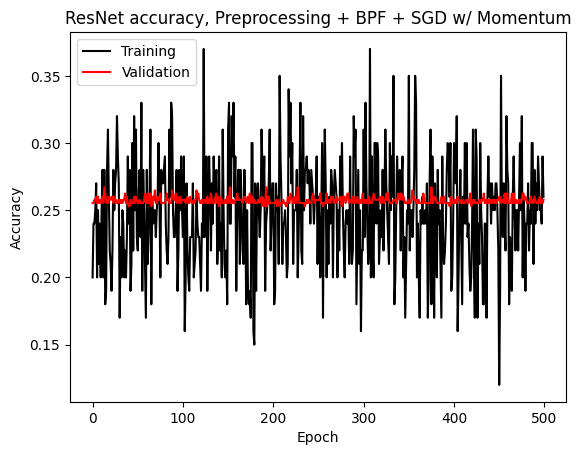

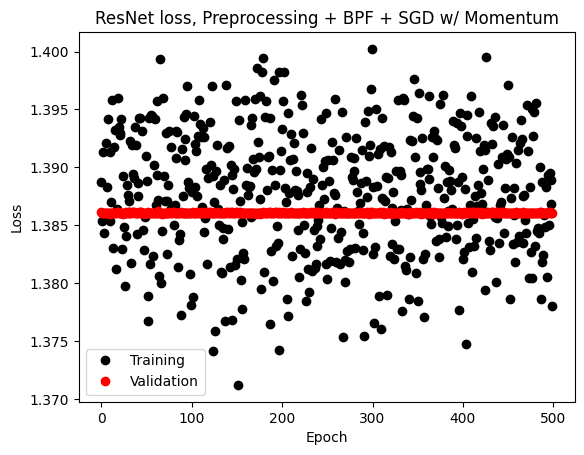

In [ ]:
#Update arrays and titles
plt.plot(np.arange(num_epochs),train_history_6,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_6,label='Validation',color='r')
plt.title('ResNet accuracy, Preprocessing + BPF + SGD w/ Momentum')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_6,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_6,'o',label='Validation',color='r')
plt.title('ResNet loss, Preprocessing + BPF + SGD w/ Momentum')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Part 6b: Adagrad + Preprocessing + BPF

In [ ]:
#Build the model
model7 = ResNet(img_channels=1, block=BasicBlock, num_classes=4, time_dim=int(x_train.size(3)), dropout=0.6).to(device)
print(model7)
total_params = sum(p.numel() for p in model7.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model7.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

ResNet(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1): Con

In [ ]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model7.parameters(), lr=0.001, weight_decay=1e-4)
#optimizer = torch.optim.Adam(model6.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Rename these lines between models
train_history_7, val_history_7 = np.array([]), np.array([])
train_loss_hist_7, val_loss_hist_7 = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    save_folder = '/content/drive/MyDrive/C147_Final_Project/best_model_params_CNN'

    # Rename these lines between models
    best_model_params_path = os.path.join(save_folder, 'best_model7_params.pt')
    torch.save(model7.state_dict(), best_model_params_path)

    best_acc = 0.0
    bsz = 100
    num_epochs = 500
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        # Rename
        model7.train()

        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            #Rename
            logits = model7(train_x) #bszx4x1x4

            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()
            scheduler.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())


        train_acc = train_correct_count / train_count

        #Rename
        model7.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            #Rename
            logits = model7(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        #Rename
        train_history_7 = np.append(train_history_7, train_acc.item())
        val_history_7 = np.append(val_history_7, val_acc.item())
        train_loss_hist_7 = np.append(train_loss_hist_7, loss.item())
        val_loss_hist_7 = np.append(val_loss_hist_7, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            #Rename
            torch.save(model7.state_dict(), best_model_params_path)

    print(f'Best val Acc: {best_acc:4f}')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-23-eb6f317a7eb2>:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  0%|          | 1/500 [00:03<25:35,  3.08s/it]

Epoch 1 Finished!!!
Train acc: 0.350, Val acc: 0.288
Train loss: 1.368, Val loss: 1.378


  0%|          | 2/500 [00:06<25:23,  3.06s/it]

Epoch 2 Finished!!!
Train acc: 0.360, Val acc: 0.338
Train loss: 1.347, Val loss: 1.355


  1%|          | 3/500 [00:09<25:40,  3.10s/it]

Epoch 3 Finished!!!
Train acc: 0.410, Val acc: 0.314
Train loss: 1.293, Val loss: 1.355


  1%|          | 4/500 [00:12<25:48,  3.12s/it]

Epoch 4 Finished!!!
Train acc: 0.490, Val acc: 0.336
Train loss: 1.246, Val loss: 1.346


  1%|          | 5/500 [00:15<25:38,  3.11s/it]

Epoch 5 Finished!!!
Train acc: 0.440, Val acc: 0.331
Train loss: 1.279, Val loss: 1.337


  1%|          | 6/500 [00:18<25:36,  3.11s/it]

Epoch 6 Finished!!!
Train acc: 0.460, Val acc: 0.357
Train loss: 1.278, Val loss: 1.327


  1%|▏         | 7/500 [00:22<26:57,  3.28s/it]

Epoch 7 Finished!!!
Train acc: 0.480, Val acc: 0.388
Train loss: 1.251, Val loss: 1.313


  2%|▏         | 8/500 [00:25<26:48,  3.27s/it]

Epoch 8 Finished!!!
Train acc: 0.490, Val acc: 0.364
Train loss: 1.247, Val loss: 1.309


  2%|▏         | 9/500 [00:28<26:28,  3.24s/it]

Epoch 9 Finished!!!
Train acc: 0.450, Val acc: 0.388
Train loss: 1.259, Val loss: 1.306


  2%|▏         | 10/500 [00:31<26:07,  3.20s/it]

Epoch 10 Finished!!!
Train acc: 0.500, Val acc: 0.402
Train loss: 1.251, Val loss: 1.302


  2%|▏         | 11/500 [00:34<25:56,  3.18s/it]

Epoch 11 Finished!!!
Train acc: 0.480, Val acc: 0.409
Train loss: 1.244, Val loss: 1.293


  2%|▏         | 12/500 [00:38<25:39,  3.15s/it]

Epoch 12 Finished!!!
Train acc: 0.480, Val acc: 0.411
Train loss: 1.235, Val loss: 1.294


  3%|▎         | 13/500 [00:41<25:14,  3.11s/it]

Epoch 13 Finished!!!
Train acc: 0.460, Val acc: 0.409
Train loss: 1.268, Val loss: 1.290


  3%|▎         | 14/500 [00:44<24:56,  3.08s/it]

Epoch 14 Finished!!!
Train acc: 0.480, Val acc: 0.407
Train loss: 1.226, Val loss: 1.289


  3%|▎         | 15/500 [00:47<25:06,  3.11s/it]

Epoch 15 Finished!!!
Train acc: 0.480, Val acc: 0.409
Train loss: 1.254, Val loss: 1.288


  3%|▎         | 16/500 [00:50<25:07,  3.11s/it]

Epoch 16 Finished!!!
Train acc: 0.430, Val acc: 0.411
Train loss: 1.258, Val loss: 1.292


  3%|▎         | 17/500 [00:53<24:59,  3.10s/it]

Epoch 17 Finished!!!
Train acc: 0.440, Val acc: 0.416
Train loss: 1.267, Val loss: 1.287


  4%|▎         | 18/500 [00:56<25:00,  3.11s/it]

Epoch 18 Finished!!!
Train acc: 0.500, Val acc: 0.423
Train loss: 1.206, Val loss: 1.287


  4%|▍         | 19/500 [00:59<24:51,  3.10s/it]

Epoch 19 Finished!!!
Train acc: 0.470, Val acc: 0.418
Train loss: 1.234, Val loss: 1.283


  4%|▍         | 20/500 [01:03<25:42,  3.21s/it]

Epoch 20 Finished!!!
Train acc: 0.450, Val acc: 0.418
Train loss: 1.257, Val loss: 1.283


  4%|▍         | 21/500 [01:06<25:32,  3.20s/it]

Epoch 21 Finished!!!
Train acc: 0.500, Val acc: 0.409
Train loss: 1.217, Val loss: 1.285


  4%|▍         | 22/500 [01:09<25:09,  3.16s/it]

Epoch 22 Finished!!!
Train acc: 0.500, Val acc: 0.428
Train loss: 1.225, Val loss: 1.283


  5%|▍         | 23/500 [01:12<24:53,  3.13s/it]

Epoch 23 Finished!!!
Train acc: 0.490, Val acc: 0.418
Train loss: 1.231, Val loss: 1.286


  5%|▍         | 24/500 [01:15<24:40,  3.11s/it]

Epoch 24 Finished!!!
Train acc: 0.470, Val acc: 0.428
Train loss: 1.246, Val loss: 1.282


  5%|▌         | 25/500 [01:18<24:27,  3.09s/it]

Epoch 25 Finished!!!
Train acc: 0.520, Val acc: 0.416
Train loss: 1.198, Val loss: 1.280


  5%|▌         | 26/500 [01:21<24:20,  3.08s/it]

Epoch 26 Finished!!!
Train acc: 0.480, Val acc: 0.435
Train loss: 1.240, Val loss: 1.277


  5%|▌         | 27/500 [01:24<24:12,  3.07s/it]

Epoch 27 Finished!!!
Train acc: 0.510, Val acc: 0.447
Train loss: 1.217, Val loss: 1.274


  6%|▌         | 28/500 [01:27<23:59,  3.05s/it]

Epoch 28 Finished!!!
Train acc: 0.490, Val acc: 0.435
Train loss: 1.252, Val loss: 1.279


  6%|▌         | 29/500 [01:30<24:09,  3.08s/it]

Epoch 29 Finished!!!
Train acc: 0.540, Val acc: 0.426
Train loss: 1.203, Val loss: 1.276


  6%|▌         | 30/500 [01:33<23:57,  3.06s/it]

Epoch 30 Finished!!!
Train acc: 0.500, Val acc: 0.430
Train loss: 1.230, Val loss: 1.280


  6%|▌         | 31/500 [01:36<23:47,  3.04s/it]

Epoch 31 Finished!!!
Train acc: 0.430, Val acc: 0.428
Train loss: 1.305, Val loss: 1.280


  6%|▋         | 32/500 [01:39<23:38,  3.03s/it]

Epoch 32 Finished!!!
Train acc: 0.450, Val acc: 0.430
Train loss: 1.252, Val loss: 1.281


  7%|▋         | 33/500 [01:42<23:32,  3.02s/it]

Epoch 33 Finished!!!
Train acc: 0.520, Val acc: 0.435
Train loss: 1.216, Val loss: 1.277


  7%|▋         | 34/500 [01:45<23:27,  3.02s/it]

Epoch 34 Finished!!!
Train acc: 0.500, Val acc: 0.444
Train loss: 1.240, Val loss: 1.274


  7%|▋         | 35/500 [01:48<23:26,  3.02s/it]

Epoch 35 Finished!!!
Train acc: 0.570, Val acc: 0.449
Train loss: 1.174, Val loss: 1.276


  7%|▋         | 36/500 [01:51<23:21,  3.02s/it]

Epoch 36 Finished!!!
Train acc: 0.510, Val acc: 0.449
Train loss: 1.201, Val loss: 1.276


  7%|▋         | 37/500 [01:54<23:18,  3.02s/it]

Epoch 37 Finished!!!
Train acc: 0.560, Val acc: 0.435
Train loss: 1.166, Val loss: 1.278


  8%|▊         | 38/500 [01:57<23:15,  3.02s/it]

Epoch 38 Finished!!!
Train acc: 0.550, Val acc: 0.440
Train loss: 1.189, Val loss: 1.276


  8%|▊         | 39/500 [02:00<23:10,  3.02s/it]

Epoch 39 Finished!!!
Train acc: 0.510, Val acc: 0.440
Train loss: 1.221, Val loss: 1.273


  8%|▊         | 40/500 [02:03<23:07,  3.02s/it]

Epoch 40 Finished!!!
Train acc: 0.530, Val acc: 0.447
Train loss: 1.204, Val loss: 1.272


  8%|▊         | 41/500 [02:07<23:17,  3.04s/it]

Epoch 41 Finished!!!
Train acc: 0.510, Val acc: 0.454
Train loss: 1.204, Val loss: 1.273


  8%|▊         | 42/500 [02:10<23:48,  3.12s/it]

Epoch 42 Finished!!!
Train acc: 0.500, Val acc: 0.442
Train loss: 1.219, Val loss: 1.272


  9%|▊         | 43/500 [02:13<23:33,  3.09s/it]

Epoch 43 Finished!!!
Train acc: 0.540, Val acc: 0.461
Train loss: 1.200, Val loss: 1.270


  9%|▉         | 44/500 [02:16<23:17,  3.07s/it]

Epoch 44 Finished!!!
Train acc: 0.530, Val acc: 0.456
Train loss: 1.185, Val loss: 1.276


  9%|▉         | 45/500 [02:19<23:12,  3.06s/it]

Epoch 45 Finished!!!
Train acc: 0.490, Val acc: 0.440
Train loss: 1.235, Val loss: 1.281


  9%|▉         | 46/500 [02:22<23:02,  3.05s/it]

Epoch 46 Finished!!!
Train acc: 0.560, Val acc: 0.447
Train loss: 1.202, Val loss: 1.274


  9%|▉         | 47/500 [02:25<22:57,  3.04s/it]

Epoch 47 Finished!!!
Train acc: 0.540, Val acc: 0.466
Train loss: 1.199, Val loss: 1.272


 10%|▉         | 48/500 [02:28<22:48,  3.03s/it]

Epoch 48 Finished!!!
Train acc: 0.570, Val acc: 0.442
Train loss: 1.199, Val loss: 1.274


 10%|▉         | 49/500 [02:31<22:41,  3.02s/it]

Epoch 49 Finished!!!
Train acc: 0.500, Val acc: 0.454
Train loss: 1.210, Val loss: 1.271


 10%|█         | 50/500 [02:34<22:35,  3.01s/it]

Epoch 50 Finished!!!
Train acc: 0.500, Val acc: 0.437
Train loss: 1.249, Val loss: 1.272


 10%|█         | 51/500 [02:37<22:30,  3.01s/it]

Epoch 51 Finished!!!
Train acc: 0.590, Val acc: 0.456
Train loss: 1.166, Val loss: 1.273


 10%|█         | 52/500 [02:40<22:25,  3.00s/it]

Epoch 52 Finished!!!
Train acc: 0.570, Val acc: 0.449
Train loss: 1.168, Val loss: 1.274


 11%|█         | 53/500 [02:43<22:20,  3.00s/it]

Epoch 53 Finished!!!
Train acc: 0.610, Val acc: 0.449
Train loss: 1.147, Val loss: 1.272


 11%|█         | 54/500 [02:46<22:17,  3.00s/it]

Epoch 54 Finished!!!
Train acc: 0.630, Val acc: 0.454
Train loss: 1.150, Val loss: 1.274


 11%|█         | 55/500 [02:49<22:13,  3.00s/it]

Epoch 55 Finished!!!
Train acc: 0.500, Val acc: 0.459
Train loss: 1.222, Val loss: 1.268


 11%|█         | 56/500 [02:52<22:09,  3.00s/it]

Epoch 56 Finished!!!
Train acc: 0.520, Val acc: 0.463
Train loss: 1.216, Val loss: 1.268


 11%|█▏        | 57/500 [02:55<22:07,  3.00s/it]

Epoch 57 Finished!!!
Train acc: 0.540, Val acc: 0.447
Train loss: 1.194, Val loss: 1.266


 12%|█▏        | 58/500 [02:58<22:04,  3.00s/it]

Epoch 58 Finished!!!
Train acc: 0.590, Val acc: 0.442
Train loss: 1.157, Val loss: 1.271


 12%|█▏        | 59/500 [03:01<22:02,  3.00s/it]

Epoch 59 Finished!!!
Train acc: 0.510, Val acc: 0.449
Train loss: 1.224, Val loss: 1.269


 12%|█▏        | 60/500 [03:04<21:59,  3.00s/it]

Epoch 60 Finished!!!
Train acc: 0.520, Val acc: 0.456
Train loss: 1.229, Val loss: 1.272


 12%|█▏        | 61/500 [03:07<21:57,  3.00s/it]

Epoch 61 Finished!!!
Train acc: 0.530, Val acc: 0.463
Train loss: 1.212, Val loss: 1.268


 12%|█▏        | 62/500 [03:10<21:54,  3.00s/it]

Epoch 62 Finished!!!
Train acc: 0.560, Val acc: 0.456
Train loss: 1.192, Val loss: 1.268


 13%|█▎        | 63/500 [03:13<21:54,  3.01s/it]

Epoch 63 Finished!!!
Train acc: 0.550, Val acc: 0.468
Train loss: 1.195, Val loss: 1.266


 13%|█▎        | 64/500 [03:16<21:51,  3.01s/it]

Epoch 64 Finished!!!
Train acc: 0.580, Val acc: 0.454
Train loss: 1.158, Val loss: 1.269


 13%|█▎        | 65/500 [03:19<21:47,  3.01s/it]

Epoch 65 Finished!!!
Train acc: 0.530, Val acc: 0.456
Train loss: 1.190, Val loss: 1.271


 13%|█▎        | 66/500 [03:22<21:44,  3.01s/it]

Epoch 66 Finished!!!
Train acc: 0.440, Val acc: 0.454
Train loss: 1.258, Val loss: 1.271


 13%|█▎        | 67/500 [03:25<21:42,  3.01s/it]

Epoch 67 Finished!!!
Train acc: 0.610, Val acc: 0.468
Train loss: 1.151, Val loss: 1.268


 14%|█▎        | 68/500 [03:28<21:42,  3.01s/it]

Epoch 68 Finished!!!
Train acc: 0.520, Val acc: 0.473
Train loss: 1.220, Val loss: 1.268


 14%|█▍        | 69/500 [03:31<21:38,  3.01s/it]

Epoch 69 Finished!!!
Train acc: 0.590, Val acc: 0.456
Train loss: 1.135, Val loss: 1.268


 14%|█▍        | 70/500 [03:34<21:34,  3.01s/it]

Epoch 70 Finished!!!
Train acc: 0.450, Val acc: 0.463
Train loss: 1.275, Val loss: 1.268


 14%|█▍        | 71/500 [03:37<21:31,  3.01s/it]

Epoch 71 Finished!!!
Train acc: 0.510, Val acc: 0.468
Train loss: 1.216, Val loss: 1.268


 14%|█▍        | 72/500 [03:40<21:27,  3.01s/it]

Epoch 72 Finished!!!
Train acc: 0.480, Val acc: 0.456
Train loss: 1.266, Val loss: 1.268


 15%|█▍        | 73/500 [03:43<21:23,  3.01s/it]

Epoch 73 Finished!!!
Train acc: 0.490, Val acc: 0.454
Train loss: 1.211, Val loss: 1.272


 15%|█▍        | 74/500 [03:46<21:20,  3.00s/it]

Epoch 74 Finished!!!
Train acc: 0.550, Val acc: 0.454
Train loss: 1.190, Val loss: 1.265


 15%|█▌        | 75/500 [03:49<21:17,  3.01s/it]

Epoch 75 Finished!!!
Train acc: 0.580, Val acc: 0.461
Train loss: 1.190, Val loss: 1.264


 15%|█▌        | 76/500 [03:52<21:14,  3.01s/it]

Epoch 76 Finished!!!
Train acc: 0.460, Val acc: 0.463
Train loss: 1.251, Val loss: 1.261


 15%|█▌        | 77/500 [03:55<21:20,  3.03s/it]

Epoch 77 Finished!!!
Train acc: 0.530, Val acc: 0.466
Train loss: 1.172, Val loss: 1.263


 16%|█▌        | 78/500 [03:58<21:14,  3.02s/it]

Epoch 78 Finished!!!
Train acc: 0.470, Val acc: 0.468
Train loss: 1.215, Val loss: 1.263


 16%|█▌        | 79/500 [04:01<21:09,  3.01s/it]

Epoch 79 Finished!!!
Train acc: 0.460, Val acc: 0.463
Train loss: 1.283, Val loss: 1.264


 16%|█▌        | 80/500 [04:04<21:33,  3.08s/it]

Epoch 80 Finished!!!
Train acc: 0.540, Val acc: 0.444
Train loss: 1.191, Val loss: 1.264


 16%|█▌        | 81/500 [04:07<21:20,  3.06s/it]

Epoch 81 Finished!!!
Train acc: 0.470, Val acc: 0.452
Train loss: 1.261, Val loss: 1.267


 16%|█▋        | 82/500 [04:10<21:10,  3.04s/it]

Epoch 82 Finished!!!
Train acc: 0.540, Val acc: 0.454
Train loss: 1.204, Val loss: 1.269


 17%|█▋        | 83/500 [04:13<21:02,  3.03s/it]

Epoch 83 Finished!!!
Train acc: 0.500, Val acc: 0.456
Train loss: 1.205, Val loss: 1.266


 17%|█▋        | 84/500 [04:16<20:57,  3.02s/it]

Epoch 84 Finished!!!
Train acc: 0.520, Val acc: 0.456
Train loss: 1.199, Val loss: 1.264


 17%|█▋        | 85/500 [04:19<20:51,  3.02s/it]

Epoch 85 Finished!!!
Train acc: 0.560, Val acc: 0.456
Train loss: 1.200, Val loss: 1.265


 17%|█▋        | 86/500 [04:22<20:46,  3.01s/it]

Epoch 86 Finished!!!
Train acc: 0.530, Val acc: 0.461
Train loss: 1.213, Val loss: 1.271


 17%|█▋        | 87/500 [04:25<20:41,  3.01s/it]

Epoch 87 Finished!!!
Train acc: 0.650, Val acc: 0.459
Train loss: 1.104, Val loss: 1.263


 18%|█▊        | 88/500 [04:28<20:37,  3.00s/it]

Epoch 88 Finished!!!
Train acc: 0.710, Val acc: 0.463
Train loss: 1.092, Val loss: 1.263


 18%|█▊        | 89/500 [04:31<20:34,  3.00s/it]

Epoch 89 Finished!!!
Train acc: 0.590, Val acc: 0.454
Train loss: 1.148, Val loss: 1.262


 18%|█▊        | 90/500 [04:34<20:30,  3.00s/it]

Epoch 90 Finished!!!
Train acc: 0.510, Val acc: 0.454
Train loss: 1.192, Val loss: 1.263


 18%|█▊        | 91/500 [04:37<20:27,  3.00s/it]

Epoch 91 Finished!!!
Train acc: 0.510, Val acc: 0.468
Train loss: 1.238, Val loss: 1.264


 18%|█▊        | 92/500 [04:40<20:24,  3.00s/it]

Epoch 92 Finished!!!
Train acc: 0.570, Val acc: 0.459
Train loss: 1.171, Val loss: 1.263


 19%|█▊        | 93/500 [04:43<20:21,  3.00s/it]

Epoch 93 Finished!!!
Train acc: 0.540, Val acc: 0.461
Train loss: 1.183, Val loss: 1.266


 19%|█▉        | 94/500 [04:46<20:18,  3.00s/it]

Epoch 94 Finished!!!
Train acc: 0.450, Val acc: 0.456
Train loss: 1.278, Val loss: 1.268


 19%|█▉        | 95/500 [04:49<20:15,  3.00s/it]

Epoch 95 Finished!!!
Train acc: 0.580, Val acc: 0.470
Train loss: 1.167, Val loss: 1.261


 19%|█▉        | 96/500 [04:52<20:12,  3.00s/it]

Epoch 96 Finished!!!
Train acc: 0.470, Val acc: 0.466
Train loss: 1.262, Val loss: 1.263


 19%|█▉        | 97/500 [04:55<20:10,  3.00s/it]

Epoch 97 Finished!!!
Train acc: 0.540, Val acc: 0.452
Train loss: 1.196, Val loss: 1.264


 20%|█▉        | 98/500 [04:58<20:06,  3.00s/it]

Epoch 98 Finished!!!
Train acc: 0.540, Val acc: 0.459
Train loss: 1.186, Val loss: 1.263


 20%|█▉        | 99/500 [05:01<20:02,  3.00s/it]

Epoch 99 Finished!!!
Train acc: 0.510, Val acc: 0.456
Train loss: 1.198, Val loss: 1.260


 20%|██        | 100/500 [05:04<19:58,  3.00s/it]

Epoch 100 Finished!!!
Train acc: 0.600, Val acc: 0.468
Train loss: 1.164, Val loss: 1.260


 20%|██        | 101/500 [05:07<19:56,  3.00s/it]

Epoch 101 Finished!!!
Train acc: 0.540, Val acc: 0.473
Train loss: 1.209, Val loss: 1.261


 20%|██        | 102/500 [05:10<19:53,  3.00s/it]

Epoch 102 Finished!!!
Train acc: 0.570, Val acc: 0.470
Train loss: 1.187, Val loss: 1.260


 21%|██        | 103/500 [05:13<19:49,  3.00s/it]

Epoch 103 Finished!!!
Train acc: 0.540, Val acc: 0.456
Train loss: 1.206, Val loss: 1.268


 21%|██        | 104/500 [05:16<19:46,  3.00s/it]

Epoch 104 Finished!!!
Train acc: 0.640, Val acc: 0.466
Train loss: 1.116, Val loss: 1.263


 21%|██        | 105/500 [05:19<19:46,  3.01s/it]

Epoch 105 Finished!!!
Train acc: 0.560, Val acc: 0.475
Train loss: 1.215, Val loss: 1.262


 21%|██        | 106/500 [05:22<19:43,  3.00s/it]

Epoch 106 Finished!!!
Train acc: 0.560, Val acc: 0.466
Train loss: 1.201, Val loss: 1.264


 21%|██▏       | 107/500 [05:25<19:39,  3.00s/it]

Epoch 107 Finished!!!
Train acc: 0.540, Val acc: 0.459
Train loss: 1.180, Val loss: 1.266


 22%|██▏       | 108/500 [05:28<19:35,  3.00s/it]

Epoch 108 Finished!!!
Train acc: 0.530, Val acc: 0.459
Train loss: 1.193, Val loss: 1.266


 22%|██▏       | 109/500 [05:31<19:32,  3.00s/it]

Epoch 109 Finished!!!
Train acc: 0.610, Val acc: 0.461
Train loss: 1.151, Val loss: 1.262


 22%|██▏       | 110/500 [05:34<19:29,  3.00s/it]

Epoch 110 Finished!!!
Train acc: 0.560, Val acc: 0.459
Train loss: 1.212, Val loss: 1.263


 22%|██▏       | 111/500 [05:37<19:25,  3.00s/it]

Epoch 111 Finished!!!
Train acc: 0.620, Val acc: 0.459
Train loss: 1.126, Val loss: 1.262


 22%|██▏       | 112/500 [05:40<19:27,  3.01s/it]

Epoch 112 Finished!!!
Train acc: 0.570, Val acc: 0.463
Train loss: 1.142, Val loss: 1.260


 23%|██▎       | 113/500 [05:43<19:22,  3.01s/it]

Epoch 113 Finished!!!
Train acc: 0.530, Val acc: 0.461
Train loss: 1.221, Val loss: 1.262


 23%|██▎       | 114/500 [05:46<19:19,  3.00s/it]

Epoch 114 Finished!!!
Train acc: 0.410, Val acc: 0.466
Train loss: 1.287, Val loss: 1.261


 23%|██▎       | 115/500 [05:49<19:20,  3.01s/it]

Epoch 115 Finished!!!
Train acc: 0.530, Val acc: 0.459
Train loss: 1.216, Val loss: 1.262


 23%|██▎       | 116/500 [05:52<19:15,  3.01s/it]

Epoch 116 Finished!!!
Train acc: 0.550, Val acc: 0.459
Train loss: 1.182, Val loss: 1.264


 23%|██▎       | 117/500 [05:55<19:10,  3.00s/it]

Epoch 117 Finished!!!
Train acc: 0.540, Val acc: 0.461
Train loss: 1.205, Val loss: 1.263


 24%|██▎       | 118/500 [05:58<19:07,  3.00s/it]

Epoch 118 Finished!!!
Train acc: 0.560, Val acc: 0.470
Train loss: 1.172, Val loss: 1.259


 24%|██▍       | 119/500 [06:01<19:03,  3.00s/it]

Epoch 119 Finished!!!
Train acc: 0.540, Val acc: 0.463
Train loss: 1.191, Val loss: 1.259


 24%|██▍       | 120/500 [06:04<19:00,  3.00s/it]

Epoch 120 Finished!!!
Train acc: 0.580, Val acc: 0.468
Train loss: 1.159, Val loss: 1.260


 24%|██▍       | 121/500 [06:07<18:56,  3.00s/it]

Epoch 121 Finished!!!
Train acc: 0.610, Val acc: 0.466
Train loss: 1.154, Val loss: 1.260


 24%|██▍       | 122/500 [06:10<18:54,  3.00s/it]

Epoch 122 Finished!!!
Train acc: 0.550, Val acc: 0.463
Train loss: 1.176, Val loss: 1.261


 25%|██▍       | 123/500 [06:13<18:50,  3.00s/it]

Epoch 123 Finished!!!
Train acc: 0.470, Val acc: 0.461
Train loss: 1.258, Val loss: 1.257


 25%|██▍       | 124/500 [06:16<18:47,  3.00s/it]

Epoch 124 Finished!!!
Train acc: 0.600, Val acc: 0.461
Train loss: 1.164, Val loss: 1.259


 25%|██▌       | 125/500 [06:19<18:44,  3.00s/it]

Epoch 125 Finished!!!
Train acc: 0.590, Val acc: 0.463
Train loss: 1.160, Val loss: 1.256


 25%|██▌       | 126/500 [06:22<18:41,  3.00s/it]

Epoch 126 Finished!!!
Train acc: 0.480, Val acc: 0.468
Train loss: 1.227, Val loss: 1.256


 25%|██▌       | 127/500 [06:25<18:38,  3.00s/it]

Epoch 127 Finished!!!
Train acc: 0.580, Val acc: 0.463
Train loss: 1.191, Val loss: 1.257


 26%|██▌       | 128/500 [06:28<18:35,  3.00s/it]

Epoch 128 Finished!!!
Train acc: 0.570, Val acc: 0.468
Train loss: 1.161, Val loss: 1.259


 26%|██▌       | 129/500 [06:31<18:32,  3.00s/it]

Epoch 129 Finished!!!
Train acc: 0.610, Val acc: 0.459
Train loss: 1.126, Val loss: 1.258


 26%|██▌       | 130/500 [06:34<18:29,  3.00s/it]

Epoch 130 Finished!!!
Train acc: 0.570, Val acc: 0.461
Train loss: 1.170, Val loss: 1.258


 26%|██▌       | 131/500 [06:37<18:26,  3.00s/it]

Epoch 131 Finished!!!
Train acc: 0.510, Val acc: 0.473
Train loss: 1.219, Val loss: 1.260


 26%|██▋       | 132/500 [06:40<18:23,  3.00s/it]

Epoch 132 Finished!!!
Train acc: 0.480, Val acc: 0.468
Train loss: 1.237, Val loss: 1.258


 27%|██▋       | 133/500 [06:43<18:20,  3.00s/it]

Epoch 133 Finished!!!
Train acc: 0.590, Val acc: 0.466
Train loss: 1.147, Val loss: 1.257


 27%|██▋       | 134/500 [06:46<18:18,  3.00s/it]

Epoch 134 Finished!!!
Train acc: 0.620, Val acc: 0.468
Train loss: 1.146, Val loss: 1.257


 27%|██▋       | 135/500 [06:49<18:15,  3.00s/it]

Epoch 135 Finished!!!
Train acc: 0.510, Val acc: 0.463
Train loss: 1.203, Val loss: 1.256


 27%|██▋       | 136/500 [06:52<18:12,  3.00s/it]

Epoch 136 Finished!!!
Train acc: 0.530, Val acc: 0.470
Train loss: 1.244, Val loss: 1.260


 27%|██▋       | 137/500 [06:55<18:09,  3.00s/it]

Epoch 137 Finished!!!
Train acc: 0.550, Val acc: 0.463
Train loss: 1.199, Val loss: 1.258


 28%|██▊       | 138/500 [06:58<18:05,  3.00s/it]

Epoch 138 Finished!!!
Train acc: 0.520, Val acc: 0.466
Train loss: 1.209, Val loss: 1.257


 28%|██▊       | 139/500 [07:01<18:03,  3.00s/it]

Epoch 139 Finished!!!
Train acc: 0.560, Val acc: 0.461
Train loss: 1.176, Val loss: 1.258


 28%|██▊       | 140/500 [07:04<17:59,  3.00s/it]

Epoch 140 Finished!!!
Train acc: 0.550, Val acc: 0.463
Train loss: 1.177, Val loss: 1.257


 28%|██▊       | 141/500 [07:07<17:58,  3.01s/it]

Epoch 141 Finished!!!
Train acc: 0.620, Val acc: 0.478
Train loss: 1.133, Val loss: 1.256


 28%|██▊       | 142/500 [07:10<17:54,  3.00s/it]

Epoch 142 Finished!!!
Train acc: 0.460, Val acc: 0.470
Train loss: 1.257, Val loss: 1.257


 29%|██▊       | 143/500 [07:13<17:51,  3.00s/it]

Epoch 143 Finished!!!
Train acc: 0.630, Val acc: 0.466
Train loss: 1.112, Val loss: 1.255


 29%|██▉       | 144/500 [07:16<17:48,  3.00s/it]

Epoch 144 Finished!!!
Train acc: 0.520, Val acc: 0.468
Train loss: 1.198, Val loss: 1.255


 29%|██▉       | 145/500 [07:19<17:44,  3.00s/it]

Epoch 145 Finished!!!
Train acc: 0.530, Val acc: 0.468
Train loss: 1.193, Val loss: 1.255


 29%|██▉       | 146/500 [07:22<17:41,  3.00s/it]

Epoch 146 Finished!!!
Train acc: 0.490, Val acc: 0.468
Train loss: 1.232, Val loss: 1.255


 29%|██▉       | 147/500 [07:25<17:38,  3.00s/it]

Epoch 147 Finished!!!
Train acc: 0.500, Val acc: 0.473
Train loss: 1.224, Val loss: 1.254


 30%|██▉       | 148/500 [07:28<17:36,  3.00s/it]

Epoch 148 Finished!!!
Train acc: 0.490, Val acc: 0.466
Train loss: 1.234, Val loss: 1.255


 30%|██▉       | 149/500 [07:31<17:32,  3.00s/it]

Epoch 149 Finished!!!
Train acc: 0.610, Val acc: 0.470
Train loss: 1.154, Val loss: 1.254


 30%|███       | 150/500 [07:34<17:29,  3.00s/it]

Epoch 150 Finished!!!
Train acc: 0.570, Val acc: 0.473
Train loss: 1.188, Val loss: 1.253


 30%|███       | 151/500 [07:37<17:26,  3.00s/it]

Epoch 151 Finished!!!
Train acc: 0.580, Val acc: 0.463
Train loss: 1.161, Val loss: 1.259


 30%|███       | 152/500 [07:40<17:24,  3.00s/it]

Epoch 152 Finished!!!
Train acc: 0.570, Val acc: 0.473
Train loss: 1.184, Val loss: 1.255


 31%|███       | 153/500 [07:43<17:20,  3.00s/it]

Epoch 153 Finished!!!
Train acc: 0.660, Val acc: 0.468
Train loss: 1.116, Val loss: 1.254


 31%|███       | 154/500 [07:46<17:17,  3.00s/it]

Epoch 154 Finished!!!
Train acc: 0.550, Val acc: 0.468
Train loss: 1.178, Val loss: 1.254


 31%|███       | 155/500 [07:49<17:14,  3.00s/it]

Epoch 155 Finished!!!
Train acc: 0.560, Val acc: 0.473
Train loss: 1.193, Val loss: 1.253


 31%|███       | 156/500 [07:52<17:12,  3.00s/it]

Epoch 156 Finished!!!
Train acc: 0.570, Val acc: 0.470
Train loss: 1.174, Val loss: 1.253


 31%|███▏      | 157/500 [07:55<17:09,  3.00s/it]

Epoch 157 Finished!!!
Train acc: 0.640, Val acc: 0.459
Train loss: 1.121, Val loss: 1.255


 32%|███▏      | 158/500 [07:58<17:05,  3.00s/it]

Epoch 158 Finished!!!
Train acc: 0.490, Val acc: 0.468
Train loss: 1.250, Val loss: 1.253


 32%|███▏      | 159/500 [08:01<17:02,  3.00s/it]

Epoch 159 Finished!!!
Train acc: 0.540, Val acc: 0.468
Train loss: 1.188, Val loss: 1.254


 32%|███▏      | 160/500 [08:04<17:01,  3.01s/it]

Epoch 160 Finished!!!
Train acc: 0.530, Val acc: 0.475
Train loss: 1.208, Val loss: 1.252


 32%|███▏      | 161/500 [08:07<16:59,  3.01s/it]

Epoch 161 Finished!!!
Train acc: 0.520, Val acc: 0.473
Train loss: 1.212, Val loss: 1.254


 32%|███▏      | 162/500 [08:10<16:57,  3.01s/it]

Epoch 162 Finished!!!
Train acc: 0.530, Val acc: 0.480
Train loss: 1.212, Val loss: 1.251


 33%|███▎      | 163/500 [08:13<16:52,  3.00s/it]

Epoch 163 Finished!!!
Train acc: 0.550, Val acc: 0.466
Train loss: 1.183, Val loss: 1.253


 33%|███▎      | 164/500 [08:16<16:48,  3.00s/it]

Epoch 164 Finished!!!
Train acc: 0.640, Val acc: 0.463
Train loss: 1.106, Val loss: 1.254


 33%|███▎      | 165/500 [08:19<16:45,  3.00s/it]

Epoch 165 Finished!!!
Train acc: 0.480, Val acc: 0.475
Train loss: 1.208, Val loss: 1.252


 33%|███▎      | 166/500 [08:22<16:42,  3.00s/it]

Epoch 166 Finished!!!
Train acc: 0.540, Val acc: 0.463
Train loss: 1.192, Val loss: 1.254


 33%|███▎      | 167/500 [08:25<16:39,  3.00s/it]

Epoch 167 Finished!!!
Train acc: 0.540, Val acc: 0.466
Train loss: 1.184, Val loss: 1.255


 34%|███▎      | 168/500 [08:28<16:36,  3.00s/it]

Epoch 168 Finished!!!
Train acc: 0.580, Val acc: 0.470
Train loss: 1.163, Val loss: 1.253


 34%|███▍      | 169/500 [08:31<16:33,  3.00s/it]

Epoch 169 Finished!!!
Train acc: 0.570, Val acc: 0.461
Train loss: 1.170, Val loss: 1.254


 34%|███▍      | 170/500 [08:34<16:30,  3.00s/it]

Epoch 170 Finished!!!
Train acc: 0.660, Val acc: 0.468
Train loss: 1.094, Val loss: 1.251


 34%|███▍      | 171/500 [08:37<16:26,  3.00s/it]

Epoch 171 Finished!!!
Train acc: 0.610, Val acc: 0.480
Train loss: 1.154, Val loss: 1.249


 34%|███▍      | 172/500 [08:40<16:23,  3.00s/it]

Epoch 172 Finished!!!
Train acc: 0.470, Val acc: 0.470
Train loss: 1.289, Val loss: 1.250


 35%|███▍      | 173/500 [08:43<16:20,  3.00s/it]

Epoch 173 Finished!!!
Train acc: 0.590, Val acc: 0.470
Train loss: 1.142, Val loss: 1.252


 35%|███▍      | 174/500 [08:46<16:18,  3.00s/it]

Epoch 174 Finished!!!
Train acc: 0.590, Val acc: 0.463
Train loss: 1.148, Val loss: 1.254


 35%|███▌      | 175/500 [08:49<16:14,  3.00s/it]

Epoch 175 Finished!!!
Train acc: 0.550, Val acc: 0.475
Train loss: 1.188, Val loss: 1.250


 35%|███▌      | 176/500 [08:52<16:11,  3.00s/it]

Epoch 176 Finished!!!
Train acc: 0.530, Val acc: 0.466
Train loss: 1.194, Val loss: 1.252


 35%|███▌      | 177/500 [08:55<16:08,  3.00s/it]

Epoch 177 Finished!!!
Train acc: 0.600, Val acc: 0.466
Train loss: 1.136, Val loss: 1.252


 36%|███▌      | 178/500 [08:58<16:06,  3.00s/it]

Epoch 178 Finished!!!
Train acc: 0.640, Val acc: 0.473
Train loss: 1.109, Val loss: 1.250


 36%|███▌      | 179/500 [09:01<16:02,  3.00s/it]

Epoch 179 Finished!!!
Train acc: 0.620, Val acc: 0.466
Train loss: 1.134, Val loss: 1.253


 36%|███▌      | 180/500 [09:04<15:59,  3.00s/it]

Epoch 180 Finished!!!
Train acc: 0.560, Val acc: 0.470
Train loss: 1.189, Val loss: 1.252


 36%|███▌      | 181/500 [09:07<15:57,  3.00s/it]

Epoch 181 Finished!!!
Train acc: 0.520, Val acc: 0.466
Train loss: 1.227, Val loss: 1.252


 36%|███▋      | 182/500 [09:10<15:54,  3.00s/it]

Epoch 182 Finished!!!
Train acc: 0.560, Val acc: 0.475
Train loss: 1.183, Val loss: 1.250


 37%|███▋      | 183/500 [09:13<15:51,  3.00s/it]

Epoch 183 Finished!!!
Train acc: 0.590, Val acc: 0.468
Train loss: 1.167, Val loss: 1.254


 37%|███▋      | 184/500 [09:16<15:48,  3.00s/it]

Epoch 184 Finished!!!
Train acc: 0.580, Val acc: 0.470
Train loss: 1.156, Val loss: 1.250


 37%|███▋      | 185/500 [09:19<15:45,  3.00s/it]

Epoch 185 Finished!!!
Train acc: 0.540, Val acc: 0.473
Train loss: 1.211, Val loss: 1.249


 37%|███▋      | 186/500 [09:22<15:42,  3.00s/it]

Epoch 186 Finished!!!
Train acc: 0.520, Val acc: 0.480
Train loss: 1.204, Val loss: 1.251


 37%|███▋      | 187/500 [09:25<15:39,  3.00s/it]

Epoch 187 Finished!!!
Train acc: 0.610, Val acc: 0.473
Train loss: 1.129, Val loss: 1.249


 38%|███▊      | 188/500 [09:28<15:36,  3.00s/it]

Epoch 188 Finished!!!
Train acc: 0.540, Val acc: 0.475
Train loss: 1.197, Val loss: 1.249


 38%|███▊      | 189/500 [09:31<15:33,  3.00s/it]

Epoch 189 Finished!!!
Train acc: 0.540, Val acc: 0.475
Train loss: 1.172, Val loss: 1.250


 38%|███▊      | 190/500 [09:34<15:30,  3.00s/it]

Epoch 190 Finished!!!
Train acc: 0.600, Val acc: 0.480
Train loss: 1.152, Val loss: 1.249


 38%|███▊      | 191/500 [09:37<15:28,  3.01s/it]

Epoch 191 Finished!!!
Train acc: 0.600, Val acc: 0.482
Train loss: 1.142, Val loss: 1.249


 38%|███▊      | 192/500 [09:40<15:25,  3.00s/it]

Epoch 192 Finished!!!
Train acc: 0.570, Val acc: 0.478
Train loss: 1.161, Val loss: 1.249


 39%|███▊      | 193/500 [09:43<15:21,  3.00s/it]

Epoch 193 Finished!!!
Train acc: 0.600, Val acc: 0.478
Train loss: 1.153, Val loss: 1.248


 39%|███▉      | 194/500 [09:46<15:18,  3.00s/it]

Epoch 194 Finished!!!
Train acc: 0.550, Val acc: 0.478
Train loss: 1.181, Val loss: 1.248


 39%|███▉      | 195/500 [09:49<15:15,  3.00s/it]

Epoch 195 Finished!!!
Train acc: 0.540, Val acc: 0.480
Train loss: 1.183, Val loss: 1.248


 39%|███▉      | 196/500 [09:52<15:13,  3.01s/it]

Epoch 196 Finished!!!
Train acc: 0.560, Val acc: 0.487
Train loss: 1.183, Val loss: 1.247


 39%|███▉      | 197/500 [09:55<15:09,  3.00s/it]

Epoch 197 Finished!!!
Train acc: 0.580, Val acc: 0.473
Train loss: 1.160, Val loss: 1.249


 40%|███▉      | 198/500 [09:58<15:06,  3.00s/it]

Epoch 198 Finished!!!
Train acc: 0.590, Val acc: 0.485
Train loss: 1.177, Val loss: 1.246


 40%|███▉      | 199/500 [10:01<15:03,  3.00s/it]

Epoch 199 Finished!!!
Train acc: 0.640, Val acc: 0.473
Train loss: 1.102, Val loss: 1.247


 40%|████      | 200/500 [10:04<15:00,  3.00s/it]

Epoch 200 Finished!!!
Train acc: 0.620, Val acc: 0.473
Train loss: 1.140, Val loss: 1.248


 40%|████      | 201/500 [10:07<14:57,  3.00s/it]

Epoch 201 Finished!!!
Train acc: 0.570, Val acc: 0.470
Train loss: 1.146, Val loss: 1.249


 40%|████      | 202/500 [10:10<14:54,  3.00s/it]

Epoch 202 Finished!!!
Train acc: 0.600, Val acc: 0.475
Train loss: 1.122, Val loss: 1.247


 41%|████      | 203/500 [10:13<14:51,  3.00s/it]

Epoch 203 Finished!!!
Train acc: 0.510, Val acc: 0.473
Train loss: 1.221, Val loss: 1.249


 41%|████      | 204/500 [10:16<14:48,  3.00s/it]

Epoch 204 Finished!!!
Train acc: 0.570, Val acc: 0.473
Train loss: 1.168, Val loss: 1.247


 41%|████      | 205/500 [10:19<14:45,  3.00s/it]

Epoch 205 Finished!!!
Train acc: 0.570, Val acc: 0.485
Train loss: 1.158, Val loss: 1.247


 41%|████      | 206/500 [10:22<14:42,  3.00s/it]

Epoch 206 Finished!!!
Train acc: 0.530, Val acc: 0.480
Train loss: 1.213, Val loss: 1.247


 41%|████▏     | 207/500 [10:25<14:39,  3.00s/it]

Epoch 207 Finished!!!
Train acc: 0.640, Val acc: 0.480
Train loss: 1.124, Val loss: 1.247


 42%|████▏     | 208/500 [10:28<14:36,  3.00s/it]

Epoch 208 Finished!!!
Train acc: 0.560, Val acc: 0.473
Train loss: 1.176, Val loss: 1.248


 42%|████▏     | 209/500 [10:31<14:32,  3.00s/it]

Epoch 209 Finished!!!
Train acc: 0.580, Val acc: 0.480
Train loss: 1.148, Val loss: 1.246


 42%|████▏     | 210/500 [10:34<14:29,  3.00s/it]

Epoch 210 Finished!!!
Train acc: 0.540, Val acc: 0.480
Train loss: 1.205, Val loss: 1.247


 42%|████▏     | 211/500 [10:37<14:26,  3.00s/it]

Epoch 211 Finished!!!
Train acc: 0.440, Val acc: 0.475
Train loss: 1.241, Val loss: 1.248


 42%|████▏     | 212/500 [10:40<14:23,  3.00s/it]

Epoch 212 Finished!!!
Train acc: 0.580, Val acc: 0.468
Train loss: 1.159, Val loss: 1.247


 43%|████▎     | 213/500 [10:43<14:20,  3.00s/it]

Epoch 213 Finished!!!
Train acc: 0.490, Val acc: 0.475
Train loss: 1.258, Val loss: 1.247


 43%|████▎     | 214/500 [10:46<14:17,  3.00s/it]

Epoch 214 Finished!!!
Train acc: 0.480, Val acc: 0.478
Train loss: 1.220, Val loss: 1.247


 43%|████▎     | 215/500 [10:49<14:14,  3.00s/it]

Epoch 215 Finished!!!
Train acc: 0.590, Val acc: 0.470
Train loss: 1.173, Val loss: 1.246


 43%|████▎     | 216/500 [10:52<14:11,  3.00s/it]

Epoch 216 Finished!!!
Train acc: 0.620, Val acc: 0.461
Train loss: 1.144, Val loss: 1.248


 43%|████▎     | 217/500 [10:55<14:09,  3.00s/it]

Epoch 217 Finished!!!
Train acc: 0.650, Val acc: 0.473
Train loss: 1.093, Val loss: 1.245


 44%|████▎     | 218/500 [10:58<14:06,  3.00s/it]

Epoch 218 Finished!!!
Train acc: 0.530, Val acc: 0.482
Train loss: 1.203, Val loss: 1.244


 44%|████▍     | 219/500 [11:01<14:03,  3.00s/it]

Epoch 219 Finished!!!
Train acc: 0.540, Val acc: 0.478
Train loss: 1.187, Val loss: 1.243


 44%|████▍     | 220/500 [11:04<14:00,  3.00s/it]

Epoch 220 Finished!!!
Train acc: 0.610, Val acc: 0.480
Train loss: 1.141, Val loss: 1.244


 44%|████▍     | 221/500 [11:07<13:58,  3.00s/it]

Epoch 221 Finished!!!
Train acc: 0.570, Val acc: 0.482
Train loss: 1.152, Val loss: 1.245


 44%|████▍     | 222/500 [11:10<13:54,  3.00s/it]

Epoch 222 Finished!!!
Train acc: 0.520, Val acc: 0.478
Train loss: 1.216, Val loss: 1.245


 45%|████▍     | 223/500 [11:13<13:51,  3.00s/it]

Epoch 223 Finished!!!
Train acc: 0.520, Val acc: 0.482
Train loss: 1.212, Val loss: 1.244


 45%|████▍     | 224/500 [11:16<13:48,  3.00s/it]

Epoch 224 Finished!!!
Train acc: 0.610, Val acc: 0.470
Train loss: 1.135, Val loss: 1.246


 45%|████▌     | 225/500 [11:19<13:45,  3.00s/it]

Epoch 225 Finished!!!
Train acc: 0.490, Val acc: 0.473
Train loss: 1.258, Val loss: 1.248


 45%|████▌     | 226/500 [11:22<13:41,  3.00s/it]

Epoch 226 Finished!!!
Train acc: 0.520, Val acc: 0.480
Train loss: 1.211, Val loss: 1.247


 45%|████▌     | 227/500 [11:25<13:39,  3.00s/it]

Epoch 227 Finished!!!
Train acc: 0.530, Val acc: 0.478
Train loss: 1.215, Val loss: 1.246


 46%|████▌     | 228/500 [11:28<13:36,  3.00s/it]

Epoch 228 Finished!!!
Train acc: 0.670, Val acc: 0.478
Train loss: 1.092, Val loss: 1.244


 46%|████▌     | 229/500 [11:31<13:34,  3.01s/it]

Epoch 229 Finished!!!
Train acc: 0.640, Val acc: 0.475
Train loss: 1.102, Val loss: 1.248


 46%|████▌     | 230/500 [11:34<13:31,  3.00s/it]

Epoch 230 Finished!!!
Train acc: 0.560, Val acc: 0.468
Train loss: 1.167, Val loss: 1.248


 46%|████▌     | 231/500 [11:37<13:27,  3.00s/it]

Epoch 231 Finished!!!
Train acc: 0.550, Val acc: 0.475
Train loss: 1.213, Val loss: 1.246


 46%|████▋     | 232/500 [11:40<13:25,  3.00s/it]

Epoch 232 Finished!!!
Train acc: 0.600, Val acc: 0.485
Train loss: 1.184, Val loss: 1.247


 47%|████▋     | 233/500 [11:43<13:22,  3.01s/it]

Epoch 233 Finished!!!
Train acc: 0.580, Val acc: 0.485
Train loss: 1.150, Val loss: 1.244


 47%|████▋     | 234/500 [11:46<13:19,  3.00s/it]

Epoch 234 Finished!!!
Train acc: 0.620, Val acc: 0.480
Train loss: 1.111, Val loss: 1.244


 47%|████▋     | 235/500 [11:49<13:16,  3.00s/it]

Epoch 235 Finished!!!
Train acc: 0.540, Val acc: 0.478
Train loss: 1.208, Val loss: 1.245


 47%|████▋     | 236/500 [11:52<13:12,  3.00s/it]

Epoch 236 Finished!!!
Train acc: 0.650, Val acc: 0.480
Train loss: 1.067, Val loss: 1.242


 47%|████▋     | 237/500 [11:55<13:10,  3.01s/it]

Epoch 237 Finished!!!
Train acc: 0.600, Val acc: 0.485
Train loss: 1.165, Val loss: 1.243


 48%|████▊     | 238/500 [11:59<13:07,  3.01s/it]

Epoch 238 Finished!!!
Train acc: 0.580, Val acc: 0.480
Train loss: 1.168, Val loss: 1.243


 48%|████▊     | 239/500 [12:02<13:04,  3.00s/it]

Epoch 239 Finished!!!
Train acc: 0.530, Val acc: 0.487
Train loss: 1.217, Val loss: 1.243


 48%|████▊     | 240/500 [12:05<13:01,  3.00s/it]

Epoch 240 Finished!!!
Train acc: 0.540, Val acc: 0.487
Train loss: 1.176, Val loss: 1.243


 48%|████▊     | 241/500 [12:08<12:57,  3.00s/it]

Epoch 241 Finished!!!
Train acc: 0.630, Val acc: 0.485
Train loss: 1.107, Val loss: 1.243


 48%|████▊     | 242/500 [12:11<12:54,  3.00s/it]

Epoch 242 Finished!!!
Train acc: 0.530, Val acc: 0.478
Train loss: 1.206, Val loss: 1.244


 49%|████▊     | 243/500 [12:14<12:51,  3.00s/it]

Epoch 243 Finished!!!
Train acc: 0.540, Val acc: 0.482
Train loss: 1.195, Val loss: 1.243


 49%|████▉     | 244/500 [12:17<12:48,  3.00s/it]

Epoch 244 Finished!!!
Train acc: 0.610, Val acc: 0.485
Train loss: 1.128, Val loss: 1.242


 49%|████▉     | 245/500 [12:20<12:44,  3.00s/it]

Epoch 245 Finished!!!
Train acc: 0.620, Val acc: 0.475
Train loss: 1.137, Val loss: 1.246


 49%|████▉     | 246/500 [12:23<12:42,  3.00s/it]

Epoch 246 Finished!!!
Train acc: 0.580, Val acc: 0.485
Train loss: 1.170, Val loss: 1.240


 49%|████▉     | 247/500 [12:26<12:39,  3.00s/it]

Epoch 247 Finished!!!
Train acc: 0.580, Val acc: 0.478
Train loss: 1.148, Val loss: 1.242


 50%|████▉     | 248/500 [12:29<12:35,  3.00s/it]

Epoch 248 Finished!!!
Train acc: 0.610, Val acc: 0.480
Train loss: 1.117, Val loss: 1.241


 50%|████▉     | 249/500 [12:32<12:32,  3.00s/it]

Epoch 249 Finished!!!
Train acc: 0.620, Val acc: 0.475
Train loss: 1.135, Val loss: 1.244


 50%|█████     | 250/500 [12:35<12:29,  3.00s/it]

Epoch 250 Finished!!!
Train acc: 0.550, Val acc: 0.485
Train loss: 1.182, Val loss: 1.240


 50%|█████     | 251/500 [12:38<12:26,  3.00s/it]

Epoch 251 Finished!!!
Train acc: 0.530, Val acc: 0.480
Train loss: 1.178, Val loss: 1.239


 50%|█████     | 252/500 [12:40<12:23,  3.00s/it]

Epoch 252 Finished!!!
Train acc: 0.670, Val acc: 0.487
Train loss: 1.069, Val loss: 1.240


 51%|█████     | 253/500 [12:44<12:21,  3.00s/it]

Epoch 253 Finished!!!
Train acc: 0.590, Val acc: 0.489
Train loss: 1.171, Val loss: 1.241


 51%|█████     | 254/500 [12:47<12:18,  3.00s/it]

Epoch 254 Finished!!!
Train acc: 0.610, Val acc: 0.485
Train loss: 1.136, Val loss: 1.244


 51%|█████     | 255/500 [12:50<12:15,  3.00s/it]

Epoch 255 Finished!!!
Train acc: 0.550, Val acc: 0.482
Train loss: 1.185, Val loss: 1.241


 51%|█████     | 256/500 [12:53<12:11,  3.00s/it]

Epoch 256 Finished!!!
Train acc: 0.600, Val acc: 0.482
Train loss: 1.169, Val loss: 1.238


 51%|█████▏    | 257/500 [12:56<12:09,  3.00s/it]

Epoch 257 Finished!!!
Train acc: 0.510, Val acc: 0.492
Train loss: 1.180, Val loss: 1.239


 52%|█████▏    | 258/500 [12:59<12:06,  3.00s/it]

Epoch 258 Finished!!!
Train acc: 0.670, Val acc: 0.485
Train loss: 1.098, Val loss: 1.239


 52%|█████▏    | 259/500 [13:02<12:03,  3.00s/it]

Epoch 259 Finished!!!
Train acc: 0.630, Val acc: 0.478
Train loss: 1.118, Val loss: 1.240


 52%|█████▏    | 260/500 [13:05<12:00,  3.00s/it]

Epoch 260 Finished!!!
Train acc: 0.570, Val acc: 0.480
Train loss: 1.184, Val loss: 1.241


 52%|█████▏    | 261/500 [13:08<11:57,  3.00s/it]

Epoch 261 Finished!!!
Train acc: 0.580, Val acc: 0.478
Train loss: 1.149, Val loss: 1.241


 52%|█████▏    | 262/500 [13:11<11:53,  3.00s/it]

Epoch 262 Finished!!!
Train acc: 0.680, Val acc: 0.487
Train loss: 1.092, Val loss: 1.239


 53%|█████▎    | 263/500 [13:14<11:51,  3.00s/it]

Epoch 263 Finished!!!
Train acc: 0.540, Val acc: 0.487
Train loss: 1.173, Val loss: 1.236


 53%|█████▎    | 264/500 [13:17<11:47,  3.00s/it]

Epoch 264 Finished!!!
Train acc: 0.540, Val acc: 0.489
Train loss: 1.197, Val loss: 1.239


 53%|█████▎    | 265/500 [13:20<11:44,  3.00s/it]

Epoch 265 Finished!!!
Train acc: 0.510, Val acc: 0.480
Train loss: 1.204, Val loss: 1.241


 53%|█████▎    | 266/500 [13:23<11:41,  3.00s/it]

Epoch 266 Finished!!!
Train acc: 0.540, Val acc: 0.485
Train loss: 1.204, Val loss: 1.241


 53%|█████▎    | 267/500 [13:26<11:41,  3.01s/it]

Epoch 267 Finished!!!
Train acc: 0.620, Val acc: 0.496
Train loss: 1.139, Val loss: 1.240


 54%|█████▎    | 268/500 [13:29<11:36,  3.00s/it]

Epoch 268 Finished!!!
Train acc: 0.610, Val acc: 0.480
Train loss: 1.121, Val loss: 1.242


 54%|█████▍    | 269/500 [13:32<11:33,  3.00s/it]

Epoch 269 Finished!!!
Train acc: 0.500, Val acc: 0.492
Train loss: 1.235, Val loss: 1.239


 54%|█████▍    | 270/500 [13:35<11:30,  3.00s/it]

Epoch 270 Finished!!!
Train acc: 0.640, Val acc: 0.489
Train loss: 1.098, Val loss: 1.236


 54%|█████▍    | 271/500 [13:38<11:27,  3.00s/it]

Epoch 271 Finished!!!
Train acc: 0.600, Val acc: 0.487
Train loss: 1.152, Val loss: 1.238


 54%|█████▍    | 272/500 [13:41<11:25,  3.01s/it]

Epoch 272 Finished!!!
Train acc: 0.590, Val acc: 0.499
Train loss: 1.188, Val loss: 1.237


 55%|█████▍    | 273/500 [13:44<11:21,  3.00s/it]

Epoch 273 Finished!!!
Train acc: 0.660, Val acc: 0.485
Train loss: 1.098, Val loss: 1.236


 55%|█████▍    | 274/500 [13:47<11:17,  3.00s/it]

Epoch 274 Finished!!!
Train acc: 0.540, Val acc: 0.494
Train loss: 1.186, Val loss: 1.236


 55%|█████▌    | 275/500 [13:50<11:14,  3.00s/it]

Epoch 275 Finished!!!
Train acc: 0.530, Val acc: 0.487
Train loss: 1.207, Val loss: 1.238


 55%|█████▌    | 276/500 [13:53<11:11,  3.00s/it]

Epoch 276 Finished!!!
Train acc: 0.640, Val acc: 0.480
Train loss: 1.124, Val loss: 1.238


 55%|█████▌    | 277/500 [13:56<11:08,  3.00s/it]

Epoch 277 Finished!!!
Train acc: 0.520, Val acc: 0.487
Train loss: 1.208, Val loss: 1.239


 56%|█████▌    | 278/500 [13:59<11:05,  3.00s/it]

Epoch 278 Finished!!!
Train acc: 0.590, Val acc: 0.487
Train loss: 1.170, Val loss: 1.238


 56%|█████▌    | 279/500 [14:02<11:02,  3.00s/it]

Epoch 279 Finished!!!
Train acc: 0.520, Val acc: 0.487
Train loss: 1.204, Val loss: 1.239


 56%|█████▌    | 280/500 [14:05<10:59,  3.00s/it]

Epoch 280 Finished!!!
Train acc: 0.520, Val acc: 0.492
Train loss: 1.225, Val loss: 1.239


 56%|█████▌    | 281/500 [14:08<10:56,  3.00s/it]

Epoch 281 Finished!!!
Train acc: 0.590, Val acc: 0.485
Train loss: 1.136, Val loss: 1.238


 56%|█████▋    | 282/500 [14:11<10:53,  3.00s/it]

Epoch 282 Finished!!!
Train acc: 0.600, Val acc: 0.489
Train loss: 1.142, Val loss: 1.235


 57%|█████▋    | 283/500 [14:14<10:50,  3.00s/it]

Epoch 283 Finished!!!
Train acc: 0.570, Val acc: 0.482
Train loss: 1.174, Val loss: 1.240


 57%|█████▋    | 284/500 [14:17<10:47,  3.00s/it]

Epoch 284 Finished!!!
Train acc: 0.560, Val acc: 0.478
Train loss: 1.183, Val loss: 1.240


 57%|█████▋    | 285/500 [14:19<10:44,  3.00s/it]

Epoch 285 Finished!!!
Train acc: 0.600, Val acc: 0.482
Train loss: 1.136, Val loss: 1.237


 57%|█████▋    | 286/500 [14:22<10:41,  3.00s/it]

Epoch 286 Finished!!!
Train acc: 0.620, Val acc: 0.480
Train loss: 1.138, Val loss: 1.240


 57%|█████▋    | 287/500 [14:25<10:38,  3.00s/it]

Epoch 287 Finished!!!
Train acc: 0.660, Val acc: 0.482
Train loss: 1.116, Val loss: 1.239


 58%|█████▊    | 288/500 [14:28<10:35,  3.00s/it]

Epoch 288 Finished!!!
Train acc: 0.580, Val acc: 0.487
Train loss: 1.141, Val loss: 1.236


 58%|█████▊    | 289/500 [14:31<10:32,  3.00s/it]

Epoch 289 Finished!!!
Train acc: 0.640, Val acc: 0.489
Train loss: 1.119, Val loss: 1.238


 58%|█████▊    | 290/500 [14:34<10:29,  3.00s/it]

Epoch 290 Finished!!!
Train acc: 0.570, Val acc: 0.482
Train loss: 1.154, Val loss: 1.237


 58%|█████▊    | 291/500 [14:37<10:26,  3.00s/it]

Epoch 291 Finished!!!
Train acc: 0.570, Val acc: 0.485
Train loss: 1.162, Val loss: 1.240


 58%|█████▊    | 292/500 [14:40<10:23,  3.00s/it]

Epoch 292 Finished!!!
Train acc: 0.560, Val acc: 0.489
Train loss: 1.202, Val loss: 1.236


 59%|█████▊    | 293/500 [14:43<10:20,  3.00s/it]

Epoch 293 Finished!!!
Train acc: 0.600, Val acc: 0.482
Train loss: 1.151, Val loss: 1.236


 59%|█████▉    | 294/500 [14:46<10:17,  3.00s/it]

Epoch 294 Finished!!!
Train acc: 0.610, Val acc: 0.489
Train loss: 1.108, Val loss: 1.234


 59%|█████▉    | 295/500 [14:49<10:14,  3.00s/it]

Epoch 295 Finished!!!
Train acc: 0.620, Val acc: 0.475
Train loss: 1.138, Val loss: 1.239


 59%|█████▉    | 296/500 [14:52<10:11,  3.00s/it]

Epoch 296 Finished!!!
Train acc: 0.620, Val acc: 0.487
Train loss: 1.100, Val loss: 1.238


 59%|█████▉    | 297/500 [14:55<10:08,  3.00s/it]

Epoch 297 Finished!!!
Train acc: 0.470, Val acc: 0.489
Train loss: 1.272, Val loss: 1.239


 60%|█████▉    | 298/500 [14:58<10:05,  3.00s/it]

Epoch 298 Finished!!!
Train acc: 0.480, Val acc: 0.487
Train loss: 1.226, Val loss: 1.240


 60%|█████▉    | 299/500 [15:01<10:02,  3.00s/it]

Epoch 299 Finished!!!
Train acc: 0.620, Val acc: 0.478
Train loss: 1.134, Val loss: 1.236


 60%|██████    | 300/500 [15:04<10:00,  3.00s/it]

Epoch 300 Finished!!!
Train acc: 0.540, Val acc: 0.480
Train loss: 1.198, Val loss: 1.242


 60%|██████    | 301/500 [15:07<09:57,  3.00s/it]

Epoch 301 Finished!!!
Train acc: 0.590, Val acc: 0.487
Train loss: 1.146, Val loss: 1.238


 60%|██████    | 302/500 [15:10<09:54,  3.00s/it]

Epoch 302 Finished!!!
Train acc: 0.640, Val acc: 0.485
Train loss: 1.106, Val loss: 1.238


 61%|██████    | 303/500 [15:13<09:50,  3.00s/it]

Epoch 303 Finished!!!
Train acc: 0.610, Val acc: 0.482
Train loss: 1.129, Val loss: 1.237


 61%|██████    | 304/500 [15:16<09:47,  3.00s/it]

Epoch 304 Finished!!!
Train acc: 0.600, Val acc: 0.478
Train loss: 1.163, Val loss: 1.239


 61%|██████    | 305/500 [15:19<09:44,  3.00s/it]

Epoch 305 Finished!!!
Train acc: 0.600, Val acc: 0.489
Train loss: 1.141, Val loss: 1.236


 61%|██████    | 306/500 [15:22<09:41,  3.00s/it]

Epoch 306 Finished!!!
Train acc: 0.560, Val acc: 0.470
Train loss: 1.187, Val loss: 1.243


 61%|██████▏   | 307/500 [15:25<09:38,  3.00s/it]

Epoch 307 Finished!!!
Train acc: 0.600, Val acc: 0.485
Train loss: 1.137, Val loss: 1.239


 62%|██████▏   | 308/500 [15:28<09:35,  3.00s/it]

Epoch 308 Finished!!!
Train acc: 0.580, Val acc: 0.492
Train loss: 1.151, Val loss: 1.238


 62%|██████▏   | 309/500 [15:31<09:32,  3.00s/it]

Epoch 309 Finished!!!
Train acc: 0.630, Val acc: 0.482
Train loss: 1.102, Val loss: 1.235


 62%|██████▏   | 310/500 [15:34<09:29,  3.00s/it]

Epoch 310 Finished!!!
Train acc: 0.600, Val acc: 0.496
Train loss: 1.151, Val loss: 1.234


 62%|██████▏   | 311/500 [15:37<09:26,  3.00s/it]

Epoch 311 Finished!!!
Train acc: 0.560, Val acc: 0.485
Train loss: 1.160, Val loss: 1.236


 62%|██████▏   | 312/500 [15:40<09:23,  2.99s/it]

Epoch 312 Finished!!!
Train acc: 0.530, Val acc: 0.478
Train loss: 1.207, Val loss: 1.237


 63%|██████▎   | 313/500 [15:43<09:19,  2.99s/it]

Epoch 313 Finished!!!
Train acc: 0.550, Val acc: 0.480
Train loss: 1.199, Val loss: 1.236


 63%|██████▎   | 314/500 [15:46<09:16,  2.99s/it]

Epoch 314 Finished!!!
Train acc: 0.500, Val acc: 0.487
Train loss: 1.224, Val loss: 1.237


 63%|██████▎   | 315/500 [15:49<09:13,  2.99s/it]

Epoch 315 Finished!!!
Train acc: 0.630, Val acc: 0.473
Train loss: 1.115, Val loss: 1.237


 63%|██████▎   | 316/500 [15:52<09:10,  2.99s/it]

Epoch 316 Finished!!!
Train acc: 0.620, Val acc: 0.492
Train loss: 1.121, Val loss: 1.233


 63%|██████▎   | 317/500 [15:55<09:07,  2.99s/it]

Epoch 317 Finished!!!
Train acc: 0.510, Val acc: 0.494
Train loss: 1.217, Val loss: 1.235


 64%|██████▎   | 318/500 [15:58<09:05,  3.00s/it]

Epoch 318 Finished!!!
Train acc: 0.600, Val acc: 0.482
Train loss: 1.165, Val loss: 1.235


 64%|██████▍   | 319/500 [16:01<09:02,  3.00s/it]

Epoch 319 Finished!!!
Train acc: 0.490, Val acc: 0.478
Train loss: 1.228, Val loss: 1.234


 64%|██████▍   | 320/500 [16:04<08:59,  3.00s/it]

Epoch 320 Finished!!!
Train acc: 0.580, Val acc: 0.487
Train loss: 1.132, Val loss: 1.235


 64%|██████▍   | 321/500 [16:07<08:57,  3.00s/it]

Epoch 321 Finished!!!
Train acc: 0.560, Val acc: 0.485
Train loss: 1.174, Val loss: 1.237


 64%|██████▍   | 322/500 [16:10<08:54,  3.00s/it]

Epoch 322 Finished!!!
Train acc: 0.580, Val acc: 0.487
Train loss: 1.149, Val loss: 1.239


 65%|██████▍   | 323/500 [16:13<08:52,  3.01s/it]

Epoch 323 Finished!!!
Train acc: 0.610, Val acc: 0.485
Train loss: 1.144, Val loss: 1.237


 65%|██████▍   | 324/500 [16:16<08:49,  3.01s/it]

Epoch 324 Finished!!!
Train acc: 0.480, Val acc: 0.478
Train loss: 1.232, Val loss: 1.240


 65%|██████▌   | 325/500 [16:19<08:46,  3.01s/it]

Epoch 325 Finished!!!
Train acc: 0.480, Val acc: 0.496
Train loss: 1.244, Val loss: 1.234


 65%|██████▌   | 326/500 [16:22<08:43,  3.01s/it]

Epoch 326 Finished!!!
Train acc: 0.540, Val acc: 0.485
Train loss: 1.167, Val loss: 1.238


 65%|██████▌   | 327/500 [16:25<08:41,  3.01s/it]

Epoch 327 Finished!!!
Train acc: 0.590, Val acc: 0.475
Train loss: 1.157, Val loss: 1.239


 66%|██████▌   | 328/500 [16:28<08:38,  3.01s/it]

Epoch 328 Finished!!!
Train acc: 0.610, Val acc: 0.480
Train loss: 1.131, Val loss: 1.238


 66%|██████▌   | 329/500 [16:31<08:35,  3.01s/it]

Epoch 329 Finished!!!
Train acc: 0.640, Val acc: 0.478
Train loss: 1.103, Val loss: 1.238


 66%|██████▌   | 330/500 [16:35<08:32,  3.01s/it]

Epoch 330 Finished!!!
Train acc: 0.580, Val acc: 0.494
Train loss: 1.147, Val loss: 1.231


 66%|██████▌   | 331/500 [16:38<08:29,  3.02s/it]

Epoch 331 Finished!!!
Train acc: 0.520, Val acc: 0.494
Train loss: 1.232, Val loss: 1.234


 66%|██████▋   | 332/500 [16:41<08:26,  3.02s/it]

Epoch 332 Finished!!!
Train acc: 0.600, Val acc: 0.478
Train loss: 1.151, Val loss: 1.235


 67%|██████▋   | 333/500 [16:44<08:23,  3.02s/it]

Epoch 333 Finished!!!
Train acc: 0.520, Val acc: 0.494
Train loss: 1.198, Val loss: 1.231


 67%|██████▋   | 334/500 [16:47<08:20,  3.01s/it]

Epoch 334 Finished!!!
Train acc: 0.620, Val acc: 0.496
Train loss: 1.114, Val loss: 1.233


 67%|██████▋   | 335/500 [16:50<08:17,  3.02s/it]

Epoch 335 Finished!!!
Train acc: 0.670, Val acc: 0.489
Train loss: 1.077, Val loss: 1.232


 67%|██████▋   | 336/500 [16:53<08:14,  3.01s/it]

Epoch 336 Finished!!!
Train acc: 0.560, Val acc: 0.482
Train loss: 1.178, Val loss: 1.238


 67%|██████▋   | 337/500 [16:56<08:10,  3.01s/it]

Epoch 337 Finished!!!
Train acc: 0.540, Val acc: 0.485
Train loss: 1.202, Val loss: 1.234


 68%|██████▊   | 338/500 [16:59<08:07,  3.01s/it]

Epoch 338 Finished!!!
Train acc: 0.630, Val acc: 0.480
Train loss: 1.126, Val loss: 1.234


 68%|██████▊   | 339/500 [17:02<08:03,  3.00s/it]

Epoch 339 Finished!!!
Train acc: 0.620, Val acc: 0.487
Train loss: 1.137, Val loss: 1.235


 68%|██████▊   | 340/500 [17:05<08:00,  3.00s/it]

Epoch 340 Finished!!!
Train acc: 0.600, Val acc: 0.470
Train loss: 1.133, Val loss: 1.237


 68%|██████▊   | 341/500 [17:08<07:56,  3.00s/it]

Epoch 341 Finished!!!
Train acc: 0.580, Val acc: 0.487
Train loss: 1.150, Val loss: 1.235


 68%|██████▊   | 342/500 [17:11<07:53,  2.99s/it]

Epoch 342 Finished!!!
Train acc: 0.620, Val acc: 0.482
Train loss: 1.121, Val loss: 1.239


 69%|██████▊   | 343/500 [17:14<07:50,  2.99s/it]

Epoch 343 Finished!!!
Train acc: 0.630, Val acc: 0.475
Train loss: 1.126, Val loss: 1.234


 69%|██████▉   | 344/500 [17:17<07:47,  2.99s/it]

Epoch 344 Finished!!!
Train acc: 0.690, Val acc: 0.489
Train loss: 1.073, Val loss: 1.237


 69%|██████▉   | 345/500 [17:20<07:43,  2.99s/it]

Epoch 345 Finished!!!
Train acc: 0.620, Val acc: 0.480
Train loss: 1.125, Val loss: 1.231


 69%|██████▉   | 346/500 [17:23<07:40,  2.99s/it]

Epoch 346 Finished!!!
Train acc: 0.530, Val acc: 0.492
Train loss: 1.218, Val loss: 1.235


 69%|██████▉   | 347/500 [17:26<07:37,  2.99s/it]

Epoch 347 Finished!!!
Train acc: 0.500, Val acc: 0.485
Train loss: 1.201, Val loss: 1.232


 70%|██████▉   | 348/500 [17:28<07:34,  2.99s/it]

Epoch 348 Finished!!!
Train acc: 0.500, Val acc: 0.480
Train loss: 1.234, Val loss: 1.234


 70%|██████▉   | 349/500 [17:31<07:31,  2.99s/it]

Epoch 349 Finished!!!
Train acc: 0.580, Val acc: 0.492
Train loss: 1.157, Val loss: 1.235


 70%|███████   | 350/500 [17:34<07:28,  2.99s/it]

Epoch 350 Finished!!!
Train acc: 0.640, Val acc: 0.482
Train loss: 1.123, Val loss: 1.239


 70%|███████   | 351/500 [17:37<07:25,  2.99s/it]

Epoch 351 Finished!!!
Train acc: 0.560, Val acc: 0.482
Train loss: 1.168, Val loss: 1.239


 70%|███████   | 352/500 [17:40<07:23,  3.00s/it]

Epoch 352 Finished!!!
Train acc: 0.610, Val acc: 0.485
Train loss: 1.132, Val loss: 1.235


 71%|███████   | 353/500 [17:43<07:20,  3.00s/it]

Epoch 353 Finished!!!
Train acc: 0.570, Val acc: 0.487
Train loss: 1.154, Val loss: 1.232


 71%|███████   | 354/500 [17:46<07:18,  3.00s/it]

Epoch 354 Finished!!!
Train acc: 0.530, Val acc: 0.478
Train loss: 1.199, Val loss: 1.239


 71%|███████   | 355/500 [17:50<07:15,  3.00s/it]

Epoch 355 Finished!!!
Train acc: 0.590, Val acc: 0.496
Train loss: 1.154, Val loss: 1.230


 71%|███████   | 356/500 [17:53<07:12,  3.01s/it]

Epoch 356 Finished!!!
Train acc: 0.590, Val acc: 0.482
Train loss: 1.143, Val loss: 1.234


 71%|███████▏  | 357/500 [17:56<07:10,  3.01s/it]

Epoch 357 Finished!!!
Train acc: 0.580, Val acc: 0.489
Train loss: 1.163, Val loss: 1.233


 72%|███████▏  | 358/500 [17:59<07:07,  3.01s/it]

Epoch 358 Finished!!!
Train acc: 0.530, Val acc: 0.499
Train loss: 1.210, Val loss: 1.230


 72%|███████▏  | 359/500 [18:02<07:04,  3.01s/it]

Epoch 359 Finished!!!
Train acc: 0.650, Val acc: 0.487
Train loss: 1.098, Val loss: 1.236


 72%|███████▏  | 360/500 [18:05<07:01,  3.01s/it]

Epoch 360 Finished!!!
Train acc: 0.610, Val acc: 0.492
Train loss: 1.151, Val loss: 1.231


 72%|███████▏  | 361/500 [18:08<06:58,  3.01s/it]

Epoch 361 Finished!!!
Train acc: 0.620, Val acc: 0.485
Train loss: 1.119, Val loss: 1.235


 72%|███████▏  | 362/500 [18:11<06:55,  3.01s/it]

Epoch 362 Finished!!!
Train acc: 0.490, Val acc: 0.489
Train loss: 1.268, Val loss: 1.230


 73%|███████▎  | 363/500 [18:14<06:52,  3.01s/it]

Epoch 363 Finished!!!
Train acc: 0.540, Val acc: 0.496
Train loss: 1.189, Val loss: 1.236


 73%|███████▎  | 364/500 [18:17<06:49,  3.01s/it]

Epoch 364 Finished!!!
Train acc: 0.590, Val acc: 0.494
Train loss: 1.172, Val loss: 1.233


 73%|███████▎  | 365/500 [18:20<06:46,  3.01s/it]

Epoch 365 Finished!!!
Train acc: 0.500, Val acc: 0.494
Train loss: 1.224, Val loss: 1.233


 73%|███████▎  | 366/500 [18:23<06:43,  3.01s/it]

Epoch 366 Finished!!!
Train acc: 0.600, Val acc: 0.485
Train loss: 1.128, Val loss: 1.233


 73%|███████▎  | 367/500 [18:26<06:39,  3.01s/it]

Epoch 367 Finished!!!
Train acc: 0.600, Val acc: 0.482
Train loss: 1.139, Val loss: 1.235


 74%|███████▎  | 368/500 [18:29<06:36,  3.00s/it]

Epoch 368 Finished!!!
Train acc: 0.610, Val acc: 0.489
Train loss: 1.142, Val loss: 1.233


 74%|███████▍  | 369/500 [18:32<06:33,  3.00s/it]

Epoch 369 Finished!!!
Train acc: 0.610, Val acc: 0.492
Train loss: 1.133, Val loss: 1.233


 74%|███████▍  | 370/500 [18:35<06:30,  3.00s/it]

Epoch 370 Finished!!!
Train acc: 0.640, Val acc: 0.492
Train loss: 1.101, Val loss: 1.232


 74%|███████▍  | 371/500 [18:38<06:27,  3.00s/it]

Epoch 371 Finished!!!
Train acc: 0.550, Val acc: 0.485
Train loss: 1.179, Val loss: 1.231


 74%|███████▍  | 372/500 [18:41<06:24,  3.00s/it]

Epoch 372 Finished!!!
Train acc: 0.620, Val acc: 0.489
Train loss: 1.121, Val loss: 1.228


 75%|███████▍  | 373/500 [18:44<06:21,  3.00s/it]

Epoch 373 Finished!!!
Train acc: 0.620, Val acc: 0.492
Train loss: 1.136, Val loss: 1.231


 75%|███████▍  | 374/500 [18:47<06:18,  3.00s/it]

Epoch 374 Finished!!!
Train acc: 0.550, Val acc: 0.489
Train loss: 1.189, Val loss: 1.235


 75%|███████▌  | 375/500 [18:50<06:14,  3.00s/it]

Epoch 375 Finished!!!
Train acc: 0.570, Val acc: 0.492
Train loss: 1.173, Val loss: 1.238


 75%|███████▌  | 376/500 [18:53<06:11,  3.00s/it]

Epoch 376 Finished!!!
Train acc: 0.590, Val acc: 0.489
Train loss: 1.154, Val loss: 1.229


 75%|███████▌  | 377/500 [18:56<06:08,  3.00s/it]

Epoch 377 Finished!!!
Train acc: 0.580, Val acc: 0.496
Train loss: 1.149, Val loss: 1.239


 76%|███████▌  | 378/500 [18:59<06:05,  3.00s/it]

Epoch 378 Finished!!!
Train acc: 0.530, Val acc: 0.496
Train loss: 1.204, Val loss: 1.233


 76%|███████▌  | 379/500 [19:02<06:02,  3.00s/it]

Epoch 379 Finished!!!
Train acc: 0.560, Val acc: 0.499
Train loss: 1.174, Val loss: 1.232


 76%|███████▌  | 380/500 [19:05<05:59,  3.00s/it]

Epoch 380 Finished!!!
Train acc: 0.610, Val acc: 0.499
Train loss: 1.150, Val loss: 1.232


 76%|███████▌  | 381/500 [19:08<05:56,  3.00s/it]

Epoch 381 Finished!!!
Train acc: 0.660, Val acc: 0.499
Train loss: 1.106, Val loss: 1.230


 76%|███████▋  | 382/500 [19:11<05:53,  3.00s/it]

Epoch 382 Finished!!!
Train acc: 0.570, Val acc: 0.480
Train loss: 1.161, Val loss: 1.241


 77%|███████▋  | 383/500 [19:14<05:51,  3.00s/it]

Epoch 383 Finished!!!
Train acc: 0.540, Val acc: 0.492
Train loss: 1.186, Val loss: 1.234


 77%|███████▋  | 384/500 [19:17<05:48,  3.00s/it]

Epoch 384 Finished!!!
Train acc: 0.600, Val acc: 0.482
Train loss: 1.126, Val loss: 1.233


 77%|███████▋  | 385/500 [19:20<05:45,  3.00s/it]

Epoch 385 Finished!!!
Train acc: 0.610, Val acc: 0.487
Train loss: 1.141, Val loss: 1.230


 77%|███████▋  | 386/500 [19:23<05:42,  3.01s/it]

Epoch 386 Finished!!!
Train acc: 0.620, Val acc: 0.492
Train loss: 1.131, Val loss: 1.234


 77%|███████▋  | 387/500 [19:26<05:39,  3.01s/it]

Epoch 387 Finished!!!
Train acc: 0.630, Val acc: 0.494
Train loss: 1.111, Val loss: 1.238


 78%|███████▊  | 388/500 [19:29<05:37,  3.01s/it]

Epoch 388 Finished!!!
Train acc: 0.610, Val acc: 0.504
Train loss: 1.136, Val loss: 1.228


 78%|███████▊  | 389/500 [19:32<05:34,  3.01s/it]

Epoch 389 Finished!!!
Train acc: 0.630, Val acc: 0.496
Train loss: 1.114, Val loss: 1.228


 78%|███████▊  | 390/500 [19:35<05:30,  3.01s/it]

Epoch 390 Finished!!!
Train acc: 0.560, Val acc: 0.492
Train loss: 1.175, Val loss: 1.233


 78%|███████▊  | 391/500 [19:38<05:27,  3.01s/it]

Epoch 391 Finished!!!
Train acc: 0.620, Val acc: 0.478
Train loss: 1.108, Val loss: 1.241


 78%|███████▊  | 392/500 [19:41<05:24,  3.00s/it]

Epoch 392 Finished!!!
Train acc: 0.650, Val acc: 0.485
Train loss: 1.119, Val loss: 1.234


 79%|███████▊  | 393/500 [19:44<05:21,  3.00s/it]

Epoch 393 Finished!!!
Train acc: 0.640, Val acc: 0.480
Train loss: 1.116, Val loss: 1.251


 79%|███████▉  | 394/500 [19:47<05:17,  3.00s/it]

Epoch 394 Finished!!!
Train acc: 0.600, Val acc: 0.487
Train loss: 1.146, Val loss: 1.240


 79%|███████▉  | 395/500 [19:50<05:14,  3.00s/it]

Epoch 395 Finished!!!
Train acc: 0.570, Val acc: 0.487
Train loss: 1.191, Val loss: 1.232


 79%|███████▉  | 396/500 [19:53<05:11,  3.00s/it]

Epoch 396 Finished!!!
Train acc: 0.610, Val acc: 0.501
Train loss: 1.119, Val loss: 1.231


 79%|███████▉  | 397/500 [19:56<05:08,  3.00s/it]

Epoch 397 Finished!!!
Train acc: 0.640, Val acc: 0.494
Train loss: 1.106, Val loss: 1.235


 80%|███████▉  | 398/500 [19:59<05:05,  2.99s/it]

Epoch 398 Finished!!!
Train acc: 0.640, Val acc: 0.499
Train loss: 1.087, Val loss: 1.231


 80%|███████▉  | 399/500 [20:02<05:02,  3.00s/it]

Epoch 399 Finished!!!
Train acc: 0.600, Val acc: 0.487
Train loss: 1.123, Val loss: 1.243


 80%|████████  | 400/500 [20:05<04:59,  2.99s/it]

Epoch 400 Finished!!!
Train acc: 0.660, Val acc: 0.492
Train loss: 1.074, Val loss: 1.235


 80%|████████  | 401/500 [20:08<04:56,  2.99s/it]

Epoch 401 Finished!!!
Train acc: 0.600, Val acc: 0.504
Train loss: 1.125, Val loss: 1.230


 80%|████████  | 402/500 [20:11<04:53,  2.99s/it]

Epoch 402 Finished!!!
Train acc: 0.590, Val acc: 0.492
Train loss: 1.144, Val loss: 1.240


 81%|████████  | 403/500 [20:14<04:50,  2.99s/it]

Epoch 403 Finished!!!
Train acc: 0.570, Val acc: 0.489
Train loss: 1.151, Val loss: 1.229


 81%|████████  | 404/500 [20:17<04:47,  3.00s/it]

Epoch 404 Finished!!!
Train acc: 0.560, Val acc: 0.496
Train loss: 1.172, Val loss: 1.228


 81%|████████  | 405/500 [20:20<04:44,  3.00s/it]

Epoch 405 Finished!!!
Train acc: 0.590, Val acc: 0.489
Train loss: 1.144, Val loss: 1.232


 81%|████████  | 406/500 [20:23<04:41,  3.00s/it]

Epoch 406 Finished!!!
Train acc: 0.540, Val acc: 0.492
Train loss: 1.174, Val loss: 1.232


 81%|████████▏ | 407/500 [20:26<04:38,  3.00s/it]

Epoch 407 Finished!!!
Train acc: 0.610, Val acc: 0.492
Train loss: 1.119, Val loss: 1.229


 82%|████████▏ | 408/500 [20:29<04:36,  3.00s/it]

Epoch 408 Finished!!!
Train acc: 0.640, Val acc: 0.496
Train loss: 1.112, Val loss: 1.230


 82%|████████▏ | 409/500 [20:32<04:33,  3.00s/it]

Epoch 409 Finished!!!
Train acc: 0.680, Val acc: 0.496
Train loss: 1.090, Val loss: 1.242


 82%|████████▏ | 410/500 [20:35<04:30,  3.00s/it]

Epoch 410 Finished!!!
Train acc: 0.640, Val acc: 0.501
Train loss: 1.110, Val loss: 1.228


 82%|████████▏ | 411/500 [20:38<04:27,  3.01s/it]

Epoch 411 Finished!!!
Train acc: 0.590, Val acc: 0.499
Train loss: 1.143, Val loss: 1.228


 82%|████████▏ | 412/500 [20:41<04:24,  3.01s/it]

Epoch 412 Finished!!!
Train acc: 0.650, Val acc: 0.504
Train loss: 1.103, Val loss: 1.229


 83%|████████▎ | 413/500 [20:44<04:21,  3.01s/it]

Epoch 413 Finished!!!
Train acc: 0.620, Val acc: 0.504
Train loss: 1.128, Val loss: 1.226


 83%|████████▎ | 414/500 [20:47<04:18,  3.01s/it]

Epoch 414 Finished!!!
Train acc: 0.590, Val acc: 0.501
Train loss: 1.127, Val loss: 1.226


 83%|████████▎ | 415/500 [20:50<04:15,  3.01s/it]

Epoch 415 Finished!!!
Train acc: 0.610, Val acc: 0.494
Train loss: 1.118, Val loss: 1.234


 83%|████████▎ | 416/500 [20:53<04:12,  3.01s/it]

Epoch 416 Finished!!!
Train acc: 0.680, Val acc: 0.496
Train loss: 1.079, Val loss: 1.234


 83%|████████▎ | 417/500 [20:56<04:10,  3.02s/it]

Epoch 417 Finished!!!
Train acc: 0.560, Val acc: 0.506
Train loss: 1.187, Val loss: 1.226


 84%|████████▎ | 418/500 [20:59<04:06,  3.01s/it]

Epoch 418 Finished!!!
Train acc: 0.610, Val acc: 0.494
Train loss: 1.121, Val loss: 1.232


 84%|████████▍ | 419/500 [21:02<04:03,  3.01s/it]

Epoch 419 Finished!!!
Train acc: 0.530, Val acc: 0.492
Train loss: 1.190, Val loss: 1.230


 84%|████████▍ | 420/500 [21:05<04:00,  3.01s/it]

Epoch 420 Finished!!!
Train acc: 0.560, Val acc: 0.504
Train loss: 1.163, Val loss: 1.232


 84%|████████▍ | 421/500 [21:08<03:57,  3.01s/it]

Epoch 421 Finished!!!
Train acc: 0.580, Val acc: 0.499
Train loss: 1.174, Val loss: 1.232


 84%|████████▍ | 422/500 [21:11<03:54,  3.01s/it]

Epoch 422 Finished!!!
Train acc: 0.550, Val acc: 0.496
Train loss: 1.186, Val loss: 1.233


 85%|████████▍ | 423/500 [21:14<03:51,  3.00s/it]

Epoch 423 Finished!!!
Train acc: 0.590, Val acc: 0.496
Train loss: 1.163, Val loss: 1.230


 85%|████████▍ | 424/500 [21:17<03:48,  3.00s/it]

Epoch 424 Finished!!!
Train acc: 0.590, Val acc: 0.506
Train loss: 1.152, Val loss: 1.224


 85%|████████▌ | 425/500 [21:20<03:45,  3.00s/it]

Epoch 425 Finished!!!
Train acc: 0.630, Val acc: 0.504
Train loss: 1.090, Val loss: 1.224


 85%|████████▌ | 426/500 [21:23<03:41,  3.00s/it]

Epoch 426 Finished!!!
Train acc: 0.670, Val acc: 0.499
Train loss: 1.088, Val loss: 1.230


 85%|████████▌ | 427/500 [21:26<03:38,  3.00s/it]

Epoch 427 Finished!!!
Train acc: 0.630, Val acc: 0.489
Train loss: 1.108, Val loss: 1.232


 86%|████████▌ | 428/500 [21:29<03:35,  3.00s/it]

Epoch 428 Finished!!!
Train acc: 0.640, Val acc: 0.501
Train loss: 1.134, Val loss: 1.224


 86%|████████▌ | 429/500 [21:32<03:33,  3.00s/it]

Epoch 429 Finished!!!
Train acc: 0.660, Val acc: 0.494
Train loss: 1.086, Val loss: 1.228


 86%|████████▌ | 430/500 [21:35<03:30,  3.00s/it]

Epoch 430 Finished!!!
Train acc: 0.680, Val acc: 0.499
Train loss: 1.100, Val loss: 1.231


 86%|████████▌ | 431/500 [21:38<03:26,  3.00s/it]

Epoch 431 Finished!!!
Train acc: 0.620, Val acc: 0.494
Train loss: 1.132, Val loss: 1.229


 86%|████████▋ | 432/500 [21:41<03:23,  3.00s/it]

Epoch 432 Finished!!!
Train acc: 0.540, Val acc: 0.487
Train loss: 1.187, Val loss: 1.233


 87%|████████▋ | 433/500 [21:44<03:20,  3.00s/it]

Epoch 433 Finished!!!
Train acc: 0.580, Val acc: 0.496
Train loss: 1.150, Val loss: 1.227


 87%|████████▋ | 434/500 [21:47<03:17,  3.00s/it]

Epoch 434 Finished!!!
Train acc: 0.670, Val acc: 0.496
Train loss: 1.082, Val loss: 1.227


 87%|████████▋ | 435/500 [21:50<03:14,  3.00s/it]

Epoch 435 Finished!!!
Train acc: 0.570, Val acc: 0.504
Train loss: 1.195, Val loss: 1.233


 87%|████████▋ | 436/500 [21:53<03:11,  3.00s/it]

Epoch 436 Finished!!!
Train acc: 0.680, Val acc: 0.492
Train loss: 1.060, Val loss: 1.230


 87%|████████▋ | 437/500 [21:56<03:08,  3.00s/it]

Epoch 437 Finished!!!
Train acc: 0.610, Val acc: 0.494
Train loss: 1.124, Val loss: 1.234


 88%|████████▊ | 438/500 [21:59<03:05,  3.00s/it]

Epoch 438 Finished!!!
Train acc: 0.540, Val acc: 0.485
Train loss: 1.187, Val loss: 1.232


 88%|████████▊ | 439/500 [22:02<03:02,  3.00s/it]

Epoch 439 Finished!!!
Train acc: 0.620, Val acc: 0.492
Train loss: 1.130, Val loss: 1.234


 88%|████████▊ | 440/500 [22:05<03:00,  3.00s/it]

Epoch 440 Finished!!!
Train acc: 0.620, Val acc: 0.499
Train loss: 1.123, Val loss: 1.225


 88%|████████▊ | 441/500 [22:08<02:57,  3.00s/it]

Epoch 441 Finished!!!
Train acc: 0.680, Val acc: 0.496
Train loss: 1.058, Val loss: 1.226


 88%|████████▊ | 442/500 [22:11<02:54,  3.01s/it]

Epoch 442 Finished!!!
Train acc: 0.660, Val acc: 0.496
Train loss: 1.081, Val loss: 1.225


 89%|████████▊ | 443/500 [22:14<02:51,  3.01s/it]

Epoch 443 Finished!!!
Train acc: 0.640, Val acc: 0.504
Train loss: 1.091, Val loss: 1.228


 89%|████████▉ | 444/500 [22:17<02:48,  3.01s/it]

Epoch 444 Finished!!!
Train acc: 0.570, Val acc: 0.496
Train loss: 1.155, Val loss: 1.228


 89%|████████▉ | 445/500 [22:20<02:45,  3.01s/it]

Epoch 445 Finished!!!
Train acc: 0.610, Val acc: 0.494
Train loss: 1.137, Val loss: 1.235


 89%|████████▉ | 446/500 [22:23<02:42,  3.01s/it]

Epoch 446 Finished!!!
Train acc: 0.630, Val acc: 0.501
Train loss: 1.112, Val loss: 1.226


 89%|████████▉ | 447/500 [22:26<02:39,  3.01s/it]

Epoch 447 Finished!!!
Train acc: 0.570, Val acc: 0.496
Train loss: 1.193, Val loss: 1.228


 90%|████████▉ | 448/500 [22:29<02:36,  3.01s/it]

Epoch 448 Finished!!!
Train acc: 0.640, Val acc: 0.515
Train loss: 1.082, Val loss: 1.222


 90%|████████▉ | 449/500 [22:32<02:33,  3.01s/it]

Epoch 449 Finished!!!
Train acc: 0.620, Val acc: 0.499
Train loss: 1.128, Val loss: 1.234


 90%|█████████ | 450/500 [22:35<02:30,  3.01s/it]

Epoch 450 Finished!!!
Train acc: 0.570, Val acc: 0.487
Train loss: 1.149, Val loss: 1.231


 90%|█████████ | 451/500 [22:38<02:27,  3.01s/it]

Epoch 451 Finished!!!
Train acc: 0.530, Val acc: 0.489
Train loss: 1.200, Val loss: 1.233


 90%|█████████ | 452/500 [22:41<02:24,  3.01s/it]

Epoch 452 Finished!!!
Train acc: 0.620, Val acc: 0.494
Train loss: 1.140, Val loss: 1.226


 91%|█████████ | 453/500 [22:44<02:21,  3.01s/it]

Epoch 453 Finished!!!
Train acc: 0.590, Val acc: 0.496
Train loss: 1.134, Val loss: 1.226


 91%|█████████ | 454/500 [22:47<02:18,  3.01s/it]

Epoch 454 Finished!!!
Train acc: 0.690, Val acc: 0.487
Train loss: 1.066, Val loss: 1.233


 91%|█████████ | 455/500 [22:50<02:15,  3.01s/it]

Epoch 455 Finished!!!
Train acc: 0.560, Val acc: 0.496
Train loss: 1.173, Val loss: 1.229


 91%|█████████ | 456/500 [22:53<02:12,  3.00s/it]

Epoch 456 Finished!!!
Train acc: 0.600, Val acc: 0.504
Train loss: 1.130, Val loss: 1.230


 91%|█████████▏| 457/500 [22:56<02:09,  3.00s/it]

Epoch 457 Finished!!!
Train acc: 0.580, Val acc: 0.494
Train loss: 1.149, Val loss: 1.226


 92%|█████████▏| 458/500 [22:59<02:06,  3.00s/it]

Epoch 458 Finished!!!
Train acc: 0.550, Val acc: 0.501
Train loss: 1.188, Val loss: 1.231


 92%|█████████▏| 459/500 [23:02<02:03,  3.00s/it]

Epoch 459 Finished!!!
Train acc: 0.580, Val acc: 0.508
Train loss: 1.163, Val loss: 1.224


 92%|█████████▏| 460/500 [23:05<01:59,  3.00s/it]

Epoch 460 Finished!!!
Train acc: 0.630, Val acc: 0.496
Train loss: 1.106, Val loss: 1.232


 92%|█████████▏| 461/500 [23:08<01:56,  3.00s/it]

Epoch 461 Finished!!!
Train acc: 0.600, Val acc: 0.504
Train loss: 1.140, Val loss: 1.223


 92%|█████████▏| 462/500 [23:11<01:53,  3.00s/it]

Epoch 462 Finished!!!
Train acc: 0.490, Val acc: 0.492
Train loss: 1.226, Val loss: 1.237


 93%|█████████▎| 463/500 [23:14<01:50,  3.00s/it]

Epoch 463 Finished!!!
Train acc: 0.570, Val acc: 0.501
Train loss: 1.174, Val loss: 1.226


 93%|█████████▎| 464/500 [23:17<01:47,  3.00s/it]

Epoch 464 Finished!!!
Train acc: 0.630, Val acc: 0.506
Train loss: 1.132, Val loss: 1.226


 93%|█████████▎| 465/500 [23:20<01:44,  3.00s/it]

Epoch 465 Finished!!!
Train acc: 0.620, Val acc: 0.508
Train loss: 1.111, Val loss: 1.221


 93%|█████████▎| 466/500 [23:23<01:41,  3.00s/it]

Epoch 466 Finished!!!
Train acc: 0.580, Val acc: 0.506
Train loss: 1.166, Val loss: 1.222


 93%|█████████▎| 467/500 [23:26<01:38,  3.00s/it]

Epoch 467 Finished!!!
Train acc: 0.640, Val acc: 0.494
Train loss: 1.114, Val loss: 1.236


 94%|█████████▎| 468/500 [23:29<01:35,  3.00s/it]

Epoch 468 Finished!!!
Train acc: 0.520, Val acc: 0.513
Train loss: 1.184, Val loss: 1.223


 94%|█████████▍| 469/500 [23:32<01:32,  3.00s/it]

Epoch 469 Finished!!!
Train acc: 0.660, Val acc: 0.492
Train loss: 1.086, Val loss: 1.230


 94%|█████████▍| 470/500 [23:35<01:29,  3.00s/it]

Epoch 470 Finished!!!
Train acc: 0.580, Val acc: 0.508
Train loss: 1.166, Val loss: 1.224


 94%|█████████▍| 471/500 [23:38<01:26,  3.00s/it]

Epoch 471 Finished!!!
Train acc: 0.650, Val acc: 0.499
Train loss: 1.083, Val loss: 1.225


 94%|█████████▍| 472/500 [23:41<01:23,  3.00s/it]

Epoch 472 Finished!!!
Train acc: 0.570, Val acc: 0.501
Train loss: 1.173, Val loss: 1.228


 95%|█████████▍| 473/500 [23:44<01:20,  3.00s/it]

Epoch 473 Finished!!!
Train acc: 0.640, Val acc: 0.506
Train loss: 1.078, Val loss: 1.227


 95%|█████████▍| 474/500 [23:47<01:17,  3.00s/it]

Epoch 474 Finished!!!
Train acc: 0.660, Val acc: 0.501
Train loss: 1.102, Val loss: 1.224


 95%|█████████▌| 475/500 [23:50<01:14,  3.00s/it]

Epoch 475 Finished!!!
Train acc: 0.590, Val acc: 0.499
Train loss: 1.120, Val loss: 1.223


 95%|█████████▌| 476/500 [23:53<01:11,  3.00s/it]

Epoch 476 Finished!!!
Train acc: 0.620, Val acc: 0.489
Train loss: 1.111, Val loss: 1.236


 95%|█████████▌| 477/500 [23:56<01:08,  3.00s/it]

Epoch 477 Finished!!!
Train acc: 0.630, Val acc: 0.504
Train loss: 1.124, Val loss: 1.227


 96%|█████████▌| 478/500 [23:59<01:05,  3.00s/it]

Epoch 478 Finished!!!
Train acc: 0.600, Val acc: 0.496
Train loss: 1.160, Val loss: 1.239


 96%|█████████▌| 479/500 [24:02<01:02,  3.00s/it]

Epoch 479 Finished!!!
Train acc: 0.620, Val acc: 0.492
Train loss: 1.098, Val loss: 1.235


 96%|█████████▌| 480/500 [24:05<00:59,  3.00s/it]

Epoch 480 Finished!!!
Train acc: 0.620, Val acc: 0.504
Train loss: 1.103, Val loss: 1.223


 96%|█████████▌| 481/500 [24:08<00:56,  3.00s/it]

Epoch 481 Finished!!!
Train acc: 0.470, Val acc: 0.494
Train loss: 1.215, Val loss: 1.230


 96%|█████████▋| 482/500 [24:11<00:53,  3.00s/it]

Epoch 482 Finished!!!
Train acc: 0.680, Val acc: 0.511
Train loss: 1.067, Val loss: 1.225


 97%|█████████▋| 483/500 [24:14<00:50,  3.00s/it]

Epoch 483 Finished!!!
Train acc: 0.550, Val acc: 0.492
Train loss: 1.182, Val loss: 1.230


 97%|█████████▋| 484/500 [24:17<00:47,  3.00s/it]

Epoch 484 Finished!!!
Train acc: 0.540, Val acc: 0.499
Train loss: 1.187, Val loss: 1.230


 97%|█████████▋| 485/500 [24:20<00:44,  3.00s/it]

Epoch 485 Finished!!!
Train acc: 0.540, Val acc: 0.515
Train loss: 1.185, Val loss: 1.222


 97%|█████████▋| 486/500 [24:23<00:41,  3.00s/it]

Epoch 486 Finished!!!
Train acc: 0.640, Val acc: 0.494
Train loss: 1.106, Val loss: 1.229


 97%|█████████▋| 487/500 [24:26<00:38,  3.00s/it]

Epoch 487 Finished!!!
Train acc: 0.600, Val acc: 0.494
Train loss: 1.115, Val loss: 1.238


 98%|█████████▊| 488/500 [24:29<00:35,  3.00s/it]

Epoch 488 Finished!!!
Train acc: 0.550, Val acc: 0.489
Train loss: 1.188, Val loss: 1.229


 98%|█████████▊| 489/500 [24:32<00:32,  3.00s/it]

Epoch 489 Finished!!!
Train acc: 0.680, Val acc: 0.504
Train loss: 1.081, Val loss: 1.221


 98%|█████████▊| 490/500 [24:35<00:29,  3.00s/it]

Epoch 490 Finished!!!
Train acc: 0.590, Val acc: 0.511
Train loss: 1.157, Val loss: 1.220


 98%|█████████▊| 491/500 [24:38<00:26,  3.00s/it]

Epoch 491 Finished!!!
Train acc: 0.670, Val acc: 0.496
Train loss: 1.079, Val loss: 1.227


 98%|█████████▊| 492/500 [24:41<00:23,  3.00s/it]

Epoch 492 Finished!!!
Train acc: 0.570, Val acc: 0.494
Train loss: 1.181, Val loss: 1.231


 99%|█████████▊| 493/500 [24:44<00:20,  3.00s/it]

Epoch 493 Finished!!!
Train acc: 0.510, Val acc: 0.492
Train loss: 1.222, Val loss: 1.229


 99%|█████████▉| 494/500 [24:47<00:17,  3.00s/it]

Epoch 494 Finished!!!
Train acc: 0.600, Val acc: 0.487
Train loss: 1.128, Val loss: 1.230


 99%|█████████▉| 495/500 [24:50<00:14,  3.00s/it]

Epoch 495 Finished!!!
Train acc: 0.650, Val acc: 0.494
Train loss: 1.093, Val loss: 1.225


 99%|█████████▉| 496/500 [24:53<00:11,  3.00s/it]

Epoch 496 Finished!!!
Train acc: 0.520, Val acc: 0.511
Train loss: 1.208, Val loss: 1.222


 99%|█████████▉| 497/500 [24:56<00:09,  3.00s/it]

Epoch 497 Finished!!!
Train acc: 0.620, Val acc: 0.496
Train loss: 1.111, Val loss: 1.237


100%|█████████▉| 498/500 [24:59<00:05,  3.00s/it]

Epoch 498 Finished!!!
Train acc: 0.630, Val acc: 0.499
Train loss: 1.113, Val loss: 1.226


100%|█████████▉| 499/500 [25:02<00:02,  3.00s/it]

Epoch 499 Finished!!!
Train acc: 0.710, Val acc: 0.482
Train loss: 1.028, Val loss: 1.241


100%|██████████| 500/500 [25:05<00:00,  3.01s/it]

Epoch 500 Finished!!!
Train acc: 0.560, Val acc: 0.511
Train loss: 1.181, Val loss: 1.224
Best val Acc: 0.515366


In [ ]:
# load best model weights
#model2.load_state_dict(torch.load(best_model_params_path))
best_model_params_path = '/content/drive/MyDrive/C147_Final_Project/best_model_params_CNN/best_model7_params.pt'
model7.load_state_dict(torch.load(best_model_params_path))

<All keys matched successfully>

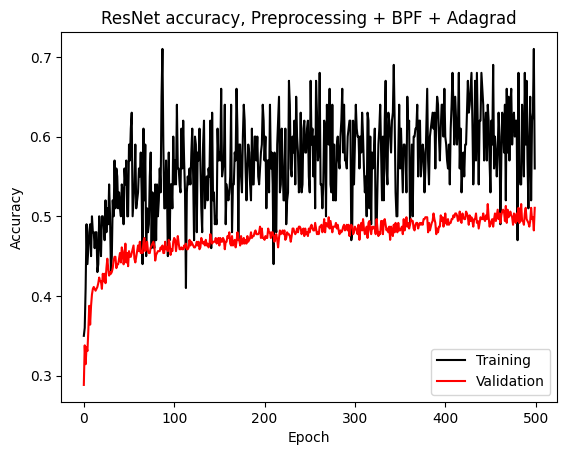

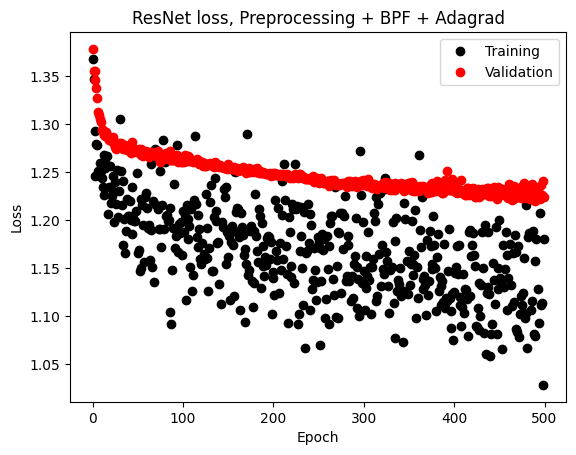

In [ ]:
#Update arrays and titles
plt.plot(np.arange(num_epochs),train_history_7,label='Training',color='k')
plt.plot(np.arange(num_epochs),val_history_7,label='Validation',color='r')
plt.title('ResNet accuracy, Preprocessing + BPF + Adagrad')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(num_epochs),train_loss_hist_7,'o',label='Training',color='k')
plt.plot(np.arange(num_epochs),val_loss_hist_7,'o',label='Validation',color='r')
plt.title('ResNet loss, Preprocessing + BPF + Adagrad')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
#Model 5 achieved the best validation accuracy. Test on test dataset.
model5.eval()
test_count = 0
test_correct_count = 0
with torch.no_grad():
    test_x = x_test
    test_y = y_test
    logits = model5(test_x).detach()
    logits = nn.functional.softmax(logits)
    test_loss = criterion(logits.float(), test_y.float())
    with torch.no_grad():
        y_hat = torch.argmax(logits, dim=1)
        test_correct_count = torch.sum(y_hat == torch.argmax(test_y, dim=1))
        test_count = float(test_x.size(0))
test_acc = test_correct_count / test_count
print('Test accuracy of the ResNet model: ', test_acc.item())

Test accuracy of the ResNet model:  0.530474066734314


<ipython-input-27-1b4f05ccaa9c>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
